# negative_sampling_layer.py

In [10]:
# coding: utf-8
import sys
sys.path.append('..')
#from common.np import *  # import numpy as np
#from common.layers import Embedding, SigmoidWithLoss
import collections


class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh


class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）로 계산할 때는 속도를 우선한다.
            # 부정적 예에 타깃이 포함될 수 있다.
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample


class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 긍정적 예 순전파
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 부정적 예 순전파
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh


# cbow.py

In [11]:
# coding: utf-8
import sys
sys.path.append('..')
#from common.np import *  # import numpy as np
#from common.layers import Embedding
#from ch04.negative_sampling_layer import NegativeSamplingLoss

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None


# skip_gram.py

In [12]:
# coding: utf-8
import sys
sys.path.append('..')  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
#from common.layers import *
#from ch04.negative_sampling_layer import NegativeSamplingLoss

class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # 계층 생성
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None


# trainer.py

In [13]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
#from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ===============================================
# config.GPU = True
GPU = False
# ===============================================
import pickle
#from common.trainer import Trainer
#from common.optimizer import Adam
#from cbow import CBOW
#from skip_gram import SkipGram
#from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

In [14]:
# 하이퍼파라미터 설정
window_size = 5 #context len: window_size*2(좌우) -> 5*2=10
hidden_size = 100
batch_size = 100
max_epoch = 10

In [15]:
# 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
print("corpus:", corpus.shape)
print("word_to_id:", len(word_to_id))
print("id_to_word:", len(id_to_word))
vocab_size = len(word_to_id)
print("vocab_size:", vocab_size)

corpus: (929589,)
word_to_id: 10000
id_to_word: 10000
vocab_size: 10000


In [16]:
contexts, target = create_contexts_target(corpus, window_size)
if GPU:#config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

In [17]:
print("contexts:", contexts)
print("target:",target)
print("contexts:", contexts.shape)
print("target:",target.shape)

contexts: [[   0    1    2 ...    8    9   10]
 [   1    2    3 ...    9   10   11]
 [   2    3    4 ...   10   11   12]
 ...
 [ 706 9999  119 ...  258   64   39]
 [9999  119 1143 ...   64   39   26]
 [ 119 1143   69 ...   39   26   24]]
target: [   5    6    7 ...  552  917 3196]
contexts: (929579, 10)
target: (929579,)


In [18]:
# 모델 등 생성
model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [19]:
# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 4[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 6[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 7[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 9[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 11[s] | 손실 3.79
| 에폭 1 |  반복 141 / 9295 | 시간 13[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 14[s] | 손실 3.50
| 에폭 1 |  반복 181 / 9295 | 시간 17[s] | 손실 3.37
| 에폭 1 |  반복 201 / 9295 | 시간 19[s] | 손실 3.26
| 에폭 1 |  반복 221 / 9295 | 시간 21[s] | 손실 3.18
| 에폭 1 |  반복 241 / 9295 | 시간 24[s] | 손실 3.09
| 에폭 1 |  반복 261 / 9295 | 시간 27[s] | 손실 3.01
| 에폭 1 |  반복 281 / 9295 | 시간 30[s] | 손실 2.98
| 에폭 1 |  반복 301 / 9295 | 시간 32[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 35[s] | 손실 2.87
| 에폭 1 |  반복 341 / 9295 | 시간 38[s] | 손실 2.83
| 에폭 1 |  반복 361 / 9295 | 시간 40[s] | 손실 2.84
| 에폭 1 |  반복 381 / 9295 | 시간 43[s] | 손실 2.77
| 에폭 1 |  반복 401 / 9295 | 시간 47[s] | 손실 2.76
| 에폭 1 |  반복 421 / 9295 | 시간 49[s] | 손실 2.75
| 에폭 1 |  반복 441 / 929

| 에폭 1 |  반복 3541 / 9295 | 시간 367[s] | 손실 2.41
| 에폭 1 |  반복 3561 / 9295 | 시간 369[s] | 손실 2.40
| 에폭 1 |  반복 3581 / 9295 | 시간 370[s] | 손실 2.44
| 에폭 1 |  반복 3601 / 9295 | 시간 372[s] | 손실 2.41
| 에폭 1 |  반복 3621 / 9295 | 시간 374[s] | 손실 2.43
| 에폭 1 |  반복 3641 / 9295 | 시간 377[s] | 손실 2.44
| 에폭 1 |  반복 3661 / 9295 | 시간 379[s] | 손실 2.43
| 에폭 1 |  반복 3681 / 9295 | 시간 381[s] | 손실 2.43
| 에폭 1 |  반복 3701 / 9295 | 시간 383[s] | 손실 2.40
| 에폭 1 |  반복 3721 / 9295 | 시간 385[s] | 손실 2.41
| 에폭 1 |  반복 3741 / 9295 | 시간 387[s] | 손실 2.40
| 에폭 1 |  반복 3761 / 9295 | 시간 389[s] | 손실 2.43
| 에폭 1 |  반복 3781 / 9295 | 시간 391[s] | 손실 2.41
| 에폭 1 |  반복 3801 / 9295 | 시간 393[s] | 손실 2.41
| 에폭 1 |  반복 3821 / 9295 | 시간 395[s] | 손실 2.42
| 에폭 1 |  반복 3841 / 9295 | 시간 397[s] | 손실 2.40
| 에폭 1 |  반복 3861 / 9295 | 시간 400[s] | 손실 2.41
| 에폭 1 |  반복 3881 / 9295 | 시간 402[s] | 손실 2.42
| 에폭 1 |  반복 3901 / 9295 | 시간 404[s] | 손실 2.43
| 에폭 1 |  반복 3921 / 9295 | 시간 406[s] | 손실 2.41
| 에폭 1 |  반복 3941 / 9295 | 시간 408[s] | 손실 2.42
| 에폭 1 |  반복 

| 에폭 1 |  반복 7041 / 9295 | 시간 726[s] | 손실 2.27
| 에폭 1 |  반복 7061 / 9295 | 시간 728[s] | 손실 2.28
| 에폭 1 |  반복 7081 / 9295 | 시간 731[s] | 손실 2.31
| 에폭 1 |  반복 7101 / 9295 | 시간 733[s] | 손실 2.26
| 에폭 1 |  반복 7121 / 9295 | 시간 735[s] | 손실 2.29
| 에폭 1 |  반복 7141 / 9295 | 시간 737[s] | 손실 2.29
| 에폭 1 |  반복 7161 / 9295 | 시간 738[s] | 손실 2.27
| 에폭 1 |  반복 7181 / 9295 | 시간 740[s] | 손실 2.26
| 에폭 1 |  반복 7201 / 9295 | 시간 742[s] | 손실 2.27
| 에폭 1 |  반복 7221 / 9295 | 시간 743[s] | 손실 2.28
| 에폭 1 |  반복 7241 / 9295 | 시간 746[s] | 손실 2.31
| 에폭 1 |  반복 7261 / 9295 | 시간 749[s] | 손실 2.28
| 에폭 1 |  반복 7281 / 9295 | 시간 751[s] | 손실 2.22
| 에폭 1 |  반복 7301 / 9295 | 시간 752[s] | 손실 2.27
| 에폭 1 |  반복 7321 / 9295 | 시간 754[s] | 손실 2.28
| 에폭 1 |  반복 7341 / 9295 | 시간 756[s] | 손실 2.28
| 에폭 1 |  반복 7361 / 9295 | 시간 759[s] | 손실 2.27
| 에폭 1 |  반복 7381 / 9295 | 시간 762[s] | 손실 2.31
| 에폭 1 |  반복 7401 / 9295 | 시간 765[s] | 손실 2.25
| 에폭 1 |  반복 7421 / 9295 | 시간 767[s] | 손실 2.27
| 에폭 1 |  반복 7441 / 9295 | 시간 769[s] | 손실 2.29
| 에폭 1 |  반복 

| 에폭 2 |  반복 1241 / 9295 | 시간 1055[s] | 손실 2.16
| 에폭 2 |  반복 1261 / 9295 | 시간 1057[s] | 손실 2.13
| 에폭 2 |  반복 1281 / 9295 | 시간 1059[s] | 손실 2.16
| 에폭 2 |  반복 1301 / 9295 | 시간 1061[s] | 손실 2.16
| 에폭 2 |  반복 1321 / 9295 | 시간 1062[s] | 손실 2.15
| 에폭 2 |  반복 1341 / 9295 | 시간 1064[s] | 손실 2.16
| 에폭 2 |  반복 1361 / 9295 | 시간 1066[s] | 손실 2.16
| 에폭 2 |  반복 1381 / 9295 | 시간 1067[s] | 손실 2.11
| 에폭 2 |  반복 1401 / 9295 | 시간 1069[s] | 손실 2.14
| 에폭 2 |  반복 1421 / 9295 | 시간 1071[s] | 손실 2.17
| 에폭 2 |  반복 1441 / 9295 | 시간 1073[s] | 손실 2.13
| 에폭 2 |  반복 1461 / 9295 | 시간 1074[s] | 손실 2.13
| 에폭 2 |  반복 1481 / 9295 | 시간 1076[s] | 손실 2.19
| 에폭 2 |  반복 1501 / 9295 | 시간 1078[s] | 손실 2.14
| 에폭 2 |  반복 1521 / 9295 | 시간 1080[s] | 손실 2.16
| 에폭 2 |  반복 1541 / 9295 | 시간 1082[s] | 손실 2.16
| 에폭 2 |  반복 1561 / 9295 | 시간 1083[s] | 손실 2.15
| 에폭 2 |  반복 1581 / 9295 | 시간 1085[s] | 손실 2.14
| 에폭 2 |  반복 1601 / 9295 | 시간 1087[s] | 손실 2.14
| 에폭 2 |  반복 1621 / 9295 | 시간 1088[s] | 손실 2.13
| 에폭 2 |  반복 1641 / 9295 | 시간 1090[s] | 

| 에폭 2 |  반복 4661 / 9295 | 시간 1354[s] | 손실 2.07
| 에폭 2 |  반복 4681 / 9295 | 시간 1356[s] | 손실 2.08
| 에폭 2 |  반복 4701 / 9295 | 시간 1357[s] | 손실 2.09
| 에폭 2 |  반복 4721 / 9295 | 시간 1359[s] | 손실 2.05
| 에폭 2 |  반복 4741 / 9295 | 시간 1361[s] | 손실 2.09
| 에폭 2 |  반복 4761 / 9295 | 시간 1363[s] | 손실 2.09
| 에폭 2 |  반복 4781 / 9295 | 시간 1364[s] | 손실 2.11
| 에폭 2 |  반복 4801 / 9295 | 시간 1366[s] | 손실 2.08
| 에폭 2 |  반복 4821 / 9295 | 시간 1368[s] | 손실 2.06
| 에폭 2 |  반복 4841 / 9295 | 시간 1370[s] | 손실 2.11
| 에폭 2 |  반복 4861 / 9295 | 시간 1371[s] | 손실 2.07
| 에폭 2 |  반복 4881 / 9295 | 시간 1373[s] | 손실 2.10
| 에폭 2 |  반복 4901 / 9295 | 시간 1375[s] | 손실 2.10
| 에폭 2 |  반복 4921 / 9295 | 시간 1376[s] | 손실 2.11
| 에폭 2 |  반복 4941 / 9295 | 시간 1379[s] | 손실 2.11
| 에폭 2 |  반복 4961 / 9295 | 시간 1381[s] | 손실 2.10
| 에폭 2 |  반복 4981 / 9295 | 시간 1384[s] | 손실 2.09
| 에폭 2 |  반복 5001 / 9295 | 시간 1386[s] | 손실 2.07
| 에폭 2 |  반복 5021 / 9295 | 시간 1388[s] | 손실 2.04
| 에폭 2 |  반복 5041 / 9295 | 시간 1390[s] | 손실 2.11
| 에폭 2 |  반복 5061 / 9295 | 시간 1393[s] | 

| 에폭 2 |  반복 8081 / 9295 | 시간 1717[s] | 손실 1.99
| 에폭 2 |  반복 8101 / 9295 | 시간 1720[s] | 손실 2.05
| 에폭 2 |  반복 8121 / 9295 | 시간 1722[s] | 손실 2.03
| 에폭 2 |  반복 8141 / 9295 | 시간 1724[s] | 손실 2.04
| 에폭 2 |  반복 8161 / 9295 | 시간 1725[s] | 손실 2.04
| 에폭 2 |  반복 8181 / 9295 | 시간 1727[s] | 손실 2.06
| 에폭 2 |  반복 8201 / 9295 | 시간 1729[s] | 손실 2.03
| 에폭 2 |  반복 8221 / 9295 | 시간 1731[s] | 손실 2.06
| 에폭 2 |  반복 8241 / 9295 | 시간 1733[s] | 손실 2.05
| 에폭 2 |  반복 8261 / 9295 | 시간 1735[s] | 손실 2.05
| 에폭 2 |  반복 8281 / 9295 | 시간 1737[s] | 손실 2.01
| 에폭 2 |  반복 8301 / 9295 | 시간 1739[s] | 손실 2.03
| 에폭 2 |  반복 8321 / 9295 | 시간 1741[s] | 손실 2.06
| 에폭 2 |  반복 8341 / 9295 | 시간 1743[s] | 손실 2.04
| 에폭 2 |  반복 8361 / 9295 | 시간 1744[s] | 손실 1.99
| 에폭 2 |  반복 8381 / 9295 | 시간 1746[s] | 손실 2.03
| 에폭 2 |  반복 8401 / 9295 | 시간 1748[s] | 손실 2.01
| 에폭 2 |  반복 8421 / 9295 | 시간 1750[s] | 손실 2.01
| 에폭 2 |  반복 8441 / 9295 | 시간 1751[s] | 손실 2.01
| 에폭 2 |  반복 8461 / 9295 | 시간 1753[s] | 손실 2.05
| 에폭 2 |  반복 8481 / 9295 | 시간 1755[s] | 

| 에폭 3 |  반복 2221 / 9295 | 시간 2065[s] | 손실 1.94
| 에폭 3 |  반복 2241 / 9295 | 시간 2067[s] | 손실 1.93
| 에폭 3 |  반복 2261 / 9295 | 시간 2068[s] | 손실 1.89
| 에폭 3 |  반복 2281 / 9295 | 시간 2070[s] | 손실 1.95
| 에폭 3 |  반복 2301 / 9295 | 시간 2072[s] | 손실 1.94
| 에폭 3 |  반복 2321 / 9295 | 시간 2073[s] | 손실 1.93
| 에폭 3 |  반복 2341 / 9295 | 시간 2075[s] | 손실 1.93
| 에폭 3 |  반복 2361 / 9295 | 시간 2077[s] | 손실 1.97
| 에폭 3 |  반복 2381 / 9295 | 시간 2079[s] | 손실 1.96
| 에폭 3 |  반복 2401 / 9295 | 시간 2080[s] | 손실 1.94
| 에폭 3 |  반복 2421 / 9295 | 시간 2082[s] | 손실 1.92
| 에폭 3 |  반복 2441 / 9295 | 시간 2084[s] | 손실 1.96
| 에폭 3 |  반복 2461 / 9295 | 시간 2085[s] | 손실 1.96
| 에폭 3 |  반복 2481 / 9295 | 시간 2087[s] | 손실 1.93
| 에폭 3 |  반복 2501 / 9295 | 시간 2089[s] | 손실 1.93
| 에폭 3 |  반복 2521 / 9295 | 시간 2090[s] | 손실 1.95
| 에폭 3 |  반복 2541 / 9295 | 시간 2092[s] | 손실 1.97
| 에폭 3 |  반복 2561 / 9295 | 시간 2094[s] | 손실 1.93
| 에폭 3 |  반복 2581 / 9295 | 시간 2095[s] | 손실 1.96
| 에폭 3 |  반복 2601 / 9295 | 시간 2097[s] | 손실 1.96
| 에폭 3 |  반복 2621 / 9295 | 시간 2099[s] | 

| 에폭 3 |  반복 5641 / 9295 | 시간 2489[s] | 손실 1.90
| 에폭 3 |  반복 5661 / 9295 | 시간 2491[s] | 손실 1.92
| 에폭 3 |  반복 5681 / 9295 | 시간 2494[s] | 손실 1.92
| 에폭 3 |  반복 5701 / 9295 | 시간 2496[s] | 손실 1.89
| 에폭 3 |  반복 5721 / 9295 | 시간 2498[s] | 손실 1.94
| 에폭 3 |  반복 5741 / 9295 | 시간 2501[s] | 손실 1.93
| 에폭 3 |  반복 5761 / 9295 | 시간 2504[s] | 손실 1.91
| 에폭 3 |  반복 5781 / 9295 | 시간 2506[s] | 손실 1.91
| 에폭 3 |  반복 5801 / 9295 | 시간 2509[s] | 손실 1.90
| 에폭 3 |  반복 5821 / 9295 | 시간 2511[s] | 손실 1.91
| 에폭 3 |  반복 5841 / 9295 | 시간 2514[s] | 손실 1.88
| 에폭 3 |  반복 5861 / 9295 | 시간 2516[s] | 손실 1.89
| 에폭 3 |  반복 5881 / 9295 | 시간 2518[s] | 손실 1.91
| 에폭 3 |  반복 5901 / 9295 | 시간 2521[s] | 손실 1.91
| 에폭 3 |  반복 5921 / 9295 | 시간 2523[s] | 손실 1.89
| 에폭 3 |  반복 5941 / 9295 | 시간 2526[s] | 손실 1.89
| 에폭 3 |  반복 5961 / 9295 | 시간 2528[s] | 손실 1.92
| 에폭 3 |  반복 5981 / 9295 | 시간 2531[s] | 손실 1.93
| 에폭 3 |  반복 6001 / 9295 | 시간 2533[s] | 손실 1.87
| 에폭 3 |  반복 6021 / 9295 | 시간 2535[s] | 손실 1.94
| 에폭 3 |  반복 6041 / 9295 | 시간 2537[s] | 

| 에폭 3 |  반복 9061 / 9295 | 시간 2981[s] | 손실 1.92
| 에폭 3 |  반복 9081 / 9295 | 시간 2985[s] | 손실 1.90
| 에폭 3 |  반복 9101 / 9295 | 시간 2987[s] | 손실 1.91
| 에폭 3 |  반복 9121 / 9295 | 시간 2990[s] | 손실 1.92
| 에폭 3 |  반복 9141 / 9295 | 시간 2993[s] | 손실 1.85
| 에폭 3 |  반복 9161 / 9295 | 시간 2996[s] | 손실 1.93
| 에폭 3 |  반복 9181 / 9295 | 시간 3000[s] | 손실 1.94
| 에폭 3 |  반복 9201 / 9295 | 시간 3003[s] | 손실 1.92
| 에폭 3 |  반복 9221 / 9295 | 시간 3005[s] | 손실 1.89
| 에폭 3 |  반복 9241 / 9295 | 시간 3008[s] | 손실 1.91
| 에폭 3 |  반복 9261 / 9295 | 시간 3011[s] | 손실 1.87
| 에폭 3 |  반복 9281 / 9295 | 시간 3015[s] | 손실 1.88
| 에폭 4 |  반복 1 / 9295 | 시간 3018[s] | 손실 1.90
| 에폭 4 |  반복 21 / 9295 | 시간 3021[s] | 손실 1.78
| 에폭 4 |  반복 41 / 9295 | 시간 3024[s] | 손실 1.83
| 에폭 4 |  반복 61 / 9295 | 시간 3027[s] | 손실 1.80
| 에폭 4 |  반복 81 / 9295 | 시간 3030[s] | 손실 1.84
| 에폭 4 |  반복 101 / 9295 | 시간 3033[s] | 손실 1.81
| 에폭 4 |  반복 121 / 9295 | 시간 3037[s] | 손실 1.81
| 에폭 4 |  반복 141 / 9295 | 시간 3040[s] | 손실 1.84
| 에폭 4 |  반복 161 / 9295 | 시간 3042[s] | 손실 1.82
| 에폭 4 

| 에폭 4 |  반복 3201 / 9295 | 시간 3484[s] | 손실 1.84
| 에폭 4 |  반복 3221 / 9295 | 시간 3489[s] | 손실 1.81
| 에폭 4 |  반복 3241 / 9295 | 시간 3491[s] | 손실 1.82
| 에폭 4 |  반복 3261 / 9295 | 시간 3494[s] | 손실 1.82
| 에폭 4 |  반복 3281 / 9295 | 시간 3496[s] | 손실 1.82
| 에폭 4 |  반복 3301 / 9295 | 시간 3498[s] | 손실 1.81
| 에폭 4 |  반복 3321 / 9295 | 시간 3500[s] | 손실 1.84
| 에폭 4 |  반복 3341 / 9295 | 시간 3503[s] | 손실 1.83
| 에폭 4 |  반복 3361 / 9295 | 시간 3505[s] | 손실 1.81
| 에폭 4 |  반복 3381 / 9295 | 시간 3509[s] | 손실 1.80
| 에폭 4 |  반복 3401 / 9295 | 시간 3512[s] | 손실 1.80
| 에폭 4 |  반복 3421 / 9295 | 시간 3517[s] | 손실 1.82
| 에폭 4 |  반복 3441 / 9295 | 시간 3521[s] | 손실 1.83
| 에폭 4 |  반복 3461 / 9295 | 시간 3524[s] | 손실 1.77
| 에폭 4 |  반복 3481 / 9295 | 시간 3527[s] | 손실 1.79
| 에폭 4 |  반복 3501 / 9295 | 시간 3530[s] | 손실 1.79
| 에폭 4 |  반복 3521 / 9295 | 시간 3532[s] | 손실 1.78
| 에폭 4 |  반복 3541 / 9295 | 시간 3535[s] | 손실 1.78
| 에폭 4 |  반복 3561 / 9295 | 시간 3538[s] | 손실 1.84
| 에폭 4 |  반복 3581 / 9295 | 시간 3542[s] | 손실 1.81
| 에폭 4 |  반복 3601 / 9295 | 시간 3544[s] | 

| 에폭 4 |  반복 6621 / 9295 | 시간 3936[s] | 손실 1.77
| 에폭 4 |  반복 6641 / 9295 | 시간 3939[s] | 손실 1.79
| 에폭 4 |  반복 6661 / 9295 | 시간 3941[s] | 손실 1.79
| 에폭 4 |  반복 6681 / 9295 | 시간 3943[s] | 손실 1.85
| 에폭 4 |  반복 6701 / 9295 | 시간 3946[s] | 손실 1.77
| 에폭 4 |  반복 6721 / 9295 | 시간 3948[s] | 손실 1.83
| 에폭 4 |  반복 6741 / 9295 | 시간 3950[s] | 손실 1.77
| 에폭 4 |  반복 6761 / 9295 | 시간 3952[s] | 손실 1.82
| 에폭 4 |  반복 6781 / 9295 | 시간 3954[s] | 손실 1.77
| 에폭 4 |  반복 6801 / 9295 | 시간 3956[s] | 손실 1.85
| 에폭 4 |  반복 6821 / 9295 | 시간 3958[s] | 손실 1.81
| 에폭 4 |  반복 6841 / 9295 | 시간 3960[s] | 손실 1.81
| 에폭 4 |  반복 6861 / 9295 | 시간 3962[s] | 손실 1.77
| 에폭 4 |  반복 6881 / 9295 | 시간 3964[s] | 손실 1.76
| 에폭 4 |  반복 6901 / 9295 | 시간 3966[s] | 손실 1.85
| 에폭 4 |  반복 6921 / 9295 | 시간 3968[s] | 손실 1.82
| 에폭 4 |  반복 6941 / 9295 | 시간 3970[s] | 손실 1.81
| 에폭 4 |  반복 6961 / 9295 | 시간 3972[s] | 손실 1.78
| 에폭 4 |  반복 6981 / 9295 | 시간 3973[s] | 손실 1.80
| 에폭 4 |  반복 7001 / 9295 | 시간 3975[s] | 손실 1.79
| 에폭 4 |  반복 7021 / 9295 | 시간 3977[s] | 

| 에폭 5 |  반복 761 / 9295 | 시간 4383[s] | 손실 1.74
| 에폭 5 |  반복 781 / 9295 | 시간 4385[s] | 손실 1.73
| 에폭 5 |  반복 801 / 9295 | 시간 4387[s] | 손실 1.73
| 에폭 5 |  반복 821 / 9295 | 시간 4389[s] | 손실 1.74
| 에폭 5 |  반복 841 / 9295 | 시간 4390[s] | 손실 1.72
| 에폭 5 |  반복 861 / 9295 | 시간 4393[s] | 손실 1.72
| 에폭 5 |  반복 881 / 9295 | 시간 4395[s] | 손실 1.69
| 에폭 5 |  반복 901 / 9295 | 시간 4398[s] | 손실 1.71
| 에폭 5 |  반복 921 / 9295 | 시간 4401[s] | 손실 1.72
| 에폭 5 |  반복 941 / 9295 | 시간 4404[s] | 손실 1.71
| 에폭 5 |  반복 961 / 9295 | 시간 4407[s] | 손실 1.67
| 에폭 5 |  반복 981 / 9295 | 시간 4411[s] | 손실 1.70
| 에폭 5 |  반복 1001 / 9295 | 시간 4414[s] | 손실 1.74
| 에폭 5 |  반복 1021 / 9295 | 시간 4417[s] | 손실 1.73
| 에폭 5 |  반복 1041 / 9295 | 시간 4420[s] | 손실 1.73
| 에폭 5 |  반복 1061 / 9295 | 시간 4423[s] | 손실 1.73
| 에폭 5 |  반복 1081 / 9295 | 시간 4428[s] | 손실 1.75
| 에폭 5 |  반복 1101 / 9295 | 시간 4432[s] | 손실 1.71
| 에폭 5 |  반복 1121 / 9295 | 시간 4435[s] | 손실 1.69
| 에폭 5 |  반복 1141 / 9295 | 시간 4439[s] | 손실 1.72
| 에폭 5 |  반복 1161 / 9295 | 시간 4442[s] | 손실 1.71
| 에폭

| 에폭 5 |  반복 4181 / 9295 | 시간 4769[s] | 손실 1.71
| 에폭 5 |  반복 4201 / 9295 | 시간 4770[s] | 손실 1.76
| 에폭 5 |  반복 4221 / 9295 | 시간 4772[s] | 손실 1.75
| 에폭 5 |  반복 4241 / 9295 | 시간 4774[s] | 손실 1.69
| 에폭 5 |  반복 4261 / 9295 | 시간 4775[s] | 손실 1.74
| 에폭 5 |  반복 4281 / 9295 | 시간 4777[s] | 손실 1.72
| 에폭 5 |  반복 4301 / 9295 | 시간 4779[s] | 손실 1.70
| 에폭 5 |  반복 4321 / 9295 | 시간 4781[s] | 손실 1.71
| 에폭 5 |  반복 4341 / 9295 | 시간 4782[s] | 손실 1.73
| 에폭 5 |  반복 4361 / 9295 | 시간 4784[s] | 손실 1.74
| 에폭 5 |  반복 4381 / 9295 | 시간 4786[s] | 손실 1.71
| 에폭 5 |  반복 4401 / 9295 | 시간 4787[s] | 손실 1.72
| 에폭 5 |  반복 4421 / 9295 | 시간 4789[s] | 손실 1.72
| 에폭 5 |  반복 4441 / 9295 | 시간 4791[s] | 손실 1.69
| 에폭 5 |  반복 4461 / 9295 | 시간 4792[s] | 손실 1.72
| 에폭 5 |  반복 4481 / 9295 | 시간 4794[s] | 손실 1.69
| 에폭 5 |  반복 4501 / 9295 | 시간 4796[s] | 손실 1.69
| 에폭 5 |  반복 4521 / 9295 | 시간 4798[s] | 손실 1.72
| 에폭 5 |  반복 4541 / 9295 | 시간 4799[s] | 손실 1.74
| 에폭 5 |  반복 4561 / 9295 | 시간 4801[s] | 손실 1.73
| 에폭 5 |  반복 4581 / 9295 | 시간 4803[s] | 

| 에폭 5 |  반복 7601 / 9295 | 시간 5082[s] | 손실 1.69
| 에폭 5 |  반복 7621 / 9295 | 시간 5084[s] | 손실 1.74
| 에폭 5 |  반복 7641 / 9295 | 시간 5086[s] | 손실 1.72
| 에폭 5 |  반복 7661 / 9295 | 시간 5088[s] | 손실 1.73
| 에폭 5 |  반복 7681 / 9295 | 시간 5090[s] | 손실 1.72
| 에폭 5 |  반복 7701 / 9295 | 시간 5093[s] | 손실 1.72
| 에폭 5 |  반복 7721 / 9295 | 시간 5096[s] | 손실 1.74
| 에폭 5 |  반복 7741 / 9295 | 시간 5100[s] | 손실 1.73
| 에폭 5 |  반복 7761 / 9295 | 시간 5102[s] | 손실 1.70
| 에폭 5 |  반복 7781 / 9295 | 시간 5104[s] | 손실 1.73
| 에폭 5 |  반복 7801 / 9295 | 시간 5106[s] | 손실 1.67
| 에폭 5 |  반복 7821 / 9295 | 시간 5109[s] | 손실 1.71
| 에폭 5 |  반복 7841 / 9295 | 시간 5113[s] | 손실 1.72
| 에폭 5 |  반복 7861 / 9295 | 시간 5115[s] | 손실 1.72
| 에폭 5 |  반복 7881 / 9295 | 시간 5117[s] | 손실 1.72
| 에폭 5 |  반복 7901 / 9295 | 시간 5119[s] | 손실 1.76
| 에폭 5 |  반복 7921 / 9295 | 시간 5121[s] | 손실 1.74
| 에폭 5 |  반복 7941 / 9295 | 시간 5122[s] | 손실 1.71
| 에폭 5 |  반복 7961 / 9295 | 시간 5124[s] | 손실 1.73
| 에폭 5 |  반복 7981 / 9295 | 시간 5126[s] | 손실 1.74
| 에폭 5 |  반복 8001 / 9295 | 시간 5127[s] | 

| 에폭 6 |  반복 1741 / 9295 | 시간 5443[s] | 손실 1.66
| 에폭 6 |  반복 1761 / 9295 | 시간 5445[s] | 손실 1.62
| 에폭 6 |  반복 1781 / 9295 | 시간 5447[s] | 손실 1.65
| 에폭 6 |  반복 1801 / 9295 | 시간 5449[s] | 손실 1.64
| 에폭 6 |  반복 1821 / 9295 | 시간 5451[s] | 손실 1.64
| 에폭 6 |  반복 1841 / 9295 | 시간 5453[s] | 손실 1.66
| 에폭 6 |  반복 1861 / 9295 | 시간 5455[s] | 손실 1.63
| 에폭 6 |  반복 1881 / 9295 | 시간 5457[s] | 손실 1.58
| 에폭 6 |  반복 1901 / 9295 | 시간 5459[s] | 손실 1.64
| 에폭 6 |  반복 1921 / 9295 | 시간 5461[s] | 손실 1.61
| 에폭 6 |  반복 1941 / 9295 | 시간 5462[s] | 손실 1.67
| 에폭 6 |  반복 1961 / 9295 | 시간 5464[s] | 손실 1.65
| 에폭 6 |  반복 1981 / 9295 | 시간 5466[s] | 손실 1.62
| 에폭 6 |  반복 2001 / 9295 | 시간 5468[s] | 손실 1.65
| 에폭 6 |  반복 2021 / 9295 | 시간 5470[s] | 손실 1.66
| 에폭 6 |  반복 2041 / 9295 | 시간 5472[s] | 손실 1.65
| 에폭 6 |  반복 2061 / 9295 | 시간 5474[s] | 손실 1.63
| 에폭 6 |  반복 2081 / 9295 | 시간 5476[s] | 손실 1.65
| 에폭 6 |  반복 2101 / 9295 | 시간 5478[s] | 손실 1.66
| 에폭 6 |  반복 2121 / 9295 | 시간 5480[s] | 손실 1.65
| 에폭 6 |  반복 2141 / 9295 | 시간 5482[s] | 

| 에폭 6 |  반복 5161 / 9295 | 시간 5792[s] | 손실 1.70
| 에폭 6 |  반복 5181 / 9295 | 시간 5794[s] | 손실 1.66
| 에폭 6 |  반복 5201 / 9295 | 시간 5796[s] | 손실 1.64
| 에폭 6 |  반복 5221 / 9295 | 시간 5798[s] | 손실 1.64
| 에폭 6 |  반복 5241 / 9295 | 시간 5801[s] | 손실 1.65
| 에폭 6 |  반복 5261 / 9295 | 시간 5802[s] | 손실 1.63
| 에폭 6 |  반복 5281 / 9295 | 시간 5804[s] | 손실 1.69
| 에폭 6 |  반복 5301 / 9295 | 시간 5806[s] | 손실 1.68
| 에폭 6 |  반복 5321 / 9295 | 시간 5807[s] | 손실 1.67
| 에폭 6 |  반복 5341 / 9295 | 시간 5809[s] | 손실 1.67
| 에폭 6 |  반복 5361 / 9295 | 시간 5811[s] | 손실 1.71
| 에폭 6 |  반복 5381 / 9295 | 시간 5813[s] | 손실 1.63
| 에폭 6 |  반복 5401 / 9295 | 시간 5814[s] | 손실 1.63
| 에폭 6 |  반복 5421 / 9295 | 시간 5816[s] | 손실 1.68
| 에폭 6 |  반복 5441 / 9295 | 시간 5818[s] | 손실 1.67
| 에폭 6 |  반복 5461 / 9295 | 시간 5820[s] | 손실 1.64
| 에폭 6 |  반복 5481 / 9295 | 시간 5822[s] | 손실 1.62
| 에폭 6 |  반복 5501 / 9295 | 시간 5824[s] | 손실 1.68
| 에폭 6 |  반복 5521 / 9295 | 시간 5826[s] | 손실 1.66
| 에폭 6 |  반복 5541 / 9295 | 시간 5828[s] | 손실 1.65
| 에폭 6 |  반복 5561 / 9295 | 시간 5830[s] | 

| 에폭 6 |  반복 8581 / 9295 | 시간 6105[s] | 손실 1.63
| 에폭 6 |  반복 8601 / 9295 | 시간 6106[s] | 손실 1.64
| 에폭 6 |  반복 8621 / 9295 | 시간 6108[s] | 손실 1.64
| 에폭 6 |  반복 8641 / 9295 | 시간 6110[s] | 손실 1.66
| 에폭 6 |  반복 8661 / 9295 | 시간 6112[s] | 손실 1.67
| 에폭 6 |  반복 8681 / 9295 | 시간 6114[s] | 손실 1.65
| 에폭 6 |  반복 8701 / 9295 | 시간 6116[s] | 손실 1.66
| 에폭 6 |  반복 8721 / 9295 | 시간 6117[s] | 손실 1.65
| 에폭 6 |  반복 8741 / 9295 | 시간 6119[s] | 손실 1.64
| 에폭 6 |  반복 8761 / 9295 | 시간 6121[s] | 손실 1.62
| 에폭 6 |  반복 8781 / 9295 | 시간 6122[s] | 손실 1.67
| 에폭 6 |  반복 8801 / 9295 | 시간 6124[s] | 손실 1.68
| 에폭 6 |  반복 8821 / 9295 | 시간 6126[s] | 손실 1.68
| 에폭 6 |  반복 8841 / 9295 | 시간 6128[s] | 손실 1.63
| 에폭 6 |  반복 8861 / 9295 | 시간 6129[s] | 손실 1.66
| 에폭 6 |  반복 8881 / 9295 | 시간 6131[s] | 손실 1.64
| 에폭 6 |  반복 8901 / 9295 | 시간 6133[s] | 손실 1.64
| 에폭 6 |  반복 8921 / 9295 | 시간 6134[s] | 손실 1.68
| 에폭 6 |  반복 8941 / 9295 | 시간 6136[s] | 손실 1.68
| 에폭 6 |  반복 8961 / 9295 | 시간 6138[s] | 손실 1.66
| 에폭 6 |  반복 8981 / 9295 | 시간 6139[s] | 

| 에폭 7 |  반복 2721 / 9295 | 시간 6422[s] | 손실 1.56
| 에폭 7 |  반복 2741 / 9295 | 시간 6424[s] | 손실 1.58
| 에폭 7 |  반복 2761 / 9295 | 시간 6426[s] | 손실 1.59
| 에폭 7 |  반복 2781 / 9295 | 시간 6428[s] | 손실 1.57
| 에폭 7 |  반복 2801 / 9295 | 시간 6430[s] | 손실 1.61
| 에폭 7 |  반복 2821 / 9295 | 시간 6431[s] | 손실 1.58
| 에폭 7 |  반복 2841 / 9295 | 시간 6433[s] | 손실 1.58
| 에폭 7 |  반복 2861 / 9295 | 시간 6435[s] | 손실 1.58
| 에폭 7 |  반복 2881 / 9295 | 시간 6437[s] | 손실 1.59
| 에폭 7 |  반복 2901 / 9295 | 시간 6439[s] | 손실 1.59
| 에폭 7 |  반복 2921 / 9295 | 시간 6441[s] | 손실 1.59
| 에폭 7 |  반복 2941 / 9295 | 시간 6443[s] | 손실 1.58
| 에폭 7 |  반복 2961 / 9295 | 시간 6444[s] | 손실 1.65
| 에폭 7 |  반복 2981 / 9295 | 시간 6446[s] | 손실 1.61
| 에폭 7 |  반복 3001 / 9295 | 시간 6448[s] | 손실 1.60
| 에폭 7 |  반복 3021 / 9295 | 시간 6450[s] | 손실 1.58
| 에폭 7 |  반복 3041 / 9295 | 시간 6451[s] | 손실 1.60
| 에폭 7 |  반복 3061 / 9295 | 시간 6453[s] | 손실 1.58
| 에폭 7 |  반복 3081 / 9295 | 시간 6455[s] | 손실 1.60
| 에폭 7 |  반복 3101 / 9295 | 시간 6457[s] | 손실 1.58
| 에폭 7 |  반복 3121 / 9295 | 시간 6459[s] | 

| 에폭 7 |  반복 6141 / 9295 | 시간 6816[s] | 손실 1.60
| 에폭 7 |  반복 6161 / 9295 | 시간 6819[s] | 손실 1.59
| 에폭 7 |  반복 6181 / 9295 | 시간 6821[s] | 손실 1.57
| 에폭 7 |  반복 6201 / 9295 | 시간 6826[s] | 손실 1.59
| 에폭 7 |  반복 6221 / 9295 | 시간 6828[s] | 손실 1.61
| 에폭 7 |  반복 6241 / 9295 | 시간 6830[s] | 손실 1.59
| 에폭 7 |  반복 6261 / 9295 | 시간 6832[s] | 손실 1.57
| 에폭 7 |  반복 6281 / 9295 | 시간 6834[s] | 손실 1.58
| 에폭 7 |  반복 6301 / 9295 | 시간 6836[s] | 손실 1.61
| 에폭 7 |  반복 6321 / 9295 | 시간 6838[s] | 손실 1.62
| 에폭 7 |  반복 6341 / 9295 | 시간 6840[s] | 손실 1.59
| 에폭 7 |  반복 6361 / 9295 | 시간 6842[s] | 손실 1.60
| 에폭 7 |  반복 6381 / 9295 | 시간 6844[s] | 손실 1.58
| 에폭 7 |  반복 6401 / 9295 | 시간 6846[s] | 손실 1.56
| 에폭 7 |  반복 6421 / 9295 | 시간 6848[s] | 손실 1.62
| 에폭 7 |  반복 6441 / 9295 | 시간 6850[s] | 손실 1.58
| 에폭 7 |  반복 6461 / 9295 | 시간 6852[s] | 손실 1.59
| 에폭 7 |  반복 6481 / 9295 | 시간 6854[s] | 손실 1.60
| 에폭 7 |  반복 6501 / 9295 | 시간 6856[s] | 손실 1.61
| 에폭 7 |  반복 6521 / 9295 | 시간 6858[s] | 손실 1.58
| 에폭 7 |  반복 6541 / 9295 | 시간 6860[s] | 

| 에폭 8 |  반복 281 / 9295 | 시간 7167[s] | 손실 1.49
| 에폭 8 |  반복 301 / 9295 | 시간 7170[s] | 손실 1.50
| 에폭 8 |  반복 321 / 9295 | 시간 7172[s] | 손실 1.48
| 에폭 8 |  반복 341 / 9295 | 시간 7174[s] | 손실 1.52
| 에폭 8 |  반복 361 / 9295 | 시간 7176[s] | 손실 1.48
| 에폭 8 |  반복 381 / 9295 | 시간 7178[s] | 손실 1.59
| 에폭 8 |  반복 401 / 9295 | 시간 7180[s] | 손실 1.55
| 에폭 8 |  반복 421 / 9295 | 시간 7182[s] | 손실 1.52
| 에폭 8 |  반복 441 / 9295 | 시간 7184[s] | 손실 1.54
| 에폭 8 |  반복 461 / 9295 | 시간 7186[s] | 손실 1.53
| 에폭 8 |  반복 481 / 9295 | 시간 7188[s] | 손실 1.50
| 에폭 8 |  반복 501 / 9295 | 시간 7191[s] | 손실 1.49
| 에폭 8 |  반복 521 / 9295 | 시간 7193[s] | 손실 1.53
| 에폭 8 |  반복 541 / 9295 | 시간 7195[s] | 손실 1.53
| 에폭 8 |  반복 561 / 9295 | 시간 7197[s] | 손실 1.48
| 에폭 8 |  반복 581 / 9295 | 시간 7200[s] | 손실 1.52
| 에폭 8 |  반복 601 / 9295 | 시간 7202[s] | 손실 1.51
| 에폭 8 |  반복 621 / 9295 | 시간 7204[s] | 손실 1.54
| 에폭 8 |  반복 641 / 9295 | 시간 7206[s] | 손실 1.53
| 에폭 8 |  반복 661 / 9295 | 시간 7208[s] | 손실 1.52
| 에폭 8 |  반복 681 / 9295 | 시간 7210[s] | 손실 1.51
| 에폭 8 |  반복 

| 에폭 8 |  반복 3721 / 9295 | 시간 7530[s] | 손실 1.55
| 에폭 8 |  반복 3741 / 9295 | 시간 7532[s] | 손실 1.50
| 에폭 8 |  반복 3761 / 9295 | 시간 7534[s] | 손실 1.53
| 에폭 8 |  반복 3781 / 9295 | 시간 7536[s] | 손실 1.54
| 에폭 8 |  반복 3801 / 9295 | 시간 7538[s] | 손실 1.60
| 에폭 8 |  반복 3821 / 9295 | 시간 7540[s] | 손실 1.56
| 에폭 8 |  반복 3841 / 9295 | 시간 7542[s] | 손실 1.50
| 에폭 8 |  반복 3861 / 9295 | 시간 7544[s] | 손실 1.52
| 에폭 8 |  반복 3881 / 9295 | 시간 7546[s] | 손실 1.50
| 에폭 8 |  반복 3901 / 9295 | 시간 7548[s] | 손실 1.53
| 에폭 8 |  반복 3921 / 9295 | 시간 7550[s] | 손실 1.50
| 에폭 8 |  반복 3941 / 9295 | 시간 7552[s] | 손실 1.55
| 에폭 8 |  반복 3961 / 9295 | 시간 7554[s] | 손실 1.53
| 에폭 8 |  반복 3981 / 9295 | 시간 7557[s] | 손실 1.53
| 에폭 8 |  반복 4001 / 9295 | 시간 7559[s] | 손실 1.54
| 에폭 8 |  반복 4021 / 9295 | 시간 7561[s] | 손실 1.53
| 에폭 8 |  반복 4041 / 9295 | 시간 7563[s] | 손실 1.52
| 에폭 8 |  반복 4061 / 9295 | 시간 7565[s] | 손실 1.54
| 에폭 8 |  반복 4081 / 9295 | 시간 7567[s] | 손실 1.55
| 에폭 8 |  반복 4101 / 9295 | 시간 7569[s] | 손실 1.55
| 에폭 8 |  반복 4121 / 9295 | 시간 7571[s] | 

| 에폭 8 |  반복 7141 / 9295 | 시간 7861[s] | 손실 1.54
| 에폭 8 |  반복 7161 / 9295 | 시간 7863[s] | 손실 1.52
| 에폭 8 |  반복 7181 / 9295 | 시간 7865[s] | 손실 1.57
| 에폭 8 |  반복 7201 / 9295 | 시간 7867[s] | 손실 1.53
| 에폭 8 |  반복 7221 / 9295 | 시간 7869[s] | 손실 1.53
| 에폭 8 |  반복 7241 / 9295 | 시간 7871[s] | 손실 1.52
| 에폭 8 |  반복 7261 / 9295 | 시간 7873[s] | 손실 1.52
| 에폭 8 |  반복 7281 / 9295 | 시간 7876[s] | 손실 1.53
| 에폭 8 |  반복 7301 / 9295 | 시간 7878[s] | 손실 1.54
| 에폭 8 |  반복 7321 / 9295 | 시간 7880[s] | 손실 1.57
| 에폭 8 |  반복 7341 / 9295 | 시간 7882[s] | 손실 1.54
| 에폭 8 |  반복 7361 / 9295 | 시간 7884[s] | 손실 1.54
| 에폭 8 |  반복 7381 / 9295 | 시간 7886[s] | 손실 1.48
| 에폭 8 |  반복 7401 / 9295 | 시간 7888[s] | 손실 1.56
| 에폭 8 |  반복 7421 / 9295 | 시간 7891[s] | 손실 1.56
| 에폭 8 |  반복 7441 / 9295 | 시간 7892[s] | 손실 1.51
| 에폭 8 |  반복 7461 / 9295 | 시간 7894[s] | 손실 1.53
| 에폭 8 |  반복 7481 / 9295 | 시간 7896[s] | 손실 1.58
| 에폭 8 |  반복 7501 / 9295 | 시간 7898[s] | 손실 1.49
| 에폭 8 |  반복 7521 / 9295 | 시간 7900[s] | 손실 1.55
| 에폭 8 |  반복 7541 / 9295 | 시간 7902[s] | 

| 에폭 9 |  반복 1281 / 9295 | 시간 8202[s] | 손실 1.51
| 에폭 9 |  반복 1301 / 9295 | 시간 8204[s] | 손실 1.48
| 에폭 9 |  반복 1321 / 9295 | 시간 8206[s] | 손실 1.46
| 에폭 9 |  반복 1341 / 9295 | 시간 8208[s] | 손실 1.48
| 에폭 9 |  반복 1361 / 9295 | 시간 8210[s] | 손실 1.43
| 에폭 9 |  반복 1381 / 9295 | 시간 8212[s] | 손실 1.47
| 에폭 9 |  반복 1401 / 9295 | 시간 8214[s] | 손실 1.48
| 에폭 9 |  반복 1421 / 9295 | 시간 8216[s] | 손실 1.48
| 에폭 9 |  반복 1441 / 9295 | 시간 8219[s] | 손실 1.48
| 에폭 9 |  반복 1461 / 9295 | 시간 8221[s] | 손실 1.48
| 에폭 9 |  반복 1481 / 9295 | 시간 8223[s] | 손실 1.46
| 에폭 9 |  반복 1501 / 9295 | 시간 8225[s] | 손실 1.50
| 에폭 9 |  반복 1521 / 9295 | 시간 8227[s] | 손실 1.50
| 에폭 9 |  반복 1541 / 9295 | 시간 8229[s] | 손실 1.43
| 에폭 9 |  반복 1561 / 9295 | 시간 8231[s] | 손실 1.48
| 에폭 9 |  반복 1581 / 9295 | 시간 8233[s] | 손실 1.50
| 에폭 9 |  반복 1601 / 9295 | 시간 8235[s] | 손실 1.49
| 에폭 9 |  반복 1621 / 9295 | 시간 8236[s] | 손실 1.45
| 에폭 9 |  반복 1641 / 9295 | 시간 8238[s] | 손실 1.47
| 에폭 9 |  반복 1661 / 9295 | 시간 8240[s] | 손실 1.47
| 에폭 9 |  반복 1681 / 9295 | 시간 8242[s] | 

| 에폭 9 |  반복 4701 / 9295 | 시간 8567[s] | 손실 1.48
| 에폭 9 |  반복 4721 / 9295 | 시간 8569[s] | 손실 1.48
| 에폭 9 |  반복 4741 / 9295 | 시간 8570[s] | 손실 1.47
| 에폭 9 |  반복 4761 / 9295 | 시간 8572[s] | 손실 1.48
| 에폭 9 |  반복 4781 / 9295 | 시간 8574[s] | 손실 1.50
| 에폭 9 |  반복 4801 / 9295 | 시간 8575[s] | 손실 1.51
| 에폭 9 |  반복 4821 / 9295 | 시간 8577[s] | 손실 1.52
| 에폭 9 |  반복 4841 / 9295 | 시간 8579[s] | 손실 1.51
| 에폭 9 |  반복 4861 / 9295 | 시간 8580[s] | 손실 1.48
| 에폭 9 |  반복 4881 / 9295 | 시간 8582[s] | 손실 1.50
| 에폭 9 |  반복 4901 / 9295 | 시간 8584[s] | 손실 1.50
| 에폭 9 |  반복 4921 / 9295 | 시간 8585[s] | 손실 1.46
| 에폭 9 |  반복 4941 / 9295 | 시간 8587[s] | 손실 1.51
| 에폭 9 |  반복 4961 / 9295 | 시간 8589[s] | 손실 1.46
| 에폭 9 |  반복 4981 / 9295 | 시간 8591[s] | 손실 1.50
| 에폭 9 |  반복 5001 / 9295 | 시간 8592[s] | 손실 1.47
| 에폭 9 |  반복 5021 / 9295 | 시간 8594[s] | 손실 1.44
| 에폭 9 |  반복 5041 / 9295 | 시간 8597[s] | 손실 1.48
| 에폭 9 |  반복 5061 / 9295 | 시간 8600[s] | 손실 1.49
| 에폭 9 |  반복 5081 / 9295 | 시간 8603[s] | 손실 1.49
| 에폭 9 |  반복 5101 / 9295 | 시간 8606[s] | 

| 에폭 9 |  반복 8121 / 9295 | 시간 8958[s] | 손실 1.50
| 에폭 9 |  반복 8141 / 9295 | 시간 8960[s] | 손실 1.51
| 에폭 9 |  반복 8161 / 9295 | 시간 8963[s] | 손실 1.55
| 에폭 9 |  반복 8181 / 9295 | 시간 8965[s] | 손실 1.52
| 에폭 9 |  반복 8201 / 9295 | 시간 8968[s] | 손실 1.49
| 에폭 9 |  반복 8221 / 9295 | 시간 8972[s] | 손실 1.48
| 에폭 9 |  반복 8241 / 9295 | 시간 8974[s] | 손실 1.49
| 에폭 9 |  반복 8261 / 9295 | 시간 8976[s] | 손실 1.51
| 에폭 9 |  반복 8281 / 9295 | 시간 8979[s] | 손실 1.52
| 에폭 9 |  반복 8301 / 9295 | 시간 8981[s] | 손실 1.51
| 에폭 9 |  반복 8321 / 9295 | 시간 8983[s] | 손실 1.51
| 에폭 9 |  반복 8341 / 9295 | 시간 8984[s] | 손실 1.52
| 에폭 9 |  반복 8361 / 9295 | 시간 8986[s] | 손실 1.51
| 에폭 9 |  반복 8381 / 9295 | 시간 8988[s] | 손실 1.48
| 에폭 9 |  반복 8401 / 9295 | 시간 8990[s] | 손실 1.46
| 에폭 9 |  반복 8421 / 9295 | 시간 8992[s] | 손실 1.49
| 에폭 9 |  반복 8441 / 9295 | 시간 8994[s] | 손실 1.46
| 에폭 9 |  반복 8461 / 9295 | 시간 8996[s] | 손실 1.46
| 에폭 9 |  반복 8481 / 9295 | 시간 8998[s] | 손실 1.51
| 에폭 9 |  반복 8501 / 9295 | 시간 9000[s] | 손실 1.49
| 에폭 9 |  반복 8521 / 9295 | 시간 9002[s] | 

| 에폭 10 |  반복 2221 / 9295 | 시간 9313[s] | 손실 1.40
| 에폭 10 |  반복 2241 / 9295 | 시간 9316[s] | 손실 1.41
| 에폭 10 |  반복 2261 / 9295 | 시간 9319[s] | 손실 1.43
| 에폭 10 |  반복 2281 / 9295 | 시간 9321[s] | 손실 1.45
| 에폭 10 |  반복 2301 / 9295 | 시간 9324[s] | 손실 1.44
| 에폭 10 |  반복 2321 / 9295 | 시간 9326[s] | 손실 1.40
| 에폭 10 |  반복 2341 / 9295 | 시간 9328[s] | 손실 1.45
| 에폭 10 |  반복 2361 / 9295 | 시간 9331[s] | 손실 1.43
| 에폭 10 |  반복 2381 / 9295 | 시간 9333[s] | 손실 1.48
| 에폭 10 |  반복 2401 / 9295 | 시간 9335[s] | 손실 1.46
| 에폭 10 |  반복 2421 / 9295 | 시간 9337[s] | 손실 1.42
| 에폭 10 |  반복 2441 / 9295 | 시간 9340[s] | 손실 1.45
| 에폭 10 |  반복 2461 / 9295 | 시간 9342[s] | 손실 1.41
| 에폭 10 |  반복 2481 / 9295 | 시간 9345[s] | 손실 1.42
| 에폭 10 |  반복 2501 / 9295 | 시간 9348[s] | 손실 1.44
| 에폭 10 |  반복 2521 / 9295 | 시간 9350[s] | 손실 1.41
| 에폭 10 |  반복 2541 / 9295 | 시간 9352[s] | 손실 1.47
| 에폭 10 |  반복 2561 / 9295 | 시간 9354[s] | 손실 1.42
| 에폭 10 |  반복 2581 / 9295 | 시간 9357[s] | 손실 1.43
| 에폭 10 |  반복 2601 / 9295 | 시간 9359[s] | 손실 1.45
| 에폭 10 |  반복 2621 /

| 에폭 10 |  반복 5581 / 9295 | 시간 9789[s] | 손실 1.46
| 에폭 10 |  반복 5601 / 9295 | 시간 9792[s] | 손실 1.48
| 에폭 10 |  반복 5621 / 9295 | 시간 9795[s] | 손실 1.44
| 에폭 10 |  반복 5641 / 9295 | 시간 9798[s] | 손실 1.43
| 에폭 10 |  반복 5661 / 9295 | 시간 9801[s] | 손실 1.47
| 에폭 10 |  반복 5681 / 9295 | 시간 9804[s] | 손실 1.46
| 에폭 10 |  반복 5701 / 9295 | 시간 9806[s] | 손실 1.42
| 에폭 10 |  반복 5721 / 9295 | 시간 9809[s] | 손실 1.46
| 에폭 10 |  반복 5741 / 9295 | 시간 9812[s] | 손실 1.44
| 에폭 10 |  반복 5761 / 9295 | 시간 9815[s] | 손실 1.43
| 에폭 10 |  반복 5781 / 9295 | 시간 9818[s] | 손실 1.44
| 에폭 10 |  반복 5801 / 9295 | 시간 9822[s] | 손실 1.44
| 에폭 10 |  반복 5821 / 9295 | 시간 9825[s] | 손실 1.42
| 에폭 10 |  반복 5841 / 9295 | 시간 9828[s] | 손실 1.43
| 에폭 10 |  반복 5861 / 9295 | 시간 9832[s] | 손실 1.38
| 에폭 10 |  반복 5881 / 9295 | 시간 9835[s] | 손실 1.50
| 에폭 10 |  반복 5901 / 9295 | 시간 9839[s] | 손실 1.45
| 에폭 10 |  반복 5921 / 9295 | 시간 9842[s] | 손실 1.43
| 에폭 10 |  반복 5941 / 9295 | 시간 9845[s] | 손실 1.48
| 에폭 10 |  반복 5961 / 9295 | 시간 9848[s] | 손실 1.43
| 에폭 10 |  반복 5981 /

| 에폭 10 |  반복 8901 / 9295 | 시간 10202[s] | 손실 1.43
| 에폭 10 |  반복 8921 / 9295 | 시간 10204[s] | 손실 1.46
| 에폭 10 |  반복 8941 / 9295 | 시간 10207[s] | 손실 1.45
| 에폭 10 |  반복 8961 / 9295 | 시간 10209[s] | 손실 1.45
| 에폭 10 |  반복 8981 / 9295 | 시간 10212[s] | 손실 1.44
| 에폭 10 |  반복 9001 / 9295 | 시간 10215[s] | 손실 1.46
| 에폭 10 |  반복 9021 / 9295 | 시간 10217[s] | 손실 1.46
| 에폭 10 |  반복 9041 / 9295 | 시간 10220[s] | 손실 1.45
| 에폭 10 |  반복 9061 / 9295 | 시간 10223[s] | 손실 1.43
| 에폭 10 |  반복 9081 / 9295 | 시간 10225[s] | 손실 1.43
| 에폭 10 |  반복 9101 / 9295 | 시간 10228[s] | 손실 1.42
| 에폭 10 |  반복 9121 / 9295 | 시간 10231[s] | 손실 1.45
| 에폭 10 |  반복 9141 / 9295 | 시간 10233[s] | 손실 1.49
| 에폭 10 |  반복 9161 / 9295 | 시간 10236[s] | 손실 1.47
| 에폭 10 |  반복 9181 / 9295 | 시간 10238[s] | 손실 1.46
| 에폭 10 |  반복 9201 / 9295 | 시간 10241[s] | 손실 1.45
| 에폭 10 |  반복 9221 / 9295 | 시간 10243[s] | 손실 1.50
| 에폭 10 |  반복 9241 / 9295 | 시간 10246[s] | 손실 1.45
| 에폭 10 |  반복 9261 / 9295 | 시간 10248[s] | 손실 1.45
| 에폭 10 |  반복 9281 / 9295 | 시간 10250[s] | 손실 1.50


In [21]:
"""
| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 9295 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 41 / 9295 | 시간 4[s] | 손실 4.15
| 에폭 1 |  반복 61 / 9295 | 시간 6[s] | 손실 4.12
| 에폭 1 |  반복 81 / 9295 | 시간 7[s] | 손실 4.05
| 에폭 1 |  반복 101 / 9295 | 시간 9[s] | 손실 3.93
| 에폭 1 |  반복 121 / 9295 | 시간 11[s] | 손실 3.79
| 에폭 1 |  반복 141 / 9295 | 시간 13[s] | 손실 3.63
| 에폭 1 |  반복 161 / 9295 | 시간 14[s] | 손실 3.50
| 에폭 1 |  반복 181 / 9295 | 시간 17[s] | 손실 3.37
| 에폭 1 |  반복 201 / 9295 | 시간 19[s] | 손실 3.26
| 에폭 1 |  반복 221 / 9295 | 시간 21[s] | 손실 3.18
| 에폭 1 |  반복 241 / 9295 | 시간 24[s] | 손실 3.09
| 에폭 1 |  반복 261 / 9295 | 시간 27[s] | 손실 3.01
| 에폭 1 |  반복 281 / 9295 | 시간 30[s] | 손실 2.98
| 에폭 1 |  반복 301 / 9295 | 시간 32[s] | 손실 2.92
| 에폭 1 |  반복 321 / 9295 | 시간 35[s] | 손실 2.87
| 에폭 1 |  반복 341 / 9295 | 시간 38[s] | 손실 2.83
| 에폭 1 |  반복 361 / 9295 | 시간 40[s] | 손실 2.84
| 에폭 1 |  반복 381 / 9295 | 시간 43[s] | 손실 2.77
| 에폭 1 |  반복 401 / 9295 | 시간 47[s] | 손실 2.76
| 에폭 1 |  반복 421 / 9295 | 시간 49[s] | 손실 2.75
| 에폭 1 |  반복 441 / 9295 | 시간 52[s] | 손실 2.72
| 에폭 1 |  반복 461 / 9295 | 시간 54[s] | 손실 2.69
| 에폭 1 |  반복 481 / 9295 | 시간 56[s] | 손실 2.68
| 에폭 1 |  반복 501 / 9295 | 시간 59[s] | 손실 2.69
| 에폭 1 |  반복 521 / 9295 | 시간 61[s] | 손실 2.66
| 에폭 1 |  반복 541 / 9295 | 시간 64[s] | 손실 2.66
| 에폭 1 |  반복 561 / 9295 | 시간 66[s] | 손실 2.65
| 에폭 1 |  반복 581 / 9295 | 시간 69[s] | 손실 2.67
| 에폭 1 |  반복 601 / 9295 | 시간 72[s] | 손실 2.64
| 에폭 1 |  반복 621 / 9295 | 시간 75[s] | 손실 2.62
| 에폭 1 |  반복 641 / 9295 | 시간 80[s] | 손실 2.63
| 에폭 1 |  반복 661 / 9295 | 시간 82[s] | 손실 2.61
| 에폭 1 |  반복 681 / 9295 | 시간 85[s] | 손실 2.62
| 에폭 1 |  반복 701 / 9295 | 시간 88[s] | 손실 2.61
| 에폭 1 |  반복 721 / 9295 | 시간 90[s] | 손실 2.62
| 에폭 1 |  반복 741 / 9295 | 시간 91[s] | 손실 2.59
| 에폭 1 |  반복 761 / 9295 | 시간 93[s] | 손실 2.60
| 에폭 1 |  반복 781 / 9295 | 시간 95[s] | 손실 2.59
| 에폭 1 |  반복 801 / 9295 | 시간 96[s] | 손실 2.59
| 에폭 1 |  반복 821 / 9295 | 시간 98[s] | 손실 2.56
| 에폭 1 |  반복 841 / 9295 | 시간 101[s] | 손실 2.57
| 에폭 1 |  반복 861 / 9295 | 시간 103[s] | 손실 2.59
| 에폭 1 |  반복 881 / 9295 | 시간 105[s] | 손실 2.55
| 에폭 1 |  반복 901 / 9295 | 시간 107[s] | 손실 2.58
| 에폭 1 |  반복 921 / 9295 | 시간 109[s] | 손실 2.56
| 에폭 1 |  반복 941 / 9295 | 시간 111[s] | 손실 2.57
| 에폭 1 |  반복 961 / 9295 | 시간 113[s] | 손실 2.55
| 에폭 1 |  반복 981 / 9295 | 시간 114[s] | 손실 2.56
| 에폭 1 |  반복 1001 / 9295 | 시간 116[s] | 손실 2.56
| 에폭 1 |  반복 1021 / 9295 | 시간 118[s] | 손실 2.52
| 에폭 1 |  반복 1041 / 9295 | 시간 120[s] | 손실 2.57
| 에폭 1 |  반복 1061 / 9295 | 시간 122[s] | 손실 2.57
| 에폭 1 |  반복 1081 / 9295 | 시간 124[s] | 손실 2.51
| 에폭 1 |  반복 1101 / 9295 | 시간 126[s] | 손실 2.54
| 에폭 1 |  반복 1121 / 9295 | 시간 128[s] | 손실 2.55
| 에폭 1 |  반복 1141 / 9295 | 시간 130[s] | 손실 2.54
| 에폭 1 |  반복 1161 / 9295 | 시간 132[s] | 손실 2.53
| 에폭 1 |  반복 1181 / 9295 | 시간 134[s] | 손실 2.55
| 에폭 1 |  반복 1201 / 9295 | 시간 136[s] | 손실 2.52
| 에폭 1 |  반복 1221 / 9295 | 시간 139[s] | 손실 2.53
| 에폭 1 |  반복 1241 / 9295 | 시간 141[s] | 손실 2.52
| 에폭 1 |  반복 1261 / 9295 | 시간 142[s] | 손실 2.55
| 에폭 1 |  반복 1281 / 9295 | 시간 144[s] | 손실 2.53
| 에폭 1 |  반복 1301 / 9295 | 시간 146[s] | 손실 2.49
| 에폭 1 |  반복 1321 / 9295 | 시간 148[s] | 손실 2.53
| 에폭 1 |  반복 1341 / 9295 | 시간 150[s] | 손실 2.53
| 에폭 1 |  반복 1361 / 9295 | 시간 153[s] | 손실 2.54
| 에폭 1 |  반복 1381 / 9295 | 시간 155[s] | 손실 2.54
| 에폭 1 |  반복 1401 / 9295 | 시간 156[s] | 손실 2.52
| 에폭 1 |  반복 1421 / 9295 | 시간 158[s] | 손실 2.53
| 에폭 1 |  반복 1441 / 9295 | 시간 160[s] | 손실 2.56
| 에폭 1 |  반복 1461 / 9295 | 시간 162[s] | 손실 2.51
| 에폭 1 |  반복 1481 / 9295 | 시간 164[s] | 손실 2.50
| 에폭 1 |  반복 1501 / 9295 | 시간 166[s] | 손실 2.50
| 에폭 1 |  반복 1521 / 9295 | 시간 168[s] | 손실 2.53
| 에폭 1 |  반복 1541 / 9295 | 시간 170[s] | 손실 2.50
| 에폭 1 |  반복 1561 / 9295 | 시간 171[s] | 손실 2.52
| 에폭 1 |  반복 1581 / 9295 | 시간 173[s] | 손실 2.51
| 에폭 1 |  반복 1601 / 9295 | 시간 175[s] | 손실 2.47
| 에폭 1 |  반복 1621 / 9295 | 시간 177[s] | 손실 2.51
| 에폭 1 |  반복 1641 / 9295 | 시간 179[s] | 손실 2.52
| 에폭 1 |  반복 1661 / 9295 | 시간 180[s] | 손실 2.51
| 에폭 1 |  반복 1681 / 9295 | 시간 182[s] | 손실 2.50
| 에폭 1 |  반복 1701 / 9295 | 시간 184[s] | 손실 2.51
| 에폭 1 |  반복 1721 / 9295 | 시간 186[s] | 손실 2.51
| 에폭 1 |  반복 1741 / 9295 | 시간 188[s] | 손실 2.54
| 에폭 1 |  반복 1761 / 9295 | 시간 190[s] | 손실 2.47
| 에폭 1 |  반복 1781 / 9295 | 시간 192[s] | 손실 2.52
| 에폭 1 |  반복 1801 / 9295 | 시간 194[s] | 손실 2.55
| 에폭 1 |  반복 1821 / 9295 | 시간 196[s] | 손실 2.50
| 에폭 1 |  반복 1841 / 9295 | 시간 197[s] | 손실 2.51
| 에폭 1 |  반복 1861 / 9295 | 시간 199[s] | 손실 2.50
| 에폭 1 |  반복 1881 / 9295 | 시간 201[s] | 손실 2.48
| 에폭 1 |  반복 1901 / 9295 | 시간 203[s] | 손실 2.49
| 에폭 1 |  반복 1921 / 9295 | 시간 205[s] | 손실 2.50
| 에폭 1 |  반복 1941 / 9295 | 시간 207[s] | 손실 2.49
| 에폭 1 |  반복 1961 / 9295 | 시간 209[s] | 손실 2.51
| 에폭 1 |  반복 1981 / 9295 | 시간 211[s] | 손실 2.50
| 에폭 1 |  반복 2001 / 9295 | 시간 213[s] | 손실 2.48
| 에폭 1 |  반복 2021 / 9295 | 시간 215[s] | 손실 2.48
| 에폭 1 |  반복 2041 / 9295 | 시간 217[s] | 손실 2.49
| 에폭 1 |  반복 2061 / 9295 | 시간 219[s] | 손실 2.46
| 에폭 1 |  반복 2081 / 9295 | 시간 221[s] | 손실 2.49
| 에폭 1 |  반복 2101 / 9295 | 시간 224[s] | 손실 2.48
| 에폭 1 |  반복 2121 / 9295 | 시간 226[s] | 손실 2.46
| 에폭 1 |  반복 2141 / 9295 | 시간 228[s] | 손실 2.49
| 에폭 1 |  반복 2161 / 9295 | 시간 230[s] | 손실 2.48
| 에폭 1 |  반복 2181 / 9295 | 시간 232[s] | 손실 2.49
| 에폭 1 |  반복 2201 / 9295 | 시간 234[s] | 손실 2.46
| 에폭 1 |  반복 2221 / 9295 | 시간 236[s] | 손실 2.51
| 에폭 1 |  반복 2241 / 9295 | 시간 238[s] | 손실 2.48
| 에폭 1 |  반복 2261 / 9295 | 시간 241[s] | 손실 2.46
| 에폭 1 |  반복 2281 / 9295 | 시간 243[s] | 손실 2.48
| 에폭 1 |  반복 2301 / 9295 | 시간 244[s] | 손실 2.48
| 에폭 1 |  반복 2321 / 9295 | 시간 246[s] | 손실 2.48
| 에폭 1 |  반복 2341 / 9295 | 시간 248[s] | 손실 2.49
| 에폭 1 |  반복 2361 / 9295 | 시간 251[s] | 손실 2.47
| 에폭 1 |  반복 2381 / 9295 | 시간 253[s] | 손실 2.49
| 에폭 1 |  반복 2401 / 9295 | 시간 255[s] | 손실 2.46
| 에폭 1 |  반복 2421 / 9295 | 시간 257[s] | 손실 2.52
| 에폭 1 |  반복 2441 / 9295 | 시간 259[s] | 손실 2.51
| 에폭 1 |  반복 2461 / 9295 | 시간 261[s] | 손실 2.47
| 에폭 1 |  반복 2481 / 9295 | 시간 264[s] | 손실 2.46
| 에폭 1 |  반복 2501 / 9295 | 시간 267[s] | 손실 2.50
| 에폭 1 |  반복 2521 / 9295 | 시간 269[s] | 손실 2.48
| 에폭 1 |  반복 2541 / 9295 | 시간 270[s] | 손실 2.46
| 에폭 1 |  반복 2561 / 9295 | 시간 272[s] | 손실 2.51
| 에폭 1 |  반복 2581 / 9295 | 시간 274[s] | 손실 2.47
| 에폭 1 |  반복 2601 / 9295 | 시간 276[s] | 손실 2.45
| 에폭 1 |  반복 2621 / 9295 | 시간 277[s] | 손실 2.44
| 에폭 1 |  반복 2641 / 9295 | 시간 279[s] | 손실 2.47
| 에폭 1 |  반복 2661 / 9295 | 시간 281[s] | 손실 2.49
| 에폭 1 |  반복 2681 / 9295 | 시간 283[s] | 손실 2.48
| 에폭 1 |  반복 2701 / 9295 | 시간 285[s] | 손실 2.48
| 에폭 1 |  반복 2721 / 9295 | 시간 288[s] | 손실 2.46
| 에폭 1 |  반복 2741 / 9295 | 시간 290[s] | 손실 2.44
| 에폭 1 |  반복 2761 / 9295 | 시간 292[s] | 손실 2.46
| 에폭 1 |  반복 2781 / 9295 | 시간 294[s] | 손실 2.45
| 에폭 1 |  반복 2801 / 9295 | 시간 296[s] | 손실 2.47
| 에폭 1 |  반복 2821 / 9295 | 시간 298[s] | 손실 2.47
| 에폭 1 |  반복 2841 / 9295 | 시간 300[s] | 손실 2.47
| 에폭 1 |  반복 2861 / 9295 | 시간 302[s] | 손실 2.45
| 에폭 1 |  반복 2881 / 9295 | 시간 303[s] | 손실 2.46
| 에폭 1 |  반복 2901 / 9295 | 시간 305[s] | 손실 2.47
| 에폭 1 |  반복 2921 / 9295 | 시간 307[s] | 손실 2.42
| 에폭 1 |  반복 2941 / 9295 | 시간 309[s] | 손실 2.46
| 에폭 1 |  반복 2961 / 9295 | 시간 311[s] | 손실 2.43
| 에폭 1 |  반복 2981 / 9295 | 시간 313[s] | 손실 2.44
| 에폭 1 |  반복 3001 / 9295 | 시간 315[s] | 손실 2.43
| 에폭 1 |  반복 3021 / 9295 | 시간 316[s] | 손실 2.45
| 에폭 1 |  반복 3041 / 9295 | 시간 318[s] | 손실 2.42
| 에폭 1 |  반복 3061 / 9295 | 시간 321[s] | 손실 2.43
| 에폭 1 |  반복 3081 / 9295 | 시간 323[s] | 손실 2.45
| 에폭 1 |  반복 3101 / 9295 | 시간 325[s] | 손실 2.44
| 에폭 1 |  반복 3121 / 9295 | 시간 326[s] | 손실 2.46
| 에폭 1 |  반복 3141 / 9295 | 시간 328[s] | 손실 2.41
| 에폭 1 |  반복 3161 / 9295 | 시간 330[s] | 손실 2.45
| 에폭 1 |  반복 3181 / 9295 | 시간 332[s] | 손실 2.44
| 에폭 1 |  반복 3201 / 9295 | 시간 334[s] | 손실 2.44
| 에폭 1 |  반복 3221 / 9295 | 시간 336[s] | 손실 2.44
| 에폭 1 |  반복 3241 / 9295 | 시간 338[s] | 손실 2.42
| 에폭 1 |  반복 3261 / 9295 | 시간 340[s] | 손실 2.46
| 에폭 1 |  반복 3281 / 9295 | 시간 342[s] | 손실 2.44
| 에폭 1 |  반복 3301 / 9295 | 시간 344[s] | 손실 2.41
| 에폭 1 |  반복 3321 / 9295 | 시간 346[s] | 손실 2.41
| 에폭 1 |  반복 3341 / 9295 | 시간 348[s] | 손실 2.42
| 에폭 1 |  반복 3361 / 9295 | 시간 350[s] | 손실 2.43
| 에폭 1 |  반복 3381 / 9295 | 시간 351[s] | 손실 2.42
| 에폭 1 |  반복 3401 / 9295 | 시간 353[s] | 손실 2.48
| 에폭 1 |  반복 3421 / 9295 | 시간 355[s] | 손실 2.44
| 에폭 1 |  반복 3441 / 9295 | 시간 357[s] | 손실 2.43
| 에폭 1 |  반복 3461 / 9295 | 시간 358[s] | 손실 2.40
| 에폭 1 |  반복 3481 / 9295 | 시간 361[s] | 손실 2.42
| 에폭 1 |  반복 3501 / 9295 | 시간 363[s] | 손실 2.44
| 에폭 1 |  반복 3521 / 9295 | 시간 364[s] | 손실 2.43
| 에폭 1 |  반복 3541 / 9295 | 시간 367[s] | 손실 2.41
| 에폭 1 |  반복 3561 / 9295 | 시간 369[s] | 손실 2.40
| 에폭 1 |  반복 3581 / 9295 | 시간 370[s] | 손실 2.44
| 에폭 1 |  반복 3601 / 9295 | 시간 372[s] | 손실 2.41
| 에폭 1 |  반복 3621 / 9295 | 시간 374[s] | 손실 2.43
| 에폭 1 |  반복 3641 / 9295 | 시간 377[s] | 손실 2.44
| 에폭 1 |  반복 3661 / 9295 | 시간 379[s] | 손실 2.43
| 에폭 1 |  반복 3681 / 9295 | 시간 381[s] | 손실 2.43
| 에폭 1 |  반복 3701 / 9295 | 시간 383[s] | 손실 2.40
| 에폭 1 |  반복 3721 / 9295 | 시간 385[s] | 손실 2.41
| 에폭 1 |  반복 3741 / 9295 | 시간 387[s] | 손실 2.40
| 에폭 1 |  반복 3761 / 9295 | 시간 389[s] | 손실 2.43
| 에폭 1 |  반복 3781 / 9295 | 시간 391[s] | 손실 2.41
| 에폭 1 |  반복 3801 / 9295 | 시간 393[s] | 손실 2.41
| 에폭 1 |  반복 3821 / 9295 | 시간 395[s] | 손실 2.42
| 에폭 1 |  반복 3841 / 9295 | 시간 397[s] | 손실 2.40
| 에폭 1 |  반복 3861 / 9295 | 시간 400[s] | 손실 2.41
| 에폭 1 |  반복 3881 / 9295 | 시간 402[s] | 손실 2.42
| 에폭 1 |  반복 3901 / 9295 | 시간 404[s] | 손실 2.43
| 에폭 1 |  반복 3921 / 9295 | 시간 406[s] | 손실 2.41
| 에폭 1 |  반복 3941 / 9295 | 시간 408[s] | 손실 2.42
| 에폭 1 |  반복 3961 / 9295 | 시간 410[s] | 손실 2.39
| 에폭 1 |  반복 3981 / 9295 | 시간 412[s] | 손실 2.42
| 에폭 1 |  반복 4001 / 9295 | 시간 414[s] | 손실 2.40
| 에폭 1 |  반복 4021 / 9295 | 시간 416[s] | 손실 2.38
| 에폭 1 |  반복 4041 / 9295 | 시간 418[s] | 손실 2.41
| 에폭 1 |  반복 4061 / 9295 | 시간 420[s] | 손실 2.41
| 에폭 1 |  반복 4081 / 9295 | 시간 421[s] | 손실 2.40
| 에폭 1 |  반복 4101 / 9295 | 시간 423[s] | 손실 2.42
| 에폭 1 |  반복 4121 / 9295 | 시간 425[s] | 손실 2.39
| 에폭 1 |  반복 4141 / 9295 | 시간 426[s] | 손실 2.44
| 에폭 1 |  반복 4161 / 9295 | 시간 428[s] | 손실 2.37
| 에폭 1 |  반복 4181 / 9295 | 시간 430[s] | 손실 2.38
| 에폭 1 |  반복 4201 / 9295 | 시간 432[s] | 손실 2.40
| 에폭 1 |  반복 4221 / 9295 | 시간 433[s] | 손실 2.40
| 에폭 1 |  반복 4241 / 9295 | 시간 435[s] | 손실 2.37
| 에폭 1 |  반복 4261 / 9295 | 시간 437[s] | 손실 2.38
| 에폭 1 |  반복 4281 / 9295 | 시간 439[s] | 손실 2.37
| 에폭 1 |  반복 4301 / 9295 | 시간 440[s] | 손실 2.38
| 에폭 1 |  반복 4321 / 9295 | 시간 442[s] | 손실 2.39
| 에폭 1 |  반복 4341 / 9295 | 시간 444[s] | 손실 2.39
| 에폭 1 |  반복 4361 / 9295 | 시간 446[s] | 손실 2.37
| 에폭 1 |  반복 4381 / 9295 | 시간 448[s] | 손실 2.38
| 에폭 1 |  반복 4401 / 9295 | 시간 450[s] | 손실 2.40
| 에폭 1 |  반복 4421 / 9295 | 시간 452[s] | 손실 2.41
| 에폭 1 |  반복 4441 / 9295 | 시간 454[s] | 손실 2.36
| 에폭 1 |  반복 4461 / 9295 | 시간 455[s] | 손실 2.37
| 에폭 1 |  반복 4481 / 9295 | 시간 457[s] | 손실 2.35
| 에폭 1 |  반복 4501 / 9295 | 시간 459[s] | 손실 2.35
| 에폭 1 |  반복 4521 / 9295 | 시간 461[s] | 손실 2.38
| 에폭 1 |  반복 4541 / 9295 | 시간 463[s] | 손실 2.36
| 에폭 1 |  반복 4561 / 9295 | 시간 465[s] | 손실 2.37
| 에폭 1 |  반복 4581 / 9295 | 시간 467[s] | 손실 2.35
| 에폭 1 |  반복 4601 / 9295 | 시간 469[s] | 손실 2.38
| 에폭 1 |  반복 4621 / 9295 | 시간 471[s] | 손실 2.36
| 에폭 1 |  반복 4641 / 9295 | 시간 473[s] | 손실 2.35
| 에폭 1 |  반복 4661 / 9295 | 시간 475[s] | 손실 2.39
| 에폭 1 |  반복 4681 / 9295 | 시간 477[s] | 손실 2.35
| 에폭 1 |  반복 4701 / 9295 | 시간 479[s] | 손실 2.35
| 에폭 1 |  반복 4721 / 9295 | 시간 481[s] | 손실 2.37
| 에폭 1 |  반복 4741 / 9295 | 시간 483[s] | 손실 2.36
| 에폭 1 |  반복 4761 / 9295 | 시간 486[s] | 손실 2.35
| 에폭 1 |  반복 4781 / 9295 | 시간 488[s] | 손실 2.40
| 에폭 1 |  반복 4801 / 9295 | 시간 491[s] | 손실 2.37
| 에폭 1 |  반복 4821 / 9295 | 시간 493[s] | 손실 2.35
| 에폭 1 |  반복 4841 / 9295 | 시간 495[s] | 손실 2.35
| 에폭 1 |  반복 4861 / 9295 | 시간 497[s] | 손실 2.35
| 에폭 1 |  반복 4881 / 9295 | 시간 499[s] | 손실 2.36
| 에폭 1 |  반복 4901 / 9295 | 시간 500[s] | 손실 2.34
| 에폭 1 |  반복 4921 / 9295 | 시간 502[s] | 손실 2.37
| 에폭 1 |  반복 4941 / 9295 | 시간 504[s] | 손실 2.37
| 에폭 1 |  반복 4961 / 9295 | 시간 506[s] | 손실 2.36
| 에폭 1 |  반복 4981 / 9295 | 시간 509[s] | 손실 2.34
| 에폭 1 |  반복 5001 / 9295 | 시간 511[s] | 손실 2.35
| 에폭 1 |  반복 5021 / 9295 | 시간 513[s] | 손실 2.36
| 에폭 1 |  반복 5041 / 9295 | 시간 516[s] | 손실 2.36
| 에폭 1 |  반복 5061 / 9295 | 시간 518[s] | 손실 2.36
| 에폭 1 |  반복 5081 / 9295 | 시간 520[s] | 손실 2.38
| 에폭 1 |  반복 5101 / 9295 | 시간 522[s] | 손실 2.38
| 에폭 1 |  반복 5121 / 9295 | 시간 524[s] | 손실 2.38
| 에폭 1 |  반복 5141 / 9295 | 시간 525[s] | 손실 2.36
| 에폭 1 |  반복 5161 / 9295 | 시간 527[s] | 손실 2.36
| 에폭 1 |  반복 5181 / 9295 | 시간 529[s] | 손실 2.36
| 에폭 1 |  반복 5201 / 9295 | 시간 530[s] | 손실 2.35
| 에폭 1 |  반복 5221 / 9295 | 시간 532[s] | 손실 2.34
| 에폭 1 |  반복 5241 / 9295 | 시간 534[s] | 손실 2.36
| 에폭 1 |  반복 5261 / 9295 | 시간 535[s] | 손실 2.32
| 에폭 1 |  반복 5281 / 9295 | 시간 538[s] | 손실 2.33
| 에폭 1 |  반복 5301 / 9295 | 시간 540[s] | 손실 2.35
| 에폭 1 |  반복 5321 / 9295 | 시간 542[s] | 손실 2.34
| 에폭 1 |  반복 5341 / 9295 | 시간 544[s] | 손실 2.34
| 에폭 1 |  반복 5361 / 9295 | 시간 545[s] | 손실 2.34
| 에폭 1 |  반복 5381 / 9295 | 시간 547[s] | 손실 2.35
| 에폭 1 |  반복 5401 / 9295 | 시간 549[s] | 손실 2.31
| 에폭 1 |  반복 5421 / 9295 | 시간 551[s] | 손실 2.35
| 에폭 1 |  반복 5441 / 9295 | 시간 553[s] | 손실 2.35
| 에폭 1 |  반복 5461 / 9295 | 시간 555[s] | 손실 2.33
| 에폭 1 |  반복 5481 / 9295 | 시간 557[s] | 손실 2.31
| 에폭 1 |  반복 5501 / 9295 | 시간 559[s] | 손실 2.34
| 에폭 1 |  반복 5521 / 9295 | 시간 561[s] | 손실 2.35
| 에폭 1 |  반복 5541 / 9295 | 시간 563[s] | 손실 2.34
| 에폭 1 |  반복 5561 / 9295 | 시간 565[s] | 손실 2.36
| 에폭 1 |  반복 5581 / 9295 | 시간 567[s] | 손실 2.33
| 에폭 1 |  반복 5601 / 9295 | 시간 569[s] | 손실 2.33
| 에폭 1 |  반복 5621 / 9295 | 시간 572[s] | 손실 2.33
| 에폭 1 |  반복 5641 / 9295 | 시간 574[s] | 손실 2.32
| 에폭 1 |  반복 5661 / 9295 | 시간 577[s] | 손실 2.30
| 에폭 1 |  반복 5681 / 9295 | 시간 578[s] | 손실 2.34
| 에폭 1 |  반복 5701 / 9295 | 시간 580[s] | 손실 2.31
| 에폭 1 |  반복 5721 / 9295 | 시간 582[s] | 손실 2.31
| 에폭 1 |  반복 5741 / 9295 | 시간 585[s] | 손실 2.32
| 에폭 1 |  반복 5761 / 9295 | 시간 590[s] | 손실 2.32
| 에폭 1 |  반복 5781 / 9295 | 시간 593[s] | 손실 2.31
| 에폭 1 |  반복 5801 / 9295 | 시간 597[s] | 손실 2.33
| 에폭 1 |  반복 5821 / 9295 | 시간 599[s] | 손실 2.39
| 에폭 1 |  반복 5841 / 9295 | 시간 602[s] | 손실 2.37
| 에폭 1 |  반복 5861 / 9295 | 시간 604[s] | 손실 2.31
| 에폭 1 |  반복 5881 / 9295 | 시간 606[s] | 손실 2.35
| 에폭 1 |  반복 5901 / 9295 | 시간 608[s] | 손실 2.31
| 에폭 1 |  반복 5921 / 9295 | 시간 611[s] | 손실 2.34
| 에폭 1 |  반복 5941 / 9295 | 시간 612[s] | 손실 2.33
| 에폭 1 |  반복 5961 / 9295 | 시간 615[s] | 손실 2.34
| 에폭 1 |  반복 5981 / 9295 | 시간 617[s] | 손실 2.32
| 에폭 1 |  반복 6001 / 9295 | 시간 619[s] | 손실 2.29
| 에폭 1 |  반복 6021 / 9295 | 시간 621[s] | 손실 2.32
| 에폭 1 |  반복 6041 / 9295 | 시간 622[s] | 손실 2.31
| 에폭 1 |  반복 6061 / 9295 | 시간 624[s] | 손실 2.31
| 에폭 1 |  반복 6081 / 9295 | 시간 627[s] | 손실 2.32
| 에폭 1 |  반복 6101 / 9295 | 시간 629[s] | 손실 2.33
| 에폭 1 |  반복 6121 / 9295 | 시간 631[s] | 손실 2.32
| 에폭 1 |  반복 6141 / 9295 | 시간 633[s] | 손실 2.29
| 에폭 1 |  반복 6161 / 9295 | 시간 636[s] | 손실 2.30
| 에폭 1 |  반복 6181 / 9295 | 시간 638[s] | 손실 2.33
| 에폭 1 |  반복 6201 / 9295 | 시간 641[s] | 손실 2.32
| 에폭 1 |  반복 6221 / 9295 | 시간 642[s] | 손실 2.34
| 에폭 1 |  반복 6241 / 9295 | 시간 644[s] | 손실 2.30
| 에폭 1 |  반복 6261 / 9295 | 시간 646[s] | 손실 2.32
| 에폭 1 |  반복 6281 / 9295 | 시간 648[s] | 손실 2.30
| 에폭 1 |  반복 6301 / 9295 | 시간 650[s] | 손실 2.29
| 에폭 1 |  반복 6321 / 9295 | 시간 653[s] | 손실 2.32
| 에폭 1 |  반복 6341 / 9295 | 시간 656[s] | 손실 2.32
| 에폭 1 |  반복 6361 / 9295 | 시간 658[s] | 손실 2.34
| 에폭 1 |  반복 6381 / 9295 | 시간 660[s] | 손실 2.30
| 에폭 1 |  반복 6401 / 9295 | 시간 662[s] | 손실 2.30
| 에폭 1 |  반복 6421 / 9295 | 시간 664[s] | 손실 2.33
| 에폭 1 |  반복 6441 / 9295 | 시간 666[s] | 손실 2.31
| 에폭 1 |  반복 6461 / 9295 | 시간 668[s] | 손실 2.31
| 에폭 1 |  반복 6481 / 9295 | 시간 670[s] | 손실 2.29
| 에폭 1 |  반복 6501 / 9295 | 시간 672[s] | 손실 2.27
| 에폭 1 |  반복 6521 / 9295 | 시간 674[s] | 손실 2.30
| 에폭 1 |  반복 6541 / 9295 | 시간 676[s] | 손실 2.30
| 에폭 1 |  반복 6561 / 9295 | 시간 677[s] | 손실 2.33
| 에폭 1 |  반복 6581 / 9295 | 시간 679[s] | 손실 2.30
| 에폭 1 |  반복 6601 / 9295 | 시간 681[s] | 손실 2.33
| 에폭 1 |  반복 6621 / 9295 | 시간 683[s] | 손실 2.29
| 에폭 1 |  반복 6641 / 9295 | 시간 685[s] | 손실 2.30
| 에폭 1 |  반복 6661 / 9295 | 시간 687[s] | 손실 2.31
| 에폭 1 |  반복 6681 / 9295 | 시간 689[s] | 손실 2.28
| 에폭 1 |  반복 6701 / 9295 | 시간 690[s] | 손실 2.25
| 에폭 1 |  반복 6721 / 9295 | 시간 692[s] | 손실 2.32
| 에폭 1 |  반복 6741 / 9295 | 시간 694[s] | 손실 2.29
| 에폭 1 |  반복 6761 / 9295 | 시간 696[s] | 손실 2.31
| 에폭 1 |  반복 6781 / 9295 | 시간 698[s] | 손실 2.31
| 에폭 1 |  반복 6801 / 9295 | 시간 700[s] | 손실 2.28
| 에폭 1 |  반복 6821 / 9295 | 시간 702[s] | 손실 2.30
| 에폭 1 |  반복 6841 / 9295 | 시간 703[s] | 손실 2.32
| 에폭 1 |  반복 6861 / 9295 | 시간 706[s] | 손실 2.29
| 에폭 1 |  반복 6881 / 9295 | 시간 708[s] | 손실 2.26
| 에폭 1 |  반복 6901 / 9295 | 시간 710[s] | 손실 2.30
| 에폭 1 |  반복 6921 / 9295 | 시간 712[s] | 손실 2.25
| 에폭 1 |  반복 6941 / 9295 | 시간 714[s] | 손실 2.28
| 에폭 1 |  반복 6961 / 9295 | 시간 717[s] | 손실 2.32
| 에폭 1 |  반복 6981 / 9295 | 시간 720[s] | 손실 2.28
| 에폭 1 |  반복 7001 / 9295 | 시간 722[s] | 손실 2.27
| 에폭 1 |  반복 7021 / 9295 | 시간 724[s] | 손실 2.29
| 에폭 1 |  반복 7041 / 9295 | 시간 726[s] | 손실 2.27
| 에폭 1 |  반복 7061 / 9295 | 시간 728[s] | 손실 2.28
| 에폭 1 |  반복 7081 / 9295 | 시간 731[s] | 손실 2.31
| 에폭 1 |  반복 7101 / 9295 | 시간 733[s] | 손실 2.26
| 에폭 1 |  반복 7121 / 9295 | 시간 735[s] | 손실 2.29
| 에폭 1 |  반복 7141 / 9295 | 시간 737[s] | 손실 2.29
| 에폭 1 |  반복 7161 / 9295 | 시간 738[s] | 손실 2.27
| 에폭 1 |  반복 7181 / 9295 | 시간 740[s] | 손실 2.26
| 에폭 1 |  반복 7201 / 9295 | 시간 742[s] | 손실 2.27
| 에폭 1 |  반복 7221 / 9295 | 시간 743[s] | 손실 2.28
| 에폭 1 |  반복 7241 / 9295 | 시간 746[s] | 손실 2.31
| 에폭 1 |  반복 7261 / 9295 | 시간 749[s] | 손실 2.28
| 에폭 1 |  반복 7281 / 9295 | 시간 751[s] | 손실 2.22
| 에폭 1 |  반복 7301 / 9295 | 시간 752[s] | 손실 2.27
| 에폭 1 |  반복 7321 / 9295 | 시간 754[s] | 손실 2.28
| 에폭 1 |  반복 7341 / 9295 | 시간 756[s] | 손실 2.28
| 에폭 1 |  반복 7361 / 9295 | 시간 759[s] | 손실 2.27
| 에폭 1 |  반복 7381 / 9295 | 시간 762[s] | 손실 2.31
| 에폭 1 |  반복 7401 / 9295 | 시간 765[s] | 손실 2.25
| 에폭 1 |  반복 7421 / 9295 | 시간 767[s] | 손실 2.27
| 에폭 1 |  반복 7441 / 9295 | 시간 769[s] | 손실 2.29
| 에폭 1 |  반복 7461 / 9295 | 시간 772[s] | 손실 2.28
| 에폭 1 |  반복 7481 / 9295 | 시간 775[s] | 손실 2.32
| 에폭 1 |  반복 7501 / 9295 | 시간 778[s] | 손실 2.30
| 에폭 1 |  반복 7521 / 9295 | 시간 781[s] | 손실 2.29
| 에폭 1 |  반복 7541 / 9295 | 시간 783[s] | 손실 2.27
| 에폭 1 |  반복 7561 / 9295 | 시간 785[s] | 손실 2.30
| 에폭 1 |  반복 7581 / 9295 | 시간 787[s] | 손실 2.28
| 에폭 1 |  반복 7601 / 9295 | 시간 790[s] | 손실 2.29
| 에폭 1 |  반복 7621 / 9295 | 시간 793[s] | 손실 2.28
| 에폭 1 |  반복 7641 / 9295 | 시간 795[s] | 손실 2.29
| 에폭 1 |  반복 7661 / 9295 | 시간 797[s] | 손실 2.26
| 에폭 1 |  반복 7681 / 9295 | 시간 799[s] | 손실 2.28
| 에폭 1 |  반복 7701 / 9295 | 시간 801[s] | 손실 2.26
| 에폭 1 |  반복 7721 / 9295 | 시간 804[s] | 손실 2.29
| 에폭 1 |  반복 7741 / 9295 | 시간 806[s] | 손실 2.28
| 에폭 1 |  반복 7761 / 9295 | 시간 808[s] | 손실 2.27
| 에폭 1 |  반복 7781 / 9295 | 시간 811[s] | 손실 2.24
| 에폭 1 |  반복 7801 / 9295 | 시간 814[s] | 손실 2.22
| 에폭 1 |  반복 7821 / 9295 | 시간 816[s] | 손실 2.23
| 에폭 1 |  반복 7841 / 9295 | 시간 819[s] | 손실 2.26
| 에폭 1 |  반복 7861 / 9295 | 시간 820[s] | 손실 2.24
| 에폭 1 |  반복 7881 / 9295 | 시간 822[s] | 손실 2.28
| 에폭 1 |  반복 7901 / 9295 | 시간 824[s] | 손실 2.25
| 에폭 1 |  반복 7921 / 9295 | 시간 826[s] | 손실 2.24
| 에폭 1 |  반복 7941 / 9295 | 시간 827[s] | 손실 2.23
| 에폭 1 |  반복 7961 / 9295 | 시간 829[s] | 손실 2.26
| 에폭 1 |  반복 7981 / 9295 | 시간 831[s] | 손실 2.27
| 에폭 1 |  반복 8001 / 9295 | 시간 833[s] | 손실 2.26
| 에폭 1 |  반복 8021 / 9295 | 시간 834[s] | 손실 2.28
| 에폭 1 |  반복 8041 / 9295 | 시간 836[s] | 손실 2.20
| 에폭 1 |  반복 8061 / 9295 | 시간 838[s] | 손실 2.25
| 에폭 1 |  반복 8081 / 9295 | 시간 840[s] | 손실 2.27
| 에폭 1 |  반복 8101 / 9295 | 시간 841[s] | 손실 2.26
| 에폭 1 |  반복 8121 / 9295 | 시간 843[s] | 손실 2.25
| 에폭 1 |  반복 8141 / 9295 | 시간 845[s] | 손실 2.24
| 에폭 1 |  반복 8161 / 9295 | 시간 847[s] | 손실 2.26
| 에폭 1 |  반복 8181 / 9295 | 시간 849[s] | 손실 2.27
| 에폭 1 |  반복 8201 / 9295 | 시간 850[s] | 손실 2.24
| 에폭 1 |  반복 8221 / 9295 | 시간 852[s] | 손실 2.23
| 에폭 1 |  반복 8241 / 9295 | 시간 854[s] | 손실 2.24
| 에폭 1 |  반복 8261 / 9295 | 시간 856[s] | 손실 2.25
| 에폭 1 |  반복 8281 / 9295 | 시간 857[s] | 손실 2.23
| 에폭 1 |  반복 8301 / 9295 | 시간 859[s] | 손실 2.28
| 에폭 1 |  반복 8321 / 9295 | 시간 861[s] | 손실 2.23
| 에폭 1 |  반복 8341 / 9295 | 시간 863[s] | 손실 2.25
| 에폭 1 |  반복 8361 / 9295 | 시간 864[s] | 손실 2.27
| 에폭 1 |  반복 8381 / 9295 | 시간 866[s] | 손실 2.23
| 에폭 1 |  반복 8401 / 9295 | 시간 868[s] | 손실 2.26
| 에폭 1 |  반복 8421 / 9295 | 시간 870[s] | 손실 2.26
| 에폭 1 |  반복 8441 / 9295 | 시간 871[s] | 손실 2.23
| 에폭 1 |  반복 8461 / 9295 | 시간 873[s] | 손실 2.28
| 에폭 1 |  반복 8481 / 9295 | 시간 875[s] | 손실 2.23
| 에폭 1 |  반복 8501 / 9295 | 시간 877[s] | 손실 2.23
| 에폭 1 |  반복 8521 / 9295 | 시간 878[s] | 손실 2.25
| 에폭 1 |  반복 8541 / 9295 | 시간 880[s] | 손실 2.23
| 에폭 1 |  반복 8561 / 9295 | 시간 882[s] | 손실 2.19
| 에폭 1 |  반복 8581 / 9295 | 시간 884[s] | 손실 2.22
| 에폭 1 |  반복 8601 / 9295 | 시간 885[s] | 손실 2.25
| 에폭 1 |  반복 8621 / 9295 | 시간 887[s] | 손실 2.21
| 에폭 1 |  반복 8641 / 9295 | 시간 889[s] | 손실 2.23
| 에폭 1 |  반복 8661 / 9295 | 시간 891[s] | 손실 2.23
| 에폭 1 |  반복 8681 / 9295 | 시간 892[s] | 손실 2.22
| 에폭 1 |  반복 8701 / 9295 | 시간 894[s] | 손실 2.24
| 에폭 1 |  반복 8721 / 9295 | 시간 896[s] | 손실 2.22
| 에폭 1 |  반복 8741 / 9295 | 시간 898[s] | 손실 2.27
| 에폭 1 |  반복 8761 / 9295 | 시간 899[s] | 손실 2.23
| 에폭 1 |  반복 8781 / 9295 | 시간 901[s] | 손실 2.24
| 에폭 1 |  반복 8801 / 9295 | 시간 903[s] | 손실 2.22
| 에폭 1 |  반복 8821 / 9295 | 시간 905[s] | 손실 2.24
| 에폭 1 |  반복 8841 / 9295 | 시간 906[s] | 손실 2.24
| 에폭 1 |  반복 8861 / 9295 | 시간 908[s] | 손실 2.22
| 에폭 1 |  반복 8881 / 9295 | 시간 910[s] | 손실 2.25
| 에폭 1 |  반복 8901 / 9295 | 시간 912[s] | 손실 2.22
| 에폭 1 |  반복 8921 / 9295 | 시간 913[s] | 손실 2.23
| 에폭 1 |  반복 8941 / 9295 | 시간 915[s] | 손실 2.21
| 에폭 1 |  반복 8961 / 9295 | 시간 917[s] | 손실 2.22
| 에폭 1 |  반복 8981 / 9295 | 시간 919[s] | 손실 2.24
| 에폭 1 |  반복 9001 / 9295 | 시간 920[s] | 손실 2.25
| 에폭 1 |  반복 9021 / 9295 | 시간 922[s] | 손실 2.22
| 에폭 1 |  반복 9041 / 9295 | 시간 924[s] | 손실 2.24
| 에폭 1 |  반복 9061 / 9295 | 시간 926[s] | 손실 2.23
| 에폭 1 |  반복 9081 / 9295 | 시간 927[s] | 손실 2.25
| 에폭 1 |  반복 9101 / 9295 | 시간 929[s] | 손실 2.23
| 에폭 1 |  반복 9121 / 9295 | 시간 931[s] | 손실 2.23
| 에폭 1 |  반복 9141 / 9295 | 시간 933[s] | 손실 2.26
| 에폭 1 |  반복 9161 / 9295 | 시간 934[s] | 손실 2.22
| 에폭 1 |  반복 9181 / 9295 | 시간 936[s] | 손실 2.25
| 에폭 1 |  반복 9201 / 9295 | 시간 938[s] | 손실 2.20
| 에폭 1 |  반복 9221 / 9295 | 시간 940[s] | 손실 2.21
| 에폭 1 |  반복 9241 / 9295 | 시간 942[s] | 손실 2.23
| 에폭 1 |  반복 9261 / 9295 | 시간 943[s] | 손실 2.21
| 에폭 1 |  반복 9281 / 9295 | 시간 945[s] | 손실 2.26
| 에폭 2 |  반복 1 / 9295 | 시간 947[s] | 손실 2.20
| 에폭 2 |  반복 21 / 9295 | 시간 948[s] | 손실 2.21
| 에폭 2 |  반복 41 / 9295 | 시간 950[s] | 손실 2.15
| 에폭 2 |  반복 61 / 9295 | 시간 952[s] | 손실 2.16
| 에폭 2 |  반복 81 / 9295 | 시간 954[s] | 손실 2.20
| 에폭 2 |  반복 101 / 9295 | 시간 955[s] | 손실 2.17
| 에폭 2 |  반복 121 / 9295 | 시간 957[s] | 손실 2.17
| 에폭 2 |  반복 141 / 9295 | 시간 959[s] | 손실 2.18
| 에폭 2 |  반복 161 / 9295 | 시간 961[s] | 손실 2.17
| 에폭 2 |  반복 181 / 9295 | 시간 962[s] | 손실 2.18
| 에폭 2 |  반복 201 / 9295 | 시간 964[s] | 손실 2.19
| 에폭 2 |  반복 221 / 9295 | 시간 966[s] | 손실 2.15
| 에폭 2 |  반복 241 / 9295 | 시간 968[s] | 손실 2.16
| 에폭 2 |  반복 261 / 9295 | 시간 969[s] | 손실 2.20
| 에폭 2 |  반복 281 / 9295 | 시간 971[s] | 손실 2.17
| 에폭 2 |  반복 301 / 9295 | 시간 973[s] | 손실 2.17
| 에폭 2 |  반복 321 / 9295 | 시간 975[s] | 손실 2.16
| 에폭 2 |  반복 341 / 9295 | 시간 976[s] | 손실 2.20
| 에폭 2 |  반복 361 / 9295 | 시간 978[s] | 손실 2.15
| 에폭 2 |  반복 381 / 9295 | 시간 980[s] | 손실 2.17
| 에폭 2 |  반복 401 / 9295 | 시간 982[s] | 손실 2.17
| 에폭 2 |  반복 421 / 9295 | 시간 983[s] | 손실 2.17
| 에폭 2 |  반복 441 / 9295 | 시간 985[s] | 손실 2.19
| 에폭 2 |  반복 461 / 9295 | 시간 987[s] | 손실 2.16
| 에폭 2 |  반복 481 / 9295 | 시간 989[s] | 손실 2.17
| 에폭 2 |  반복 501 / 9295 | 시간 990[s] | 손실 2.15
| 에폭 2 |  반복 521 / 9295 | 시간 992[s] | 손실 2.13
| 에폭 2 |  반복 541 / 9295 | 시간 994[s] | 손실 2.17
| 에폭 2 |  반복 561 / 9295 | 시간 996[s] | 손실 2.18
| 에폭 2 |  반복 581 / 9295 | 시간 997[s] | 손실 2.20
| 에폭 2 |  반복 601 / 9295 | 시간 999[s] | 손실 2.17
| 에폭 2 |  반복 621 / 9295 | 시간 1001[s] | 손실 2.17
| 에폭 2 |  반복 641 / 9295 | 시간 1003[s] | 손실 2.17
| 에폭 2 |  반복 661 / 9295 | 시간 1004[s] | 손실 2.17
| 에폭 2 |  반복 681 / 9295 | 시간 1006[s] | 손실 2.12
| 에폭 2 |  반복 701 / 9295 | 시간 1008[s] | 손실 2.18
| 에폭 2 |  반복 721 / 9295 | 시간 1010[s] | 손실 2.17
| 에폭 2 |  반복 741 / 9295 | 시간 1011[s] | 손실 2.18
| 에폭 2 |  반복 761 / 9295 | 시간 1013[s] | 손실 2.17
| 에폭 2 |  반복 781 / 9295 | 시간 1015[s] | 손실 2.15
| 에폭 2 |  반복 801 / 9295 | 시간 1017[s] | 손실 2.15
| 에폭 2 |  반복 821 / 9295 | 시간 1018[s] | 손실 2.15
| 에폭 2 |  반복 841 / 9295 | 시간 1020[s] | 손실 2.15
| 에폭 2 |  반복 861 / 9295 | 시간 1022[s] | 손실 2.18
| 에폭 2 |  반복 881 / 9295 | 시간 1024[s] | 손실 2.15
| 에폭 2 |  반복 901 / 9295 | 시간 1025[s] | 손실 2.20
| 에폭 2 |  반복 921 / 9295 | 시간 1027[s] | 손실 2.14
| 에폭 2 |  반복 941 / 9295 | 시간 1029[s] | 손실 2.19
| 에폭 2 |  반복 961 / 9295 | 시간 1031[s] | 손실 2.17
| 에폭 2 |  반복 981 / 9295 | 시간 1032[s] | 손실 2.18
| 에폭 2 |  반복 1001 / 9295 | 시간 1034[s] | 손실 2.16
| 에폭 2 |  반복 1021 / 9295 | 시간 1036[s] | 손실 2.19
| 에폭 2 |  반복 1041 / 9295 | 시간 1038[s] | 손실 2.16
| 에폭 2 |  반복 1061 / 9295 | 시간 1040[s] | 손실 2.16
| 에폭 2 |  반복 1081 / 9295 | 시간 1041[s] | 손실 2.15
| 에폭 2 |  반복 1101 / 9295 | 시간 1043[s] | 손실 2.16
| 에폭 2 |  반복 1121 / 9295 | 시간 1045[s] | 손실 2.20
| 에폭 2 |  반복 1141 / 9295 | 시간 1047[s] | 손실 2.12
| 에폭 2 |  반복 1161 / 9295 | 시간 1048[s] | 손실 2.14
| 에폭 2 |  반복 1181 / 9295 | 시간 1050[s] | 손실 2.18
| 에폭 2 |  반복 1201 / 9295 | 시간 1052[s] | 손실 2.16
| 에폭 2 |  반복 1221 / 9295 | 시간 1054[s] | 손실 2.18
| 에폭 2 |  반복 1241 / 9295 | 시간 1055[s] | 손실 2.16
| 에폭 2 |  반복 1261 / 9295 | 시간 1057[s] | 손실 2.13
| 에폭 2 |  반복 1281 / 9295 | 시간 1059[s] | 손실 2.16
| 에폭 2 |  반복 1301 / 9295 | 시간 1061[s] | 손실 2.16
| 에폭 2 |  반복 1321 / 9295 | 시간 1062[s] | 손실 2.15
| 에폭 2 |  반복 1341 / 9295 | 시간 1064[s] | 손실 2.16
| 에폭 2 |  반복 1361 / 9295 | 시간 1066[s] | 손실 2.16
| 에폭 2 |  반복 1381 / 9295 | 시간 1067[s] | 손실 2.11
| 에폭 2 |  반복 1401 / 9295 | 시간 1069[s] | 손실 2.14
| 에폭 2 |  반복 1421 / 9295 | 시간 1071[s] | 손실 2.17
| 에폭 2 |  반복 1441 / 9295 | 시간 1073[s] | 손실 2.13
| 에폭 2 |  반복 1461 / 9295 | 시간 1074[s] | 손실 2.13
| 에폭 2 |  반복 1481 / 9295 | 시간 1076[s] | 손실 2.19
| 에폭 2 |  반복 1501 / 9295 | 시간 1078[s] | 손실 2.14
| 에폭 2 |  반복 1521 / 9295 | 시간 1080[s] | 손실 2.16
| 에폭 2 |  반복 1541 / 9295 | 시간 1082[s] | 손실 2.16
| 에폭 2 |  반복 1561 / 9295 | 시간 1083[s] | 손실 2.15
| 에폭 2 |  반복 1581 / 9295 | 시간 1085[s] | 손실 2.14
| 에폭 2 |  반복 1601 / 9295 | 시간 1087[s] | 손실 2.14
| 에폭 2 |  반복 1621 / 9295 | 시간 1088[s] | 손실 2.13
| 에폭 2 |  반복 1641 / 9295 | 시간 1090[s] | 손실 2.16
| 에폭 2 |  반복 1661 / 9295 | 시간 1092[s] | 손실 2.18
| 에폭 2 |  반복 1681 / 9295 | 시간 1094[s] | 손실 2.13
| 에폭 2 |  반복 1701 / 9295 | 시간 1095[s] | 손실 2.13
| 에폭 2 |  반복 1721 / 9295 | 시간 1097[s] | 손실 2.15
| 에폭 2 |  반복 1741 / 9295 | 시간 1099[s] | 손실 2.19
| 에폭 2 |  반복 1761 / 9295 | 시간 1101[s] | 손실 2.15
| 에폭 2 |  반복 1781 / 9295 | 시간 1102[s] | 손실 2.11
| 에폭 2 |  반복 1801 / 9295 | 시간 1104[s] | 손실 2.15
| 에폭 2 |  반복 1821 / 9295 | 시간 1106[s] | 손실 2.10
| 에폭 2 |  반복 1841 / 9295 | 시간 1108[s] | 손실 2.15
| 에폭 2 |  반복 1861 / 9295 | 시간 1109[s] | 손실 2.12
| 에폭 2 |  반복 1881 / 9295 | 시간 1111[s] | 손실 2.15
| 에폭 2 |  반복 1901 / 9295 | 시간 1113[s] | 손실 2.12
| 에폭 2 |  반복 1921 / 9295 | 시간 1115[s] | 손실 2.10
| 에폭 2 |  반복 1941 / 9295 | 시간 1117[s] | 손실 2.12
| 에폭 2 |  반복 1961 / 9295 | 시간 1118[s] | 손실 2.14
| 에폭 2 |  반복 1981 / 9295 | 시간 1120[s] | 손실 2.14
| 에폭 2 |  반복 2001 / 9295 | 시간 1122[s] | 손실 2.15
| 에폭 2 |  반복 2021 / 9295 | 시간 1124[s] | 손실 2.13
| 에폭 2 |  반복 2041 / 9295 | 시간 1125[s] | 손실 2.15
| 에폭 2 |  반복 2061 / 9295 | 시간 1127[s] | 손실 2.15
| 에폭 2 |  반복 2081 / 9295 | 시간 1129[s] | 손실 2.13
| 에폭 2 |  반복 2101 / 9295 | 시간 1131[s] | 손실 2.15
| 에폭 2 |  반복 2121 / 9295 | 시간 1132[s] | 손실 2.15
| 에폭 2 |  반복 2141 / 9295 | 시간 1134[s] | 손실 2.14
| 에폭 2 |  반복 2161 / 9295 | 시간 1136[s] | 손실 2.14
| 에폭 2 |  반복 2181 / 9295 | 시간 1138[s] | 손실 2.14
| 에폭 2 |  반복 2201 / 9295 | 시간 1139[s] | 손실 2.16
| 에폭 2 |  반복 2221 / 9295 | 시간 1141[s] | 손실 2.14
| 에폭 2 |  반복 2241 / 9295 | 시간 1143[s] | 손실 2.12
| 에폭 2 |  반복 2261 / 9295 | 시간 1145[s] | 손실 2.11
| 에폭 2 |  반복 2281 / 9295 | 시간 1146[s] | 손실 2.12
| 에폭 2 |  반복 2301 / 9295 | 시간 1148[s] | 손실 2.15
| 에폭 2 |  반복 2321 / 9295 | 시간 1150[s] | 손실 2.14
| 에폭 2 |  반복 2341 / 9295 | 시간 1152[s] | 손실 2.19
| 에폭 2 |  반복 2361 / 9295 | 시간 1153[s] | 손실 2.13
| 에폭 2 |  반복 2381 / 9295 | 시간 1155[s] | 손실 2.12
| 에폭 2 |  반복 2401 / 9295 | 시간 1157[s] | 손실 2.13
| 에폭 2 |  반복 2421 / 9295 | 시간 1159[s] | 손실 2.15
| 에폭 2 |  반복 2441 / 9295 | 시간 1160[s] | 손실 2.13
| 에폭 2 |  반복 2461 / 9295 | 시간 1162[s] | 손실 2.16
| 에폭 2 |  반복 2481 / 9295 | 시간 1164[s] | 손실 2.11
| 에폭 2 |  반복 2501 / 9295 | 시간 1166[s] | 손실 2.13
| 에폭 2 |  반복 2521 / 9295 | 시간 1167[s] | 손실 2.13
| 에폭 2 |  반복 2541 / 9295 | 시간 1169[s] | 손실 2.11
| 에폭 2 |  반복 2561 / 9295 | 시간 1171[s] | 손실 2.15
| 에폭 2 |  반복 2581 / 9295 | 시간 1173[s] | 손실 2.14
| 에폭 2 |  반복 2601 / 9295 | 시간 1174[s] | 손실 2.13
| 에폭 2 |  반복 2621 / 9295 | 시간 1176[s] | 손실 2.12
| 에폭 2 |  반복 2641 / 9295 | 시간 1178[s] | 손실 2.13
| 에폭 2 |  반복 2661 / 9295 | 시간 1180[s] | 손실 2.13
| 에폭 2 |  반복 2681 / 9295 | 시간 1181[s] | 손실 2.14
| 에폭 2 |  반복 2701 / 9295 | 시간 1183[s] | 손실 2.14
| 에폭 2 |  반복 2721 / 9295 | 시간 1185[s] | 손실 2.11
| 에폭 2 |  반복 2741 / 9295 | 시간 1186[s] | 손실 2.13
| 에폭 2 |  반복 2761 / 9295 | 시간 1188[s] | 손실 2.15
| 에폭 2 |  반복 2781 / 9295 | 시간 1190[s] | 손실 2.10
| 에폭 2 |  반복 2801 / 9295 | 시간 1192[s] | 손실 2.15
| 에폭 2 |  반복 2821 / 9295 | 시간 1193[s] | 손실 2.12
| 에폭 2 |  반복 2841 / 9295 | 시간 1195[s] | 손실 2.13
| 에폭 2 |  반복 2861 / 9295 | 시간 1197[s] | 손실 2.09
| 에폭 2 |  반복 2881 / 9295 | 시간 1199[s] | 손실 2.11
| 에폭 2 |  반복 2901 / 9295 | 시간 1201[s] | 손실 2.10
| 에폭 2 |  반복 2921 / 9295 | 시간 1202[s] | 손실 2.14
| 에폭 2 |  반복 2941 / 9295 | 시간 1204[s] | 손실 2.14
| 에폭 2 |  반복 2961 / 9295 | 시간 1206[s] | 손실 2.11
| 에폭 2 |  반복 2981 / 9295 | 시간 1207[s] | 손실 2.12
| 에폭 2 |  반복 3001 / 9295 | 시간 1209[s] | 손실 2.10
| 에폭 2 |  반복 3021 / 9295 | 시간 1211[s] | 손실 2.15
| 에폭 2 |  반복 3041 / 9295 | 시간 1213[s] | 손실 2.14
| 에폭 2 |  반복 3061 / 9295 | 시간 1214[s] | 손실 2.13
| 에폭 2 |  반복 3081 / 9295 | 시간 1216[s] | 손실 2.09
| 에폭 2 |  반복 3101 / 9295 | 시간 1218[s] | 손실 2.11
| 에폭 2 |  반복 3121 / 9295 | 시간 1220[s] | 손실 2.09
| 에폭 2 |  반복 3141 / 9295 | 시간 1221[s] | 손실 2.10
| 에폭 2 |  반복 3161 / 9295 | 시간 1223[s] | 손실 2.10
| 에폭 2 |  반복 3181 / 9295 | 시간 1225[s] | 손실 2.13
| 에폭 2 |  반복 3201 / 9295 | 시간 1227[s] | 손실 2.14
| 에폭 2 |  반복 3221 / 9295 | 시간 1228[s] | 손실 2.13
| 에폭 2 |  반복 3241 / 9295 | 시간 1230[s] | 손실 2.11
| 에폭 2 |  반복 3261 / 9295 | 시간 1232[s] | 손실 2.15
| 에폭 2 |  반복 3281 / 9295 | 시간 1234[s] | 손실 2.08
| 에폭 2 |  반복 3301 / 9295 | 시간 1235[s] | 손실 2.12
| 에폭 2 |  반복 3321 / 9295 | 시간 1237[s] | 손실 2.09
| 에폭 2 |  반복 3341 / 9295 | 시간 1239[s] | 손실 2.07
| 에폭 2 |  반복 3361 / 9295 | 시간 1241[s] | 손실 2.13
| 에폭 2 |  반복 3381 / 9295 | 시간 1242[s] | 손실 2.09
| 에폭 2 |  반복 3401 / 9295 | 시간 1244[s] | 손실 2.09
| 에폭 2 |  반복 3421 / 9295 | 시간 1246[s] | 손실 2.10
| 에폭 2 |  반복 3441 / 9295 | 시간 1248[s] | 손실 2.11
| 에폭 2 |  반복 3461 / 9295 | 시간 1249[s] | 손실 2.10
| 에폭 2 |  반복 3481 / 9295 | 시간 1251[s] | 손실 2.07
| 에폭 2 |  반복 3501 / 9295 | 시간 1253[s] | 손실 2.13
| 에폭 2 |  반복 3521 / 9295 | 시간 1255[s] | 손실 2.09
| 에폭 2 |  반복 3541 / 9295 | 시간 1256[s] | 손실 2.06
| 에폭 2 |  반복 3561 / 9295 | 시간 1258[s] | 손실 2.12
| 에폭 2 |  반복 3581 / 9295 | 시간 1260[s] | 손실 2.15
| 에폭 2 |  반복 3601 / 9295 | 시간 1261[s] | 손실 2.10
| 에폭 2 |  반복 3621 / 9295 | 시간 1263[s] | 손실 2.11
| 에폭 2 |  반복 3641 / 9295 | 시간 1265[s] | 손실 2.12
| 에폭 2 |  반복 3661 / 9295 | 시간 1267[s] | 손실 2.10
| 에폭 2 |  반복 3681 / 9295 | 시간 1268[s] | 손실 2.11
| 에폭 2 |  반복 3701 / 9295 | 시간 1270[s] | 손실 2.12
| 에폭 2 |  반복 3721 / 9295 | 시간 1272[s] | 손실 2.09
| 에폭 2 |  반복 3741 / 9295 | 시간 1274[s] | 손실 2.09
| 에폭 2 |  반복 3761 / 9295 | 시간 1275[s] | 손실 2.10
| 에폭 2 |  반복 3781 / 9295 | 시간 1277[s] | 손실 2.07
| 에폭 2 |  반복 3801 / 9295 | 시간 1279[s] | 손실 2.07
| 에폭 2 |  반복 3821 / 9295 | 시간 1281[s] | 손실 2.14
| 에폭 2 |  반복 3841 / 9295 | 시간 1282[s] | 손실 2.14
| 에폭 2 |  반복 3861 / 9295 | 시간 1284[s] | 손실 2.09
| 에폭 2 |  반복 3881 / 9295 | 시간 1286[s] | 손실 2.06
| 에폭 2 |  반복 3901 / 9295 | 시간 1288[s] | 손실 2.09
| 에폭 2 |  반복 3921 / 9295 | 시간 1289[s] | 손실 2.12
| 에폭 2 |  반복 3941 / 9295 | 시간 1291[s] | 손실 2.14
| 에폭 2 |  반복 3961 / 9295 | 시간 1293[s] | 손실 2.09
| 에폭 2 |  반복 3981 / 9295 | 시간 1295[s] | 손실 2.07
| 에폭 2 |  반복 4001 / 9295 | 시간 1296[s] | 손실 2.10
| 에폭 2 |  반복 4021 / 9295 | 시간 1298[s] | 손실 2.08
| 에폭 2 |  반복 4041 / 9295 | 시간 1300[s] | 손실 2.13
| 에폭 2 |  반복 4061 / 9295 | 시간 1302[s] | 손실 2.08
| 에폭 2 |  반복 4081 / 9295 | 시간 1303[s] | 손실 2.09
| 에폭 2 |  반복 4101 / 9295 | 시간 1305[s] | 손실 2.07
| 에폭 2 |  반복 4121 / 9295 | 시간 1307[s] | 손실 2.05
| 에폭 2 |  반복 4141 / 9295 | 시간 1309[s] | 손실 2.10
| 에폭 2 |  반복 4161 / 9295 | 시간 1310[s] | 손실 2.10
| 에폭 2 |  반복 4181 / 9295 | 시간 1312[s] | 손실 2.13
| 에폭 2 |  반복 4201 / 9295 | 시간 1314[s] | 손실 2.08
| 에폭 2 |  반복 4221 / 9295 | 시간 1315[s] | 손실 2.04
| 에폭 2 |  반복 4241 / 9295 | 시간 1317[s] | 손실 2.10
| 에폭 2 |  반복 4261 / 9295 | 시간 1319[s] | 손실 2.12
| 에폭 2 |  반복 4281 / 9295 | 시간 1321[s] | 손실 2.11
| 에폭 2 |  반복 4301 / 9295 | 시간 1323[s] | 손실 2.09
| 에폭 2 |  반복 4321 / 9295 | 시간 1324[s] | 손실 2.12
| 에폭 2 |  반복 4341 / 9295 | 시간 1326[s] | 손실 2.12
| 에폭 2 |  반복 4361 / 9295 | 시간 1328[s] | 손실 2.11
| 에폭 2 |  반복 4381 / 9295 | 시간 1330[s] | 손실 2.10
| 에폭 2 |  반복 4401 / 9295 | 시간 1331[s] | 손실 2.05
| 에폭 2 |  반복 4421 / 9295 | 시간 1333[s] | 손실 2.09
| 에폭 2 |  반복 4441 / 9295 | 시간 1335[s] | 손실 2.10
| 에폭 2 |  반복 4461 / 9295 | 시간 1337[s] | 손실 2.08
| 에폭 2 |  반복 4481 / 9295 | 시간 1338[s] | 손실 2.08
| 에폭 2 |  반복 4501 / 9295 | 시간 1340[s] | 손실 2.11
| 에폭 2 |  반복 4521 / 9295 | 시간 1342[s] | 손실 2.10
| 에폭 2 |  반복 4541 / 9295 | 시간 1343[s] | 손실 2.06
| 에폭 2 |  반복 4561 / 9295 | 시간 1345[s] | 손실 2.08
| 에폭 2 |  반복 4581 / 9295 | 시간 1347[s] | 손실 2.09
| 에폭 2 |  반복 4601 / 9295 | 시간 1349[s] | 손실 2.06
| 에폭 2 |  반복 4621 / 9295 | 시간 1350[s] | 손실 2.06
| 에폭 2 |  반복 4641 / 9295 | 시간 1352[s] | 손실 2.09
| 에폭 2 |  반복 4661 / 9295 | 시간 1354[s] | 손실 2.07
| 에폭 2 |  반복 4681 / 9295 | 시간 1356[s] | 손실 2.08
| 에폭 2 |  반복 4701 / 9295 | 시간 1357[s] | 손실 2.09
| 에폭 2 |  반복 4721 / 9295 | 시간 1359[s] | 손실 2.05
| 에폭 2 |  반복 4741 / 9295 | 시간 1361[s] | 손실 2.09
| 에폭 2 |  반복 4761 / 9295 | 시간 1363[s] | 손실 2.09
| 에폭 2 |  반복 4781 / 9295 | 시간 1364[s] | 손실 2.11
| 에폭 2 |  반복 4801 / 9295 | 시간 1366[s] | 손실 2.08
| 에폭 2 |  반복 4821 / 9295 | 시간 1368[s] | 손실 2.06
| 에폭 2 |  반복 4841 / 9295 | 시간 1370[s] | 손실 2.11
| 에폭 2 |  반복 4861 / 9295 | 시간 1371[s] | 손실 2.07
| 에폭 2 |  반복 4881 / 9295 | 시간 1373[s] | 손실 2.10
| 에폭 2 |  반복 4901 / 9295 | 시간 1375[s] | 손실 2.10
| 에폭 2 |  반복 4921 / 9295 | 시간 1376[s] | 손실 2.11
| 에폭 2 |  반복 4941 / 9295 | 시간 1379[s] | 손실 2.11
| 에폭 2 |  반복 4961 / 9295 | 시간 1381[s] | 손실 2.10
| 에폭 2 |  반복 4981 / 9295 | 시간 1384[s] | 손실 2.09
| 에폭 2 |  반복 5001 / 9295 | 시간 1386[s] | 손실 2.07
| 에폭 2 |  반복 5021 / 9295 | 시간 1388[s] | 손실 2.04
| 에폭 2 |  반복 5041 / 9295 | 시간 1390[s] | 손실 2.11
| 에폭 2 |  반복 5061 / 9295 | 시간 1393[s] | 손실 2.05
| 에폭 2 |  반복 5081 / 9295 | 시간 1396[s] | 손실 2.07
| 에폭 2 |  반복 5101 / 9295 | 시간 1399[s] | 손실 2.07
| 에폭 2 |  반복 5121 / 9295 | 시간 1402[s] | 손실 2.05
| 에폭 2 |  반복 5141 / 9295 | 시간 1404[s] | 손실 2.08
| 에폭 2 |  반복 5161 / 9295 | 시간 1406[s] | 손실 2.10
| 에폭 2 |  반복 5181 / 9295 | 시간 1410[s] | 손실 2.08
| 에폭 2 |  반복 5201 / 9295 | 시간 1413[s] | 손실 2.08
| 에폭 2 |  반복 5221 / 9295 | 시간 1416[s] | 손실 2.06
| 에폭 2 |  반복 5241 / 9295 | 시간 1418[s] | 손실 2.08
| 에폭 2 |  반복 5261 / 9295 | 시간 1422[s] | 손실 2.04
| 에폭 2 |  반복 5281 / 9295 | 시간 1424[s] | 손실 2.06
| 에폭 2 |  반복 5301 / 9295 | 시간 1426[s] | 손실 2.11
| 에폭 2 |  반복 5321 / 9295 | 시간 1428[s] | 손실 2.06
| 에폭 2 |  반복 5341 / 9295 | 시간 1429[s] | 손실 2.12
| 에폭 2 |  반복 5361 / 9295 | 시간 1431[s] | 손실 2.09
| 에폭 2 |  반복 5381 / 9295 | 시간 1433[s] | 손실 2.09
| 에폭 2 |  반복 5401 / 9295 | 시간 1435[s] | 손실 2.10
| 에폭 2 |  반복 5421 / 9295 | 시간 1437[s] | 손실 2.05
| 에폭 2 |  반복 5441 / 9295 | 시간 1439[s] | 손실 2.09
| 에폭 2 |  반복 5461 / 9295 | 시간 1441[s] | 손실 2.02
| 에폭 2 |  반복 5481 / 9295 | 시간 1443[s] | 손실 2.07
| 에폭 2 |  반복 5501 / 9295 | 시간 1445[s] | 손실 2.05
| 에폭 2 |  반복 5521 / 9295 | 시간 1448[s] | 손실 2.06
| 에폭 2 |  반복 5541 / 9295 | 시간 1450[s] | 손실 2.09
| 에폭 2 |  반복 5561 / 9295 | 시간 1452[s] | 손실 2.08
| 에폭 2 |  반복 5581 / 9295 | 시간 1454[s] | 손실 2.09
| 에폭 2 |  반복 5601 / 9295 | 시간 1456[s] | 손실 2.08
| 에폭 2 |  반복 5621 / 9295 | 시간 1459[s] | 손실 2.03
| 에폭 2 |  반복 5641 / 9295 | 시간 1462[s] | 손실 2.07
| 에폭 2 |  반복 5661 / 9295 | 시간 1464[s] | 손실 2.04
| 에폭 2 |  반복 5681 / 9295 | 시간 1467[s] | 손실 2.05
| 에폭 2 |  반복 5701 / 9295 | 시간 1469[s] | 손실 2.09
| 에폭 2 |  반복 5721 / 9295 | 시간 1471[s] | 손실 2.08
| 에폭 2 |  반복 5741 / 9295 | 시간 1473[s] | 손실 2.10
| 에폭 2 |  반복 5761 / 9295 | 시간 1475[s] | 손실 2.05
| 에폭 2 |  반복 5781 / 9295 | 시간 1477[s] | 손실 2.08
| 에폭 2 |  반복 5801 / 9295 | 시간 1479[s] | 손실 2.08
| 에폭 2 |  반복 5821 / 9295 | 시간 1481[s] | 손실 2.08
| 에폭 2 |  반복 5841 / 9295 | 시간 1484[s] | 손실 2.08
| 에폭 2 |  반복 5861 / 9295 | 시간 1487[s] | 손실 2.09
| 에폭 2 |  반복 5881 / 9295 | 시간 1490[s] | 손실 2.07
| 에폭 2 |  반복 5901 / 9295 | 시간 1492[s] | 손실 2.05
| 에폭 2 |  반복 5921 / 9295 | 시간 1494[s] | 손실 2.05
| 에폭 2 |  반복 5941 / 9295 | 시간 1496[s] | 손실 2.08
| 에폭 2 |  반복 5961 / 9295 | 시간 1498[s] | 손실 2.07
| 에폭 2 |  반복 5981 / 9295 | 시간 1500[s] | 손실 2.08
| 에폭 2 |  반복 6001 / 9295 | 시간 1502[s] | 손실 2.05
| 에폭 2 |  반복 6021 / 9295 | 시간 1504[s] | 손실 2.06
| 에폭 2 |  반복 6041 / 9295 | 시간 1505[s] | 손실 2.05
| 에폭 2 |  반복 6061 / 9295 | 시간 1507[s] | 손실 2.07
| 에폭 2 |  반복 6081 / 9295 | 시간 1510[s] | 손실 2.07
| 에폭 2 |  반복 6101 / 9295 | 시간 1513[s] | 손실 2.08
| 에폭 2 |  반복 6121 / 9295 | 시간 1515[s] | 손실 2.06
| 에폭 2 |  반복 6141 / 9295 | 시간 1517[s] | 손실 2.08
| 에폭 2 |  반복 6161 / 9295 | 시간 1519[s] | 손실 2.05
| 에폭 2 |  반복 6181 / 9295 | 시간 1521[s] | 손실 2.06
| 에폭 2 |  반복 6201 / 9295 | 시간 1523[s] | 손실 2.05
| 에폭 2 |  반복 6221 / 9295 | 시간 1525[s] | 손실 2.06
| 에폭 2 |  반복 6241 / 9295 | 시간 1527[s] | 손실 2.03
| 에폭 2 |  반복 6261 / 9295 | 시간 1529[s] | 손실 2.06
| 에폭 2 |  반복 6281 / 9295 | 시간 1531[s] | 손실 2.07
| 에폭 2 |  반복 6301 / 9295 | 시간 1533[s] | 손실 2.06
| 에폭 2 |  반복 6321 / 9295 | 시간 1535[s] | 손실 2.05
| 에폭 2 |  반복 6341 / 9295 | 시간 1538[s] | 손실 2.09
| 에폭 2 |  반복 6361 / 9295 | 시간 1540[s] | 손실 2.06
| 에폭 2 |  반복 6381 / 9295 | 시간 1542[s] | 손실 2.05
| 에폭 2 |  반복 6401 / 9295 | 시간 1544[s] | 손실 2.05
| 에폭 2 |  반복 6421 / 9295 | 시간 1546[s] | 손실 2.04
| 에폭 2 |  반복 6441 / 9295 | 시간 1548[s] | 손실 2.06
| 에폭 2 |  반복 6461 / 9295 | 시간 1549[s] | 손실 2.05
| 에폭 2 |  반복 6481 / 9295 | 시간 1551[s] | 손실 2.03
| 에폭 2 |  반복 6501 / 9295 | 시간 1553[s] | 손실 2.03
| 에폭 2 |  반복 6521 / 9295 | 시간 1555[s] | 손실 2.07
| 에폭 2 |  반복 6541 / 9295 | 시간 1556[s] | 손실 2.02
| 에폭 2 |  반복 6561 / 9295 | 시간 1558[s] | 손실 2.07
| 에폭 2 |  반복 6581 / 9295 | 시간 1560[s] | 손실 2.06
| 에폭 2 |  반복 6601 / 9295 | 시간 1562[s] | 손실 2.03
| 에폭 2 |  반복 6621 / 9295 | 시간 1565[s] | 손실 2.08
| 에폭 2 |  반복 6641 / 9295 | 시간 1567[s] | 손실 2.08
| 에폭 2 |  반복 6661 / 9295 | 시간 1570[s] | 손실 2.07
| 에폭 2 |  반복 6681 / 9295 | 시간 1572[s] | 손실 2.03
| 에폭 2 |  반복 6701 / 9295 | 시간 1574[s] | 손실 2.07
| 에폭 2 |  반복 6721 / 9295 | 시간 1577[s] | 손실 2.04
| 에폭 2 |  반복 6741 / 9295 | 시간 1579[s] | 손실 2.02
| 에폭 2 |  반복 6761 / 9295 | 시간 1581[s] | 손실 2.04
| 에폭 2 |  반복 6781 / 9295 | 시간 1583[s] | 손실 2.08
| 에폭 2 |  반복 6801 / 9295 | 시간 1585[s] | 손실 2.05
| 에폭 2 |  반복 6821 / 9295 | 시간 1587[s] | 손실 2.05
| 에폭 2 |  반복 6841 / 9295 | 시간 1589[s] | 손실 2.03
| 에폭 2 |  반복 6861 / 9295 | 시간 1591[s] | 손실 2.04
| 에폭 2 |  반복 6881 / 9295 | 시간 1593[s] | 손실 2.07
| 에폭 2 |  반복 6901 / 9295 | 시간 1595[s] | 손실 2.06
| 에폭 2 |  반복 6921 / 9295 | 시간 1597[s] | 손실 2.07
| 에폭 2 |  반복 6941 / 9295 | 시간 1599[s] | 손실 2.05
| 에폭 2 |  반복 6961 / 9295 | 시간 1602[s] | 손실 2.00
| 에폭 2 |  반복 6981 / 9295 | 시간 1604[s] | 손실 1.97
| 에폭 2 |  반복 7001 / 9295 | 시간 1606[s] | 손실 2.02
| 에폭 2 |  반복 7021 / 9295 | 시간 1608[s] | 손실 2.07
| 에폭 2 |  반복 7041 / 9295 | 시간 1611[s] | 손실 2.05
| 에폭 2 |  반복 7061 / 9295 | 시간 1613[s] | 손실 2.04
| 에폭 2 |  반복 7081 / 9295 | 시간 1615[s] | 손실 2.11
| 에폭 2 |  반복 7101 / 9295 | 시간 1618[s] | 손실 2.07
| 에폭 2 |  반복 7121 / 9295 | 시간 1620[s] | 손실 2.02
| 에폭 2 |  반복 7141 / 9295 | 시간 1622[s] | 손실 2.04
| 에폭 2 |  반복 7161 / 9295 | 시간 1624[s] | 손실 2.10
| 에폭 2 |  반복 7181 / 9295 | 시간 1626[s] | 손실 2.04
| 에폭 2 |  반복 7201 / 9295 | 시간 1628[s] | 손실 2.05
| 에폭 2 |  반복 7221 / 9295 | 시간 1630[s] | 손실 2.05
| 에폭 2 |  반복 7241 / 9295 | 시간 1632[s] | 손실 2.09
| 에폭 2 |  반복 7261 / 9295 | 시간 1634[s] | 손실 2.04
| 에폭 2 |  반복 7281 / 9295 | 시간 1636[s] | 손실 2.03
| 에폭 2 |  반복 7301 / 9295 | 시간 1638[s] | 손실 2.05
| 에폭 2 |  반복 7321 / 9295 | 시간 1640[s] | 손실 2.04
| 에폭 2 |  반복 7341 / 9295 | 시간 1642[s] | 손실 2.06
| 에폭 2 |  반복 7361 / 9295 | 시간 1644[s] | 손실 2.04
| 에폭 2 |  반복 7381 / 9295 | 시간 1646[s] | 손실 2.02
| 에폭 2 |  반복 7401 / 9295 | 시간 1648[s] | 손실 2.07
| 에폭 2 |  반복 7421 / 9295 | 시간 1651[s] | 손실 2.04
| 에폭 2 |  반복 7441 / 9295 | 시간 1653[s] | 손실 2.02
| 에폭 2 |  반복 7461 / 9295 | 시간 1655[s] | 손실 2.02
| 에폭 2 |  반복 7481 / 9295 | 시간 1656[s] | 손실 2.05
| 에폭 2 |  반복 7501 / 9295 | 시간 1659[s] | 손실 2.01
| 에폭 2 |  반복 7521 / 9295 | 시간 1661[s] | 손실 2.01
| 에폭 2 |  반복 7541 / 9295 | 시간 1663[s] | 손실 2.03
| 에폭 2 |  반복 7561 / 9295 | 시간 1665[s] | 손실 2.01
| 에폭 2 |  반복 7581 / 9295 | 시간 1667[s] | 손실 2.03
| 에폭 2 |  반복 7601 / 9295 | 시간 1668[s] | 손실 2.07
| 에폭 2 |  반복 7621 / 9295 | 시간 1670[s] | 손실 2.05
| 에폭 2 |  반복 7641 / 9295 | 시간 1672[s] | 손실 2.01
| 에폭 2 |  반복 7661 / 9295 | 시간 1675[s] | 손실 2.04
| 에폭 2 |  반복 7681 / 9295 | 시간 1677[s] | 손실 2.06
| 에폭 2 |  반복 7701 / 9295 | 시간 1679[s] | 손실 2.04
| 에폭 2 |  반복 7721 / 9295 | 시간 1681[s] | 손실 2.04
| 에폭 2 |  반복 7741 / 9295 | 시간 1683[s] | 손실 2.04
| 에폭 2 |  반복 7761 / 9295 | 시간 1685[s] | 손실 2.02
| 에폭 2 |  반복 7781 / 9295 | 시간 1687[s] | 손실 2.02
| 에폭 2 |  반복 7801 / 9295 | 시간 1689[s] | 손실 2.06
| 에폭 2 |  반복 7821 / 9295 | 시간 1691[s] | 손실 2.04
| 에폭 2 |  반복 7841 / 9295 | 시간 1693[s] | 손실 2.03
| 에폭 2 |  반복 7861 / 9295 | 시간 1695[s] | 손실 2.04
| 에폭 2 |  반복 7881 / 9295 | 시간 1697[s] | 손실 2.05
| 에폭 2 |  반복 7901 / 9295 | 시간 1699[s] | 손실 2.00
| 에폭 2 |  반복 7921 / 9295 | 시간 1701[s] | 손실 2.01
| 에폭 2 |  반복 7941 / 9295 | 시간 1702[s] | 손실 2.09
| 에폭 2 |  반복 7961 / 9295 | 시간 1704[s] | 손실 2.07
| 에폭 2 |  반복 7981 / 9295 | 시간 1706[s] | 손실 2.04
| 에폭 2 |  반복 8001 / 9295 | 시간 1709[s] | 손실 2.04
| 에폭 2 |  반복 8021 / 9295 | 시간 1711[s] | 손실 2.04
| 에폭 2 |  반복 8041 / 9295 | 시간 1713[s] | 손실 2.04
| 에폭 2 |  반복 8061 / 9295 | 시간 1715[s] | 손실 2.04
| 에폭 2 |  반복 8081 / 9295 | 시간 1717[s] | 손실 1.99
| 에폭 2 |  반복 8101 / 9295 | 시간 1720[s] | 손실 2.05
| 에폭 2 |  반복 8121 / 9295 | 시간 1722[s] | 손실 2.03
| 에폭 2 |  반복 8141 / 9295 | 시간 1724[s] | 손실 2.04
| 에폭 2 |  반복 8161 / 9295 | 시간 1725[s] | 손실 2.04
| 에폭 2 |  반복 8181 / 9295 | 시간 1727[s] | 손실 2.06
| 에폭 2 |  반복 8201 / 9295 | 시간 1729[s] | 손실 2.03
| 에폭 2 |  반복 8221 / 9295 | 시간 1731[s] | 손실 2.06
| 에폭 2 |  반복 8241 / 9295 | 시간 1733[s] | 손실 2.05
| 에폭 2 |  반복 8261 / 9295 | 시간 1735[s] | 손실 2.05
| 에폭 2 |  반복 8281 / 9295 | 시간 1737[s] | 손실 2.01
| 에폭 2 |  반복 8301 / 9295 | 시간 1739[s] | 손실 2.03
| 에폭 2 |  반복 8321 / 9295 | 시간 1741[s] | 손실 2.06
| 에폭 2 |  반복 8341 / 9295 | 시간 1743[s] | 손실 2.04
| 에폭 2 |  반복 8361 / 9295 | 시간 1744[s] | 손실 1.99
| 에폭 2 |  반복 8381 / 9295 | 시간 1746[s] | 손실 2.03
| 에폭 2 |  반복 8401 / 9295 | 시간 1748[s] | 손실 2.01
| 에폭 2 |  반복 8421 / 9295 | 시간 1750[s] | 손실 2.01
| 에폭 2 |  반복 8441 / 9295 | 시간 1751[s] | 손실 2.01
| 에폭 2 |  반복 8461 / 9295 | 시간 1753[s] | 손실 2.05
| 에폭 2 |  반복 8481 / 9295 | 시간 1755[s] | 손실 2.03
| 에폭 2 |  반복 8501 / 9295 | 시간 1757[s] | 손실 2.06
| 에폭 2 |  반복 8521 / 9295 | 시간 1758[s] | 손실 1.98
| 에폭 2 |  반복 8541 / 9295 | 시간 1760[s] | 손실 2.05
| 에폭 2 |  반복 8561 / 9295 | 시간 1762[s] | 손실 2.04
| 에폭 2 |  반복 8581 / 9295 | 시간 1764[s] | 손실 2.04
| 에폭 2 |  반복 8601 / 9295 | 시간 1766[s] | 손실 2.03
| 에폭 2 |  반복 8621 / 9295 | 시간 1768[s] | 손실 2.02
| 에폭 2 |  반복 8641 / 9295 | 시간 1770[s] | 손실 2.04
| 에폭 2 |  반복 8661 / 9295 | 시간 1772[s] | 손실 2.02
| 에폭 2 |  반복 8681 / 9295 | 시간 1774[s] | 손실 2.03
| 에폭 2 |  반복 8701 / 9295 | 시간 1776[s] | 손실 2.02
| 에폭 2 |  반복 8721 / 9295 | 시간 1779[s] | 손실 2.02
| 에폭 2 |  반복 8741 / 9295 | 시간 1781[s] | 손실 1.99
| 에폭 2 |  반복 8761 / 9295 | 시간 1783[s] | 손실 2.00
| 에폭 2 |  반복 8781 / 9295 | 시간 1784[s] | 손실 1.99
| 에폭 2 |  반복 8801 / 9295 | 시간 1786[s] | 손실 2.02
| 에폭 2 |  반복 8821 / 9295 | 시간 1788[s] | 손실 1.99
| 에폭 2 |  반복 8841 / 9295 | 시간 1790[s] | 손실 2.02
| 에폭 2 |  반복 8861 / 9295 | 시간 1792[s] | 손실 2.01
| 에폭 2 |  반복 8881 / 9295 | 시간 1793[s] | 손실 2.04
| 에폭 2 |  반복 8901 / 9295 | 시간 1795[s] | 손실 2.05
| 에폭 2 |  반복 8921 / 9295 | 시간 1797[s] | 손실 2.02
| 에폭 2 |  반복 8941 / 9295 | 시간 1799[s] | 손실 2.04
| 에폭 2 |  반복 8961 / 9295 | 시간 1801[s] | 손실 2.01
| 에폭 2 |  반복 8981 / 9295 | 시간 1803[s] | 손실 1.98
| 에폭 2 |  반복 9001 / 9295 | 시간 1804[s] | 손실 2.05
| 에폭 2 |  반복 9021 / 9295 | 시간 1806[s] | 손실 2.04
| 에폭 2 |  반복 9041 / 9295 | 시간 1808[s] | 손실 2.02
| 에폭 2 |  반복 9061 / 9295 | 시간 1810[s] | 손실 2.03
| 에폭 2 |  반복 9081 / 9295 | 시간 1811[s] | 손실 2.03
| 에폭 2 |  반복 9101 / 9295 | 시간 1813[s] | 손실 2.05
| 에폭 2 |  반복 9121 / 9295 | 시간 1815[s] | 손실 2.04
| 에폭 2 |  반복 9141 / 9295 | 시간 1817[s] | 손실 2.00
| 에폭 2 |  반복 9161 / 9295 | 시간 1819[s] | 손실 2.02
| 에폭 2 |  반복 9181 / 9295 | 시간 1821[s] | 손실 2.04
| 에폭 2 |  반복 9201 / 9295 | 시간 1823[s] | 손실 2.06
| 에폭 2 |  반복 9221 / 9295 | 시간 1825[s] | 손실 2.02
| 에폭 2 |  반복 9241 / 9295 | 시간 1827[s] | 손실 1.99
| 에폭 2 |  반복 9261 / 9295 | 시간 1829[s] | 손실 2.01
| 에폭 2 |  반복 9281 / 9295 | 시간 1831[s] | 손실 2.02
| 에폭 3 |  반복 1 / 9295 | 시간 1833[s] | 손실 2.02
| 에폭 3 |  반복 21 / 9295 | 시간 1835[s] | 손실 1.99
| 에폭 3 |  반복 41 / 9295 | 시간 1838[s] | 손실 1.96
| 에폭 3 |  반복 61 / 9295 | 시간 1840[s] | 손실 1.97
| 에폭 3 |  반복 81 / 9295 | 시간 1842[s] | 손실 1.92
| 에폭 3 |  반복 101 / 9295 | 시간 1844[s] | 손실 1.93
| 에폭 3 |  반복 121 / 9295 | 시간 1846[s] | 손실 1.98
| 에폭 3 |  반복 141 / 9295 | 시간 1848[s] | 손실 1.94
| 에폭 3 |  반복 161 / 9295 | 시간 1850[s] | 손실 1.97
| 에폭 3 |  반복 181 / 9295 | 시간 1852[s] | 손실 1.91
| 에폭 3 |  반복 201 / 9295 | 시간 1855[s] | 손실 1.93
| 에폭 3 |  반복 221 / 9295 | 시간 1857[s] | 손실 1.94
| 에폭 3 |  반복 241 / 9295 | 시간 1859[s] | 손실 1.94
| 에폭 3 |  반복 261 / 9295 | 시간 1861[s] | 손실 1.96
| 에폭 3 |  반복 281 / 9295 | 시간 1863[s] | 손실 1.92
| 에폭 3 |  반복 301 / 9295 | 시간 1865[s] | 손실 1.94
| 에폭 3 |  반복 321 / 9295 | 시간 1867[s] | 손실 1.90
| 에폭 3 |  반복 341 / 9295 | 시간 1869[s] | 손실 1.99
| 에폭 3 |  반복 361 / 9295 | 시간 1872[s] | 손실 1.94
| 에폭 3 |  반복 381 / 9295 | 시간 1874[s] | 손실 1.94
| 에폭 3 |  반복 401 / 9295 | 시간 1875[s] | 손실 1.95
| 에폭 3 |  반복 421 / 9295 | 시간 1878[s] | 손실 1.97
| 에폭 3 |  반복 441 / 9295 | 시간 1879[s] | 손실 1.99
| 에폭 3 |  반복 461 / 9295 | 시간 1882[s] | 손실 1.98
| 에폭 3 |  반복 481 / 9295 | 시간 1884[s] | 손실 1.98
| 에폭 3 |  반복 501 / 9295 | 시간 1886[s] | 손실 1.95
| 에폭 3 |  반복 521 / 9295 | 시간 1888[s] | 손실 1.94
| 에폭 3 |  반복 541 / 9295 | 시간 1890[s] | 손실 1.94
| 에폭 3 |  반복 561 / 9295 | 시간 1893[s] | 손실 1.93
| 에폭 3 |  반복 581 / 9295 | 시간 1895[s] | 손실 1.96
| 에폭 3 |  반복 601 / 9295 | 시간 1897[s] | 손실 1.92
| 에폭 3 |  반복 621 / 9295 | 시간 1899[s] | 손실 1.95
| 에폭 3 |  반복 641 / 9295 | 시간 1901[s] | 손실 1.97
| 에폭 3 |  반복 661 / 9295 | 시간 1903[s] | 손실 1.96
| 에폭 3 |  반복 681 / 9295 | 시간 1905[s] | 손실 1.95
| 에폭 3 |  반복 701 / 9295 | 시간 1907[s] | 손실 1.96
| 에폭 3 |  반복 721 / 9295 | 시간 1909[s] | 손실 1.91
| 에폭 3 |  반복 741 / 9295 | 시간 1911[s] | 손실 1.93
| 에폭 3 |  반복 761 / 9295 | 시간 1913[s] | 손실 1.95
| 에폭 3 |  반복 781 / 9295 | 시간 1915[s] | 손실 1.95
| 에폭 3 |  반복 801 / 9295 | 시간 1917[s] | 손실 1.95
| 에폭 3 |  반복 821 / 9295 | 시간 1919[s] | 손실 1.92
| 에폭 3 |  반복 841 / 9295 | 시간 1921[s] | 손실 1.98
| 에폭 3 |  반복 861 / 9295 | 시간 1923[s] | 손실 1.91
| 에폭 3 |  반복 881 / 9295 | 시간 1925[s] | 손실 1.98
| 에폭 3 |  반복 901 / 9295 | 시간 1928[s] | 손실 1.93
| 에폭 3 |  반복 921 / 9295 | 시간 1930[s] | 손실 1.95
| 에폭 3 |  반복 941 / 9295 | 시간 1932[s] | 손실 1.95
| 에폭 3 |  반복 961 / 9295 | 시간 1934[s] | 손실 1.97
| 에폭 3 |  반복 981 / 9295 | 시간 1936[s] | 손실 1.95
| 에폭 3 |  반복 1001 / 9295 | 시간 1938[s] | 손실 1.96
| 에폭 3 |  반복 1021 / 9295 | 시간 1940[s] | 손실 1.95
| 에폭 3 |  반복 1041 / 9295 | 시간 1942[s] | 손실 1.99
| 에폭 3 |  반복 1061 / 9295 | 시간 1944[s] | 손실 1.96
| 에폭 3 |  반복 1081 / 9295 | 시간 1947[s] | 손실 1.96
| 에폭 3 |  반복 1101 / 9295 | 시간 1949[s] | 손실 1.94
| 에폭 3 |  반복 1121 / 9295 | 시간 1951[s] | 손실 1.91
| 에폭 3 |  반복 1141 / 9295 | 시간 1953[s] | 손실 1.95
| 에폭 3 |  반복 1161 / 9295 | 시간 1955[s] | 손실 1.94
| 에폭 3 |  반복 1181 / 9295 | 시간 1957[s] | 손실 1.93
| 에폭 3 |  반복 1201 / 9295 | 시간 1959[s] | 손실 1.96
| 에폭 3 |  반복 1221 / 9295 | 시간 1961[s] | 손실 1.95
| 에폭 3 |  반복 1241 / 9295 | 시간 1963[s] | 손실 1.93
| 에폭 3 |  반복 1261 / 9295 | 시간 1965[s] | 손실 1.95
| 에폭 3 |  반복 1281 / 9295 | 시간 1968[s] | 손실 1.94
| 에폭 3 |  반복 1301 / 9295 | 시간 1970[s] | 손실 1.97
| 에폭 3 |  반복 1321 / 9295 | 시간 1971[s] | 손실 1.96
| 에폭 3 |  반복 1341 / 9295 | 시간 1973[s] | 손실 1.94
| 에폭 3 |  반복 1361 / 9295 | 시간 1975[s] | 손실 1.89
| 에폭 3 |  반복 1381 / 9295 | 시간 1977[s] | 손실 1.96
| 에폭 3 |  반복 1401 / 9295 | 시간 1978[s] | 손실 1.94
| 에폭 3 |  반복 1421 / 9295 | 시간 1980[s] | 손실 1.94
| 에폭 3 |  반복 1441 / 9295 | 시간 1982[s] | 손실 1.95
| 에폭 3 |  반복 1461 / 9295 | 시간 1984[s] | 손실 2.02
| 에폭 3 |  반복 1481 / 9295 | 시간 1985[s] | 손실 1.95
| 에폭 3 |  반복 1501 / 9295 | 시간 1987[s] | 손실 1.93
| 에폭 3 |  반복 1521 / 9295 | 시간 1989[s] | 손실 2.01
| 에폭 3 |  반복 1541 / 9295 | 시간 1991[s] | 손실 1.95
| 에폭 3 |  반복 1561 / 9295 | 시간 1993[s] | 손실 1.95
| 에폭 3 |  반복 1581 / 9295 | 시간 1995[s] | 손실 1.92
| 에폭 3 |  반복 1601 / 9295 | 시간 1997[s] | 손실 1.95
| 에폭 3 |  반복 1621 / 9295 | 시간 2000[s] | 손실 1.92
| 에폭 3 |  반복 1641 / 9295 | 시간 2003[s] | 손실 1.94
| 에폭 3 |  반복 1661 / 9295 | 시간 2005[s] | 손실 1.91
| 에폭 3 |  반복 1681 / 9295 | 시간 2007[s] | 손실 1.94
| 에폭 3 |  반복 1701 / 9295 | 시간 2009[s] | 손실 1.95
| 에폭 3 |  반복 1721 / 9295 | 시간 2012[s] | 손실 1.95
| 에폭 3 |  반복 1741 / 9295 | 시간 2015[s] | 손실 1.92
| 에폭 3 |  반복 1761 / 9295 | 시간 2017[s] | 손실 1.97
| 에폭 3 |  반복 1781 / 9295 | 시간 2021[s] | 손실 1.95
| 에폭 3 |  반복 1801 / 9295 | 시간 2024[s] | 손실 1.96
| 에폭 3 |  반복 1821 / 9295 | 시간 2027[s] | 손실 1.95
| 에폭 3 |  반복 1841 / 9295 | 시간 2030[s] | 손실 1.97
| 에폭 3 |  반복 1861 / 9295 | 시간 2033[s] | 손실 1.98
| 에폭 3 |  반복 1881 / 9295 | 시간 2035[s] | 손실 1.97
| 에폭 3 |  반복 1901 / 9295 | 시간 2037[s] | 손실 1.93
| 에폭 3 |  반복 1921 / 9295 | 시간 2039[s] | 손실 1.93
| 에폭 3 |  반복 1941 / 9295 | 시간 2041[s] | 손실 1.93
| 에폭 3 |  반복 1961 / 9295 | 시간 2042[s] | 손실 1.96
| 에폭 3 |  반복 1981 / 9295 | 시간 2044[s] | 손실 1.93
| 에폭 3 |  반복 2001 / 9295 | 시간 2046[s] | 손실 1.93
| 에폭 3 |  반복 2021 / 9295 | 시간 2048[s] | 손실 1.97
| 에폭 3 |  반복 2041 / 9295 | 시간 2049[s] | 손실 1.94
| 에폭 3 |  반복 2061 / 9295 | 시간 2051[s] | 손실 1.95
| 에폭 3 |  반복 2081 / 9295 | 시간 2053[s] | 손실 1.91
| 에폭 3 |  반복 2101 / 9295 | 시간 2054[s] | 손실 1.95
| 에폭 3 |  반복 2121 / 9295 | 시간 2056[s] | 손실 1.93
| 에폭 3 |  반복 2141 / 9295 | 시간 2058[s] | 손실 1.95
| 에폭 3 |  반복 2161 / 9295 | 시간 2060[s] | 손실 1.90
| 에폭 3 |  반복 2181 / 9295 | 시간 2061[s] | 손실 1.95
| 에폭 3 |  반복 2201 / 9295 | 시간 2063[s] | 손실 1.94
| 에폭 3 |  반복 2221 / 9295 | 시간 2065[s] | 손실 1.94
| 에폭 3 |  반복 2241 / 9295 | 시간 2067[s] | 손실 1.93
| 에폭 3 |  반복 2261 / 9295 | 시간 2068[s] | 손실 1.89
| 에폭 3 |  반복 2281 / 9295 | 시간 2070[s] | 손실 1.95
| 에폭 3 |  반복 2301 / 9295 | 시간 2072[s] | 손실 1.94
| 에폭 3 |  반복 2321 / 9295 | 시간 2073[s] | 손실 1.93
| 에폭 3 |  반복 2341 / 9295 | 시간 2075[s] | 손실 1.93
| 에폭 3 |  반복 2361 / 9295 | 시간 2077[s] | 손실 1.97
| 에폭 3 |  반복 2381 / 9295 | 시간 2079[s] | 손실 1.96
| 에폭 3 |  반복 2401 / 9295 | 시간 2080[s] | 손실 1.94
| 에폭 3 |  반복 2421 / 9295 | 시간 2082[s] | 손실 1.92
| 에폭 3 |  반복 2441 / 9295 | 시간 2084[s] | 손실 1.96
| 에폭 3 |  반복 2461 / 9295 | 시간 2085[s] | 손실 1.96
| 에폭 3 |  반복 2481 / 9295 | 시간 2087[s] | 손실 1.93
| 에폭 3 |  반복 2501 / 9295 | 시간 2089[s] | 손실 1.93
| 에폭 3 |  반복 2521 / 9295 | 시간 2090[s] | 손실 1.95
| 에폭 3 |  반복 2541 / 9295 | 시간 2092[s] | 손실 1.97
| 에폭 3 |  반복 2561 / 9295 | 시간 2094[s] | 손실 1.93
| 에폭 3 |  반복 2581 / 9295 | 시간 2095[s] | 손실 1.96
| 에폭 3 |  반복 2601 / 9295 | 시간 2097[s] | 손실 1.96
| 에폭 3 |  반복 2621 / 9295 | 시간 2099[s] | 손실 1.96
| 에폭 3 |  반복 2641 / 9295 | 시간 2102[s] | 손실 1.95
| 에폭 3 |  반복 2661 / 9295 | 시간 2105[s] | 손실 1.94
| 에폭 3 |  반복 2681 / 9295 | 시간 2111[s] | 손실 1.95
| 에폭 3 |  반복 2701 / 9295 | 시간 2114[s] | 손실 1.93
| 에폭 3 |  반복 2721 / 9295 | 시간 2116[s] | 손실 1.93
| 에폭 3 |  반복 2741 / 9295 | 시간 2118[s] | 손실 1.95
| 에폭 3 |  반복 2761 / 9295 | 시간 2120[s] | 손실 1.95
| 에폭 3 |  반복 2781 / 9295 | 시간 2122[s] | 손실 1.90
| 에폭 3 |  반복 2801 / 9295 | 시간 2124[s] | 손실 1.92
| 에폭 3 |  반복 2821 / 9295 | 시간 2126[s] | 손실 1.93
| 에폭 3 |  반복 2841 / 9295 | 시간 2127[s] | 손실 1.96
| 에폭 3 |  반복 2861 / 9295 | 시간 2129[s] | 손실 1.93
| 에폭 3 |  반복 2881 / 9295 | 시간 2131[s] | 손실 1.92
| 에폭 3 |  반복 2901 / 9295 | 시간 2133[s] | 손실 1.93
| 에폭 3 |  반복 2921 / 9295 | 시간 2135[s] | 손실 1.90
| 에폭 3 |  반복 2941 / 9295 | 시간 2137[s] | 손실 1.93
| 에폭 3 |  반복 2961 / 9295 | 시간 2139[s] | 손실 1.92
| 에폭 3 |  반복 2981 / 9295 | 시간 2141[s] | 손실 1.96
| 에폭 3 |  반복 3001 / 9295 | 시간 2143[s] | 손실 1.93
| 에폭 3 |  반복 3021 / 9295 | 시간 2145[s] | 손실 1.90
| 에폭 3 |  반복 3041 / 9295 | 시간 2147[s] | 손실 1.94
| 에폭 3 |  반복 3061 / 9295 | 시간 2149[s] | 손실 1.96
| 에폭 3 |  반복 3081 / 9295 | 시간 2151[s] | 손실 1.92
| 에폭 3 |  반복 3101 / 9295 | 시간 2153[s] | 손실 1.97
| 에폭 3 |  반복 3121 / 9295 | 시간 2155[s] | 손실 1.91
| 에폭 3 |  반복 3141 / 9295 | 시간 2157[s] | 손실 1.93
| 에폭 3 |  반복 3161 / 9295 | 시간 2159[s] | 손실 1.93
| 에폭 3 |  반복 3181 / 9295 | 시간 2161[s] | 손실 1.91
| 에폭 3 |  반복 3201 / 9295 | 시간 2163[s] | 손실 1.94
| 에폭 3 |  반복 3221 / 9295 | 시간 2165[s] | 손실 1.96
| 에폭 3 |  반복 3241 / 9295 | 시간 2167[s] | 손실 1.95
| 에폭 3 |  반복 3261 / 9295 | 시간 2169[s] | 손실 1.91
| 에폭 3 |  반복 3281 / 9295 | 시간 2171[s] | 손실 1.93
| 에폭 3 |  반복 3301 / 9295 | 시간 2173[s] | 손실 1.90
| 에폭 3 |  반복 3321 / 9295 | 시간 2174[s] | 손실 1.93
| 에폭 3 |  반복 3341 / 9295 | 시간 2177[s] | 손실 1.93
| 에폭 3 |  반복 3361 / 9295 | 시간 2179[s] | 손실 1.92
| 에폭 3 |  반복 3381 / 9295 | 시간 2180[s] | 손실 1.93
| 에폭 3 |  반복 3401 / 9295 | 시간 2182[s] | 손실 1.92
| 에폭 3 |  반복 3421 / 9295 | 시간 2184[s] | 손실 1.92
| 에폭 3 |  반복 3441 / 9295 | 시간 2187[s] | 손실 1.96
| 에폭 3 |  반복 3461 / 9295 | 시간 2190[s] | 손실 1.91
| 에폭 3 |  반복 3481 / 9295 | 시간 2192[s] | 손실 1.91
| 에폭 3 |  반복 3501 / 9295 | 시간 2194[s] | 손실 1.97
| 에폭 3 |  반복 3521 / 9295 | 시간 2196[s] | 손실 1.93
| 에폭 3 |  반복 3541 / 9295 | 시간 2197[s] | 손실 1.92
| 에폭 3 |  반복 3561 / 9295 | 시간 2199[s] | 손실 1.93
| 에폭 3 |  반복 3581 / 9295 | 시간 2201[s] | 손실 1.92
| 에폭 3 |  반복 3601 / 9295 | 시간 2203[s] | 손실 1.92
| 에폭 3 |  반복 3621 / 9295 | 시간 2204[s] | 손실 1.92
| 에폭 3 |  반복 3641 / 9295 | 시간 2207[s] | 손실 1.91
| 에폭 3 |  반복 3661 / 9295 | 시간 2209[s] | 손실 1.94
| 에폭 3 |  반복 3681 / 9295 | 시간 2211[s] | 손실 1.98
| 에폭 3 |  반복 3701 / 9295 | 시간 2213[s] | 손실 1.96
| 에폭 3 |  반복 3721 / 9295 | 시간 2216[s] | 손실 1.91
| 에폭 3 |  반복 3741 / 9295 | 시간 2219[s] | 손실 1.93
| 에폭 3 |  반복 3761 / 9295 | 시간 2222[s] | 손실 1.97
| 에폭 3 |  반복 3781 / 9295 | 시간 2225[s] | 손실 1.93
| 에폭 3 |  반복 3801 / 9295 | 시간 2228[s] | 손실 1.93
| 에폭 3 |  반복 3821 / 9295 | 시간 2232[s] | 손실 1.91
| 에폭 3 |  반복 3841 / 9295 | 시간 2235[s] | 손실 1.96
| 에폭 3 |  반복 3861 / 9295 | 시간 2237[s] | 손실 1.91
| 에폭 3 |  반복 3881 / 9295 | 시간 2239[s] | 손실 1.94
| 에폭 3 |  반복 3901 / 9295 | 시간 2243[s] | 손실 1.94
| 에폭 3 |  반복 3921 / 9295 | 시간 2245[s] | 손실 1.92
| 에폭 3 |  반복 3941 / 9295 | 시간 2248[s] | 손실 1.95
| 에폭 3 |  반복 3961 / 9295 | 시간 2251[s] | 손실 1.94
| 에폭 3 |  반복 3981 / 9295 | 시간 2255[s] | 손실 1.94
| 에폭 3 |  반복 4001 / 9295 | 시간 2258[s] | 손실 1.92
| 에폭 3 |  반복 4021 / 9295 | 시간 2263[s] | 손실 1.94
| 에폭 3 |  반복 4041 / 9295 | 시간 2266[s] | 손실 1.96
| 에폭 3 |  반복 4061 / 9295 | 시간 2268[s] | 손실 1.95
| 에폭 3 |  반복 4081 / 9295 | 시간 2271[s] | 손실 1.94
| 에폭 3 |  반복 4101 / 9295 | 시간 2273[s] | 손실 1.92
| 에폭 3 |  반복 4121 / 9295 | 시간 2276[s] | 손실 1.95
| 에폭 3 |  반복 4141 / 9295 | 시간 2280[s] | 손실 1.94
| 에폭 3 |  반복 4161 / 9295 | 시간 2282[s] | 손실 1.90
| 에폭 3 |  반복 4181 / 9295 | 시간 2284[s] | 손실 1.94
| 에폭 3 |  반복 4201 / 9295 | 시간 2287[s] | 손실 1.90
| 에폭 3 |  반복 4221 / 9295 | 시간 2290[s] | 손실 1.94
| 에폭 3 |  반복 4241 / 9295 | 시간 2292[s] | 손실 1.92
| 에폭 3 |  반복 4261 / 9295 | 시간 2294[s] | 손실 1.94
| 에폭 3 |  반복 4281 / 9295 | 시간 2296[s] | 손실 1.91
| 에폭 3 |  반복 4301 / 9295 | 시간 2298[s] | 손실 1.91
| 에폭 3 |  반복 4321 / 9295 | 시간 2300[s] | 손실 1.93
| 에폭 3 |  반복 4341 / 9295 | 시간 2303[s] | 손실 1.93
| 에폭 3 |  반복 4361 / 9295 | 시간 2305[s] | 손실 1.95
| 에폭 3 |  반복 4381 / 9295 | 시간 2308[s] | 손실 1.96
| 에폭 3 |  반복 4401 / 9295 | 시간 2311[s] | 손실 1.87
| 에폭 3 |  반복 4421 / 9295 | 시간 2313[s] | 손실 1.89
| 에폭 3 |  반복 4441 / 9295 | 시간 2315[s] | 손실 1.90
| 에폭 3 |  반복 4461 / 9295 | 시간 2318[s] | 손실 1.92
| 에폭 3 |  반복 4481 / 9295 | 시간 2321[s] | 손실 1.93
| 에폭 3 |  반복 4501 / 9295 | 시간 2323[s] | 손실 1.92
| 에폭 3 |  반복 4521 / 9295 | 시간 2325[s] | 손실 1.96
| 에폭 3 |  반복 4541 / 9295 | 시간 2327[s] | 손실 1.91
| 에폭 3 |  반복 4561 / 9295 | 시간 2330[s] | 손실 1.88
| 에폭 3 |  반복 4581 / 9295 | 시간 2333[s] | 손실 1.94
| 에폭 3 |  반복 4601 / 9295 | 시간 2335[s] | 손실 1.91
| 에폭 3 |  반복 4621 / 9295 | 시간 2337[s] | 손실 1.92
| 에폭 3 |  반복 4641 / 9295 | 시간 2342[s] | 손실 1.92
| 에폭 3 |  반복 4661 / 9295 | 시간 2344[s] | 손실 1.89
| 에폭 3 |  반복 4681 / 9295 | 시간 2349[s] | 손실 1.91
| 에폭 3 |  반복 4701 / 9295 | 시간 2352[s] | 손실 1.94
| 에폭 3 |  반복 4721 / 9295 | 시간 2355[s] | 손실 1.91
| 에폭 3 |  반복 4741 / 9295 | 시간 2358[s] | 손실 1.93
| 에폭 3 |  반복 4761 / 9295 | 시간 2361[s] | 손실 1.92
| 에폭 3 |  반복 4781 / 9295 | 시간 2364[s] | 손실 1.93
| 에폭 3 |  반복 4801 / 9295 | 시간 2368[s] | 손실 1.89
| 에폭 3 |  반복 4821 / 9295 | 시간 2372[s] | 손실 1.94
| 에폭 3 |  반복 4841 / 9295 | 시간 2376[s] | 손실 1.92
| 에폭 3 |  반복 4861 / 9295 | 시간 2379[s] | 손실 1.93
| 에폭 3 |  반복 4881 / 9295 | 시간 2382[s] | 손실 1.91
| 에폭 3 |  반복 4901 / 9295 | 시간 2385[s] | 손실 1.94
| 에폭 3 |  반복 4921 / 9295 | 시간 2388[s] | 손실 1.90
| 에폭 3 |  반복 4941 / 9295 | 시간 2391[s] | 손실 1.90
| 에폭 3 |  반복 4961 / 9295 | 시간 2394[s] | 손실 1.90
| 에폭 3 |  반복 4981 / 9295 | 시간 2397[s] | 손실 1.89
| 에폭 3 |  반복 5001 / 9295 | 시간 2400[s] | 손실 1.94
| 에폭 3 |  반복 5021 / 9295 | 시간 2403[s] | 손실 1.91
| 에폭 3 |  반복 5041 / 9295 | 시간 2405[s] | 손실 1.95
| 에폭 3 |  반복 5061 / 9295 | 시간 2407[s] | 손실 1.95
| 에폭 3 |  반복 5081 / 9295 | 시간 2410[s] | 손실 1.93
| 에폭 3 |  반복 5101 / 9295 | 시간 2413[s] | 손실 1.93
| 에폭 3 |  반복 5121 / 9295 | 시간 2416[s] | 손실 1.96
| 에폭 3 |  반복 5141 / 9295 | 시간 2419[s] | 손실 1.94
| 에폭 3 |  반복 5161 / 9295 | 시간 2423[s] | 손실 1.91
| 에폭 3 |  반복 5181 / 9295 | 시간 2426[s] | 손실 1.90
| 에폭 3 |  반복 5201 / 9295 | 시간 2429[s] | 손실 1.93
| 에폭 3 |  반복 5221 / 9295 | 시간 2432[s] | 손실 1.94
| 에폭 3 |  반복 5241 / 9295 | 시간 2435[s] | 손실 1.90
| 에폭 3 |  반복 5261 / 9295 | 시간 2438[s] | 손실 1.92
| 에폭 3 |  반복 5281 / 9295 | 시간 2440[s] | 손실 1.92
| 에폭 3 |  반복 5301 / 9295 | 시간 2444[s] | 손실 1.93
| 에폭 3 |  반복 5321 / 9295 | 시간 2447[s] | 손실 1.90
| 에폭 3 |  반복 5341 / 9295 | 시간 2449[s] | 손실 1.95
| 에폭 3 |  반복 5361 / 9295 | 시간 2452[s] | 손실 1.91
| 에폭 3 |  반복 5381 / 9295 | 시간 2454[s] | 손실 1.90
| 에폭 3 |  반복 5401 / 9295 | 시간 2456[s] | 손실 1.93
| 에폭 3 |  반복 5421 / 9295 | 시간 2459[s] | 손실 1.91
| 에폭 3 |  반복 5441 / 9295 | 시간 2461[s] | 손실 1.93
| 에폭 3 |  반복 5461 / 9295 | 시간 2464[s] | 손실 1.92
| 에폭 3 |  반복 5481 / 9295 | 시간 2467[s] | 손실 1.92
| 에폭 3 |  반복 5501 / 9295 | 시간 2470[s] | 손실 1.96
| 에폭 3 |  반복 5521 / 9295 | 시간 2473[s] | 손실 1.95
| 에폭 3 |  반복 5541 / 9295 | 시간 2476[s] | 손실 1.91
| 에폭 3 |  반복 5561 / 9295 | 시간 2478[s] | 손실 1.92
| 에폭 3 |  반복 5581 / 9295 | 시간 2481[s] | 손실 1.96
| 에폭 3 |  반복 5601 / 9295 | 시간 2484[s] | 손실 1.87
| 에폭 3 |  반복 5621 / 9295 | 시간 2487[s] | 손실 1.90
| 에폭 3 |  반복 5641 / 9295 | 시간 2489[s] | 손실 1.90
| 에폭 3 |  반복 5661 / 9295 | 시간 2491[s] | 손실 1.92
| 에폭 3 |  반복 5681 / 9295 | 시간 2494[s] | 손실 1.92
| 에폭 3 |  반복 5701 / 9295 | 시간 2496[s] | 손실 1.89
| 에폭 3 |  반복 5721 / 9295 | 시간 2498[s] | 손실 1.94
| 에폭 3 |  반복 5741 / 9295 | 시간 2501[s] | 손실 1.93
| 에폭 3 |  반복 5761 / 9295 | 시간 2504[s] | 손실 1.91
| 에폭 3 |  반복 5781 / 9295 | 시간 2506[s] | 손실 1.91
| 에폭 3 |  반복 5801 / 9295 | 시간 2509[s] | 손실 1.90
| 에폭 3 |  반복 5821 / 9295 | 시간 2511[s] | 손실 1.91
| 에폭 3 |  반복 5841 / 9295 | 시간 2514[s] | 손실 1.88
| 에폭 3 |  반복 5861 / 9295 | 시간 2516[s] | 손실 1.89
| 에폭 3 |  반복 5881 / 9295 | 시간 2518[s] | 손실 1.91
| 에폭 3 |  반복 5901 / 9295 | 시간 2521[s] | 손실 1.91
| 에폭 3 |  반복 5921 / 9295 | 시간 2523[s] | 손실 1.89
| 에폭 3 |  반복 5941 / 9295 | 시간 2526[s] | 손실 1.89
| 에폭 3 |  반복 5961 / 9295 | 시간 2528[s] | 손실 1.92
| 에폭 3 |  반복 5981 / 9295 | 시간 2531[s] | 손실 1.93
| 에폭 3 |  반복 6001 / 9295 | 시간 2533[s] | 손실 1.87
| 에폭 3 |  반복 6021 / 9295 | 시간 2535[s] | 손실 1.94
| 에폭 3 |  반복 6041 / 9295 | 시간 2537[s] | 손실 1.85
| 에폭 3 |  반복 6061 / 9295 | 시간 2540[s] | 손실 1.90
| 에폭 3 |  반복 6081 / 9295 | 시간 2542[s] | 손실 1.94
| 에폭 3 |  반복 6101 / 9295 | 시간 2544[s] | 손실 1.88
| 에폭 3 |  반복 6121 / 9295 | 시간 2547[s] | 손실 1.91
| 에폭 3 |  반복 6141 / 9295 | 시간 2550[s] | 손실 1.93
| 에폭 3 |  반복 6161 / 9295 | 시간 2552[s] | 손실 1.93
| 에폭 3 |  반복 6181 / 9295 | 시간 2554[s] | 손실 1.91
| 에폭 3 |  반복 6201 / 9295 | 시간 2557[s] | 손실 1.92
| 에폭 3 |  반복 6221 / 9295 | 시간 2560[s] | 손실 1.90
| 에폭 3 |  반복 6241 / 9295 | 시간 2563[s] | 손실 1.89
| 에폭 3 |  반복 6261 / 9295 | 시간 2565[s] | 손실 1.86
| 에폭 3 |  반복 6281 / 9295 | 시간 2568[s] | 손실 1.90
| 에폭 3 |  반복 6301 / 9295 | 시간 2571[s] | 손실 1.90
| 에폭 3 |  반복 6321 / 9295 | 시간 2574[s] | 손실 1.92
| 에폭 3 |  반복 6341 / 9295 | 시간 2576[s] | 손실 1.90
| 에폭 3 |  반복 6361 / 9295 | 시간 2579[s] | 손실 1.89
| 에폭 3 |  반복 6381 / 9295 | 시간 2582[s] | 손실 1.88
| 에폭 3 |  반복 6401 / 9295 | 시간 2584[s] | 손실 1.85
| 에폭 3 |  반복 6421 / 9295 | 시간 2586[s] | 손실 1.91
| 에폭 3 |  반복 6441 / 9295 | 시간 2589[s] | 손실 1.90
| 에폭 3 |  반복 6461 / 9295 | 시간 2593[s] | 손실 1.88
| 에폭 3 |  반복 6481 / 9295 | 시간 2595[s] | 손실 1.90
| 에폭 3 |  반복 6501 / 9295 | 시간 2599[s] | 손실 1.91
| 에폭 3 |  반복 6521 / 9295 | 시간 2602[s] | 손실 1.92
| 에폭 3 |  반복 6541 / 9295 | 시간 2604[s] | 손실 1.88
| 에폭 3 |  반복 6561 / 9295 | 시간 2608[s] | 손실 1.92
| 에폭 3 |  반복 6581 / 9295 | 시간 2611[s] | 손실 1.92
| 에폭 3 |  반복 6601 / 9295 | 시간 2614[s] | 손실 1.91
| 에폭 3 |  반복 6621 / 9295 | 시간 2618[s] | 손실 1.90
| 에폭 3 |  반복 6641 / 9295 | 시간 2620[s] | 손실 1.91
| 에폭 3 |  반복 6661 / 9295 | 시간 2623[s] | 손실 1.93
| 에폭 3 |  반복 6681 / 9295 | 시간 2625[s] | 손실 1.92
| 에폭 3 |  반복 6701 / 9295 | 시간 2627[s] | 손실 1.93
| 에폭 3 |  반복 6721 / 9295 | 시간 2630[s] | 손실 1.90
| 에폭 3 |  반복 6741 / 9295 | 시간 2632[s] | 손실 1.90
| 에폭 3 |  반복 6761 / 9295 | 시간 2634[s] | 손실 1.93
| 에폭 3 |  반복 6781 / 9295 | 시간 2637[s] | 손실 1.89
| 에폭 3 |  반복 6801 / 9295 | 시간 2639[s] | 손실 1.89
| 에폭 3 |  반복 6821 / 9295 | 시간 2641[s] | 손실 1.86
| 에폭 3 |  반복 6841 / 9295 | 시간 2643[s] | 손실 1.91
| 에폭 3 |  반복 6861 / 9295 | 시간 2647[s] | 손실 1.92
| 에폭 3 |  반복 6881 / 9295 | 시간 2649[s] | 손실 1.92
| 에폭 3 |  반복 6901 / 9295 | 시간 2651[s] | 손실 1.90
| 에폭 3 |  반복 6921 / 9295 | 시간 2653[s] | 손실 1.90
| 에폭 3 |  반복 6941 / 9295 | 시간 2655[s] | 손실 1.92
| 에폭 3 |  반복 6961 / 9295 | 시간 2658[s] | 손실 1.92
| 에폭 3 |  반복 6981 / 9295 | 시간 2660[s] | 손실 1.95
| 에폭 3 |  반복 7001 / 9295 | 시간 2662[s] | 손실 1.94
| 에폭 3 |  반복 7021 / 9295 | 시간 2664[s] | 손실 1.90
| 에폭 3 |  반복 7041 / 9295 | 시간 2666[s] | 손실 1.90
| 에폭 3 |  반복 7061 / 9295 | 시간 2669[s] | 손실 1.90
| 에폭 3 |  반복 7081 / 9295 | 시간 2671[s] | 손실 1.89
| 에폭 3 |  반복 7101 / 9295 | 시간 2673[s] | 손실 1.89
| 에폭 3 |  반복 7121 / 9295 | 시간 2675[s] | 손실 1.89
| 에폭 3 |  반복 7141 / 9295 | 시간 2678[s] | 손실 1.95
| 에폭 3 |  반복 7161 / 9295 | 시간 2680[s] | 손실 1.90
| 에폭 3 |  반복 7181 / 9295 | 시간 2685[s] | 손실 1.91
| 에폭 3 |  반복 7201 / 9295 | 시간 2689[s] | 손실 1.95
| 에폭 3 |  반복 7221 / 9295 | 시간 2694[s] | 손실 1.92
| 에폭 3 |  반복 7241 / 9295 | 시간 2698[s] | 손실 1.88
| 에폭 3 |  반복 7261 / 9295 | 시간 2701[s] | 손실 1.89
| 에폭 3 |  반복 7281 / 9295 | 시간 2704[s] | 손실 1.89
| 에폭 3 |  반복 7301 / 9295 | 시간 2709[s] | 손실 1.90
| 에폭 3 |  반복 7321 / 9295 | 시간 2713[s] | 손실 1.90
| 에폭 3 |  반복 7341 / 9295 | 시간 2716[s] | 손실 1.86
| 에폭 3 |  반복 7361 / 9295 | 시간 2719[s] | 손실 1.92
| 에폭 3 |  반복 7381 / 9295 | 시간 2721[s] | 손실 1.90
| 에폭 3 |  반복 7401 / 9295 | 시간 2723[s] | 손실 1.87
| 에폭 3 |  반복 7421 / 9295 | 시간 2726[s] | 손실 1.89
| 에폭 3 |  반복 7441 / 9295 | 시간 2728[s] | 손실 1.93
| 에폭 3 |  반복 7461 / 9295 | 시간 2731[s] | 손실 1.89
| 에폭 3 |  반복 7481 / 9295 | 시간 2734[s] | 손실 1.88
| 에폭 3 |  반복 7501 / 9295 | 시간 2736[s] | 손실 1.88
| 에폭 3 |  반복 7521 / 9295 | 시간 2739[s] | 손실 1.90
| 에폭 3 |  반복 7541 / 9295 | 시간 2742[s] | 손실 1.90
| 에폭 3 |  반복 7561 / 9295 | 시간 2745[s] | 손실 1.88
| 에폭 3 |  반복 7581 / 9295 | 시간 2747[s] | 손실 1.88
| 에폭 3 |  반복 7601 / 9295 | 시간 2750[s] | 손실 1.87
| 에폭 3 |  반복 7621 / 9295 | 시간 2753[s] | 손실 1.91
| 에폭 3 |  반복 7641 / 9295 | 시간 2755[s] | 손실 1.87
| 에폭 3 |  반복 7661 / 9295 | 시간 2758[s] | 손실 1.93
| 에폭 3 |  반복 7681 / 9295 | 시간 2760[s] | 손실 1.92
| 에폭 3 |  반복 7701 / 9295 | 시간 2763[s] | 손실 1.91
| 에폭 3 |  반복 7721 / 9295 | 시간 2765[s] | 손실 1.90
| 에폭 3 |  반복 7741 / 9295 | 시간 2768[s] | 손실 1.95
| 에폭 3 |  반복 7761 / 9295 | 시간 2770[s] | 손실 1.90
| 에폭 3 |  반복 7781 / 9295 | 시간 2772[s] | 손실 1.89
| 에폭 3 |  반복 7801 / 9295 | 시간 2775[s] | 손실 1.86
| 에폭 3 |  반복 7821 / 9295 | 시간 2777[s] | 손실 1.91
| 에폭 3 |  반복 7841 / 9295 | 시간 2780[s] | 손실 1.90
| 에폭 3 |  반복 7861 / 9295 | 시간 2783[s] | 손실 1.88
| 에폭 3 |  반복 7881 / 9295 | 시간 2786[s] | 손실 1.86
| 에폭 3 |  반복 7901 / 9295 | 시간 2790[s] | 손실 1.88
| 에폭 3 |  반복 7921 / 9295 | 시간 2793[s] | 손실 1.92
| 에폭 3 |  반복 7941 / 9295 | 시간 2797[s] | 손실 1.89
| 에폭 3 |  반복 7961 / 9295 | 시간 2800[s] | 손실 1.85
| 에폭 3 |  반복 7981 / 9295 | 시간 2804[s] | 손실 1.88
| 에폭 3 |  반복 8001 / 9295 | 시간 2808[s] | 손실 1.91
| 에폭 3 |  반복 8021 / 9295 | 시간 2811[s] | 손실 1.89
| 에폭 3 |  반복 8041 / 9295 | 시간 2813[s] | 손실 1.92
| 에폭 3 |  반복 8061 / 9295 | 시간 2816[s] | 손실 1.91
| 에폭 3 |  반복 8081 / 9295 | 시간 2819[s] | 손실 1.92
| 에폭 3 |  반복 8101 / 9295 | 시간 2823[s] | 손실 1.90
| 에폭 3 |  반복 8121 / 9295 | 시간 2826[s] | 손실 1.89
| 에폭 3 |  반복 8141 / 9295 | 시간 2830[s] | 손실 1.88
| 에폭 3 |  반복 8161 / 9295 | 시간 2833[s] | 손실 1.87
| 에폭 3 |  반복 8181 / 9295 | 시간 2836[s] | 손실 1.89
| 에폭 3 |  반복 8201 / 9295 | 시간 2838[s] | 손실 1.89
| 에폭 3 |  반복 8221 / 9295 | 시간 2841[s] | 손실 1.84
| 에폭 3 |  반복 8241 / 9295 | 시간 2844[s] | 손실 1.88
| 에폭 3 |  반복 8261 / 9295 | 시간 2847[s] | 손실 1.91
| 에폭 3 |  반복 8281 / 9295 | 시간 2849[s] | 손실 1.90
| 에폭 3 |  반복 8301 / 9295 | 시간 2853[s] | 손실 1.89
| 에폭 3 |  반복 8321 / 9295 | 시간 2856[s] | 손실 1.91
| 에폭 3 |  반복 8341 / 9295 | 시간 2859[s] | 손실 1.86
| 에폭 3 |  반복 8361 / 9295 | 시간 2862[s] | 손실 1.92
| 에폭 3 |  반복 8381 / 9295 | 시간 2866[s] | 손실 1.92
| 에폭 3 |  반복 8401 / 9295 | 시간 2868[s] | 손실 1.89
| 에폭 3 |  반복 8421 / 9295 | 시간 2872[s] | 손실 1.88
| 에폭 3 |  반복 8441 / 9295 | 시간 2874[s] | 손실 1.91
| 에폭 3 |  반복 8461 / 9295 | 시간 2878[s] | 손실 1.87
| 에폭 3 |  반복 8481 / 9295 | 시간 2882[s] | 손실 1.94
| 에폭 3 |  반복 8501 / 9295 | 시간 2885[s] | 손실 1.88
| 에폭 3 |  반복 8521 / 9295 | 시간 2889[s] | 손실 1.87
| 에폭 3 |  반복 8541 / 9295 | 시간 2894[s] | 손실 1.89
| 에폭 3 |  반복 8561 / 9295 | 시간 2897[s] | 손실 1.93
| 에폭 3 |  반복 8581 / 9295 | 시간 2901[s] | 손실 1.88
| 에폭 3 |  반복 8601 / 9295 | 시간 2905[s] | 손실 1.89
| 에폭 3 |  반복 8621 / 9295 | 시간 2909[s] | 손실 1.89
| 에폭 3 |  반복 8641 / 9295 | 시간 2913[s] | 손실 1.94
| 에폭 3 |  반복 8661 / 9295 | 시간 2916[s] | 손실 1.91
| 에폭 3 |  반복 8681 / 9295 | 시간 2919[s] | 손실 1.93
| 에폭 3 |  반복 8701 / 9295 | 시간 2922[s] | 손실 1.90
| 에폭 3 |  반복 8721 / 9295 | 시간 2926[s] | 손실 1.86
| 에폭 3 |  반복 8741 / 9295 | 시간 2929[s] | 손실 1.89
| 에폭 3 |  반복 8761 / 9295 | 시간 2932[s] | 손실 1.86
| 에폭 3 |  반복 8781 / 9295 | 시간 2936[s] | 손실 1.93
| 에폭 3 |  반복 8801 / 9295 | 시간 2941[s] | 손실 1.88
| 에폭 3 |  반복 8821 / 9295 | 시간 2944[s] | 손실 1.87
| 에폭 3 |  반복 8841 / 9295 | 시간 2947[s] | 손실 1.89
| 에폭 3 |  반복 8861 / 9295 | 시간 2950[s] | 손실 1.86
| 에폭 3 |  반복 8881 / 9295 | 시간 2952[s] | 손실 1.91
| 에폭 3 |  반복 8901 / 9295 | 시간 2955[s] | 손실 1.89
| 에폭 3 |  반복 8921 / 9295 | 시간 2957[s] | 손실 1.87
| 에폭 3 |  반복 8941 / 9295 | 시간 2960[s] | 손실 1.89
| 에폭 3 |  반복 8961 / 9295 | 시간 2964[s] | 손실 1.86
| 에폭 3 |  반복 8981 / 9295 | 시간 2966[s] | 손실 1.87
| 에폭 3 |  반복 9001 / 9295 | 시간 2970[s] | 손실 1.89
| 에폭 3 |  반복 9021 / 9295 | 시간 2973[s] | 손실 1.92
| 에폭 3 |  반복 9041 / 9295 | 시간 2977[s] | 손실 1.86
| 에폭 3 |  반복 9061 / 9295 | 시간 2981[s] | 손실 1.92
| 에폭 3 |  반복 9081 / 9295 | 시간 2985[s] | 손실 1.90
| 에폭 3 |  반복 9101 / 9295 | 시간 2987[s] | 손실 1.91
| 에폭 3 |  반복 9121 / 9295 | 시간 2990[s] | 손실 1.92
| 에폭 3 |  반복 9141 / 9295 | 시간 2993[s] | 손실 1.85
| 에폭 3 |  반복 9161 / 9295 | 시간 2996[s] | 손실 1.93
| 에폭 3 |  반복 9181 / 9295 | 시간 3000[s] | 손실 1.94
| 에폭 3 |  반복 9201 / 9295 | 시간 3003[s] | 손실 1.92
| 에폭 3 |  반복 9221 / 9295 | 시간 3005[s] | 손실 1.89
| 에폭 3 |  반복 9241 / 9295 | 시간 3008[s] | 손실 1.91
| 에폭 3 |  반복 9261 / 9295 | 시간 3011[s] | 손실 1.87
| 에폭 3 |  반복 9281 / 9295 | 시간 3015[s] | 손실 1.88
| 에폭 4 |  반복 1 / 9295 | 시간 3018[s] | 손실 1.90
| 에폭 4 |  반복 21 / 9295 | 시간 3021[s] | 손실 1.78
| 에폭 4 |  반복 41 / 9295 | 시간 3024[s] | 손실 1.83
| 에폭 4 |  반복 61 / 9295 | 시간 3027[s] | 손실 1.80
| 에폭 4 |  반복 81 / 9295 | 시간 3030[s] | 손실 1.84
| 에폭 4 |  반복 101 / 9295 | 시간 3033[s] | 손실 1.81
| 에폭 4 |  반복 121 / 9295 | 시간 3037[s] | 손실 1.81
| 에폭 4 |  반복 141 / 9295 | 시간 3040[s] | 손실 1.84
| 에폭 4 |  반복 161 / 9295 | 시간 3042[s] | 손실 1.82
| 에폭 4 |  반복 181 / 9295 | 시간 3046[s] | 손실 1.78
| 에폭 4 |  반복 201 / 9295 | 시간 3049[s] | 손실 1.83
| 에폭 4 |  반복 221 / 9295 | 시간 3052[s] | 손실 1.85
| 에폭 4 |  반복 241 / 9295 | 시간 3055[s] | 손실 1.82
| 에폭 4 |  반복 261 / 9295 | 시간 3057[s] | 손실 1.83
| 에폭 4 |  반복 281 / 9295 | 시간 3060[s] | 손실 1.82
| 에폭 4 |  반복 301 / 9295 | 시간 3063[s] | 손실 1.81
| 에폭 4 |  반복 321 / 9295 | 시간 3066[s] | 손실 1.82
| 에폭 4 |  반복 341 / 9295 | 시간 3069[s] | 손실 1.80
| 에폭 4 |  반복 361 / 9295 | 시간 3074[s] | 손실 1.83
| 에폭 4 |  반복 381 / 9295 | 시간 3078[s] | 손실 1.81
| 에폭 4 |  반복 401 / 9295 | 시간 3084[s] | 손실 1.86
| 에폭 4 |  반복 421 / 9295 | 시간 3088[s] | 손실 1.82
| 에폭 4 |  반복 441 / 9295 | 시간 3091[s] | 손실 1.87
| 에폭 4 |  반복 461 / 9295 | 시간 3095[s] | 손실 1.81
| 에폭 4 |  반복 481 / 9295 | 시간 3099[s] | 손실 1.84
| 에폭 4 |  반복 501 / 9295 | 시간 3102[s] | 손실 1.82
| 에폭 4 |  반복 521 / 9295 | 시간 3104[s] | 손실 1.84
| 에폭 4 |  반복 541 / 9295 | 시간 3108[s] | 손실 1.81
| 에폭 4 |  반복 561 / 9295 | 시간 3113[s] | 손실 1.81
| 에폭 4 |  반복 581 / 9295 | 시간 3116[s] | 손실 1.85
| 에폭 4 |  반복 601 / 9295 | 시간 3120[s] | 손실 1.82
| 에폭 4 |  반복 621 / 9295 | 시간 3123[s] | 손실 1.82
| 에폭 4 |  반복 641 / 9295 | 시간 3125[s] | 손실 1.84
| 에폭 4 |  반복 661 / 9295 | 시간 3127[s] | 손실 1.79
| 에폭 4 |  반복 681 / 9295 | 시간 3130[s] | 손실 1.85
| 에폭 4 |  반복 701 / 9295 | 시간 3133[s] | 손실 1.80
| 에폭 4 |  반복 721 / 9295 | 시간 3136[s] | 손실 1.88
| 에폭 4 |  반복 741 / 9295 | 시간 3139[s] | 손실 1.80
| 에폭 4 |  반복 761 / 9295 | 시간 3142[s] | 손실 1.80
| 에폭 4 |  반복 781 / 9295 | 시간 3146[s] | 손실 1.78
| 에폭 4 |  반복 801 / 9295 | 시간 3150[s] | 손실 1.84
| 에폭 4 |  반복 821 / 9295 | 시간 3154[s] | 손실 1.77
| 에폭 4 |  반복 841 / 9295 | 시간 3157[s] | 손실 1.87
| 에폭 4 |  반복 861 / 9295 | 시간 3162[s] | 손실 1.79
| 에폭 4 |  반복 881 / 9295 | 시간 3165[s] | 손실 1.82
| 에폭 4 |  반복 901 / 9295 | 시간 3169[s] | 손실 1.84
| 에폭 4 |  반복 921 / 9295 | 시간 3173[s] | 손실 1.83
| 에폭 4 |  반복 941 / 9295 | 시간 3176[s] | 손실 1.87
| 에폭 4 |  반복 961 / 9295 | 시간 3179[s] | 손실 1.82
| 에폭 4 |  반복 981 / 9295 | 시간 3181[s] | 손실 1.83
| 에폭 4 |  반복 1001 / 9295 | 시간 3185[s] | 손실 1.84
| 에폭 4 |  반복 1021 / 9295 | 시간 3187[s] | 손실 1.81
| 에폭 4 |  반복 1041 / 9295 | 시간 3191[s] | 손실 1.82
| 에폭 4 |  반복 1061 / 9295 | 시간 3194[s] | 손실 1.84
| 에폭 4 |  반복 1081 / 9295 | 시간 3196[s] | 손실 1.78
| 에폭 4 |  반복 1101 / 9295 | 시간 3198[s] | 손실 1.80
| 에폭 4 |  반복 1121 / 9295 | 시간 3201[s] | 손실 1.82
| 에폭 4 |  반복 1141 / 9295 | 시간 3204[s] | 손실 1.81
| 에폭 4 |  반복 1161 / 9295 | 시간 3206[s] | 손실 1.80
| 에폭 4 |  반복 1181 / 9295 | 시간 3208[s] | 손실 1.83
| 에폭 4 |  반복 1201 / 9295 | 시간 3211[s] | 손실 1.79
| 에폭 4 |  반복 1221 / 9295 | 시간 3215[s] | 손실 1.83
| 에폭 4 |  반복 1241 / 9295 | 시간 3219[s] | 손실 1.82
| 에폭 4 |  반복 1261 / 9295 | 시간 3223[s] | 손실 1.82
| 에폭 4 |  반복 1281 / 9295 | 시간 3225[s] | 손실 1.81
| 에폭 4 |  반복 1301 / 9295 | 시간 3229[s] | 손실 1.82
| 에폭 4 |  반복 1321 / 9295 | 시간 3232[s] | 손실 1.81
| 에폭 4 |  반복 1341 / 9295 | 시간 3233[s] | 손실 1.82
| 에폭 4 |  반복 1361 / 9295 | 시간 3236[s] | 손실 1.87
| 에폭 4 |  반복 1381 / 9295 | 시간 3239[s] | 손실 1.80
| 에폭 4 |  반복 1401 / 9295 | 시간 3242[s] | 손실 1.81
| 에폭 4 |  반복 1421 / 9295 | 시간 3245[s] | 손실 1.79
| 에폭 4 |  반복 1441 / 9295 | 시간 3248[s] | 손실 1.79
| 에폭 4 |  반복 1461 / 9295 | 시간 3250[s] | 손실 1.84
| 에폭 4 |  반복 1481 / 9295 | 시간 3253[s] | 손실 1.83
| 에폭 4 |  반복 1501 / 9295 | 시간 3256[s] | 손실 1.80
| 에폭 4 |  반복 1521 / 9295 | 시간 3259[s] | 손실 1.84
| 에폭 4 |  반복 1541 / 9295 | 시간 3261[s] | 손실 1.81
| 에폭 4 |  반복 1561 / 9295 | 시간 3264[s] | 손실 1.81
| 에폭 4 |  반복 1581 / 9295 | 시간 3266[s] | 손실 1.81
| 에폭 4 |  반복 1601 / 9295 | 시간 3268[s] | 손실 1.78
| 에폭 4 |  반복 1621 / 9295 | 시간 3271[s] | 손실 1.86
| 에폭 4 |  반복 1641 / 9295 | 시간 3274[s] | 손실 1.79
| 에폭 4 |  반복 1661 / 9295 | 시간 3277[s] | 손실 1.84
| 에폭 4 |  반복 1681 / 9295 | 시간 3279[s] | 손실 1.81
| 에폭 4 |  반복 1701 / 9295 | 시간 3281[s] | 손실 1.83
| 에폭 4 |  반복 1721 / 9295 | 시간 3284[s] | 손실 1.82
| 에폭 4 |  반복 1741 / 9295 | 시간 3288[s] | 손실 1.83
| 에폭 4 |  반복 1761 / 9295 | 시간 3291[s] | 손실 1.81
| 에폭 4 |  반복 1781 / 9295 | 시간 3294[s] | 손실 1.76
| 에폭 4 |  반복 1801 / 9295 | 시간 3297[s] | 손실 1.88
| 에폭 4 |  반복 1821 / 9295 | 시간 3299[s] | 손실 1.83
| 에폭 4 |  반복 1841 / 9295 | 시간 3302[s] | 손실 1.83
| 에폭 4 |  반복 1861 / 9295 | 시간 3304[s] | 손실 1.80
| 에폭 4 |  반복 1881 / 9295 | 시간 3306[s] | 손실 1.82
| 에폭 4 |  반복 1901 / 9295 | 시간 3308[s] | 손실 1.78
| 에폭 4 |  반복 1921 / 9295 | 시간 3311[s] | 손실 1.83
| 에폭 4 |  반복 1941 / 9295 | 시간 3313[s] | 손실 1.81
| 에폭 4 |  반복 1961 / 9295 | 시간 3315[s] | 손실 1.80
| 에폭 4 |  반복 1981 / 9295 | 시간 3318[s] | 손실 1.84
| 에폭 4 |  반복 2001 / 9295 | 시간 3320[s] | 손실 1.80
| 에폭 4 |  반복 2021 / 9295 | 시간 3323[s] | 손실 1.78
| 에폭 4 |  반복 2041 / 9295 | 시간 3325[s] | 손실 1.80
| 에폭 4 |  반복 2061 / 9295 | 시간 3328[s] | 손실 1.84
| 에폭 4 |  반복 2081 / 9295 | 시간 3331[s] | 손실 1.81
| 에폭 4 |  반복 2101 / 9295 | 시간 3333[s] | 손실 1.86
| 에폭 4 |  반복 2121 / 9295 | 시간 3337[s] | 손실 1.81
| 에폭 4 |  반복 2141 / 9295 | 시간 3341[s] | 손실 1.79
| 에폭 4 |  반복 2161 / 9295 | 시간 3344[s] | 손실 1.82
| 에폭 4 |  반복 2181 / 9295 | 시간 3347[s] | 손실 1.84
| 에폭 4 |  반복 2201 / 9295 | 시간 3350[s] | 손실 1.78
| 에폭 4 |  반복 2221 / 9295 | 시간 3353[s] | 손실 1.84
| 에폭 4 |  반복 2241 / 9295 | 시간 3356[s] | 손실 1.80
| 에폭 4 |  반복 2261 / 9295 | 시간 3358[s] | 손실 1.78
| 에폭 4 |  반복 2281 / 9295 | 시간 3361[s] | 손실 1.81
| 에폭 4 |  반복 2301 / 9295 | 시간 3364[s] | 손실 1.78
| 에폭 4 |  반복 2321 / 9295 | 시간 3366[s] | 손실 1.81
| 에폭 4 |  반복 2341 / 9295 | 시간 3369[s] | 손실 1.82
| 에폭 4 |  반복 2361 / 9295 | 시간 3372[s] | 손실 1.82
| 에폭 4 |  반복 2381 / 9295 | 시간 3375[s] | 손실 1.83
| 에폭 4 |  반복 2401 / 9295 | 시간 3378[s] | 손실 1.83
| 에폭 4 |  반복 2421 / 9295 | 시간 3381[s] | 손실 1.83
| 에폭 4 |  반복 2441 / 9295 | 시간 3384[s] | 손실 1.81
| 에폭 4 |  반복 2461 / 9295 | 시간 3386[s] | 손실 1.83
| 에폭 4 |  반복 2481 / 9295 | 시간 3388[s] | 손실 1.81
| 에폭 4 |  반복 2501 / 9295 | 시간 3391[s] | 손실 1.81
| 에폭 4 |  반복 2521 / 9295 | 시간 3393[s] | 손실 1.84
| 에폭 4 |  반복 2541 / 9295 | 시간 3396[s] | 손실 1.85
| 에폭 4 |  반복 2561 / 9295 | 시간 3399[s] | 손실 1.82
| 에폭 4 |  반복 2581 / 9295 | 시간 3401[s] | 손실 1.80
| 에폭 4 |  반복 2601 / 9295 | 시간 3403[s] | 손실 1.81
| 에폭 4 |  반복 2621 / 9295 | 시간 3406[s] | 손실 1.85
| 에폭 4 |  반복 2641 / 9295 | 시간 3408[s] | 손실 1.80
| 에폭 4 |  반복 2661 / 9295 | 시간 3410[s] | 손실 1.82
| 에폭 4 |  반복 2681 / 9295 | 시간 3412[s] | 손실 1.86
| 에폭 4 |  반복 2701 / 9295 | 시간 3415[s] | 손실 1.82
| 에폭 4 |  반복 2721 / 9295 | 시간 3417[s] | 손실 1.83
| 에폭 4 |  반복 2741 / 9295 | 시간 3420[s] | 손실 1.83
| 에폭 4 |  반복 2761 / 9295 | 시간 3422[s] | 손실 1.79
| 에폭 4 |  반복 2781 / 9295 | 시간 3425[s] | 손실 1.83
| 에폭 4 |  반복 2801 / 9295 | 시간 3427[s] | 손실 1.83
| 에폭 4 |  반복 2821 / 9295 | 시간 3430[s] | 손실 1.79
| 에폭 4 |  반복 2841 / 9295 | 시간 3432[s] | 손실 1.83
| 에폭 4 |  반복 2861 / 9295 | 시간 3435[s] | 손실 1.84
| 에폭 4 |  반복 2881 / 9295 | 시간 3437[s] | 손실 1.80
| 에폭 4 |  반복 2901 / 9295 | 시간 3439[s] | 손실 1.78
| 에폭 4 |  반복 2921 / 9295 | 시간 3442[s] | 손실 1.80
| 에폭 4 |  반복 2941 / 9295 | 시간 3445[s] | 손실 1.85
| 에폭 4 |  반복 2961 / 9295 | 시간 3447[s] | 손실 1.83
| 에폭 4 |  반복 2981 / 9295 | 시간 3450[s] | 손실 1.80
| 에폭 4 |  반복 3001 / 9295 | 시간 3453[s] | 손실 1.79
| 에폭 4 |  반복 3021 / 9295 | 시간 3456[s] | 손실 1.82
| 에폭 4 |  반복 3041 / 9295 | 시간 3458[s] | 손실 1.78
| 에폭 4 |  반복 3061 / 9295 | 시간 3462[s] | 손실 1.77
| 에폭 4 |  반복 3081 / 9295 | 시간 3466[s] | 손실 1.83
| 에폭 4 |  반복 3101 / 9295 | 시간 3468[s] | 손실 1.81
| 에폭 4 |  반복 3121 / 9295 | 시간 3472[s] | 손실 1.80
| 에폭 4 |  반복 3141 / 9295 | 시간 3475[s] | 손실 1.81
| 에폭 4 |  반복 3161 / 9295 | 시간 3477[s] | 손실 1.83
| 에폭 4 |  반복 3181 / 9295 | 시간 3481[s] | 손실 1.79
| 에폭 4 |  반복 3201 / 9295 | 시간 3484[s] | 손실 1.84
| 에폭 4 |  반복 3221 / 9295 | 시간 3489[s] | 손실 1.81
| 에폭 4 |  반복 3241 / 9295 | 시간 3491[s] | 손실 1.82
| 에폭 4 |  반복 3261 / 9295 | 시간 3494[s] | 손실 1.82
| 에폭 4 |  반복 3281 / 9295 | 시간 3496[s] | 손실 1.82
| 에폭 4 |  반복 3301 / 9295 | 시간 3498[s] | 손실 1.81
| 에폭 4 |  반복 3321 / 9295 | 시간 3500[s] | 손실 1.84
| 에폭 4 |  반복 3341 / 9295 | 시간 3503[s] | 손실 1.83
| 에폭 4 |  반복 3361 / 9295 | 시간 3505[s] | 손실 1.81
| 에폭 4 |  반복 3381 / 9295 | 시간 3509[s] | 손실 1.80
| 에폭 4 |  반복 3401 / 9295 | 시간 3512[s] | 손실 1.80
| 에폭 4 |  반복 3421 / 9295 | 시간 3517[s] | 손실 1.82
| 에폭 4 |  반복 3441 / 9295 | 시간 3521[s] | 손실 1.83
| 에폭 4 |  반복 3461 / 9295 | 시간 3524[s] | 손실 1.77
| 에폭 4 |  반복 3481 / 9295 | 시간 3527[s] | 손실 1.79
| 에폭 4 |  반복 3501 / 9295 | 시간 3530[s] | 손실 1.79
| 에폭 4 |  반복 3521 / 9295 | 시간 3532[s] | 손실 1.78
| 에폭 4 |  반복 3541 / 9295 | 시간 3535[s] | 손실 1.78
| 에폭 4 |  반복 3561 / 9295 | 시간 3538[s] | 손실 1.84
| 에폭 4 |  반복 3581 / 9295 | 시간 3542[s] | 손실 1.81
| 에폭 4 |  반복 3601 / 9295 | 시간 3544[s] | 손실 1.82
| 에폭 4 |  반복 3621 / 9295 | 시간 3547[s] | 손실 1.81
| 에폭 4 |  반복 3641 / 9295 | 시간 3551[s] | 손실 1.81
| 에폭 4 |  반복 3661 / 9295 | 시간 3553[s] | 손실 1.80
| 에폭 4 |  반복 3681 / 9295 | 시간 3556[s] | 손실 1.84
| 에폭 4 |  반복 3701 / 9295 | 시간 3558[s] | 손실 1.81
| 에폭 4 |  반복 3721 / 9295 | 시간 3562[s] | 손실 1.77
| 에폭 4 |  반복 3741 / 9295 | 시간 3565[s] | 손실 1.83
| 에폭 4 |  반복 3761 / 9295 | 시간 3567[s] | 손실 1.85
| 에폭 4 |  반복 3781 / 9295 | 시간 3569[s] | 손실 1.81
| 에폭 4 |  반복 3801 / 9295 | 시간 3572[s] | 손실 1.78
| 에폭 4 |  반복 3821 / 9295 | 시간 3574[s] | 손실 1.84
| 에폭 4 |  반복 3841 / 9295 | 시간 3577[s] | 손실 1.79
| 에폭 4 |  반복 3861 / 9295 | 시간 3579[s] | 손실 1.84
| 에폭 4 |  반복 3881 / 9295 | 시간 3581[s] | 손실 1.77
| 에폭 4 |  반복 3901 / 9295 | 시간 3584[s] | 손실 1.82
| 에폭 4 |  반복 3921 / 9295 | 시간 3586[s] | 손실 1.81
| 에폭 4 |  반복 3941 / 9295 | 시간 3589[s] | 손실 1.85
| 에폭 4 |  반복 3961 / 9295 | 시간 3591[s] | 손실 1.81
| 에폭 4 |  반복 3981 / 9295 | 시간 3594[s] | 손실 1.80
| 에폭 4 |  반복 4001 / 9295 | 시간 3597[s] | 손실 1.82
| 에폭 4 |  반복 4021 / 9295 | 시간 3599[s] | 손실 1.80
| 에폭 4 |  반복 4041 / 9295 | 시간 3601[s] | 손실 1.82
| 에폭 4 |  반복 4061 / 9295 | 시간 3603[s] | 손실 1.81
| 에폭 4 |  반복 4081 / 9295 | 시간 3606[s] | 손실 1.79
| 에폭 4 |  반복 4101 / 9295 | 시간 3608[s] | 손실 1.82
| 에폭 4 |  반복 4121 / 9295 | 시간 3610[s] | 손실 1.80
| 에폭 4 |  반복 4141 / 9295 | 시간 3612[s] | 손실 1.82
| 에폭 4 |  반복 4161 / 9295 | 시간 3614[s] | 손실 1.81
| 에폭 4 |  반복 4181 / 9295 | 시간 3617[s] | 손실 1.81
| 에폭 4 |  반복 4201 / 9295 | 시간 3620[s] | 손실 1.79
| 에폭 4 |  반복 4221 / 9295 | 시간 3623[s] | 손실 1.77
| 에폭 4 |  반복 4241 / 9295 | 시간 3626[s] | 손실 1.78
| 에폭 4 |  반복 4261 / 9295 | 시간 3629[s] | 손실 1.79
| 에폭 4 |  반복 4281 / 9295 | 시간 3631[s] | 손실 1.76
| 에폭 4 |  반복 4301 / 9295 | 시간 3633[s] | 손실 1.86
| 에폭 4 |  반복 4321 / 9295 | 시간 3637[s] | 손실 1.83
| 에폭 4 |  반복 4341 / 9295 | 시간 3641[s] | 손실 1.79
| 에폭 4 |  반복 4361 / 9295 | 시간 3643[s] | 손실 1.76
| 에폭 4 |  반복 4381 / 9295 | 시간 3646[s] | 손실 1.81
| 에폭 4 |  반복 4401 / 9295 | 시간 3648[s] | 손실 1.80
| 에폭 4 |  반복 4421 / 9295 | 시간 3650[s] | 손실 1.81
| 에폭 4 |  반복 4441 / 9295 | 시간 3652[s] | 손실 1.81
| 에폭 4 |  반복 4461 / 9295 | 시간 3655[s] | 손실 1.77
| 에폭 4 |  반복 4481 / 9295 | 시간 3657[s] | 손실 1.82
| 에폭 4 |  반복 4501 / 9295 | 시간 3660[s] | 손실 1.82
| 에폭 4 |  반복 4521 / 9295 | 시간 3662[s] | 손실 1.78
| 에폭 4 |  반복 4541 / 9295 | 시간 3665[s] | 손실 1.80
| 에폭 4 |  반복 4561 / 9295 | 시간 3667[s] | 손실 1.79
| 에폭 4 |  반복 4581 / 9295 | 시간 3670[s] | 손실 1.81
| 에폭 4 |  반복 4601 / 9295 | 시간 3672[s] | 손실 1.80
| 에폭 4 |  반복 4621 / 9295 | 시간 3674[s] | 손실 1.82
| 에폭 4 |  반복 4641 / 9295 | 시간 3676[s] | 손실 1.81
| 에폭 4 |  반복 4661 / 9295 | 시간 3678[s] | 손실 1.81
| 에폭 4 |  반복 4681 / 9295 | 시간 3682[s] | 손실 1.81
| 에폭 4 |  반복 4701 / 9295 | 시간 3684[s] | 손실 1.79
| 에폭 4 |  반복 4721 / 9295 | 시간 3686[s] | 손실 1.79
| 에폭 4 |  반복 4741 / 9295 | 시간 3689[s] | 손실 1.75
| 에폭 4 |  반복 4761 / 9295 | 시간 3691[s] | 손실 1.81
| 에폭 4 |  반복 4781 / 9295 | 시간 3693[s] | 손실 1.84
| 에폭 4 |  반복 4801 / 9295 | 시간 3696[s] | 손실 1.81
| 에폭 4 |  반복 4821 / 9295 | 시간 3698[s] | 손실 1.85
| 에폭 4 |  반복 4841 / 9295 | 시간 3701[s] | 손실 1.78
| 에폭 4 |  반복 4861 / 9295 | 시간 3703[s] | 손실 1.79
| 에폭 4 |  반복 4881 / 9295 | 시간 3706[s] | 손실 1.80
| 에폭 4 |  반복 4901 / 9295 | 시간 3708[s] | 손실 1.81
| 에폭 4 |  반복 4921 / 9295 | 시간 3710[s] | 손실 1.79
| 에폭 4 |  반복 4941 / 9295 | 시간 3712[s] | 손실 1.84
| 에폭 4 |  반복 4961 / 9295 | 시간 3715[s] | 손실 1.80
| 에폭 4 |  반복 4981 / 9295 | 시간 3717[s] | 손실 1.80
| 에폭 4 |  반복 5001 / 9295 | 시간 3720[s] | 손실 1.77
| 에폭 4 |  반복 5021 / 9295 | 시간 3722[s] | 손실 1.82
| 에폭 4 |  반복 5041 / 9295 | 시간 3724[s] | 손실 1.81
| 에폭 4 |  반복 5061 / 9295 | 시간 3726[s] | 손실 1.81
| 에폭 4 |  반복 5081 / 9295 | 시간 3729[s] | 손실 1.80
| 에폭 4 |  반복 5101 / 9295 | 시간 3732[s] | 손실 1.79
| 에폭 4 |  반복 5121 / 9295 | 시간 3734[s] | 손실 1.83
| 에폭 4 |  반복 5141 / 9295 | 시간 3737[s] | 손실 1.83
| 에폭 4 |  반복 5161 / 9295 | 시간 3740[s] | 손실 1.82
| 에폭 4 |  반복 5181 / 9295 | 시간 3743[s] | 손실 1.77
| 에폭 4 |  반복 5201 / 9295 | 시간 3746[s] | 손실 1.80
| 에폭 4 |  반복 5221 / 9295 | 시간 3748[s] | 손실 1.78
| 에폭 4 |  반복 5241 / 9295 | 시간 3751[s] | 손실 1.83
| 에폭 4 |  반복 5261 / 9295 | 시간 3754[s] | 손실 1.81
| 에폭 4 |  반복 5281 / 9295 | 시간 3759[s] | 손실 1.83
| 에폭 4 |  반복 5301 / 9295 | 시간 3762[s] | 손실 1.78
| 에폭 4 |  반복 5321 / 9295 | 시간 3765[s] | 손실 1.82
| 에폭 4 |  반복 5341 / 9295 | 시간 3767[s] | 손실 1.81
| 에폭 4 |  반복 5361 / 9295 | 시간 3770[s] | 손실 1.79
| 에폭 4 |  반복 5381 / 9295 | 시간 3773[s] | 손실 1.79
| 에폭 4 |  반복 5401 / 9295 | 시간 3775[s] | 손실 1.83
| 에폭 4 |  반복 5421 / 9295 | 시간 3778[s] | 손실 1.77
| 에폭 4 |  반복 5441 / 9295 | 시간 3781[s] | 손실 1.81
| 에폭 4 |  반복 5461 / 9295 | 시간 3784[s] | 손실 1.77
| 에폭 4 |  반복 5481 / 9295 | 시간 3787[s] | 손실 1.82
| 에폭 4 |  반복 5501 / 9295 | 시간 3789[s] | 손실 1.79
| 에폭 4 |  반복 5521 / 9295 | 시간 3792[s] | 손실 1.82
| 에폭 4 |  반복 5541 / 9295 | 시간 3795[s] | 손실 1.83
| 에폭 4 |  반복 5561 / 9295 | 시간 3798[s] | 손실 1.83
| 에폭 4 |  반복 5581 / 9295 | 시간 3801[s] | 손실 1.82
| 에폭 4 |  반복 5601 / 9295 | 시간 3804[s] | 손실 1.77
| 에폭 4 |  반복 5621 / 9295 | 시간 3807[s] | 손실 1.81
| 에폭 4 |  반복 5641 / 9295 | 시간 3809[s] | 손실 1.79
| 에폭 4 |  반복 5661 / 9295 | 시간 3812[s] | 손실 1.80
| 에폭 4 |  반복 5681 / 9295 | 시간 3815[s] | 손실 1.83
| 에폭 4 |  반복 5701 / 9295 | 시간 3819[s] | 손실 1.80
| 에폭 4 |  반복 5721 / 9295 | 시간 3822[s] | 손실 1.77
| 에폭 4 |  반복 5741 / 9295 | 시간 3825[s] | 손실 1.83
| 에폭 4 |  반복 5761 / 9295 | 시간 3828[s] | 손실 1.82
| 에폭 4 |  반복 5781 / 9295 | 시간 3830[s] | 손실 1.87
| 에폭 4 |  반복 5801 / 9295 | 시간 3833[s] | 손실 1.83
| 에폭 4 |  반복 5821 / 9295 | 시간 3837[s] | 손실 1.82
| 에폭 4 |  반복 5841 / 9295 | 시간 3839[s] | 손실 1.84
| 에폭 4 |  반복 5861 / 9295 | 시간 3842[s] | 손실 1.80
| 에폭 4 |  반복 5881 / 9295 | 시간 3846[s] | 손실 1.84
| 에폭 4 |  반복 5901 / 9295 | 시간 3849[s] | 손실 1.82
| 에폭 4 |  반복 5921 / 9295 | 시간 3851[s] | 손실 1.83
| 에폭 4 |  반복 5941 / 9295 | 시간 3854[s] | 손실 1.79
| 에폭 4 |  반복 5961 / 9295 | 시간 3857[s] | 손실 1.86
| 에폭 4 |  반복 5981 / 9295 | 시간 3860[s] | 손실 1.82
| 에폭 4 |  반복 6001 / 9295 | 시간 3863[s] | 손실 1.79
| 에폭 4 |  반복 6021 / 9295 | 시간 3867[s] | 손실 1.83
| 에폭 4 |  반복 6041 / 9295 | 시간 3871[s] | 손실 1.81
| 에폭 4 |  반복 6061 / 9295 | 시간 3875[s] | 손실 1.79
| 에폭 4 |  반복 6081 / 9295 | 시간 3878[s] | 손실 1.81
| 에폭 4 |  반복 6101 / 9295 | 시간 3880[s] | 손실 1.79
| 에폭 4 |  반복 6121 / 9295 | 시간 3883[s] | 손실 1.81
| 에폭 4 |  반복 6141 / 9295 | 시간 3886[s] | 손실 1.80
| 에폭 4 |  반복 6161 / 9295 | 시간 3890[s] | 손실 1.80
| 에폭 4 |  반복 6181 / 9295 | 시간 3892[s] | 손실 1.81
| 에폭 4 |  반복 6201 / 9295 | 시간 3894[s] | 손실 1.82
| 에폭 4 |  반복 6221 / 9295 | 시간 3896[s] | 손실 1.77
| 에폭 4 |  반복 6241 / 9295 | 시간 3898[s] | 손실 1.81
| 에폭 4 |  반복 6261 / 9295 | 시간 3900[s] | 손실 1.80
| 에폭 4 |  반복 6281 / 9295 | 시간 3902[s] | 손실 1.82
| 에폭 4 |  반복 6301 / 9295 | 시간 3904[s] | 손실 1.83
| 에폭 4 |  반복 6321 / 9295 | 시간 3906[s] | 손실 1.81
| 에폭 4 |  반복 6341 / 9295 | 시간 3908[s] | 손실 1.84
| 에폭 4 |  반복 6361 / 9295 | 시간 3910[s] | 손실 1.79
| 에폭 4 |  반복 6381 / 9295 | 시간 3913[s] | 손실 1.81
| 에폭 4 |  반복 6401 / 9295 | 시간 3916[s] | 손실 1.80
| 에폭 4 |  반복 6421 / 9295 | 시간 3917[s] | 손실 1.80
| 에폭 4 |  반복 6441 / 9295 | 시간 3919[s] | 손실 1.78
| 에폭 4 |  반복 6461 / 9295 | 시간 3921[s] | 손실 1.81
| 에폭 4 |  반복 6481 / 9295 | 시간 3923[s] | 손실 1.79
| 에폭 4 |  반복 6501 / 9295 | 시간 3926[s] | 손실 1.76
| 에폭 4 |  반복 6521 / 9295 | 시간 3927[s] | 손실 1.85
| 에폭 4 |  반복 6541 / 9295 | 시간 3929[s] | 손실 1.77
| 에폭 4 |  반복 6561 / 9295 | 시간 3931[s] | 손실 1.84
| 에폭 4 |  반복 6581 / 9295 | 시간 3933[s] | 손실 1.77
| 에폭 4 |  반복 6601 / 9295 | 시간 3935[s] | 손실 1.81
| 에폭 4 |  반복 6621 / 9295 | 시간 3936[s] | 손실 1.77
| 에폭 4 |  반복 6641 / 9295 | 시간 3939[s] | 손실 1.79
| 에폭 4 |  반복 6661 / 9295 | 시간 3941[s] | 손실 1.79
| 에폭 4 |  반복 6681 / 9295 | 시간 3943[s] | 손실 1.85
| 에폭 4 |  반복 6701 / 9295 | 시간 3946[s] | 손실 1.77
| 에폭 4 |  반복 6721 / 9295 | 시간 3948[s] | 손실 1.83
| 에폭 4 |  반복 6741 / 9295 | 시간 3950[s] | 손실 1.77
| 에폭 4 |  반복 6761 / 9295 | 시간 3952[s] | 손실 1.82
| 에폭 4 |  반복 6781 / 9295 | 시간 3954[s] | 손실 1.77
| 에폭 4 |  반복 6801 / 9295 | 시간 3956[s] | 손실 1.85
| 에폭 4 |  반복 6821 / 9295 | 시간 3958[s] | 손실 1.81
| 에폭 4 |  반복 6841 / 9295 | 시간 3960[s] | 손실 1.81
| 에폭 4 |  반복 6861 / 9295 | 시간 3962[s] | 손실 1.77
| 에폭 4 |  반복 6881 / 9295 | 시간 3964[s] | 손실 1.76
| 에폭 4 |  반복 6901 / 9295 | 시간 3966[s] | 손실 1.85
| 에폭 4 |  반복 6921 / 9295 | 시간 3968[s] | 손실 1.82
| 에폭 4 |  반복 6941 / 9295 | 시간 3970[s] | 손실 1.81
| 에폭 4 |  반복 6961 / 9295 | 시간 3972[s] | 손실 1.78
| 에폭 4 |  반복 6981 / 9295 | 시간 3973[s] | 손실 1.80
| 에폭 4 |  반복 7001 / 9295 | 시간 3975[s] | 손실 1.79
| 에폭 4 |  반복 7021 / 9295 | 시간 3977[s] | 손실 1.80
| 에폭 4 |  반복 7041 / 9295 | 시간 3979[s] | 손실 1.80
| 에폭 4 |  반복 7061 / 9295 | 시간 3980[s] | 손실 1.80
| 에폭 4 |  반복 7081 / 9295 | 시간 3982[s] | 손실 1.81
| 에폭 4 |  반복 7101 / 9295 | 시간 3984[s] | 손실 1.82
| 에폭 4 |  반복 7121 / 9295 | 시간 3986[s] | 손실 1.79
| 에폭 4 |  반복 7141 / 9295 | 시간 3987[s] | 손실 1.83
| 에폭 4 |  반복 7161 / 9295 | 시간 3989[s] | 손실 1.77
| 에폭 4 |  반복 7181 / 9295 | 시간 3991[s] | 손실 1.83
| 에폭 4 |  반복 7201 / 9295 | 시간 3993[s] | 손실 1.78
| 에폭 4 |  반복 7221 / 9295 | 시간 3994[s] | 손실 1.77
| 에폭 4 |  반복 7241 / 9295 | 시간 3997[s] | 손실 1.78
| 에폭 4 |  반복 7261 / 9295 | 시간 4001[s] | 손실 1.77
| 에폭 4 |  반복 7281 / 9295 | 시간 4003[s] | 손실 1.83
| 에폭 4 |  반복 7301 / 9295 | 시간 4006[s] | 손실 1.81
| 에폭 4 |  반복 7321 / 9295 | 시간 4009[s] | 손실 1.81
| 에폭 4 |  반복 7341 / 9295 | 시간 4012[s] | 손실 1.80
| 에폭 4 |  반복 7361 / 9295 | 시간 4015[s] | 손실 1.79
| 에폭 4 |  반복 7381 / 9295 | 시간 4018[s] | 손실 1.79
| 에폭 4 |  반복 7401 / 9295 | 시간 4021[s] | 손실 1.83
| 에폭 4 |  반복 7421 / 9295 | 시간 4023[s] | 손실 1.84
| 에폭 4 |  반복 7441 / 9295 | 시간 4026[s] | 손실 1.81
| 에폭 4 |  반복 7461 / 9295 | 시간 4029[s] | 손실 1.83
| 에폭 4 |  반복 7481 / 9295 | 시간 4032[s] | 손실 1.81
| 에폭 4 |  반복 7501 / 9295 | 시간 4035[s] | 손실 1.84
| 에폭 4 |  반복 7521 / 9295 | 시간 4038[s] | 손실 1.79
| 에폭 4 |  반복 7541 / 9295 | 시간 4041[s] | 손실 1.77
| 에폭 4 |  반복 7561 / 9295 | 시간 4043[s] | 손실 1.82
| 에폭 4 |  반복 7581 / 9295 | 시간 4046[s] | 손실 1.81
| 에폭 4 |  반복 7601 / 9295 | 시간 4049[s] | 손실 1.79
| 에폭 4 |  반복 7621 / 9295 | 시간 4052[s] | 손실 1.83
| 에폭 4 |  반복 7641 / 9295 | 시간 4056[s] | 손실 1.79
| 에폭 4 |  반복 7661 / 9295 | 시간 4060[s] | 손실 1.81
| 에폭 4 |  반복 7681 / 9295 | 시간 4065[s] | 손실 1.84
| 에폭 4 |  반복 7701 / 9295 | 시간 4070[s] | 손실 1.79
| 에폭 4 |  반복 7721 / 9295 | 시간 4073[s] | 손실 1.78
| 에폭 4 |  반복 7741 / 9295 | 시간 4076[s] | 손실 1.82
| 에폭 4 |  반복 7761 / 9295 | 시간 4079[s] | 손실 1.77
| 에폭 4 |  반복 7781 / 9295 | 시간 4084[s] | 손실 1.80
| 에폭 4 |  반복 7801 / 9295 | 시간 4088[s] | 손실 1.81
| 에폭 4 |  반복 7821 / 9295 | 시간 4090[s] | 손실 1.79
| 에폭 4 |  반복 7841 / 9295 | 시간 4094[s] | 손실 1.78
| 에폭 4 |  반복 7861 / 9295 | 시간 4098[s] | 손실 1.83
| 에폭 4 |  반복 7881 / 9295 | 시간 4101[s] | 손실 1.80
| 에폭 4 |  반복 7901 / 9295 | 시간 4104[s] | 손실 1.84
| 에폭 4 |  반복 7921 / 9295 | 시간 4107[s] | 손실 1.82
| 에폭 4 |  반복 7941 / 9295 | 시간 4110[s] | 손실 1.81
| 에폭 4 |  반복 7961 / 9295 | 시간 4113[s] | 손실 1.83
| 에폭 4 |  반복 7981 / 9295 | 시간 4116[s] | 손실 1.80
| 에폭 4 |  반복 8001 / 9295 | 시간 4120[s] | 손실 1.79
| 에폭 4 |  반복 8021 / 9295 | 시간 4123[s] | 손실 1.78
| 에폭 4 |  반복 8041 / 9295 | 시간 4126[s] | 손실 1.79
| 에폭 4 |  반복 8061 / 9295 | 시간 4129[s] | 손실 1.78
| 에폭 4 |  반복 8081 / 9295 | 시간 4131[s] | 손실 1.78
| 에폭 4 |  반복 8101 / 9295 | 시간 4133[s] | 손실 1.80
| 에폭 4 |  반복 8121 / 9295 | 시간 4135[s] | 손실 1.81
| 에폭 4 |  반복 8141 / 9295 | 시간 4137[s] | 손실 1.82
| 에폭 4 |  반복 8161 / 9295 | 시간 4138[s] | 손실 1.77
| 에폭 4 |  반복 8181 / 9295 | 시간 4140[s] | 손실 1.78
| 에폭 4 |  반복 8201 / 9295 | 시간 4142[s] | 손실 1.75
| 에폭 4 |  반복 8221 / 9295 | 시간 4144[s] | 손실 1.80
| 에폭 4 |  반복 8241 / 9295 | 시간 4146[s] | 손실 1.77
| 에폭 4 |  반복 8261 / 9295 | 시간 4148[s] | 손실 1.80
| 에폭 4 |  반복 8281 / 9295 | 시간 4149[s] | 손실 1.80
| 에폭 4 |  반복 8301 / 9295 | 시간 4151[s] | 손실 1.78
| 에폭 4 |  반복 8321 / 9295 | 시간 4153[s] | 손실 1.81
| 에폭 4 |  반복 8341 / 9295 | 시간 4155[s] | 손실 1.80
| 에폭 4 |  반복 8361 / 9295 | 시간 4157[s] | 손실 1.83
| 에폭 4 |  반복 8381 / 9295 | 시간 4159[s] | 손실 1.80
| 에폭 4 |  반복 8401 / 9295 | 시간 4161[s] | 손실 1.77
| 에폭 4 |  반복 8421 / 9295 | 시간 4165[s] | 손실 1.82
| 에폭 4 |  반복 8441 / 9295 | 시간 4169[s] | 손실 1.78
| 에폭 4 |  반복 8461 / 9295 | 시간 4172[s] | 손실 1.83
| 에폭 4 |  반복 8481 / 9295 | 시간 4175[s] | 손실 1.79
| 에폭 4 |  반복 8501 / 9295 | 시간 4178[s] | 손실 1.79
| 에폭 4 |  반복 8521 / 9295 | 시간 4181[s] | 손실 1.77
| 에폭 4 |  반복 8541 / 9295 | 시간 4184[s] | 손실 1.76
| 에폭 4 |  반복 8561 / 9295 | 시간 4186[s] | 손실 1.77
| 에폭 4 |  반복 8581 / 9295 | 시간 4190[s] | 손실 1.81
| 에폭 4 |  반복 8601 / 9295 | 시간 4193[s] | 손실 1.79
| 에폭 4 |  반복 8621 / 9295 | 시간 4196[s] | 손실 1.76
| 에폭 4 |  반복 8641 / 9295 | 시간 4200[s] | 손실 1.83
| 에폭 4 |  반복 8661 / 9295 | 시간 4205[s] | 손실 1.77
| 에폭 4 |  반복 8681 / 9295 | 시간 4208[s] | 손실 1.77
| 에폭 4 |  반복 8701 / 9295 | 시간 4212[s] | 손실 1.82
| 에폭 4 |  반복 8721 / 9295 | 시간 4214[s] | 손실 1.79
| 에폭 4 |  반복 8741 / 9295 | 시간 4217[s] | 손실 1.81
| 에폭 4 |  반복 8761 / 9295 | 시간 4220[s] | 손실 1.83
| 에폭 4 |  반복 8781 / 9295 | 시간 4222[s] | 손실 1.77
| 에폭 4 |  반복 8801 / 9295 | 시간 4225[s] | 손실 1.76
| 에폭 4 |  반복 8821 / 9295 | 시간 4229[s] | 손실 1.77
| 에폭 4 |  반복 8841 / 9295 | 시간 4231[s] | 손실 1.78
| 에폭 4 |  반복 8861 / 9295 | 시간 4235[s] | 손실 1.76
| 에폭 4 |  반복 8881 / 9295 | 시간 4239[s] | 손실 1.88
| 에폭 4 |  반복 8901 / 9295 | 시간 4243[s] | 손실 1.79
| 에폭 4 |  반복 8921 / 9295 | 시간 4246[s] | 손실 1.80
| 에폭 4 |  반복 8941 / 9295 | 시간 4248[s] | 손실 1.78
| 에폭 4 |  반복 8961 / 9295 | 시간 4251[s] | 손실 1.75
| 에폭 4 |  반복 8981 / 9295 | 시간 4253[s] | 손실 1.79
| 에폭 4 |  반복 9001 / 9295 | 시간 4255[s] | 손실 1.81
| 에폭 4 |  반복 9021 / 9295 | 시간 4256[s] | 손실 1.77
| 에폭 4 |  반복 9041 / 9295 | 시간 4259[s] | 손실 1.83
| 에폭 4 |  반복 9061 / 9295 | 시간 4261[s] | 손실 1.77
| 에폭 4 |  반복 9081 / 9295 | 시간 4263[s] | 손실 1.78
| 에폭 4 |  반복 9101 / 9295 | 시간 4265[s] | 손실 1.81
| 에폭 4 |  반복 9121 / 9295 | 시간 4267[s] | 손실 1.77
| 에폭 4 |  반복 9141 / 9295 | 시간 4269[s] | 손실 1.79
| 에폭 4 |  반복 9161 / 9295 | 시간 4271[s] | 손실 1.81
| 에폭 4 |  반복 9181 / 9295 | 시간 4272[s] | 손실 1.79
| 에폭 4 |  반복 9201 / 9295 | 시간 4274[s] | 손실 1.80
| 에폭 4 |  반복 9221 / 9295 | 시간 4276[s] | 손실 1.78
| 에폭 4 |  반복 9241 / 9295 | 시간 4279[s] | 손실 1.78
| 에폭 4 |  반복 9261 / 9295 | 시간 4280[s] | 손실 1.80
| 에폭 4 |  반복 9281 / 9295 | 시간 4283[s] | 손실 1.79
| 에폭 5 |  반복 1 / 9295 | 시간 4284[s] | 손실 1.81
| 에폭 5 |  반복 21 / 9295 | 시간 4286[s] | 손실 1.75
| 에폭 5 |  반복 41 / 9295 | 시간 4288[s] | 손실 1.69
| 에폭 5 |  반복 61 / 9295 | 시간 4290[s] | 손실 1.72
| 에폭 5 |  반복 81 / 9295 | 시간 4292[s] | 손실 1.70
| 에폭 5 |  반복 101 / 9295 | 시간 4295[s] | 손실 1.72
| 에폭 5 |  반복 121 / 9295 | 시간 4299[s] | 손실 1.71
| 에폭 5 |  반복 141 / 9295 | 시간 4302[s] | 손실 1.70
| 에폭 5 |  반복 161 / 9295 | 시간 4306[s] | 손실 1.74
| 에폭 5 |  반복 181 / 9295 | 시간 4309[s] | 손실 1.71
| 에폭 5 |  반복 201 / 9295 | 시간 4313[s] | 손실 1.74
| 에폭 5 |  반복 221 / 9295 | 시간 4316[s] | 손실 1.73
| 에폭 5 |  반복 241 / 9295 | 시간 4320[s] | 손실 1.75
| 에폭 5 |  반복 261 / 9295 | 시간 4324[s] | 손실 1.69
| 에폭 5 |  반복 281 / 9295 | 시간 4328[s] | 손실 1.70
| 에폭 5 |  반복 301 / 9295 | 시간 4332[s] | 손실 1.74
| 에폭 5 |  반복 321 / 9295 | 시간 4336[s] | 손실 1.72
| 에폭 5 |  반복 341 / 9295 | 시간 4340[s] | 손실 1.73
| 에폭 5 |  반복 361 / 9295 | 시간 4343[s] | 손실 1.72
| 에폭 5 |  반복 381 / 9295 | 시간 4344[s] | 손실 1.75
| 에폭 5 |  반복 401 / 9295 | 시간 4347[s] | 손실 1.74
| 에폭 5 |  반복 421 / 9295 | 시간 4350[s] | 손실 1.73
| 에폭 5 |  반복 441 / 9295 | 시간 4352[s] | 손실 1.69
| 에폭 5 |  반복 461 / 9295 | 시간 4354[s] | 손실 1.71
| 에폭 5 |  반복 481 / 9295 | 시간 4356[s] | 손실 1.71
| 에폭 5 |  반복 501 / 9295 | 시간 4358[s] | 손실 1.70
| 에폭 5 |  반복 521 / 9295 | 시간 4360[s] | 손실 1.74
| 에폭 5 |  반복 541 / 9295 | 시간 4362[s] | 손실 1.74
| 에폭 5 |  반복 561 / 9295 | 시간 4363[s] | 손실 1.69
| 에폭 5 |  반복 581 / 9295 | 시간 4365[s] | 손실 1.72
| 에폭 5 |  반복 601 / 9295 | 시간 4367[s] | 손실 1.68
| 에폭 5 |  반복 621 / 9295 | 시간 4369[s] | 손실 1.72
| 에폭 5 |  반복 641 / 9295 | 시간 4371[s] | 손실 1.72
| 에폭 5 |  반복 661 / 9295 | 시간 4373[s] | 손실 1.71
| 에폭 5 |  반복 681 / 9295 | 시간 4375[s] | 손실 1.75
| 에폭 5 |  반복 701 / 9295 | 시간 4377[s] | 손실 1.75
| 에폭 5 |  반복 721 / 9295 | 시간 4379[s] | 손실 1.73
| 에폭 5 |  반복 741 / 9295 | 시간 4381[s] | 손실 1.74
| 에폭 5 |  반복 761 / 9295 | 시간 4383[s] | 손실 1.74
| 에폭 5 |  반복 781 / 9295 | 시간 4385[s] | 손실 1.73
| 에폭 5 |  반복 801 / 9295 | 시간 4387[s] | 손실 1.73
| 에폭 5 |  반복 821 / 9295 | 시간 4389[s] | 손실 1.74
| 에폭 5 |  반복 841 / 9295 | 시간 4390[s] | 손실 1.72
| 에폭 5 |  반복 861 / 9295 | 시간 4393[s] | 손실 1.72
| 에폭 5 |  반복 881 / 9295 | 시간 4395[s] | 손실 1.69
| 에폭 5 |  반복 901 / 9295 | 시간 4398[s] | 손실 1.71
| 에폭 5 |  반복 921 / 9295 | 시간 4401[s] | 손실 1.72
| 에폭 5 |  반복 941 / 9295 | 시간 4404[s] | 손실 1.71
| 에폭 5 |  반복 961 / 9295 | 시간 4407[s] | 손실 1.67
| 에폭 5 |  반복 981 / 9295 | 시간 4411[s] | 손실 1.70
| 에폭 5 |  반복 1001 / 9295 | 시간 4414[s] | 손실 1.74
| 에폭 5 |  반복 1021 / 9295 | 시간 4417[s] | 손실 1.73
| 에폭 5 |  반복 1041 / 9295 | 시간 4420[s] | 손실 1.73
| 에폭 5 |  반복 1061 / 9295 | 시간 4423[s] | 손실 1.73
| 에폭 5 |  반복 1081 / 9295 | 시간 4428[s] | 손실 1.75
| 에폭 5 |  반복 1101 / 9295 | 시간 4432[s] | 손실 1.71
| 에폭 5 |  반복 1121 / 9295 | 시간 4435[s] | 손실 1.69
| 에폭 5 |  반복 1141 / 9295 | 시간 4439[s] | 손실 1.72
| 에폭 5 |  반복 1161 / 9295 | 시간 4442[s] | 손실 1.71
| 에폭 5 |  반복 1181 / 9295 | 시간 4446[s] | 손실 1.70
| 에폭 5 |  반복 1201 / 9295 | 시간 4449[s] | 손실 1.71
| 에폭 5 |  반복 1221 / 9295 | 시간 4452[s] | 손실 1.71
| 에폭 5 |  반복 1241 / 9295 | 시간 4453[s] | 손실 1.77
| 에폭 5 |  반복 1261 / 9295 | 시간 4455[s] | 손실 1.77
| 에폭 5 |  반복 1281 / 9295 | 시간 4457[s] | 손실 1.73
| 에폭 5 |  반복 1301 / 9295 | 시간 4460[s] | 손실 1.70
| 에폭 5 |  반복 1321 / 9295 | 시간 4462[s] | 손실 1.72
| 에폭 5 |  반복 1341 / 9295 | 시간 4464[s] | 손실 1.70
| 에폭 5 |  반복 1361 / 9295 | 시간 4466[s] | 손실 1.71
| 에폭 5 |  반복 1381 / 9295 | 시간 4468[s] | 손실 1.74
| 에폭 5 |  반복 1401 / 9295 | 시간 4470[s] | 손실 1.68
| 에폭 5 |  반복 1421 / 9295 | 시간 4472[s] | 손실 1.72
| 에폭 5 |  반복 1441 / 9295 | 시간 4474[s] | 손실 1.73
| 에폭 5 |  반복 1461 / 9295 | 시간 4478[s] | 손실 1.73
| 에폭 5 |  반복 1481 / 9295 | 시간 4482[s] | 손실 1.70
| 에폭 5 |  반복 1501 / 9295 | 시간 4485[s] | 손실 1.74
| 에폭 5 |  반복 1521 / 9295 | 시간 4488[s] | 손실 1.72
| 에폭 5 |  반복 1541 / 9295 | 시간 4492[s] | 손실 1.76
| 에폭 5 |  반복 1561 / 9295 | 시간 4496[s] | 손실 1.69
| 에폭 5 |  반복 1581 / 9295 | 시간 4500[s] | 손실 1.73
| 에폭 5 |  반복 1601 / 9295 | 시간 4503[s] | 손실 1.69
| 에폭 5 |  반복 1621 / 9295 | 시간 4507[s] | 손실 1.73
| 에폭 5 |  반복 1641 / 9295 | 시간 4510[s] | 손실 1.76
| 에폭 5 |  반복 1661 / 9295 | 시간 4513[s] | 손실 1.71
| 에폭 5 |  반복 1681 / 9295 | 시간 4516[s] | 손실 1.70
| 에폭 5 |  반복 1701 / 9295 | 시간 4518[s] | 손실 1.74
| 에폭 5 |  반복 1721 / 9295 | 시간 4520[s] | 손실 1.69
| 에폭 5 |  반복 1741 / 9295 | 시간 4522[s] | 손실 1.72
| 에폭 5 |  반복 1761 / 9295 | 시간 4524[s] | 손실 1.76
| 에폭 5 |  반복 1781 / 9295 | 시간 4525[s] | 손실 1.70
| 에폭 5 |  반복 1801 / 9295 | 시간 4527[s] | 손실 1.74
| 에폭 5 |  반복 1821 / 9295 | 시간 4529[s] | 손실 1.73
| 에폭 5 |  반복 1841 / 9295 | 시간 4531[s] | 손실 1.73
| 에폭 5 |  반복 1861 / 9295 | 시간 4534[s] | 손실 1.68
| 에폭 5 |  반복 1881 / 9295 | 시간 4537[s] | 손실 1.69
| 에폭 5 |  반복 1901 / 9295 | 시간 4539[s] | 손실 1.71
| 에폭 5 |  반복 1921 / 9295 | 시간 4541[s] | 손실 1.70
| 에폭 5 |  반복 1941 / 9295 | 시간 4542[s] | 손실 1.71
| 에폭 5 |  반복 1961 / 9295 | 시간 4546[s] | 손실 1.72
| 에폭 5 |  반복 1981 / 9295 | 시간 4549[s] | 손실 1.74
| 에폭 5 |  반복 2001 / 9295 | 시간 4551[s] | 손실 1.76
| 에폭 5 |  반복 2021 / 9295 | 시간 4553[s] | 손실 1.71
| 에폭 5 |  반복 2041 / 9295 | 시간 4556[s] | 손실 1.70
| 에폭 5 |  반복 2061 / 9295 | 시간 4558[s] | 손실 1.71
| 에폭 5 |  반복 2081 / 9295 | 시간 4560[s] | 손실 1.69
| 에폭 5 |  반복 2101 / 9295 | 시간 4563[s] | 손실 1.70
| 에폭 5 |  반복 2121 / 9295 | 시간 4565[s] | 손실 1.71
| 에폭 5 |  반복 2141 / 9295 | 시간 4570[s] | 손실 1.73
| 에폭 5 |  반복 2161 / 9295 | 시간 4573[s] | 손실 1.73
| 에폭 5 |  반복 2181 / 9295 | 시간 4576[s] | 손실 1.75
| 에폭 5 |  반복 2201 / 9295 | 시간 4578[s] | 손실 1.71
| 에폭 5 |  반복 2221 / 9295 | 시간 4580[s] | 손실 1.72
| 에폭 5 |  반복 2241 / 9295 | 시간 4582[s] | 손실 1.73
| 에폭 5 |  반복 2261 / 9295 | 시간 4586[s] | 손실 1.68
| 에폭 5 |  반복 2281 / 9295 | 시간 4588[s] | 손실 1.70
| 에폭 5 |  반복 2301 / 9295 | 시간 4590[s] | 손실 1.71
| 에폭 5 |  반복 2321 / 9295 | 시간 4592[s] | 손실 1.74
| 에폭 5 |  반복 2341 / 9295 | 시간 4593[s] | 손실 1.72
| 에폭 5 |  반복 2361 / 9295 | 시간 4595[s] | 손실 1.76
| 에폭 5 |  반복 2381 / 9295 | 시간 4597[s] | 손실 1.70
| 에폭 5 |  반복 2401 / 9295 | 시간 4599[s] | 손실 1.76
| 에폭 5 |  반복 2421 / 9295 | 시간 4600[s] | 손실 1.76
| 에폭 5 |  반복 2441 / 9295 | 시간 4602[s] | 손실 1.72
| 에폭 5 |  반복 2461 / 9295 | 시간 4604[s] | 손실 1.70
| 에폭 5 |  반복 2481 / 9295 | 시간 4605[s] | 손실 1.73
| 에폭 5 |  반복 2501 / 9295 | 시간 4607[s] | 손실 1.71
| 에폭 5 |  반복 2521 / 9295 | 시간 4609[s] | 손실 1.73
| 에폭 5 |  반복 2541 / 9295 | 시간 4610[s] | 손실 1.73
| 에폭 5 |  반복 2561 / 9295 | 시간 4612[s] | 손실 1.75
| 에폭 5 |  반복 2581 / 9295 | 시간 4614[s] | 손실 1.74
| 에폭 5 |  반복 2601 / 9295 | 시간 4615[s] | 손실 1.73
| 에폭 5 |  반복 2621 / 9295 | 시간 4617[s] | 손실 1.70
| 에폭 5 |  반복 2641 / 9295 | 시간 4619[s] | 손실 1.71
| 에폭 5 |  반복 2661 / 9295 | 시간 4621[s] | 손실 1.70
| 에폭 5 |  반복 2681 / 9295 | 시간 4622[s] | 손실 1.72
| 에폭 5 |  반복 2701 / 9295 | 시간 4624[s] | 손실 1.75
| 에폭 5 |  반복 2721 / 9295 | 시간 4626[s] | 손실 1.74
| 에폭 5 |  반복 2741 / 9295 | 시간 4627[s] | 손실 1.71
| 에폭 5 |  반복 2761 / 9295 | 시간 4629[s] | 손실 1.74
| 에폭 5 |  반복 2781 / 9295 | 시간 4631[s] | 손실 1.69
| 에폭 5 |  반복 2801 / 9295 | 시간 4632[s] | 손실 1.73
| 에폭 5 |  반복 2821 / 9295 | 시간 4634[s] | 손실 1.71
| 에폭 5 |  반복 2841 / 9295 | 시간 4636[s] | 손실 1.69
| 에폭 5 |  반복 2861 / 9295 | 시간 4638[s] | 손실 1.74
| 에폭 5 |  반복 2881 / 9295 | 시간 4639[s] | 손실 1.72
| 에폭 5 |  반복 2901 / 9295 | 시간 4641[s] | 손실 1.73
| 에폭 5 |  반복 2921 / 9295 | 시간 4643[s] | 손실 1.73
| 에폭 5 |  반복 2941 / 9295 | 시간 4644[s] | 손실 1.74
| 에폭 5 |  반복 2961 / 9295 | 시간 4646[s] | 손실 1.73
| 에폭 5 |  반복 2981 / 9295 | 시간 4648[s] | 손실 1.74
| 에폭 5 |  반복 3001 / 9295 | 시간 4649[s] | 손실 1.69
| 에폭 5 |  반복 3021 / 9295 | 시간 4651[s] | 손실 1.75
| 에폭 5 |  반복 3041 / 9295 | 시간 4653[s] | 손실 1.71
| 에폭 5 |  반복 3061 / 9295 | 시간 4654[s] | 손실 1.70
| 에폭 5 |  반복 3081 / 9295 | 시간 4656[s] | 손실 1.70
| 에폭 5 |  반복 3101 / 9295 | 시간 4658[s] | 손실 1.72
| 에폭 5 |  반복 3121 / 9295 | 시간 4660[s] | 손실 1.71
| 에폭 5 |  반복 3141 / 9295 | 시간 4661[s] | 손실 1.68
| 에폭 5 |  반복 3161 / 9295 | 시간 4663[s] | 손실 1.73
| 에폭 5 |  반복 3181 / 9295 | 시간 4665[s] | 손실 1.74
| 에폭 5 |  반복 3201 / 9295 | 시간 4668[s] | 손실 1.73
| 에폭 5 |  반복 3221 / 9295 | 시간 4670[s] | 손실 1.72
| 에폭 5 |  반복 3241 / 9295 | 시간 4673[s] | 손실 1.70
| 에폭 5 |  반복 3261 / 9295 | 시간 4675[s] | 손실 1.74
| 에폭 5 |  반복 3281 / 9295 | 시간 4676[s] | 손실 1.74
| 에폭 5 |  반복 3301 / 9295 | 시간 4678[s] | 손실 1.74
| 에폭 5 |  반복 3321 / 9295 | 시간 4680[s] | 손실 1.71
| 에폭 5 |  반복 3341 / 9295 | 시간 4682[s] | 손실 1.77
| 에폭 5 |  반복 3361 / 9295 | 시간 4683[s] | 손실 1.76
| 에폭 5 |  반복 3381 / 9295 | 시간 4685[s] | 손실 1.71
| 에폭 5 |  반복 3401 / 9295 | 시간 4687[s] | 손실 1.72
| 에폭 5 |  반복 3421 / 9295 | 시간 4688[s] | 손실 1.73
| 에폭 5 |  반복 3441 / 9295 | 시간 4690[s] | 손실 1.74
| 에폭 5 |  반복 3461 / 9295 | 시간 4692[s] | 손실 1.68
| 에폭 5 |  반복 3481 / 9295 | 시간 4693[s] | 손실 1.67
| 에폭 5 |  반복 3501 / 9295 | 시간 4695[s] | 손실 1.73
| 에폭 5 |  반복 3521 / 9295 | 시간 4698[s] | 손실 1.73
| 에폭 5 |  반복 3541 / 9295 | 시간 4699[s] | 손실 1.71
| 에폭 5 |  반복 3561 / 9295 | 시간 4702[s] | 손실 1.72
| 에폭 5 |  반복 3581 / 9295 | 시간 4705[s] | 손실 1.75
| 에폭 5 |  반복 3601 / 9295 | 시간 4707[s] | 손실 1.73
| 에폭 5 |  반복 3621 / 9295 | 시간 4710[s] | 손실 1.71
| 에폭 5 |  반복 3641 / 9295 | 시간 4713[s] | 손실 1.73
| 에폭 5 |  반복 3661 / 9295 | 시간 4715[s] | 손실 1.74
| 에폭 5 |  반복 3681 / 9295 | 시간 4718[s] | 손실 1.71
| 에폭 5 |  반복 3701 / 9295 | 시간 4720[s] | 손실 1.72
| 에폭 5 |  반복 3721 / 9295 | 시간 4722[s] | 손실 1.69
| 에폭 5 |  반복 3741 / 9295 | 시간 4724[s] | 손실 1.75
| 에폭 5 |  반복 3761 / 9295 | 시간 4728[s] | 손실 1.70
| 에폭 5 |  반복 3781 / 9295 | 시간 4731[s] | 손실 1.71
| 에폭 5 |  반복 3801 / 9295 | 시간 4733[s] | 손실 1.69
| 에폭 5 |  반복 3821 / 9295 | 시간 4736[s] | 손실 1.75
| 에폭 5 |  반복 3841 / 9295 | 시간 4739[s] | 손실 1.69
| 에폭 5 |  반복 3861 / 9295 | 시간 4741[s] | 손실 1.71
| 에폭 5 |  반복 3881 / 9295 | 시간 4743[s] | 손실 1.71
| 에폭 5 |  반복 3901 / 9295 | 시간 4744[s] | 손실 1.73
| 에폭 5 |  반복 3921 / 9295 | 시간 4746[s] | 손실 1.74
| 에폭 5 |  반복 3941 / 9295 | 시간 4748[s] | 손실 1.72
| 에폭 5 |  반복 3961 / 9295 | 시간 4750[s] | 손실 1.71
| 에폭 5 |  반복 3981 / 9295 | 시간 4751[s] | 손실 1.72
| 에폭 5 |  반복 4001 / 9295 | 시간 4753[s] | 손실 1.71
| 에폭 5 |  반복 4021 / 9295 | 시간 4755[s] | 손실 1.74
| 에폭 5 |  반복 4041 / 9295 | 시간 4756[s] | 손실 1.69
| 에폭 5 |  반복 4061 / 9295 | 시간 4758[s] | 손실 1.71
| 에폭 5 |  반복 4081 / 9295 | 시간 4760[s] | 손실 1.72
| 에폭 5 |  반복 4101 / 9295 | 시간 4762[s] | 손실 1.73
| 에폭 5 |  반복 4121 / 9295 | 시간 4763[s] | 손실 1.72
| 에폭 5 |  반복 4141 / 9295 | 시간 4765[s] | 손실 1.70
| 에폭 5 |  반복 4161 / 9295 | 시간 4767[s] | 손실 1.71
| 에폭 5 |  반복 4181 / 9295 | 시간 4769[s] | 손실 1.71
| 에폭 5 |  반복 4201 / 9295 | 시간 4770[s] | 손실 1.76
| 에폭 5 |  반복 4221 / 9295 | 시간 4772[s] | 손실 1.75
| 에폭 5 |  반복 4241 / 9295 | 시간 4774[s] | 손실 1.69
| 에폭 5 |  반복 4261 / 9295 | 시간 4775[s] | 손실 1.74
| 에폭 5 |  반복 4281 / 9295 | 시간 4777[s] | 손실 1.72
| 에폭 5 |  반복 4301 / 9295 | 시간 4779[s] | 손실 1.70
| 에폭 5 |  반복 4321 / 9295 | 시간 4781[s] | 손실 1.71
| 에폭 5 |  반복 4341 / 9295 | 시간 4782[s] | 손실 1.73
| 에폭 5 |  반복 4361 / 9295 | 시간 4784[s] | 손실 1.74
| 에폭 5 |  반복 4381 / 9295 | 시간 4786[s] | 손실 1.71
| 에폭 5 |  반복 4401 / 9295 | 시간 4787[s] | 손실 1.72
| 에폭 5 |  반복 4421 / 9295 | 시간 4789[s] | 손실 1.72
| 에폭 5 |  반복 4441 / 9295 | 시간 4791[s] | 손실 1.69
| 에폭 5 |  반복 4461 / 9295 | 시간 4792[s] | 손실 1.72
| 에폭 5 |  반복 4481 / 9295 | 시간 4794[s] | 손실 1.69
| 에폭 5 |  반복 4501 / 9295 | 시간 4796[s] | 손실 1.69
| 에폭 5 |  반복 4521 / 9295 | 시간 4798[s] | 손실 1.72
| 에폭 5 |  반복 4541 / 9295 | 시간 4799[s] | 손실 1.74
| 에폭 5 |  반복 4561 / 9295 | 시간 4801[s] | 손실 1.73
| 에폭 5 |  반복 4581 / 9295 | 시간 4803[s] | 손실 1.74
| 에폭 5 |  반복 4601 / 9295 | 시간 4804[s] | 손실 1.69
| 에폭 5 |  반복 4621 / 9295 | 시간 4806[s] | 손실 1.75
| 에폭 5 |  반복 4641 / 9295 | 시간 4808[s] | 손실 1.75
| 에폭 5 |  반복 4661 / 9295 | 시간 4809[s] | 손실 1.72
| 에폭 5 |  반복 4681 / 9295 | 시간 4811[s] | 손실 1.68
| 에폭 5 |  반복 4701 / 9295 | 시간 4813[s] | 손실 1.73
| 에폭 5 |  반복 4721 / 9295 | 시간 4815[s] | 손실 1.71
| 에폭 5 |  반복 4741 / 9295 | 시간 4816[s] | 손실 1.72
| 에폭 5 |  반복 4761 / 9295 | 시간 4818[s] | 손실 1.73
| 에폭 5 |  반복 4781 / 9295 | 시간 4820[s] | 손실 1.72
| 에폭 5 |  반복 4801 / 9295 | 시간 4821[s] | 손실 1.74
| 에폭 5 |  반복 4821 / 9295 | 시간 4823[s] | 손실 1.70
| 에폭 5 |  반복 4841 / 9295 | 시간 4825[s] | 손실 1.73
| 에폭 5 |  반복 4861 / 9295 | 시간 4827[s] | 손실 1.69
| 에폭 5 |  반복 4881 / 9295 | 시간 4828[s] | 손실 1.72
| 에폭 5 |  반복 4901 / 9295 | 시간 4830[s] | 손실 1.73
| 에폭 5 |  반복 4921 / 9295 | 시간 4832[s] | 손실 1.71
| 에폭 5 |  반복 4941 / 9295 | 시간 4833[s] | 손실 1.72
| 에폭 5 |  반복 4961 / 9295 | 시간 4835[s] | 손실 1.70
| 에폭 5 |  반복 4981 / 9295 | 시간 4837[s] | 손실 1.73
| 에폭 5 |  반복 5001 / 9295 | 시간 4838[s] | 손실 1.72
| 에폭 5 |  반복 5021 / 9295 | 시간 4840[s] | 손실 1.74
| 에폭 5 |  반복 5041 / 9295 | 시간 4842[s] | 손실 1.72
| 에폭 5 |  반복 5061 / 9295 | 시간 4844[s] | 손실 1.73
| 에폭 5 |  반복 5081 / 9295 | 시간 4845[s] | 손실 1.75
| 에폭 5 |  반복 5101 / 9295 | 시간 4847[s] | 손실 1.69
| 에폭 5 |  반복 5121 / 9295 | 시간 4849[s] | 손실 1.68
| 에폭 5 |  반복 5141 / 9295 | 시간 4851[s] | 손실 1.69
| 에폭 5 |  반복 5161 / 9295 | 시간 4852[s] | 손실 1.72
| 에폭 5 |  반복 5181 / 9295 | 시간 4854[s] | 손실 1.72
| 에폭 5 |  반복 5201 / 9295 | 시간 4856[s] | 손실 1.71
| 에폭 5 |  반복 5221 / 9295 | 시간 4858[s] | 손실 1.73
| 에폭 5 |  반복 5241 / 9295 | 시간 4859[s] | 손실 1.71
| 에폭 5 |  반복 5261 / 9295 | 시간 4861[s] | 손실 1.72
| 에폭 5 |  반복 5281 / 9295 | 시간 4863[s] | 손실 1.73
| 에폭 5 |  반복 5301 / 9295 | 시간 4864[s] | 손실 1.72
| 에폭 5 |  반복 5321 / 9295 | 시간 4866[s] | 손실 1.74
| 에폭 5 |  반복 5341 / 9295 | 시간 4868[s] | 손실 1.72
| 에폭 5 |  반복 5361 / 9295 | 시간 4870[s] | 손실 1.76
| 에폭 5 |  반복 5381 / 9295 | 시간 4871[s] | 손실 1.70
| 에폭 5 |  반복 5401 / 9295 | 시간 4873[s] | 손실 1.72
| 에폭 5 |  반복 5421 / 9295 | 시간 4875[s] | 손실 1.74
| 에폭 5 |  반복 5441 / 9295 | 시간 4877[s] | 손실 1.71
| 에폭 5 |  반복 5461 / 9295 | 시간 4878[s] | 손실 1.71
| 에폭 5 |  반복 5481 / 9295 | 시간 4880[s] | 손실 1.74
| 에폭 5 |  반복 5501 / 9295 | 시간 4882[s] | 손실 1.72
| 에폭 5 |  반복 5521 / 9295 | 시간 4884[s] | 손실 1.74
| 에폭 5 |  반복 5541 / 9295 | 시간 4885[s] | 손실 1.71
| 에폭 5 |  반복 5561 / 9295 | 시간 4887[s] | 손실 1.74
| 에폭 5 |  반복 5581 / 9295 | 시간 4889[s] | 손실 1.75
| 에폭 5 |  반복 5601 / 9295 | 시간 4890[s] | 손실 1.71
| 에폭 5 |  반복 5621 / 9295 | 시간 4892[s] | 손실 1.73
| 에폭 5 |  반복 5641 / 9295 | 시간 4894[s] | 손실 1.68
| 에폭 5 |  반복 5661 / 9295 | 시간 4895[s] | 손실 1.71
| 에폭 5 |  반복 5681 / 9295 | 시간 4897[s] | 손실 1.71
| 에폭 5 |  반복 5701 / 9295 | 시간 4899[s] | 손실 1.71
| 에폭 5 |  반복 5721 / 9295 | 시간 4901[s] | 손실 1.73
| 에폭 5 |  반복 5741 / 9295 | 시간 4903[s] | 손실 1.73
| 에폭 5 |  반복 5761 / 9295 | 시간 4906[s] | 손실 1.73
| 에폭 5 |  반복 5781 / 9295 | 시간 4909[s] | 손실 1.70
| 에폭 5 |  반복 5801 / 9295 | 시간 4913[s] | 손실 1.76
| 에폭 5 |  반복 5821 / 9295 | 시간 4916[s] | 손실 1.72
| 에폭 5 |  반복 5841 / 9295 | 시간 4922[s] | 손실 1.72
| 에폭 5 |  반복 5861 / 9295 | 시간 4925[s] | 손실 1.70
| 에폭 5 |  반복 5881 / 9295 | 시간 4928[s] | 손실 1.78
| 에폭 5 |  반복 5901 / 9295 | 시간 4931[s] | 손실 1.77
| 에폭 5 |  반복 5921 / 9295 | 시간 4933[s] | 손실 1.69
| 에폭 5 |  반복 5941 / 9295 | 시간 4936[s] | 손실 1.74
| 에폭 5 |  반복 5961 / 9295 | 시간 4938[s] | 손실 1.76
| 에폭 5 |  반복 5981 / 9295 | 시간 4941[s] | 손실 1.68
| 에폭 5 |  반복 6001 / 9295 | 시간 4943[s] | 손실 1.75
| 에폭 5 |  반복 6021 / 9295 | 시간 4944[s] | 손실 1.74
| 에폭 5 |  반복 6041 / 9295 | 시간 4946[s] | 손실 1.73
| 에폭 5 |  반복 6061 / 9295 | 시간 4948[s] | 손실 1.71
| 에폭 5 |  반복 6081 / 9295 | 시간 4949[s] | 손실 1.77
| 에폭 5 |  반복 6101 / 9295 | 시간 4951[s] | 손실 1.69
| 에폭 5 |  반복 6121 / 9295 | 시간 4953[s] | 손실 1.71
| 에폭 5 |  반복 6141 / 9295 | 시간 4954[s] | 손실 1.72
| 에폭 5 |  반복 6161 / 9295 | 시간 4956[s] | 손실 1.69
| 에폭 5 |  반복 6181 / 9295 | 시간 4958[s] | 손실 1.73
| 에폭 5 |  반복 6201 / 9295 | 시간 4960[s] | 손실 1.71
| 에폭 5 |  반복 6221 / 9295 | 시간 4961[s] | 손실 1.74
| 에폭 5 |  반복 6241 / 9295 | 시간 4963[s] | 손실 1.77
| 에폭 5 |  반복 6261 / 9295 | 시간 4965[s] | 손실 1.70
| 에폭 5 |  반복 6281 / 9295 | 시간 4966[s] | 손실 1.75
| 에폭 5 |  반복 6301 / 9295 | 시간 4968[s] | 손실 1.76
| 에폭 5 |  반복 6321 / 9295 | 시간 4970[s] | 손실 1.72
| 에폭 5 |  반복 6341 / 9295 | 시간 4971[s] | 손실 1.72
| 에폭 5 |  반복 6361 / 9295 | 시간 4973[s] | 손실 1.73
| 에폭 5 |  반복 6381 / 9295 | 시간 4975[s] | 손실 1.69
| 에폭 5 |  반복 6401 / 9295 | 시간 4977[s] | 손실 1.72
| 에폭 5 |  반복 6421 / 9295 | 시간 4978[s] | 손실 1.73
| 에폭 5 |  반복 6441 / 9295 | 시간 4980[s] | 손실 1.73
| 에폭 5 |  반복 6461 / 9295 | 시간 4982[s] | 손실 1.73
| 에폭 5 |  반복 6481 / 9295 | 시간 4983[s] | 손실 1.73
| 에폭 5 |  반복 6501 / 9295 | 시간 4985[s] | 손실 1.71
| 에폭 5 |  반복 6521 / 9295 | 시간 4987[s] | 손실 1.70
| 에폭 5 |  반복 6541 / 9295 | 시간 4988[s] | 손실 1.74
| 에폭 5 |  반복 6561 / 9295 | 시간 4990[s] | 손실 1.74
| 에폭 5 |  반복 6581 / 9295 | 시간 4992[s] | 손실 1.76
| 에폭 5 |  반복 6601 / 9295 | 시간 4993[s] | 손실 1.74
| 에폭 5 |  반복 6621 / 9295 | 시간 4995[s] | 손실 1.69
| 에폭 5 |  반복 6641 / 9295 | 시간 4997[s] | 손실 1.73
| 에폭 5 |  반복 6661 / 9295 | 시간 4999[s] | 손실 1.72
| 에폭 5 |  반복 6681 / 9295 | 시간 5000[s] | 손실 1.69
| 에폭 5 |  반복 6701 / 9295 | 시간 5002[s] | 손실 1.66
| 에폭 5 |  반복 6721 / 9295 | 시간 5004[s] | 손실 1.75
| 에폭 5 |  반복 6741 / 9295 | 시간 5005[s] | 손실 1.72
| 에폭 5 |  반복 6761 / 9295 | 시간 5007[s] | 손실 1.72
| 에폭 5 |  반복 6781 / 9295 | 시간 5009[s] | 손실 1.75
| 에폭 5 |  반복 6801 / 9295 | 시간 5010[s] | 손실 1.70
| 에폭 5 |  반복 6821 / 9295 | 시간 5012[s] | 손실 1.75
| 에폭 5 |  반복 6841 / 9295 | 시간 5014[s] | 손실 1.71
| 에폭 5 |  반복 6861 / 9295 | 시간 5016[s] | 손실 1.66
| 에폭 5 |  반복 6881 / 9295 | 시간 5018[s] | 손실 1.73
| 에폭 5 |  반복 6901 / 9295 | 시간 5020[s] | 손실 1.73
| 에폭 5 |  반복 6921 / 9295 | 시간 5021[s] | 손실 1.71
| 에폭 5 |  반복 6941 / 9295 | 시간 5023[s] | 손실 1.71
| 에폭 5 |  반복 6961 / 9295 | 시간 5025[s] | 손실 1.72
| 에폭 5 |  반복 6981 / 9295 | 시간 5026[s] | 손실 1.73
| 에폭 5 |  반복 7001 / 9295 | 시간 5028[s] | 손실 1.74
| 에폭 5 |  반복 7021 / 9295 | 시간 5030[s] | 손실 1.77
| 에폭 5 |  반복 7041 / 9295 | 시간 5032[s] | 손실 1.73
| 에폭 5 |  반복 7061 / 9295 | 시간 5033[s] | 손실 1.75
| 에폭 5 |  반복 7081 / 9295 | 시간 5035[s] | 손실 1.74
| 에폭 5 |  반복 7101 / 9295 | 시간 5037[s] | 손실 1.68
| 에폭 5 |  반복 7121 / 9295 | 시간 5038[s] | 손실 1.72
| 에폭 5 |  반복 7141 / 9295 | 시간 5040[s] | 손실 1.67
| 에폭 5 |  반복 7161 / 9295 | 시간 5042[s] | 손실 1.75
| 에폭 5 |  반복 7181 / 9295 | 시간 5043[s] | 손실 1.73
| 에폭 5 |  반복 7201 / 9295 | 시간 5045[s] | 손실 1.70
| 에폭 5 |  반복 7221 / 9295 | 시간 5047[s] | 손실 1.70
| 에폭 5 |  반복 7241 / 9295 | 시간 5049[s] | 손실 1.72
| 에폭 5 |  반복 7261 / 9295 | 시간 5050[s] | 손실 1.68
| 에폭 5 |  반복 7281 / 9295 | 시간 5052[s] | 손실 1.67
| 에폭 5 |  반복 7301 / 9295 | 시간 5054[s] | 손실 1.69
| 에폭 5 |  반복 7321 / 9295 | 시간 5055[s] | 손실 1.70
| 에폭 5 |  반복 7341 / 9295 | 시간 5057[s] | 손실 1.68
| 에폭 5 |  반복 7361 / 9295 | 시간 5059[s] | 손실 1.73
| 에폭 5 |  반복 7381 / 9295 | 시간 5061[s] | 손실 1.72
| 에폭 5 |  반복 7401 / 9295 | 시간 5062[s] | 손실 1.76
| 에폭 5 |  반복 7421 / 9295 | 시간 5064[s] | 손실 1.70
| 에폭 5 |  반복 7441 / 9295 | 시간 5066[s] | 손실 1.75
| 에폭 5 |  반복 7461 / 9295 | 시간 5067[s] | 손실 1.72
| 에폭 5 |  반복 7481 / 9295 | 시간 5069[s] | 손실 1.70
| 에폭 5 |  반복 7501 / 9295 | 시간 5071[s] | 손실 1.74
| 에폭 5 |  반복 7521 / 9295 | 시간 5073[s] | 손실 1.72
| 에폭 5 |  반복 7541 / 9295 | 시간 5075[s] | 손실 1.71
| 에폭 5 |  반복 7561 / 9295 | 시간 5077[s] | 손실 1.74
| 에폭 5 |  반복 7581 / 9295 | 시간 5080[s] | 손실 1.72
| 에폭 5 |  반복 7601 / 9295 | 시간 5082[s] | 손실 1.69
| 에폭 5 |  반복 7621 / 9295 | 시간 5084[s] | 손실 1.74
| 에폭 5 |  반복 7641 / 9295 | 시간 5086[s] | 손실 1.72
| 에폭 5 |  반복 7661 / 9295 | 시간 5088[s] | 손실 1.73
| 에폭 5 |  반복 7681 / 9295 | 시간 5090[s] | 손실 1.72
| 에폭 5 |  반복 7701 / 9295 | 시간 5093[s] | 손실 1.72
| 에폭 5 |  반복 7721 / 9295 | 시간 5096[s] | 손실 1.74
| 에폭 5 |  반복 7741 / 9295 | 시간 5100[s] | 손실 1.73
| 에폭 5 |  반복 7761 / 9295 | 시간 5102[s] | 손실 1.70
| 에폭 5 |  반복 7781 / 9295 | 시간 5104[s] | 손실 1.73
| 에폭 5 |  반복 7801 / 9295 | 시간 5106[s] | 손실 1.67
| 에폭 5 |  반복 7821 / 9295 | 시간 5109[s] | 손실 1.71
| 에폭 5 |  반복 7841 / 9295 | 시간 5113[s] | 손실 1.72
| 에폭 5 |  반복 7861 / 9295 | 시간 5115[s] | 손실 1.72
| 에폭 5 |  반복 7881 / 9295 | 시간 5117[s] | 손실 1.72
| 에폭 5 |  반복 7901 / 9295 | 시간 5119[s] | 손실 1.76
| 에폭 5 |  반복 7921 / 9295 | 시간 5121[s] | 손실 1.74
| 에폭 5 |  반복 7941 / 9295 | 시간 5122[s] | 손실 1.71
| 에폭 5 |  반복 7961 / 9295 | 시간 5124[s] | 손실 1.73
| 에폭 5 |  반복 7981 / 9295 | 시간 5126[s] | 손실 1.74
| 에폭 5 |  반복 8001 / 9295 | 시간 5127[s] | 손실 1.73
| 에폭 5 |  반복 8021 / 9295 | 시간 5129[s] | 손실 1.70
| 에폭 5 |  반복 8041 / 9295 | 시간 5131[s] | 손실 1.73
| 에폭 5 |  반복 8061 / 9295 | 시간 5133[s] | 손실 1.70
| 에폭 5 |  반복 8081 / 9295 | 시간 5135[s] | 손실 1.70
| 에폭 5 |  반복 8101 / 9295 | 시간 5137[s] | 손실 1.76
| 에폭 5 |  반복 8121 / 9295 | 시간 5139[s] | 손실 1.72
| 에폭 5 |  반복 8141 / 9295 | 시간 5141[s] | 손실 1.71
| 에폭 5 |  반복 8161 / 9295 | 시간 5143[s] | 손실 1.71
| 에폭 5 |  반복 8181 / 9295 | 시간 5144[s] | 손실 1.74
| 에폭 5 |  반복 8201 / 9295 | 시간 5146[s] | 손실 1.72
| 에폭 5 |  반복 8221 / 9295 | 시간 5148[s] | 손실 1.75
| 에폭 5 |  반복 8241 / 9295 | 시간 5150[s] | 손실 1.72
| 에폭 5 |  반복 8261 / 9295 | 시간 5152[s] | 손실 1.70
| 에폭 5 |  반복 8281 / 9295 | 시간 5154[s] | 손실 1.76
| 에폭 5 |  반복 8301 / 9295 | 시간 5156[s] | 손실 1.74
| 에폭 5 |  반복 8321 / 9295 | 시간 5158[s] | 손실 1.72
| 에폭 5 |  반복 8341 / 9295 | 시간 5160[s] | 손실 1.69
| 에폭 5 |  반복 8361 / 9295 | 시간 5162[s] | 손실 1.71
| 에폭 5 |  반복 8381 / 9295 | 시간 5164[s] | 손실 1.73
| 에폭 5 |  반복 8401 / 9295 | 시간 5166[s] | 손실 1.71
| 에폭 5 |  반복 8421 / 9295 | 시간 5168[s] | 손실 1.74
| 에폭 5 |  반복 8441 / 9295 | 시간 5170[s] | 손실 1.75
| 에폭 5 |  반복 8461 / 9295 | 시간 5172[s] | 손실 1.69
| 에폭 5 |  반복 8481 / 9295 | 시간 5174[s] | 손실 1.68
| 에폭 5 |  반복 8501 / 9295 | 시간 5176[s] | 손실 1.73
| 에폭 5 |  반복 8521 / 9295 | 시간 5178[s] | 손실 1.72
| 에폭 5 |  반복 8541 / 9295 | 시간 5179[s] | 손실 1.72
| 에폭 5 |  반복 8561 / 9295 | 시간 5181[s] | 손실 1.73
| 에폭 5 |  반복 8581 / 9295 | 시간 5183[s] | 손실 1.71
| 에폭 5 |  반복 8601 / 9295 | 시간 5185[s] | 손실 1.74
| 에폭 5 |  반복 8621 / 9295 | 시간 5187[s] | 손실 1.69
| 에폭 5 |  반복 8641 / 9295 | 시간 5189[s] | 손실 1.69
| 에폭 5 |  반복 8661 / 9295 | 시간 5192[s] | 손실 1.71
| 에폭 5 |  반복 8681 / 9295 | 시간 5194[s] | 손실 1.75
| 에폭 5 |  반복 8701 / 9295 | 시간 5196[s] | 손실 1.72
| 에폭 5 |  반복 8721 / 9295 | 시간 5198[s] | 손실 1.71
| 에폭 5 |  반복 8741 / 9295 | 시간 5201[s] | 손실 1.71
| 에폭 5 |  반복 8761 / 9295 | 시간 5202[s] | 손실 1.72
| 에폭 5 |  반복 8781 / 9295 | 시간 5205[s] | 손실 1.68
| 에폭 5 |  반복 8801 / 9295 | 시간 5207[s] | 손실 1.70
| 에폭 5 |  반복 8821 / 9295 | 시간 5212[s] | 손실 1.71
| 에폭 5 |  반복 8841 / 9295 | 시간 5214[s] | 손실 1.72
| 에폭 5 |  반복 8861 / 9295 | 시간 5217[s] | 손실 1.74
| 에폭 5 |  반복 8881 / 9295 | 시간 5220[s] | 손실 1.69
| 에폭 5 |  반복 8901 / 9295 | 시간 5221[s] | 손실 1.70
| 에폭 5 |  반복 8921 / 9295 | 시간 5223[s] | 손실 1.71
| 에폭 5 |  반복 8941 / 9295 | 시간 5225[s] | 손실 1.69
| 에폭 5 |  반복 8961 / 9295 | 시간 5227[s] | 손실 1.70
| 에폭 5 |  반복 8981 / 9295 | 시간 5229[s] | 손실 1.76
| 에폭 5 |  반복 9001 / 9295 | 시간 5231[s] | 손실 1.70
| 에폭 5 |  반복 9021 / 9295 | 시간 5234[s] | 손실 1.76
| 에폭 5 |  반복 9041 / 9295 | 시간 5236[s] | 손실 1.77
| 에폭 5 |  반복 9061 / 9295 | 시간 5239[s] | 손실 1.69
| 에폭 5 |  반복 9081 / 9295 | 시간 5243[s] | 손실 1.69
| 에폭 5 |  반복 9101 / 9295 | 시간 5247[s] | 손실 1.68
| 에폭 5 |  반복 9121 / 9295 | 시간 5250[s] | 손실 1.73
| 에폭 5 |  반복 9141 / 9295 | 시간 5254[s] | 손실 1.70
| 에폭 5 |  반복 9161 / 9295 | 시간 5258[s] | 손실 1.72
| 에폭 5 |  반복 9181 / 9295 | 시간 5261[s] | 손실 1.72
| 에폭 5 |  반복 9201 / 9295 | 시간 5263[s] | 손실 1.74
| 에폭 5 |  반복 9221 / 9295 | 시간 5265[s] | 손실 1.70
| 에폭 5 |  반복 9241 / 9295 | 시간 5267[s] | 손실 1.66
| 에폭 5 |  반복 9261 / 9295 | 시간 5269[s] | 손실 1.77
| 에폭 5 |  반복 9281 / 9295 | 시간 5271[s] | 손실 1.71
| 에폭 6 |  반복 1 / 9295 | 시간 5272[s] | 손실 1.71
| 에폭 6 |  반복 21 / 9295 | 시간 5274[s] | 손실 1.63
| 에폭 6 |  반복 41 / 9295 | 시간 5276[s] | 손실 1.62
| 에폭 6 |  반복 61 / 9295 | 시간 5278[s] | 손실 1.59
| 에폭 6 |  반복 81 / 9295 | 시간 5280[s] | 손실 1.67
| 에폭 6 |  반복 101 / 9295 | 시간 5282[s] | 손실 1.65
| 에폭 6 |  반복 121 / 9295 | 시간 5284[s] | 손실 1.63
| 에폭 6 |  반복 141 / 9295 | 시간 5285[s] | 손실 1.65
| 에폭 6 |  반복 161 / 9295 | 시간 5287[s] | 손실 1.63
| 에폭 6 |  반복 181 / 9295 | 시간 5289[s] | 손실 1.62
| 에폭 6 |  반복 201 / 9295 | 시간 5291[s] | 손실 1.67
| 에폭 6 |  반복 221 / 9295 | 시간 5293[s] | 손실 1.62
| 에폭 6 |  반복 241 / 9295 | 시간 5295[s] | 손실 1.63
| 에폭 6 |  반복 261 / 9295 | 시간 5297[s] | 손실 1.62
| 에폭 6 |  반복 281 / 9295 | 시간 5299[s] | 손실 1.63
| 에폭 6 |  반복 301 / 9295 | 시간 5302[s] | 손실 1.65
| 에폭 6 |  반복 321 / 9295 | 시간 5304[s] | 손실 1.61
| 에폭 6 |  반복 341 / 9295 | 시간 5306[s] | 손실 1.66
| 에폭 6 |  반복 361 / 9295 | 시간 5308[s] | 손실 1.68
| 에폭 6 |  반복 381 / 9295 | 시간 5310[s] | 손실 1.59
| 에폭 6 |  반복 401 / 9295 | 시간 5312[s] | 손실 1.63
| 에폭 6 |  반복 421 / 9295 | 시간 5314[s] | 손실 1.68
| 에폭 6 |  반복 441 / 9295 | 시간 5316[s] | 손실 1.61
| 에폭 6 |  반복 461 / 9295 | 시간 5318[s] | 손실 1.64
| 에폭 6 |  반복 481 / 9295 | 시간 5321[s] | 손실 1.61
| 에폭 6 |  반복 501 / 9295 | 시간 5322[s] | 손실 1.64
| 에폭 6 |  반복 521 / 9295 | 시간 5324[s] | 손실 1.66
| 에폭 6 |  반복 541 / 9295 | 시간 5326[s] | 손실 1.66
| 에폭 6 |  반복 561 / 9295 | 시간 5328[s] | 손실 1.61
| 에폭 6 |  반복 581 / 9295 | 시간 5330[s] | 손실 1.67
| 에폭 6 |  반복 601 / 9295 | 시간 5332[s] | 손실 1.64
| 에폭 6 |  반복 621 / 9295 | 시간 5334[s] | 손실 1.68
| 에폭 6 |  반복 641 / 9295 | 시간 5337[s] | 손실 1.63
| 에폭 6 |  반복 661 / 9295 | 시간 5339[s] | 손실 1.69
| 에폭 6 |  반복 681 / 9295 | 시간 5342[s] | 손실 1.64
| 에폭 6 |  반복 701 / 9295 | 시간 5344[s] | 손실 1.65
| 에폭 6 |  반복 721 / 9295 | 시간 5346[s] | 손실 1.66
| 에폭 6 |  반복 741 / 9295 | 시간 5347[s] | 손실 1.64
| 에폭 6 |  반복 761 / 9295 | 시간 5349[s] | 손실 1.63
| 에폭 6 |  반복 781 / 9295 | 시간 5351[s] | 손실 1.69
| 에폭 6 |  반복 801 / 9295 | 시간 5353[s] | 손실 1.69
| 에폭 6 |  반복 821 / 9295 | 시간 5355[s] | 손실 1.65
| 에폭 6 |  반복 841 / 9295 | 시간 5357[s] | 손실 1.61
| 에폭 6 |  반복 861 / 9295 | 시간 5359[s] | 손실 1.63
| 에폭 6 |  반복 881 / 9295 | 시간 5362[s] | 손실 1.62
| 에폭 6 |  반복 901 / 9295 | 시간 5364[s] | 손실 1.62
| 에폭 6 |  반복 921 / 9295 | 시간 5365[s] | 손실 1.63
| 에폭 6 |  반복 941 / 9295 | 시간 5368[s] | 손실 1.62
| 에폭 6 |  반복 961 / 9295 | 시간 5370[s] | 손실 1.67
| 에폭 6 |  반복 981 / 9295 | 시간 5371[s] | 손실 1.62
| 에폭 6 |  반복 1001 / 9295 | 시간 5373[s] | 손실 1.63
| 에폭 6 |  반복 1021 / 9295 | 시간 5376[s] | 손실 1.67
| 에폭 6 |  반복 1041 / 9295 | 시간 5378[s] | 손실 1.67
| 에폭 6 |  반복 1061 / 9295 | 시간 5379[s] | 손실 1.67
| 에폭 6 |  반복 1081 / 9295 | 시간 5381[s] | 손실 1.64
| 에폭 6 |  반복 1101 / 9295 | 시간 5383[s] | 손실 1.60
| 에폭 6 |  반복 1121 / 9295 | 시간 5385[s] | 손실 1.63
| 에폭 6 |  반복 1141 / 9295 | 시간 5386[s] | 손실 1.66
| 에폭 6 |  반복 1161 / 9295 | 시간 5388[s] | 손실 1.66
| 에폭 6 |  반복 1181 / 9295 | 시간 5390[s] | 손실 1.68
| 에폭 6 |  반복 1201 / 9295 | 시간 5392[s] | 손실 1.64
| 에폭 6 |  반복 1221 / 9295 | 시간 5394[s] | 손실 1.62
| 에폭 6 |  반복 1241 / 9295 | 시간 5396[s] | 손실 1.63
| 에폭 6 |  반복 1261 / 9295 | 시간 5398[s] | 손실 1.61
| 에폭 6 |  반복 1281 / 9295 | 시간 5400[s] | 손실 1.66
| 에폭 6 |  반복 1301 / 9295 | 시간 5402[s] | 손실 1.63
| 에폭 6 |  반복 1321 / 9295 | 시간 5404[s] | 손실 1.64
| 에폭 6 |  반복 1341 / 9295 | 시간 5406[s] | 손실 1.65
| 에폭 6 |  반복 1361 / 9295 | 시간 5408[s] | 손실 1.62
| 에폭 6 |  반복 1381 / 9295 | 시간 5410[s] | 손실 1.63
| 에폭 6 |  반복 1401 / 9295 | 시간 5412[s] | 손실 1.66
| 에폭 6 |  반복 1421 / 9295 | 시간 5414[s] | 손실 1.67
| 에폭 6 |  반복 1441 / 9295 | 시간 5416[s] | 손실 1.65
| 에폭 6 |  반복 1461 / 9295 | 시간 5418[s] | 손실 1.64
| 에폭 6 |  반복 1481 / 9295 | 시간 5419[s] | 손실 1.65
| 에폭 6 |  반복 1501 / 9295 | 시간 5421[s] | 손실 1.67
| 에폭 6 |  반복 1521 / 9295 | 시간 5423[s] | 손실 1.69
| 에폭 6 |  반복 1541 / 9295 | 시간 5424[s] | 손실 1.65
| 에폭 6 |  반복 1561 / 9295 | 시간 5427[s] | 손실 1.61
| 에폭 6 |  반복 1581 / 9295 | 시간 5429[s] | 손실 1.62
| 에폭 6 |  반복 1601 / 9295 | 시간 5430[s] | 손실 1.65
| 에폭 6 |  반복 1621 / 9295 | 시간 5432[s] | 손실 1.63
| 에폭 6 |  반복 1641 / 9295 | 시간 5434[s] | 손실 1.65
| 에폭 6 |  반복 1661 / 9295 | 시간 5436[s] | 손실 1.62
| 에폭 6 |  반복 1681 / 9295 | 시간 5437[s] | 손실 1.66
| 에폭 6 |  반복 1701 / 9295 | 시간 5439[s] | 손실 1.67
| 에폭 6 |  반복 1721 / 9295 | 시간 5441[s] | 손실 1.61
| 에폭 6 |  반복 1741 / 9295 | 시간 5443[s] | 손실 1.66
| 에폭 6 |  반복 1761 / 9295 | 시간 5445[s] | 손실 1.62
| 에폭 6 |  반복 1781 / 9295 | 시간 5447[s] | 손실 1.65
| 에폭 6 |  반복 1801 / 9295 | 시간 5449[s] | 손실 1.64
| 에폭 6 |  반복 1821 / 9295 | 시간 5451[s] | 손실 1.64
| 에폭 6 |  반복 1841 / 9295 | 시간 5453[s] | 손실 1.66
| 에폭 6 |  반복 1861 / 9295 | 시간 5455[s] | 손실 1.63
| 에폭 6 |  반복 1881 / 9295 | 시간 5457[s] | 손실 1.58
| 에폭 6 |  반복 1901 / 9295 | 시간 5459[s] | 손실 1.64
| 에폭 6 |  반복 1921 / 9295 | 시간 5461[s] | 손실 1.61
| 에폭 6 |  반복 1941 / 9295 | 시간 5462[s] | 손실 1.67
| 에폭 6 |  반복 1961 / 9295 | 시간 5464[s] | 손실 1.65
| 에폭 6 |  반복 1981 / 9295 | 시간 5466[s] | 손실 1.62
| 에폭 6 |  반복 2001 / 9295 | 시간 5468[s] | 손실 1.65
| 에폭 6 |  반복 2021 / 9295 | 시간 5470[s] | 손실 1.66
| 에폭 6 |  반복 2041 / 9295 | 시간 5472[s] | 손실 1.65
| 에폭 6 |  반복 2061 / 9295 | 시간 5474[s] | 손실 1.63
| 에폭 6 |  반복 2081 / 9295 | 시간 5476[s] | 손실 1.65
| 에폭 6 |  반복 2101 / 9295 | 시간 5478[s] | 손실 1.66
| 에폭 6 |  반복 2121 / 9295 | 시간 5480[s] | 손실 1.65
| 에폭 6 |  반복 2141 / 9295 | 시간 5482[s] | 손실 1.62
| 에폭 6 |  반복 2161 / 9295 | 시간 5484[s] | 손실 1.65
| 에폭 6 |  반복 2181 / 9295 | 시간 5486[s] | 손실 1.66
| 에폭 6 |  반복 2201 / 9295 | 시간 5487[s] | 손실 1.65
| 에폭 6 |  반복 2221 / 9295 | 시간 5489[s] | 손실 1.62
| 에폭 6 |  반복 2241 / 9295 | 시간 5491[s] | 손실 1.63
| 에폭 6 |  반복 2261 / 9295 | 시간 5493[s] | 손실 1.63
| 에폭 6 |  반복 2281 / 9295 | 시간 5494[s] | 손실 1.65
| 에폭 6 |  반복 2301 / 9295 | 시간 5496[s] | 손실 1.61
| 에폭 6 |  반복 2321 / 9295 | 시간 5498[s] | 손실 1.63
| 에폭 6 |  반복 2341 / 9295 | 시간 5500[s] | 손실 1.61
| 에폭 6 |  반복 2361 / 9295 | 시간 5502[s] | 손실 1.67
| 에폭 6 |  반복 2381 / 9295 | 시간 5504[s] | 손실 1.66
| 에폭 6 |  반복 2401 / 9295 | 시간 5506[s] | 손실 1.62
| 에폭 6 |  반복 2421 / 9295 | 시간 5508[s] | 손실 1.62
| 에폭 6 |  반복 2441 / 9295 | 시간 5510[s] | 손실 1.65
| 에폭 6 |  반복 2461 / 9295 | 시간 5512[s] | 손실 1.62
| 에폭 6 |  반복 2481 / 9295 | 시간 5514[s] | 손실 1.65
| 에폭 6 |  반복 2501 / 9295 | 시간 5516[s] | 손실 1.64
| 에폭 6 |  반복 2521 / 9295 | 시간 5518[s] | 손실 1.63
| 에폭 6 |  반복 2541 / 9295 | 시간 5520[s] | 손실 1.66
| 에폭 6 |  반복 2561 / 9295 | 시간 5522[s] | 손실 1.65
| 에폭 6 |  반복 2581 / 9295 | 시간 5525[s] | 손실 1.63
| 에폭 6 |  반복 2601 / 9295 | 시간 5527[s] | 손실 1.61
| 에폭 6 |  반복 2621 / 9295 | 시간 5530[s] | 손실 1.65
| 에폭 6 |  반복 2641 / 9295 | 시간 5533[s] | 손실 1.64
| 에폭 6 |  반복 2661 / 9295 | 시간 5535[s] | 손실 1.63
| 에폭 6 |  반복 2681 / 9295 | 시간 5538[s] | 손실 1.63
| 에폭 6 |  반복 2701 / 9295 | 시간 5540[s] | 손실 1.64
| 에폭 6 |  반복 2721 / 9295 | 시간 5542[s] | 손실 1.65
| 에폭 6 |  반복 2741 / 9295 | 시간 5544[s] | 손실 1.64
| 에폭 6 |  반복 2761 / 9295 | 시간 5545[s] | 손실 1.60
| 에폭 6 |  반복 2781 / 9295 | 시간 5547[s] | 손실 1.66
| 에폭 6 |  반복 2801 / 9295 | 시간 5549[s] | 손실 1.66
| 에폭 6 |  반복 2821 / 9295 | 시간 5551[s] | 손실 1.70
| 에폭 6 |  반복 2841 / 9295 | 시간 5554[s] | 손실 1.65
| 에폭 6 |  반복 2861 / 9295 | 시간 5556[s] | 손실 1.62
| 에폭 6 |  반복 2881 / 9295 | 시간 5557[s] | 손실 1.66
| 에폭 6 |  반복 2901 / 9295 | 시간 5560[s] | 손실 1.62
| 에폭 6 |  반복 2921 / 9295 | 시간 5562[s] | 손실 1.67
| 에폭 6 |  반복 2941 / 9295 | 시간 5564[s] | 손실 1.64
| 에폭 6 |  반복 2961 / 9295 | 시간 5566[s] | 손실 1.65
| 에폭 6 |  반복 2981 / 9295 | 시간 5568[s] | 손실 1.65
| 에폭 6 |  반복 3001 / 9295 | 시간 5570[s] | 손실 1.64
| 에폭 6 |  반복 3021 / 9295 | 시간 5572[s] | 손실 1.63
| 에폭 6 |  반복 3041 / 9295 | 시간 5574[s] | 손실 1.66
| 에폭 6 |  반복 3061 / 9295 | 시간 5576[s] | 손실 1.64
| 에폭 6 |  반복 3081 / 9295 | 시간 5578[s] | 손실 1.65
| 에폭 6 |  반복 3101 / 9295 | 시간 5580[s] | 손실 1.67
| 에폭 6 |  반복 3121 / 9295 | 시간 5583[s] | 손실 1.59
| 에폭 6 |  반복 3141 / 9295 | 시간 5585[s] | 손실 1.66
| 에폭 6 |  반복 3161 / 9295 | 시간 5587[s] | 손실 1.62
| 에폭 6 |  반복 3181 / 9295 | 시간 5589[s] | 손실 1.62
| 에폭 6 |  반복 3201 / 9295 | 시간 5591[s] | 손실 1.64
| 에폭 6 |  반복 3221 / 9295 | 시간 5593[s] | 손실 1.64
| 에폭 6 |  반복 3241 / 9295 | 시간 5596[s] | 손실 1.64
| 에폭 6 |  반복 3261 / 9295 | 시간 5599[s] | 손실 1.62
| 에폭 6 |  반복 3281 / 9295 | 시간 5601[s] | 손실 1.67
| 에폭 6 |  반복 3301 / 9295 | 시간 5603[s] | 손실 1.64
| 에폭 6 |  반복 3321 / 9295 | 시간 5605[s] | 손실 1.68
| 에폭 6 |  반복 3341 / 9295 | 시간 5607[s] | 손실 1.60
| 에폭 6 |  반복 3361 / 9295 | 시간 5611[s] | 손실 1.65
| 에폭 6 |  반복 3381 / 9295 | 시간 5613[s] | 손실 1.67
| 에폭 6 |  반복 3401 / 9295 | 시간 5615[s] | 손실 1.62
| 에폭 6 |  반복 3421 / 9295 | 시간 5619[s] | 손실 1.64
| 에폭 6 |  반복 3441 / 9295 | 시간 5621[s] | 손실 1.68
| 에폭 6 |  반복 3461 / 9295 | 시간 5623[s] | 손실 1.64
| 에폭 6 |  반복 3481 / 9295 | 시간 5626[s] | 손실 1.64
| 에폭 6 |  반복 3501 / 9295 | 시간 5628[s] | 손실 1.65
| 에폭 6 |  반복 3521 / 9295 | 시간 5630[s] | 손실 1.66
| 에폭 6 |  반복 3541 / 9295 | 시간 5632[s] | 손실 1.66
| 에폭 6 |  반복 3561 / 9295 | 시간 5634[s] | 손실 1.61
| 에폭 6 |  반복 3581 / 9295 | 시간 5636[s] | 손실 1.68
| 에폭 6 |  반복 3601 / 9295 | 시간 5637[s] | 손실 1.66
| 에폭 6 |  반복 3621 / 9295 | 시간 5639[s] | 손실 1.63
| 에폭 6 |  반복 3641 / 9295 | 시간 5641[s] | 손실 1.69
| 에폭 6 |  반복 3661 / 9295 | 시간 5643[s] | 손실 1.65
| 에폭 6 |  반복 3681 / 9295 | 시간 5645[s] | 손실 1.66
| 에폭 6 |  반복 3701 / 9295 | 시간 5647[s] | 손실 1.65
| 에폭 6 |  반복 3721 / 9295 | 시간 5649[s] | 손실 1.63
| 에폭 6 |  반복 3741 / 9295 | 시간 5651[s] | 손실 1.63
| 에폭 6 |  반복 3761 / 9295 | 시간 5654[s] | 손실 1.61
| 에폭 6 |  반복 3781 / 9295 | 시간 5656[s] | 손실 1.64
| 에폭 6 |  반복 3801 / 9295 | 시간 5658[s] | 손실 1.67
| 에폭 6 |  반복 3821 / 9295 | 시간 5660[s] | 손실 1.63
| 에폭 6 |  반복 3841 / 9295 | 시간 5662[s] | 손실 1.63
| 에폭 6 |  반복 3861 / 9295 | 시간 5664[s] | 손실 1.63
| 에폭 6 |  반복 3881 / 9295 | 시간 5667[s] | 손실 1.66
| 에폭 6 |  반복 3901 / 9295 | 시간 5669[s] | 손실 1.67
| 에폭 6 |  반복 3921 / 9295 | 시간 5671[s] | 손실 1.61
| 에폭 6 |  반복 3941 / 9295 | 시간 5673[s] | 손실 1.66
| 에폭 6 |  반복 3961 / 9295 | 시간 5674[s] | 손실 1.68
| 에폭 6 |  반복 3981 / 9295 | 시간 5676[s] | 손실 1.71
| 에폭 6 |  반복 4001 / 9295 | 시간 5678[s] | 손실 1.67
| 에폭 6 |  반복 4021 / 9295 | 시간 5680[s] | 손실 1.60
| 에폭 6 |  반복 4041 / 9295 | 시간 5682[s] | 손실 1.67
| 에폭 6 |  반복 4061 / 9295 | 시간 5684[s] | 손실 1.68
| 에폭 6 |  반복 4081 / 9295 | 시간 5686[s] | 손실 1.67
| 에폭 6 |  반복 4101 / 9295 | 시간 5688[s] | 손실 1.66
| 에폭 6 |  반복 4121 / 9295 | 시간 5690[s] | 손실 1.67
| 에폭 6 |  반복 4141 / 9295 | 시간 5691[s] | 손실 1.65
| 에폭 6 |  반복 4161 / 9295 | 시간 5693[s] | 손실 1.63
| 에폭 6 |  반복 4181 / 9295 | 시간 5695[s] | 손실 1.68
| 에폭 6 |  반복 4201 / 9295 | 시간 5697[s] | 손실 1.63
| 에폭 6 |  반복 4221 / 9295 | 시간 5699[s] | 손실 1.63
| 에폭 6 |  반복 4241 / 9295 | 시간 5701[s] | 손실 1.64
| 에폭 6 |  반복 4261 / 9295 | 시간 5702[s] | 손실 1.68
| 에폭 6 |  반복 4281 / 9295 | 시간 5704[s] | 손실 1.66
| 에폭 6 |  반복 4301 / 9295 | 시간 5706[s] | 손실 1.67
| 에폭 6 |  반복 4321 / 9295 | 시간 5708[s] | 손실 1.62
| 에폭 6 |  반복 4341 / 9295 | 시간 5710[s] | 손실 1.65
| 에폭 6 |  반복 4361 / 9295 | 시간 5712[s] | 손실 1.67
| 에폭 6 |  반복 4381 / 9295 | 시간 5714[s] | 손실 1.63
| 에폭 6 |  반복 4401 / 9295 | 시간 5717[s] | 손실 1.62
| 에폭 6 |  반복 4421 / 9295 | 시간 5719[s] | 손실 1.66
| 에폭 6 |  반복 4441 / 9295 | 시간 5721[s] | 손실 1.65
| 에폭 6 |  반복 4461 / 9295 | 시간 5723[s] | 손실 1.67
| 에폭 6 |  반복 4481 / 9295 | 시간 5725[s] | 손실 1.64
| 에폭 6 |  반복 4501 / 9295 | 시간 5727[s] | 손실 1.61
| 에폭 6 |  반복 4521 / 9295 | 시간 5729[s] | 손실 1.66
| 에폭 6 |  반복 4541 / 9295 | 시간 5731[s] | 손실 1.66
| 에폭 6 |  반복 4561 / 9295 | 시간 5733[s] | 손실 1.69
| 에폭 6 |  반복 4581 / 9295 | 시간 5735[s] | 손실 1.61
| 에폭 6 |  반복 4601 / 9295 | 시간 5737[s] | 손실 1.64
| 에폭 6 |  반복 4621 / 9295 | 시간 5739[s] | 손실 1.65
| 에폭 6 |  반복 4641 / 9295 | 시간 5741[s] | 손실 1.67
| 에폭 6 |  반복 4661 / 9295 | 시간 5743[s] | 손실 1.64
| 에폭 6 |  반복 4681 / 9295 | 시간 5745[s] | 손실 1.64
| 에폭 6 |  반복 4701 / 9295 | 시간 5747[s] | 손실 1.64
| 에폭 6 |  반복 4721 / 9295 | 시간 5749[s] | 손실 1.62
| 에폭 6 |  반복 4741 / 9295 | 시간 5751[s] | 손실 1.64
| 에폭 6 |  반복 4761 / 9295 | 시간 5753[s] | 손실 1.63
| 에폭 6 |  반복 4781 / 9295 | 시간 5755[s] | 손실 1.63
| 에폭 6 |  반복 4801 / 9295 | 시간 5757[s] | 손실 1.69
| 에폭 6 |  반복 4821 / 9295 | 시간 5759[s] | 손실 1.66
| 에폭 6 |  반복 4841 / 9295 | 시간 5761[s] | 손실 1.60
| 에폭 6 |  반복 4861 / 9295 | 시간 5762[s] | 손실 1.64
| 에폭 6 |  반복 4881 / 9295 | 시간 5764[s] | 손실 1.61
| 에폭 6 |  반복 4901 / 9295 | 시간 5767[s] | 손실 1.68
| 에폭 6 |  반복 4921 / 9295 | 시간 5769[s] | 손실 1.66
| 에폭 6 |  반복 4941 / 9295 | 시간 5771[s] | 손실 1.70
| 에폭 6 |  반복 4961 / 9295 | 시간 5773[s] | 손실 1.67
| 에폭 6 |  반복 4981 / 9295 | 시간 5775[s] | 손실 1.68
| 에폭 6 |  반복 5001 / 9295 | 시간 5777[s] | 손실 1.67
| 에폭 6 |  반복 5021 / 9295 | 시간 5779[s] | 손실 1.66
| 에폭 6 |  반복 5041 / 9295 | 시간 5781[s] | 손실 1.62
| 에폭 6 |  반복 5061 / 9295 | 시간 5783[s] | 손실 1.65
| 에폭 6 |  반복 5081 / 9295 | 시간 5784[s] | 손실 1.64
| 에폭 6 |  반복 5101 / 9295 | 시간 5786[s] | 손실 1.62
| 에폭 6 |  반복 5121 / 9295 | 시간 5788[s] | 손실 1.60
| 에폭 6 |  반복 5141 / 9295 | 시간 5790[s] | 손실 1.60
| 에폭 6 |  반복 5161 / 9295 | 시간 5792[s] | 손실 1.70
| 에폭 6 |  반복 5181 / 9295 | 시간 5794[s] | 손실 1.66
| 에폭 6 |  반복 5201 / 9295 | 시간 5796[s] | 손실 1.64
| 에폭 6 |  반복 5221 / 9295 | 시간 5798[s] | 손실 1.64
| 에폭 6 |  반복 5241 / 9295 | 시간 5801[s] | 손실 1.65
| 에폭 6 |  반복 5261 / 9295 | 시간 5802[s] | 손실 1.63
| 에폭 6 |  반복 5281 / 9295 | 시간 5804[s] | 손실 1.69
| 에폭 6 |  반복 5301 / 9295 | 시간 5806[s] | 손실 1.68
| 에폭 6 |  반복 5321 / 9295 | 시간 5807[s] | 손실 1.67
| 에폭 6 |  반복 5341 / 9295 | 시간 5809[s] | 손실 1.67
| 에폭 6 |  반복 5361 / 9295 | 시간 5811[s] | 손실 1.71
| 에폭 6 |  반복 5381 / 9295 | 시간 5813[s] | 손실 1.63
| 에폭 6 |  반복 5401 / 9295 | 시간 5814[s] | 손실 1.63
| 에폭 6 |  반복 5421 / 9295 | 시간 5816[s] | 손실 1.68
| 에폭 6 |  반복 5441 / 9295 | 시간 5818[s] | 손실 1.67
| 에폭 6 |  반복 5461 / 9295 | 시간 5820[s] | 손실 1.64
| 에폭 6 |  반복 5481 / 9295 | 시간 5822[s] | 손실 1.62
| 에폭 6 |  반복 5501 / 9295 | 시간 5824[s] | 손실 1.68
| 에폭 6 |  반복 5521 / 9295 | 시간 5826[s] | 손실 1.66
| 에폭 6 |  반복 5541 / 9295 | 시간 5828[s] | 손실 1.65
| 에폭 6 |  반복 5561 / 9295 | 시간 5830[s] | 손실 1.67
| 에폭 6 |  반복 5581 / 9295 | 시간 5831[s] | 손실 1.71
| 에폭 6 |  반복 5601 / 9295 | 시간 5833[s] | 손실 1.62
| 에폭 6 |  반복 5621 / 9295 | 시간 5835[s] | 손실 1.63
| 에폭 6 |  반복 5641 / 9295 | 시간 5837[s] | 손실 1.67
| 에폭 6 |  반복 5661 / 9295 | 시간 5839[s] | 손실 1.67
| 에폭 6 |  반복 5681 / 9295 | 시간 5841[s] | 손실 1.68
| 에폭 6 |  반복 5701 / 9295 | 시간 5843[s] | 손실 1.64
| 에폭 6 |  반복 5721 / 9295 | 시간 5845[s] | 손실 1.65
| 에폭 6 |  반복 5741 / 9295 | 시간 5846[s] | 손실 1.70
| 에폭 6 |  반복 5761 / 9295 | 시간 5849[s] | 손실 1.65
| 에폭 6 |  반복 5781 / 9295 | 시간 5850[s] | 손실 1.66
| 에폭 6 |  반복 5801 / 9295 | 시간 5852[s] | 손실 1.64
| 에폭 6 |  반복 5821 / 9295 | 시간 5854[s] | 손실 1.69
| 에폭 6 |  반복 5841 / 9295 | 시간 5856[s] | 손실 1.63
| 에폭 6 |  반복 5861 / 9295 | 시간 5857[s] | 손실 1.66
| 에폭 6 |  반복 5881 / 9295 | 시간 5859[s] | 손실 1.61
| 에폭 6 |  반복 5901 / 9295 | 시간 5861[s] | 손실 1.67
| 에폭 6 |  반복 5921 / 9295 | 시간 5862[s] | 손실 1.63
| 에폭 6 |  반복 5941 / 9295 | 시간 5864[s] | 손실 1.65
| 에폭 6 |  반복 5961 / 9295 | 시간 5866[s] | 손실 1.58
| 에폭 6 |  반복 5981 / 9295 | 시간 5868[s] | 손실 1.63
| 에폭 6 |  반복 6001 / 9295 | 시간 5869[s] | 손실 1.65
| 에폭 6 |  반복 6021 / 9295 | 시간 5871[s] | 손실 1.63
| 에폭 6 |  반복 6041 / 9295 | 시간 5873[s] | 손실 1.65
| 에폭 6 |  반복 6061 / 9295 | 시간 5875[s] | 손실 1.64
| 에폭 6 |  반복 6081 / 9295 | 시간 5876[s] | 손실 1.67
| 에폭 6 |  반복 6101 / 9295 | 시간 5878[s] | 손실 1.67
| 에폭 6 |  반복 6121 / 9295 | 시간 5880[s] | 손실 1.67
| 에폭 6 |  반복 6141 / 9295 | 시간 5882[s] | 손실 1.64
| 에폭 6 |  반복 6161 / 9295 | 시간 5884[s] | 손실 1.64
| 에폭 6 |  반복 6181 / 9295 | 시간 5885[s] | 손실 1.69
| 에폭 6 |  반복 6201 / 9295 | 시간 5887[s] | 손실 1.65
| 에폭 6 |  반복 6221 / 9295 | 시간 5889[s] | 손실 1.65
| 에폭 6 |  반복 6241 / 9295 | 시간 5891[s] | 손실 1.68
| 에폭 6 |  반복 6261 / 9295 | 시간 5893[s] | 손실 1.60
| 에폭 6 |  반복 6281 / 9295 | 시간 5895[s] | 손실 1.66
| 에폭 6 |  반복 6301 / 9295 | 시간 5897[s] | 손실 1.62
| 에폭 6 |  반복 6321 / 9295 | 시간 5898[s] | 손실 1.65
| 에폭 6 |  반복 6341 / 9295 | 시간 5900[s] | 손실 1.63
| 에폭 6 |  반복 6361 / 9295 | 시간 5902[s] | 손실 1.62
| 에폭 6 |  반복 6381 / 9295 | 시간 5903[s] | 손실 1.67
| 에폭 6 |  반복 6401 / 9295 | 시간 5905[s] | 손실 1.65
| 에폭 6 |  반복 6421 / 9295 | 시간 5907[s] | 손실 1.62
| 에폭 6 |  반복 6441 / 9295 | 시간 5909[s] | 손실 1.66
| 에폭 6 |  반복 6461 / 9295 | 시간 5910[s] | 손실 1.64
| 에폭 6 |  반복 6481 / 9295 | 시간 5912[s] | 손실 1.67
| 에폭 6 |  반복 6501 / 9295 | 시간 5914[s] | 손실 1.63
| 에폭 6 |  반복 6521 / 9295 | 시간 5915[s] | 손실 1.64
| 에폭 6 |  반복 6541 / 9295 | 시간 5918[s] | 손실 1.71
| 에폭 6 |  반복 6561 / 9295 | 시간 5919[s] | 손실 1.64
| 에폭 6 |  반복 6581 / 9295 | 시간 5921[s] | 손실 1.68
| 에폭 6 |  반복 6601 / 9295 | 시간 5923[s] | 손실 1.59
| 에폭 6 |  반복 6621 / 9295 | 시간 5925[s] | 손실 1.64
| 에폭 6 |  반복 6641 / 9295 | 시간 5926[s] | 손실 1.66
| 에폭 6 |  반복 6661 / 9295 | 시간 5929[s] | 손실 1.68
| 에폭 6 |  반복 6681 / 9295 | 시간 5930[s] | 손실 1.65
| 에폭 6 |  반복 6701 / 9295 | 시간 5932[s] | 손실 1.68
| 에폭 6 |  반복 6721 / 9295 | 시간 5934[s] | 손실 1.67
| 에폭 6 |  반복 6741 / 9295 | 시간 5936[s] | 손실 1.64
| 에폭 6 |  반복 6761 / 9295 | 시간 5938[s] | 손실 1.67
| 에폭 6 |  반복 6781 / 9295 | 시간 5940[s] | 손실 1.65
| 에폭 6 |  반복 6801 / 9295 | 시간 5942[s] | 손실 1.66
| 에폭 6 |  반복 6821 / 9295 | 시간 5944[s] | 손실 1.67
| 에폭 6 |  반복 6841 / 9295 | 시간 5947[s] | 손실 1.63
| 에폭 6 |  반복 6861 / 9295 | 시간 5948[s] | 손실 1.66
| 에폭 6 |  반복 6881 / 9295 | 시간 5950[s] | 손실 1.67
| 에폭 6 |  반복 6901 / 9295 | 시간 5952[s] | 손실 1.66
| 에폭 6 |  반복 6921 / 9295 | 시간 5954[s] | 손실 1.68
| 에폭 6 |  반복 6941 / 9295 | 시간 5956[s] | 손실 1.67
| 에폭 6 |  반복 6961 / 9295 | 시간 5957[s] | 손실 1.65
| 에폭 6 |  반복 6981 / 9295 | 시간 5959[s] | 손실 1.61
| 에폭 6 |  반복 7001 / 9295 | 시간 5961[s] | 손실 1.64
| 에폭 6 |  반복 7021 / 9295 | 시간 5963[s] | 손실 1.70
| 에폭 6 |  반복 7041 / 9295 | 시간 5964[s] | 손실 1.61
| 에폭 6 |  반복 7061 / 9295 | 시간 5966[s] | 손실 1.62
| 에폭 6 |  반복 7081 / 9295 | 시간 5968[s] | 손실 1.67
| 에폭 6 |  반복 7101 / 9295 | 시간 5970[s] | 손실 1.60
| 에폭 6 |  반복 7121 / 9295 | 시간 5972[s] | 손실 1.64
| 에폭 6 |  반복 7141 / 9295 | 시간 5974[s] | 손실 1.66
| 에폭 6 |  반복 7161 / 9295 | 시간 5976[s] | 손실 1.68
| 에폭 6 |  반복 7181 / 9295 | 시간 5978[s] | 손실 1.64
| 에폭 6 |  반복 7201 / 9295 | 시간 5980[s] | 손실 1.65
| 에폭 6 |  반복 7221 / 9295 | 시간 5982[s] | 손실 1.66
| 에폭 6 |  반복 7241 / 9295 | 시간 5984[s] | 손실 1.70
| 에폭 6 |  반복 7261 / 9295 | 시간 5986[s] | 손실 1.67
| 에폭 6 |  반복 7281 / 9295 | 시간 5988[s] | 손실 1.65
| 에폭 6 |  반복 7301 / 9295 | 시간 5990[s] | 손실 1.64
| 에폭 6 |  반복 7321 / 9295 | 시간 5992[s] | 손실 1.66
| 에폭 6 |  반복 7341 / 9295 | 시간 5993[s] | 손실 1.69
| 에폭 6 |  반복 7361 / 9295 | 시간 5996[s] | 손실 1.66
| 에폭 6 |  반복 7381 / 9295 | 시간 5997[s] | 손실 1.66
| 에폭 6 |  반복 7401 / 9295 | 시간 5999[s] | 손실 1.61
| 에폭 6 |  반복 7421 / 9295 | 시간 6001[s] | 손실 1.66
| 에폭 6 |  반복 7441 / 9295 | 시간 6003[s] | 손실 1.66
| 에폭 6 |  반복 7461 / 9295 | 시간 6005[s] | 손실 1.65
| 에폭 6 |  반복 7481 / 9295 | 시간 6006[s] | 손실 1.64
| 에폭 6 |  반복 7501 / 9295 | 시간 6008[s] | 손실 1.66
| 에폭 6 |  반복 7521 / 9295 | 시간 6010[s] | 손실 1.65
| 에폭 6 |  반복 7541 / 9295 | 시간 6012[s] | 손실 1.67
| 에폭 6 |  반복 7561 / 9295 | 시간 6014[s] | 손실 1.64
| 에폭 6 |  반복 7581 / 9295 | 시간 6015[s] | 손실 1.63
| 에폭 6 |  반복 7601 / 9295 | 시간 6017[s] | 손실 1.66
| 에폭 6 |  반복 7621 / 9295 | 시간 6019[s] | 손실 1.62
| 에폭 6 |  반복 7641 / 9295 | 시간 6020[s] | 손실 1.63
| 에폭 6 |  반복 7661 / 9295 | 시간 6022[s] | 손실 1.63
| 에폭 6 |  반복 7681 / 9295 | 시간 6024[s] | 손실 1.65
| 에폭 6 |  반복 7701 / 9295 | 시간 6026[s] | 손실 1.60
| 에폭 6 |  반복 7721 / 9295 | 시간 6028[s] | 손실 1.65
| 에폭 6 |  반복 7741 / 9295 | 시간 6029[s] | 손실 1.64
| 에폭 6 |  반복 7761 / 9295 | 시간 6031[s] | 손실 1.68
| 에폭 6 |  반복 7781 / 9295 | 시간 6033[s] | 손실 1.60
| 에폭 6 |  반복 7801 / 9295 | 시간 6035[s] | 손실 1.66
| 에폭 6 |  반복 7821 / 9295 | 시간 6036[s] | 손실 1.65
| 에폭 6 |  반복 7841 / 9295 | 시간 6038[s] | 손실 1.64
| 에폭 6 |  반복 7861 / 9295 | 시간 6040[s] | 손실 1.68
| 에폭 6 |  반복 7881 / 9295 | 시간 6042[s] | 손실 1.61
| 에폭 6 |  반복 7901 / 9295 | 시간 6044[s] | 손실 1.67
| 에폭 6 |  반복 7921 / 9295 | 시간 6046[s] | 손실 1.65
| 에폭 6 |  반복 7941 / 9295 | 시간 6048[s] | 손실 1.63
| 에폭 6 |  반복 7961 / 9295 | 시간 6049[s] | 손실 1.64
| 에폭 6 |  반복 7981 / 9295 | 시간 6051[s] | 손실 1.65
| 에폭 6 |  반복 8001 / 9295 | 시간 6053[s] | 손실 1.63
| 에폭 6 |  반복 8021 / 9295 | 시간 6054[s] | 손실 1.62
| 에폭 6 |  반복 8041 / 9295 | 시간 6056[s] | 손실 1.61
| 에폭 6 |  반복 8061 / 9295 | 시간 6058[s] | 손실 1.62
| 에폭 6 |  반복 8081 / 9295 | 시간 6060[s] | 손실 1.65
| 에폭 6 |  반복 8101 / 9295 | 시간 6062[s] | 손실 1.69
| 에폭 6 |  반복 8121 / 9295 | 시간 6063[s] | 손실 1.62
| 에폭 6 |  반복 8141 / 9295 | 시간 6065[s] | 손실 1.62
| 에폭 6 |  반복 8161 / 9295 | 시간 6067[s] | 손실 1.68
| 에폭 6 |  반복 8181 / 9295 | 시간 6069[s] | 손실 1.62
| 에폭 6 |  반복 8201 / 9295 | 시간 6071[s] | 손실 1.65
| 에폭 6 |  반복 8221 / 9295 | 시간 6073[s] | 손실 1.63
| 에폭 6 |  반복 8241 / 9295 | 시간 6074[s] | 손실 1.65
| 에폭 6 |  반복 8261 / 9295 | 시간 6076[s] | 손실 1.69
| 에폭 6 |  반복 8281 / 9295 | 시간 6078[s] | 손실 1.67
| 에폭 6 |  반복 8301 / 9295 | 시간 6080[s] | 손실 1.62
| 에폭 6 |  반복 8321 / 9295 | 시간 6081[s] | 손실 1.66
| 에폭 6 |  반복 8341 / 9295 | 시간 6083[s] | 손실 1.66
| 에폭 6 |  반복 8361 / 9295 | 시간 6085[s] | 손실 1.66
| 에폭 6 |  반복 8381 / 9295 | 시간 6086[s] | 손실 1.67
| 에폭 6 |  반복 8401 / 9295 | 시간 6088[s] | 손실 1.68
| 에폭 6 |  반복 8421 / 9295 | 시간 6090[s] | 손실 1.66
| 에폭 6 |  반복 8441 / 9295 | 시간 6092[s] | 손실 1.62
| 에폭 6 |  반복 8461 / 9295 | 시간 6093[s] | 손실 1.65
| 에폭 6 |  반복 8481 / 9295 | 시간 6095[s] | 손실 1.66
| 에폭 6 |  반복 8501 / 9295 | 시간 6097[s] | 손실 1.66
| 에폭 6 |  반복 8521 / 9295 | 시간 6099[s] | 손실 1.62
| 에폭 6 |  반복 8541 / 9295 | 시간 6101[s] | 손실 1.66
| 에폭 6 |  반복 8561 / 9295 | 시간 6103[s] | 손실 1.65
| 에폭 6 |  반복 8581 / 9295 | 시간 6105[s] | 손실 1.63
| 에폭 6 |  반복 8601 / 9295 | 시간 6106[s] | 손실 1.64
| 에폭 6 |  반복 8621 / 9295 | 시간 6108[s] | 손실 1.64
| 에폭 6 |  반복 8641 / 9295 | 시간 6110[s] | 손실 1.66
| 에폭 6 |  반복 8661 / 9295 | 시간 6112[s] | 손실 1.67
| 에폭 6 |  반복 8681 / 9295 | 시간 6114[s] | 손실 1.65
| 에폭 6 |  반복 8701 / 9295 | 시간 6116[s] | 손실 1.66
| 에폭 6 |  반복 8721 / 9295 | 시간 6117[s] | 손실 1.65
| 에폭 6 |  반복 8741 / 9295 | 시간 6119[s] | 손실 1.64
| 에폭 6 |  반복 8761 / 9295 | 시간 6121[s] | 손실 1.62
| 에폭 6 |  반복 8781 / 9295 | 시간 6122[s] | 손실 1.67
| 에폭 6 |  반복 8801 / 9295 | 시간 6124[s] | 손실 1.68
| 에폭 6 |  반복 8821 / 9295 | 시간 6126[s] | 손실 1.68
| 에폭 6 |  반복 8841 / 9295 | 시간 6128[s] | 손실 1.63
| 에폭 6 |  반복 8861 / 9295 | 시간 6129[s] | 손실 1.66
| 에폭 6 |  반복 8881 / 9295 | 시간 6131[s] | 손실 1.64
| 에폭 6 |  반복 8901 / 9295 | 시간 6133[s] | 손실 1.64
| 에폭 6 |  반복 8921 / 9295 | 시간 6134[s] | 손실 1.68
| 에폭 6 |  반복 8941 / 9295 | 시간 6136[s] | 손실 1.68
| 에폭 6 |  반복 8961 / 9295 | 시간 6138[s] | 손실 1.66
| 에폭 6 |  반복 8981 / 9295 | 시간 6139[s] | 손실 1.64
| 에폭 6 |  반복 9001 / 9295 | 시간 6141[s] | 손실 1.67
| 에폭 6 |  반복 9021 / 9295 | 시간 6143[s] | 손실 1.65
| 에폭 6 |  반복 9041 / 9295 | 시간 6144[s] | 손실 1.66
| 에폭 6 |  반복 9061 / 9295 | 시간 6146[s] | 손실 1.64
| 에폭 6 |  반복 9081 / 9295 | 시간 6148[s] | 손실 1.63
| 에폭 6 |  반복 9101 / 9295 | 시간 6149[s] | 손실 1.66
| 에폭 6 |  반복 9121 / 9295 | 시간 6151[s] | 손실 1.65
| 에폭 6 |  반복 9141 / 9295 | 시간 6153[s] | 손실 1.64
| 에폭 6 |  반복 9161 / 9295 | 시간 6155[s] | 손실 1.64
| 에폭 6 |  반복 9181 / 9295 | 시간 6156[s] | 손실 1.64
| 에폭 6 |  반복 9201 / 9295 | 시간 6158[s] | 손실 1.65
| 에폭 6 |  반복 9221 / 9295 | 시간 6160[s] | 손실 1.66
| 에폭 6 |  반복 9241 / 9295 | 시간 6162[s] | 손실 1.66
| 에폭 6 |  반복 9261 / 9295 | 시간 6164[s] | 손실 1.62
| 에폭 6 |  반복 9281 / 9295 | 시간 6166[s] | 손실 1.62
| 에폭 7 |  반복 1 / 9295 | 시간 6168[s] | 손실 1.62
| 에폭 7 |  반복 21 / 9295 | 시간 6169[s] | 손실 1.57
| 에폭 7 |  반복 41 / 9295 | 시간 6171[s] | 손실 1.60
| 에폭 7 |  반복 61 / 9295 | 시간 6174[s] | 손실 1.58
| 에폭 7 |  반복 81 / 9295 | 시간 6176[s] | 손실 1.55
| 에폭 7 |  반복 101 / 9295 | 시간 6178[s] | 손실 1.55
| 에폭 7 |  반복 121 / 9295 | 시간 6180[s] | 손실 1.57
| 에폭 7 |  반복 141 / 9295 | 시간 6182[s] | 손실 1.58
| 에폭 7 |  반복 161 / 9295 | 시간 6184[s] | 손실 1.58
| 에폭 7 |  반복 181 / 9295 | 시간 6186[s] | 손실 1.60
| 에폭 7 |  반복 201 / 9295 | 시간 6188[s] | 손실 1.56
| 에폭 7 |  반복 221 / 9295 | 시간 6190[s] | 손실 1.56
| 에폭 7 |  반복 241 / 9295 | 시간 6192[s] | 손실 1.57
| 에폭 7 |  반복 261 / 9295 | 시간 6194[s] | 손실 1.58
| 에폭 7 |  반복 281 / 9295 | 시간 6196[s] | 손실 1.60
| 에폭 7 |  반복 301 / 9295 | 시간 6197[s] | 손실 1.57
| 에폭 7 |  반복 321 / 9295 | 시간 6199[s] | 손실 1.59
| 에폭 7 |  반복 341 / 9295 | 시간 6202[s] | 손실 1.55
| 에폭 7 |  반복 361 / 9295 | 시간 6203[s] | 손실 1.55
| 에폭 7 |  반복 381 / 9295 | 시간 6205[s] | 손실 1.54
| 에폭 7 |  반복 401 / 9295 | 시간 6207[s] | 손실 1.55
| 에폭 7 |  반복 421 / 9295 | 시간 6209[s] | 손실 1.57
| 에폭 7 |  반복 441 / 9295 | 시간 6211[s] | 손실 1.53
| 에폭 7 |  반복 461 / 9295 | 시간 6212[s] | 손실 1.57
| 에폭 7 |  반복 481 / 9295 | 시간 6214[s] | 손실 1.57
| 에폭 7 |  반복 501 / 9295 | 시간 6216[s] | 손실 1.57
| 에폭 7 |  반복 521 / 9295 | 시간 6218[s] | 손실 1.57
| 에폭 7 |  반복 541 / 9295 | 시간 6221[s] | 손실 1.57
| 에폭 7 |  반복 561 / 9295 | 시간 6222[s] | 손실 1.58
| 에폭 7 |  반복 581 / 9295 | 시간 6224[s] | 손실 1.54
| 에폭 7 |  반복 601 / 9295 | 시간 6226[s] | 손실 1.56
| 에폭 7 |  반복 621 / 9295 | 시간 6228[s] | 손실 1.60
| 에폭 7 |  반복 641 / 9295 | 시간 6230[s] | 손실 1.59
| 에폭 7 |  반복 661 / 9295 | 시간 6232[s] | 손실 1.63
| 에폭 7 |  반복 681 / 9295 | 시간 6233[s] | 손실 1.57
| 에폭 7 |  반복 701 / 9295 | 시간 6235[s] | 손실 1.57
| 에폭 7 |  반복 721 / 9295 | 시간 6237[s] | 손실 1.58
| 에폭 7 |  반복 741 / 9295 | 시간 6239[s] | 손실 1.57
| 에폭 7 |  반복 761 / 9295 | 시간 6241[s] | 손실 1.57
| 에폭 7 |  반복 781 / 9295 | 시간 6243[s] | 손실 1.55
| 에폭 7 |  반복 801 / 9295 | 시간 6245[s] | 손실 1.56
| 에폭 7 |  반복 821 / 9295 | 시간 6247[s] | 손실 1.58
| 에폭 7 |  반복 841 / 9295 | 시간 6248[s] | 손실 1.54
| 에폭 7 |  반복 861 / 9295 | 시간 6250[s] | 손실 1.57
| 에폭 7 |  반복 881 / 9295 | 시간 6252[s] | 손실 1.53
| 에폭 7 |  반복 901 / 9295 | 시간 6254[s] | 손실 1.57
| 에폭 7 |  반복 921 / 9295 | 시간 6256[s] | 손실 1.59
| 에폭 7 |  반복 941 / 9295 | 시간 6258[s] | 손실 1.59
| 에폭 7 |  반복 961 / 9295 | 시간 6259[s] | 손실 1.60
| 에폭 7 |  반복 981 / 9295 | 시간 6261[s] | 손실 1.56
| 에폭 7 |  반복 1001 / 9295 | 시간 6263[s] | 손실 1.56
| 에폭 7 |  반복 1021 / 9295 | 시간 6265[s] | 손실 1.57
| 에폭 7 |  반복 1041 / 9295 | 시간 6267[s] | 손실 1.58
| 에폭 7 |  반복 1061 / 9295 | 시간 6268[s] | 손실 1.55
| 에폭 7 |  반복 1081 / 9295 | 시간 6270[s] | 손실 1.59
| 에폭 7 |  반복 1101 / 9295 | 시간 6272[s] | 손실 1.60
| 에폭 7 |  반복 1121 / 9295 | 시간 6274[s] | 손실 1.55
| 에폭 7 |  반복 1141 / 9295 | 시간 6276[s] | 손실 1.59
| 에폭 7 |  반복 1161 / 9295 | 시간 6278[s] | 손실 1.54
| 에폭 7 |  반복 1181 / 9295 | 시간 6280[s] | 손실 1.61
| 에폭 7 |  반복 1201 / 9295 | 시간 6282[s] | 손실 1.55
| 에폭 7 |  반복 1221 / 9295 | 시간 6284[s] | 손실 1.59
| 에폭 7 |  반복 1241 / 9295 | 시간 6286[s] | 손실 1.60
| 에폭 7 |  반복 1261 / 9295 | 시간 6287[s] | 손실 1.52
| 에폭 7 |  반복 1281 / 9295 | 시간 6289[s] | 손실 1.58
| 에폭 7 |  반복 1301 / 9295 | 시간 6291[s] | 손실 1.61
| 에폭 7 |  반복 1321 / 9295 | 시간 6293[s] | 손실 1.56
| 에폭 7 |  반복 1341 / 9295 | 시간 6295[s] | 손실 1.56
| 에폭 7 |  반복 1361 / 9295 | 시간 6296[s] | 손실 1.54
| 에폭 7 |  반복 1381 / 9295 | 시간 6298[s] | 손실 1.59
| 에폭 7 |  반복 1401 / 9295 | 시간 6300[s] | 손실 1.59
| 에폭 7 |  반복 1421 / 9295 | 시간 6302[s] | 손실 1.56
| 에폭 7 |  반복 1441 / 9295 | 시간 6304[s] | 손실 1.60
| 에폭 7 |  반복 1461 / 9295 | 시간 6305[s] | 손실 1.58
| 에폭 7 |  반복 1481 / 9295 | 시간 6307[s] | 손실 1.53
| 에폭 7 |  반복 1501 / 9295 | 시간 6309[s] | 손실 1.54
| 에폭 7 |  반복 1521 / 9295 | 시간 6310[s] | 손실 1.60
| 에폭 7 |  반복 1541 / 9295 | 시간 6312[s] | 손실 1.60
| 에폭 7 |  반복 1561 / 9295 | 시간 6314[s] | 손실 1.51
| 에폭 7 |  반복 1581 / 9295 | 시간 6316[s] | 손실 1.62
| 에폭 7 |  반복 1601 / 9295 | 시간 6317[s] | 손실 1.60
| 에폭 7 |  반복 1621 / 9295 | 시간 6319[s] | 손실 1.63
| 에폭 7 |  반복 1641 / 9295 | 시간 6321[s] | 손실 1.60
| 에폭 7 |  반복 1661 / 9295 | 시간 6322[s] | 손실 1.61
| 에폭 7 |  반복 1681 / 9295 | 시간 6324[s] | 손실 1.56
| 에폭 7 |  반복 1701 / 9295 | 시간 6326[s] | 손실 1.53
| 에폭 7 |  반복 1721 / 9295 | 시간 6328[s] | 손실 1.59
| 에폭 7 |  반복 1741 / 9295 | 시간 6329[s] | 손실 1.61
| 에폭 7 |  반복 1761 / 9295 | 시간 6331[s] | 손실 1.60
| 에폭 7 |  반복 1781 / 9295 | 시간 6333[s] | 손실 1.60
| 에폭 7 |  반복 1801 / 9295 | 시간 6334[s] | 손실 1.58
| 에폭 7 |  반복 1821 / 9295 | 시간 6336[s] | 손실 1.61
| 에폭 7 |  반복 1841 / 9295 | 시간 6338[s] | 손실 1.55
| 에폭 7 |  반복 1861 / 9295 | 시간 6340[s] | 손실 1.57
| 에폭 7 |  반복 1881 / 9295 | 시간 6342[s] | 손실 1.57
| 에폭 7 |  반복 1901 / 9295 | 시간 6344[s] | 손실 1.56
| 에폭 7 |  반복 1921 / 9295 | 시간 6346[s] | 손실 1.60
| 에폭 7 |  반복 1941 / 9295 | 시간 6348[s] | 손실 1.58
| 에폭 7 |  반복 1961 / 9295 | 시간 6349[s] | 손실 1.61
| 에폭 7 |  반복 1981 / 9295 | 시간 6352[s] | 손실 1.56
| 에폭 7 |  반복 2001 / 9295 | 시간 6354[s] | 손실 1.57
| 에폭 7 |  반복 2021 / 9295 | 시간 6356[s] | 손실 1.62
| 에폭 7 |  반복 2041 / 9295 | 시간 6358[s] | 손실 1.61
| 에폭 7 |  반복 2061 / 9295 | 시간 6360[s] | 손실 1.58
| 에폭 7 |  반복 2081 / 9295 | 시간 6362[s] | 손실 1.57
| 에폭 7 |  반복 2101 / 9295 | 시간 6364[s] | 손실 1.54
| 에폭 7 |  반복 2121 / 9295 | 시간 6366[s] | 손실 1.53
| 에폭 7 |  반복 2141 / 9295 | 시간 6367[s] | 손실 1.59
| 에폭 7 |  반복 2161 / 9295 | 시간 6370[s] | 손실 1.57
| 에폭 7 |  반복 2181 / 9295 | 시간 6371[s] | 손실 1.56
| 에폭 7 |  반복 2201 / 9295 | 시간 6373[s] | 손실 1.56
| 에폭 7 |  반복 2221 / 9295 | 시간 6375[s] | 손실 1.58
| 에폭 7 |  반복 2241 / 9295 | 시간 6377[s] | 손실 1.61
| 에폭 7 |  반복 2261 / 9295 | 시간 6379[s] | 손실 1.61
| 에폭 7 |  반복 2281 / 9295 | 시간 6381[s] | 손실 1.57
| 에폭 7 |  반복 2301 / 9295 | 시간 6383[s] | 손실 1.56
| 에폭 7 |  반복 2321 / 9295 | 시간 6385[s] | 손실 1.57
| 에폭 7 |  반복 2341 / 9295 | 시간 6386[s] | 손실 1.56
| 에폭 7 |  반복 2361 / 9295 | 시간 6388[s] | 손실 1.56
| 에폭 7 |  반복 2381 / 9295 | 시간 6390[s] | 손실 1.60
| 에폭 7 |  반복 2401 / 9295 | 시간 6391[s] | 손실 1.56
| 에폭 7 |  반복 2421 / 9295 | 시간 6393[s] | 손실 1.56
| 에폭 7 |  반복 2441 / 9295 | 시간 6395[s] | 손실 1.59
| 에폭 7 |  반복 2461 / 9295 | 시간 6397[s] | 손실 1.59
| 에폭 7 |  반복 2481 / 9295 | 시간 6399[s] | 손실 1.57
| 에폭 7 |  반복 2501 / 9295 | 시간 6400[s] | 손실 1.61
| 에폭 7 |  반복 2521 / 9295 | 시간 6402[s] | 손실 1.52
| 에폭 7 |  반복 2541 / 9295 | 시간 6404[s] | 손실 1.61
| 에폭 7 |  반복 2561 / 9295 | 시간 6406[s] | 손실 1.59
| 에폭 7 |  반복 2581 / 9295 | 시간 6408[s] | 손실 1.62
| 에폭 7 |  반복 2601 / 9295 | 시간 6409[s] | 손실 1.57
| 에폭 7 |  반복 2621 / 9295 | 시간 6412[s] | 손실 1.59
| 에폭 7 |  반복 2641 / 9295 | 시간 6414[s] | 손실 1.60
| 에폭 7 |  반복 2661 / 9295 | 시간 6415[s] | 손실 1.57
| 에폭 7 |  반복 2681 / 9295 | 시간 6418[s] | 손실 1.57
| 에폭 7 |  반복 2701 / 9295 | 시간 6420[s] | 손실 1.61
| 에폭 7 |  반복 2721 / 9295 | 시간 6422[s] | 손실 1.56
| 에폭 7 |  반복 2741 / 9295 | 시간 6424[s] | 손실 1.58
| 에폭 7 |  반복 2761 / 9295 | 시간 6426[s] | 손실 1.59
| 에폭 7 |  반복 2781 / 9295 | 시간 6428[s] | 손실 1.57
| 에폭 7 |  반복 2801 / 9295 | 시간 6430[s] | 손실 1.61
| 에폭 7 |  반복 2821 / 9295 | 시간 6431[s] | 손실 1.58
| 에폭 7 |  반복 2841 / 9295 | 시간 6433[s] | 손실 1.58
| 에폭 7 |  반복 2861 / 9295 | 시간 6435[s] | 손실 1.58
| 에폭 7 |  반복 2881 / 9295 | 시간 6437[s] | 손실 1.59
| 에폭 7 |  반복 2901 / 9295 | 시간 6439[s] | 손실 1.59
| 에폭 7 |  반복 2921 / 9295 | 시간 6441[s] | 손실 1.59
| 에폭 7 |  반복 2941 / 9295 | 시간 6443[s] | 손실 1.58
| 에폭 7 |  반복 2961 / 9295 | 시간 6444[s] | 손실 1.65
| 에폭 7 |  반복 2981 / 9295 | 시간 6446[s] | 손실 1.61
| 에폭 7 |  반복 3001 / 9295 | 시간 6448[s] | 손실 1.60
| 에폭 7 |  반복 3021 / 9295 | 시간 6450[s] | 손실 1.58
| 에폭 7 |  반복 3041 / 9295 | 시간 6451[s] | 손실 1.60
| 에폭 7 |  반복 3061 / 9295 | 시간 6453[s] | 손실 1.58
| 에폭 7 |  반복 3081 / 9295 | 시간 6455[s] | 손실 1.60
| 에폭 7 |  반복 3101 / 9295 | 시간 6457[s] | 손실 1.58
| 에폭 7 |  반복 3121 / 9295 | 시간 6459[s] | 손실 1.58
| 에폭 7 |  반복 3141 / 9295 | 시간 6460[s] | 손실 1.57
| 에폭 7 |  반복 3161 / 9295 | 시간 6462[s] | 손실 1.58
| 에폭 7 |  반복 3181 / 9295 | 시간 6464[s] | 손실 1.58
| 에폭 7 |  반복 3201 / 9295 | 시간 6466[s] | 손실 1.58
| 에폭 7 |  반복 3221 / 9295 | 시간 6467[s] | 손실 1.57
| 에폭 7 |  반복 3241 / 9295 | 시간 6469[s] | 손실 1.54
| 에폭 7 |  반복 3261 / 9295 | 시간 6471[s] | 손실 1.60
| 에폭 7 |  반복 3281 / 9295 | 시간 6474[s] | 손실 1.53
| 에폭 7 |  반복 3301 / 9295 | 시간 6477[s] | 손실 1.61
| 에폭 7 |  반복 3321 / 9295 | 시간 6479[s] | 손실 1.58
| 에폭 7 |  반복 3341 / 9295 | 시간 6481[s] | 손실 1.61
| 에폭 7 |  반복 3361 / 9295 | 시간 6483[s] | 손실 1.59
| 에폭 7 |  반복 3381 / 9295 | 시간 6487[s] | 손실 1.55
| 에폭 7 |  반복 3401 / 9295 | 시간 6490[s] | 손실 1.57
| 에폭 7 |  반복 3421 / 9295 | 시간 6492[s] | 손실 1.58
| 에폭 7 |  반복 3441 / 9295 | 시간 6496[s] | 손실 1.54
| 에폭 7 |  반복 3461 / 9295 | 시간 6501[s] | 손실 1.61
| 에폭 7 |  반복 3481 / 9295 | 시간 6505[s] | 손실 1.59
| 에폭 7 |  반복 3501 / 9295 | 시간 6509[s] | 손실 1.61
| 에폭 7 |  반복 3521 / 9295 | 시간 6512[s] | 손실 1.60
| 에폭 7 |  반복 3541 / 9295 | 시간 6515[s] | 손실 1.58
| 에폭 7 |  반복 3561 / 9295 | 시간 6517[s] | 손실 1.59
| 에폭 7 |  반복 3581 / 9295 | 시간 6519[s] | 손실 1.59
| 에폭 7 |  반복 3601 / 9295 | 시간 6521[s] | 손실 1.58
| 에폭 7 |  반복 3621 / 9295 | 시간 6523[s] | 손실 1.60
| 에폭 7 |  반복 3641 / 9295 | 시간 6525[s] | 손실 1.57
| 에폭 7 |  반복 3661 / 9295 | 시간 6526[s] | 손실 1.57
| 에폭 7 |  반복 3681 / 9295 | 시간 6528[s] | 손실 1.58
| 에폭 7 |  반복 3701 / 9295 | 시간 6530[s] | 손실 1.59
| 에폭 7 |  반복 3721 / 9295 | 시간 6533[s] | 손실 1.61
| 에폭 7 |  반복 3741 / 9295 | 시간 6537[s] | 손실 1.61
| 에폭 7 |  반복 3761 / 9295 | 시간 6540[s] | 손실 1.61
| 에폭 7 |  반복 3781 / 9295 | 시간 6542[s] | 손실 1.58
| 에폭 7 |  반복 3801 / 9295 | 시간 6545[s] | 손실 1.59
| 에폭 7 |  반복 3821 / 9295 | 시간 6548[s] | 손실 1.55
| 에폭 7 |  반복 3841 / 9295 | 시간 6550[s] | 손실 1.54
| 에폭 7 |  반복 3861 / 9295 | 시간 6552[s] | 손실 1.58
| 에폭 7 |  반복 3881 / 9295 | 시간 6556[s] | 손실 1.57
| 에폭 7 |  반복 3901 / 9295 | 시간 6558[s] | 손실 1.57
| 에폭 7 |  반복 3921 / 9295 | 시간 6560[s] | 손실 1.57
| 에폭 7 |  반복 3941 / 9295 | 시간 6562[s] | 손실 1.59
| 에폭 7 |  반복 3961 / 9295 | 시간 6564[s] | 손실 1.56
| 에폭 7 |  반복 3981 / 9295 | 시간 6566[s] | 손실 1.58
| 에폭 7 |  반복 4001 / 9295 | 시간 6568[s] | 손실 1.58
| 에폭 7 |  반복 4021 / 9295 | 시간 6570[s] | 손실 1.55
| 에폭 7 |  반복 4041 / 9295 | 시간 6573[s] | 손실 1.58
| 에폭 7 |  반복 4061 / 9295 | 시간 6578[s] | 손실 1.62
| 에폭 7 |  반복 4081 / 9295 | 시간 6581[s] | 손실 1.61
| 에폭 7 |  반복 4101 / 9295 | 시간 6585[s] | 손실 1.58
| 에폭 7 |  반복 4121 / 9295 | 시간 6589[s] | 손실 1.59
| 에폭 7 |  반복 4141 / 9295 | 시간 6593[s] | 손실 1.63
| 에폭 7 |  반복 4161 / 9295 | 시간 6597[s] | 손실 1.56
| 에폭 7 |  반복 4181 / 9295 | 시간 6600[s] | 손실 1.56
| 에폭 7 |  반복 4201 / 9295 | 시간 6602[s] | 손실 1.56
| 에폭 7 |  반복 4221 / 9295 | 시간 6605[s] | 손실 1.62
| 에폭 7 |  반복 4241 / 9295 | 시간 6608[s] | 손실 1.63
| 에폭 7 |  반복 4261 / 9295 | 시간 6611[s] | 손실 1.57
| 에폭 7 |  반복 4281 / 9295 | 시간 6614[s] | 손실 1.58
| 에폭 7 |  반복 4301 / 9295 | 시간 6617[s] | 손실 1.58
| 에폭 7 |  반복 4321 / 9295 | 시간 6620[s] | 손실 1.55
| 에폭 7 |  반복 4341 / 9295 | 시간 6623[s] | 손실 1.53
| 에폭 7 |  반복 4361 / 9295 | 시간 6625[s] | 손실 1.60
| 에폭 7 |  반복 4381 / 9295 | 시간 6629[s] | 손실 1.61
| 에폭 7 |  반복 4401 / 9295 | 시간 6632[s] | 손실 1.61
| 에폭 7 |  반복 4421 / 9295 | 시간 6634[s] | 손실 1.60
| 에폭 7 |  반복 4441 / 9295 | 시간 6638[s] | 손실 1.59
| 에폭 7 |  반복 4461 / 9295 | 시간 6640[s] | 손실 1.55
| 에폭 7 |  반복 4481 / 9295 | 시간 6642[s] | 손실 1.60
| 에폭 7 |  반복 4501 / 9295 | 시간 6644[s] | 손실 1.56
| 에폭 7 |  반복 4521 / 9295 | 시간 6646[s] | 손실 1.59
| 에폭 7 |  반복 4541 / 9295 | 시간 6648[s] | 손실 1.55
| 에폭 7 |  반복 4561 / 9295 | 시간 6650[s] | 손실 1.62
| 에폭 7 |  반복 4581 / 9295 | 시간 6653[s] | 손실 1.57
| 에폭 7 |  반복 4601 / 9295 | 시간 6657[s] | 손실 1.58
| 에폭 7 |  반복 4621 / 9295 | 시간 6660[s] | 손실 1.59
| 에폭 7 |  반복 4641 / 9295 | 시간 6662[s] | 손실 1.61
| 에폭 7 |  반복 4661 / 9295 | 시간 6664[s] | 손실 1.60
| 에폭 7 |  반복 4681 / 9295 | 시간 6667[s] | 손실 1.57
| 에폭 7 |  반복 4701 / 9295 | 시간 6669[s] | 손실 1.56
| 에폭 7 |  반복 4721 / 9295 | 시간 6671[s] | 손실 1.58
| 에폭 7 |  반복 4741 / 9295 | 시간 6674[s] | 손실 1.56
| 에폭 7 |  반복 4761 / 9295 | 시간 6676[s] | 손실 1.59
| 에폭 7 |  반복 4781 / 9295 | 시간 6678[s] | 손실 1.57
| 에폭 7 |  반복 4801 / 9295 | 시간 6681[s] | 손실 1.56
| 에폭 7 |  반복 4821 / 9295 | 시간 6683[s] | 손실 1.61
| 에폭 7 |  반복 4841 / 9295 | 시간 6684[s] | 손실 1.62
| 에폭 7 |  반복 4861 / 9295 | 시간 6686[s] | 손실 1.58
| 에폭 7 |  반복 4881 / 9295 | 시간 6688[s] | 손실 1.58
| 에폭 7 |  반복 4901 / 9295 | 시간 6690[s] | 손실 1.59
| 에폭 7 |  반복 4921 / 9295 | 시간 6691[s] | 손실 1.59
| 에폭 7 |  반복 4941 / 9295 | 시간 6693[s] | 손실 1.54
| 에폭 7 |  반복 4961 / 9295 | 시간 6695[s] | 손실 1.61
| 에폭 7 |  반복 4981 / 9295 | 시간 6696[s] | 손실 1.58
| 에폭 7 |  반복 5001 / 9295 | 시간 6698[s] | 손실 1.61
| 에폭 7 |  반복 5021 / 9295 | 시간 6700[s] | 손실 1.60
| 에폭 7 |  반복 5041 / 9295 | 시간 6702[s] | 손실 1.58
| 에폭 7 |  반복 5061 / 9295 | 시간 6705[s] | 손실 1.59
| 에폭 7 |  반복 5081 / 9295 | 시간 6707[s] | 손실 1.58
| 에폭 7 |  반복 5101 / 9295 | 시간 6709[s] | 손실 1.64
| 에폭 7 |  반복 5121 / 9295 | 시간 6712[s] | 손실 1.60
| 에폭 7 |  반복 5141 / 9295 | 시간 6714[s] | 손실 1.55
| 에폭 7 |  반복 5161 / 9295 | 시간 6716[s] | 손실 1.57
| 에폭 7 |  반복 5181 / 9295 | 시간 6719[s] | 손실 1.58
| 에폭 7 |  반복 5201 / 9295 | 시간 6721[s] | 손실 1.61
| 에폭 7 |  반복 5221 / 9295 | 시간 6723[s] | 손실 1.57
| 에폭 7 |  반복 5241 / 9295 | 시간 6726[s] | 손실 1.57
| 에폭 7 |  반복 5261 / 9295 | 시간 6728[s] | 손실 1.62
| 에폭 7 |  반복 5281 / 9295 | 시간 6730[s] | 손실 1.60
| 에폭 7 |  반복 5301 / 9295 | 시간 6733[s] | 손실 1.59
| 에폭 7 |  반복 5321 / 9295 | 시간 6734[s] | 손실 1.57
| 에폭 7 |  반복 5341 / 9295 | 시간 6737[s] | 손실 1.63
| 에폭 7 |  반복 5361 / 9295 | 시간 6740[s] | 손실 1.62
| 에폭 7 |  반복 5381 / 9295 | 시간 6742[s] | 손실 1.61
| 에폭 7 |  반복 5401 / 9295 | 시간 6743[s] | 손실 1.61
| 에폭 7 |  반복 5421 / 9295 | 시간 6745[s] | 손실 1.57
| 에폭 7 |  반복 5441 / 9295 | 시간 6747[s] | 손실 1.58
| 에폭 7 |  반복 5461 / 9295 | 시간 6749[s] | 손실 1.59
| 에폭 7 |  반복 5481 / 9295 | 시간 6752[s] | 손실 1.60
| 에폭 7 |  반복 5501 / 9295 | 시간 6754[s] | 손실 1.61
| 에폭 7 |  반복 5521 / 9295 | 시간 6755[s] | 손실 1.59
| 에폭 7 |  반복 5541 / 9295 | 시간 6757[s] | 손실 1.57
| 에폭 7 |  반복 5561 / 9295 | 시간 6760[s] | 손실 1.56
| 에폭 7 |  반복 5581 / 9295 | 시간 6761[s] | 손실 1.56
| 에폭 7 |  반복 5601 / 9295 | 시간 6763[s] | 손실 1.58
| 에폭 7 |  반복 5621 / 9295 | 시간 6765[s] | 손실 1.56
| 에폭 7 |  반복 5641 / 9295 | 시간 6767[s] | 손실 1.57
| 에폭 7 |  반복 5661 / 9295 | 시간 6769[s] | 손실 1.57
| 에폭 7 |  반복 5681 / 9295 | 시간 6771[s] | 손실 1.63
| 에폭 7 |  반복 5701 / 9295 | 시간 6773[s] | 손실 1.61
| 에폭 7 |  반복 5721 / 9295 | 시간 6775[s] | 손실 1.57
| 에폭 7 |  반복 5741 / 9295 | 시간 6777[s] | 손실 1.62
| 에폭 7 |  반복 5761 / 9295 | 시간 6778[s] | 손실 1.60
| 에폭 7 |  반복 5781 / 9295 | 시간 6780[s] | 손실 1.62
| 에폭 7 |  반복 5801 / 9295 | 시간 6783[s] | 손실 1.55
| 에폭 7 |  반복 5821 / 9295 | 시간 6785[s] | 손실 1.57
| 에폭 7 |  반복 5841 / 9295 | 시간 6786[s] | 손실 1.62
| 에폭 7 |  반복 5861 / 9295 | 시간 6788[s] | 손실 1.57
| 에폭 7 |  반복 5881 / 9295 | 시간 6790[s] | 손실 1.60
| 에폭 7 |  반복 5901 / 9295 | 시간 6792[s] | 손실 1.59
| 에폭 7 |  반복 5921 / 9295 | 시간 6794[s] | 손실 1.64
| 에폭 7 |  반복 5941 / 9295 | 시간 6796[s] | 손실 1.60
| 에폭 7 |  반복 5961 / 9295 | 시간 6798[s] | 손실 1.58
| 에폭 7 |  반복 5981 / 9295 | 시간 6800[s] | 손실 1.60
| 에폭 7 |  반복 6001 / 9295 | 시간 6802[s] | 손실 1.59
| 에폭 7 |  반복 6021 / 9295 | 시간 6804[s] | 손실 1.61
| 에폭 7 |  반복 6041 / 9295 | 시간 6806[s] | 손실 1.62
| 에폭 7 |  반복 6061 / 9295 | 시간 6808[s] | 손실 1.56
| 에폭 7 |  반복 6081 / 9295 | 시간 6810[s] | 손실 1.56
| 에폭 7 |  반복 6101 / 9295 | 시간 6812[s] | 손실 1.58
| 에폭 7 |  반복 6121 / 9295 | 시간 6814[s] | 손실 1.57
| 에폭 7 |  반복 6141 / 9295 | 시간 6816[s] | 손실 1.60
| 에폭 7 |  반복 6161 / 9295 | 시간 6819[s] | 손실 1.59
| 에폭 7 |  반복 6181 / 9295 | 시간 6821[s] | 손실 1.57
| 에폭 7 |  반복 6201 / 9295 | 시간 6826[s] | 손실 1.59
| 에폭 7 |  반복 6221 / 9295 | 시간 6828[s] | 손실 1.61
| 에폭 7 |  반복 6241 / 9295 | 시간 6830[s] | 손실 1.59
| 에폭 7 |  반복 6261 / 9295 | 시간 6832[s] | 손실 1.57
| 에폭 7 |  반복 6281 / 9295 | 시간 6834[s] | 손실 1.58
| 에폭 7 |  반복 6301 / 9295 | 시간 6836[s] | 손실 1.61
| 에폭 7 |  반복 6321 / 9295 | 시간 6838[s] | 손실 1.62
| 에폭 7 |  반복 6341 / 9295 | 시간 6840[s] | 손실 1.59
| 에폭 7 |  반복 6361 / 9295 | 시간 6842[s] | 손실 1.60
| 에폭 7 |  반복 6381 / 9295 | 시간 6844[s] | 손실 1.58
| 에폭 7 |  반복 6401 / 9295 | 시간 6846[s] | 손실 1.56
| 에폭 7 |  반복 6421 / 9295 | 시간 6848[s] | 손실 1.62
| 에폭 7 |  반복 6441 / 9295 | 시간 6850[s] | 손실 1.58
| 에폭 7 |  반복 6461 / 9295 | 시간 6852[s] | 손실 1.59
| 에폭 7 |  반복 6481 / 9295 | 시간 6854[s] | 손실 1.60
| 에폭 7 |  반복 6501 / 9295 | 시간 6856[s] | 손실 1.61
| 에폭 7 |  반복 6521 / 9295 | 시간 6858[s] | 손실 1.58
| 에폭 7 |  반복 6541 / 9295 | 시간 6860[s] | 손실 1.57
| 에폭 7 |  반복 6561 / 9295 | 시간 6862[s] | 손실 1.58
| 에폭 7 |  반복 6581 / 9295 | 시간 6863[s] | 손실 1.56
| 에폭 7 |  반복 6601 / 9295 | 시간 6865[s] | 손실 1.58
| 에폭 7 |  반복 6621 / 9295 | 시간 6867[s] | 손실 1.59
| 에폭 7 |  반복 6641 / 9295 | 시간 6869[s] | 손실 1.62
| 에폭 7 |  반복 6661 / 9295 | 시간 6871[s] | 손실 1.59
| 에폭 7 |  반복 6681 / 9295 | 시간 6873[s] | 손실 1.54
| 에폭 7 |  반복 6701 / 9295 | 시간 6875[s] | 손실 1.59
| 에폭 7 |  반복 6721 / 9295 | 시간 6877[s] | 손실 1.57
| 에폭 7 |  반복 6741 / 9295 | 시간 6879[s] | 손실 1.61
| 에폭 7 |  반복 6761 / 9295 | 시간 6881[s] | 손실 1.62
| 에폭 7 |  반복 6781 / 9295 | 시간 6883[s] | 손실 1.57
| 에폭 7 |  반복 6801 / 9295 | 시간 6885[s] | 손실 1.57
| 에폭 7 |  반복 6821 / 9295 | 시간 6887[s] | 손실 1.57
| 에폭 7 |  반복 6841 / 9295 | 시간 6889[s] | 손실 1.56
| 에폭 7 |  반복 6861 / 9295 | 시간 6891[s] | 손실 1.53
| 에폭 7 |  반복 6881 / 9295 | 시간 6893[s] | 손실 1.54
| 에폭 7 |  반복 6901 / 9295 | 시간 6895[s] | 손실 1.58
| 에폭 7 |  반복 6921 / 9295 | 시간 6897[s] | 손실 1.62
| 에폭 7 |  반복 6941 / 9295 | 시간 6899[s] | 손실 1.59
| 에폭 7 |  반복 6961 / 9295 | 시간 6900[s] | 손실 1.58
| 에폭 7 |  반복 6981 / 9295 | 시간 6902[s] | 손실 1.59
| 에폭 7 |  반복 7001 / 9295 | 시간 6904[s] | 손실 1.61
| 에폭 7 |  반복 7021 / 9295 | 시간 6907[s] | 손실 1.58
| 에폭 7 |  반복 7041 / 9295 | 시간 6909[s] | 손실 1.56
| 에폭 7 |  반복 7061 / 9295 | 시간 6911[s] | 손실 1.61
| 에폭 7 |  반복 7081 / 9295 | 시간 6912[s] | 손실 1.61
| 에폭 7 |  반복 7101 / 9295 | 시간 6914[s] | 손실 1.61
| 에폭 7 |  반복 7121 / 9295 | 시간 6916[s] | 손실 1.60
| 에폭 7 |  반복 7141 / 9295 | 시간 6918[s] | 손실 1.63
| 에폭 7 |  반복 7161 / 9295 | 시간 6920[s] | 손실 1.56
| 에폭 7 |  반복 7181 / 9295 | 시간 6922[s] | 손실 1.61
| 에폭 7 |  반복 7201 / 9295 | 시간 6924[s] | 손실 1.55
| 에폭 7 |  반복 7221 / 9295 | 시간 6926[s] | 손실 1.63
| 에폭 7 |  반복 7241 / 9295 | 시간 6928[s] | 손실 1.58
| 에폭 7 |  반복 7261 / 9295 | 시간 6930[s] | 손실 1.58
| 에폭 7 |  반복 7281 / 9295 | 시간 6932[s] | 손실 1.57
| 에폭 7 |  반복 7301 / 9295 | 시간 6934[s] | 손실 1.62
| 에폭 7 |  반복 7321 / 9295 | 시간 6936[s] | 손실 1.61
| 에폭 7 |  반복 7341 / 9295 | 시간 6938[s] | 손실 1.57
| 에폭 7 |  반복 7361 / 9295 | 시간 6940[s] | 손실 1.57
| 에폭 7 |  반복 7381 / 9295 | 시간 6942[s] | 손실 1.60
| 에폭 7 |  반복 7401 / 9295 | 시간 6944[s] | 손실 1.56
| 에폭 7 |  반복 7421 / 9295 | 시간 6946[s] | 손실 1.58
| 에폭 7 |  반복 7441 / 9295 | 시간 6948[s] | 손실 1.58
| 에폭 7 |  반복 7461 / 9295 | 시간 6950[s] | 손실 1.62
| 에폭 7 |  반복 7481 / 9295 | 시간 6952[s] | 손실 1.57
| 에폭 7 |  반복 7501 / 9295 | 시간 6954[s] | 손실 1.62
| 에폭 7 |  반복 7521 / 9295 | 시간 6956[s] | 손실 1.59
| 에폭 7 |  반복 7541 / 9295 | 시간 6958[s] | 손실 1.56
| 에폭 7 |  반복 7561 / 9295 | 시간 6960[s] | 손실 1.58
| 에폭 7 |  반복 7581 / 9295 | 시간 6963[s] | 손실 1.58
| 에폭 7 |  반복 7601 / 9295 | 시간 6965[s] | 손실 1.61
| 에폭 7 |  반복 7621 / 9295 | 시간 6967[s] | 손실 1.59
| 에폭 7 |  반복 7641 / 9295 | 시간 6968[s] | 손실 1.57
| 에폭 7 |  반복 7661 / 9295 | 시간 6970[s] | 손실 1.57
| 에폭 7 |  반복 7681 / 9295 | 시간 6972[s] | 손실 1.62
| 에폭 7 |  반복 7701 / 9295 | 시간 6974[s] | 손실 1.59
| 에폭 7 |  반복 7721 / 9295 | 시간 6976[s] | 손실 1.57
| 에폭 7 |  반복 7741 / 9295 | 시간 6978[s] | 손실 1.61
| 에폭 7 |  반복 7761 / 9295 | 시간 6981[s] | 손실 1.60
| 에폭 7 |  반복 7781 / 9295 | 시간 6983[s] | 손실 1.60
| 에폭 7 |  반복 7801 / 9295 | 시간 6984[s] | 손실 1.58
| 에폭 7 |  반복 7821 / 9295 | 시간 6986[s] | 손실 1.62
| 에폭 7 |  반복 7841 / 9295 | 시간 6988[s] | 손실 1.56
| 에폭 7 |  반복 7861 / 9295 | 시간 6991[s] | 손실 1.59
| 에폭 7 |  반복 7881 / 9295 | 시간 6993[s] | 손실 1.59
| 에폭 7 |  반복 7901 / 9295 | 시간 6995[s] | 손실 1.55
| 에폭 7 |  반복 7921 / 9295 | 시간 6997[s] | 손실 1.54
| 에폭 7 |  반복 7941 / 9295 | 시간 6999[s] | 손실 1.58
| 에폭 7 |  반복 7961 / 9295 | 시간 7000[s] | 손실 1.59
| 에폭 7 |  반복 7981 / 9295 | 시간 7002[s] | 손실 1.62
| 에폭 7 |  반복 8001 / 9295 | 시간 7004[s] | 손실 1.63
| 에폭 7 |  반복 8021 / 9295 | 시간 7006[s] | 손실 1.58
| 에폭 7 |  반복 8041 / 9295 | 시간 7008[s] | 손실 1.54
| 에폭 7 |  반복 8061 / 9295 | 시간 7010[s] | 손실 1.58
| 에폭 7 |  반복 8081 / 9295 | 시간 7012[s] | 손실 1.59
| 에폭 7 |  반복 8101 / 9295 | 시간 7014[s] | 손실 1.57
| 에폭 7 |  반복 8121 / 9295 | 시간 7016[s] | 손실 1.58
| 에폭 7 |  반복 8141 / 9295 | 시간 7018[s] | 손실 1.59
| 에폭 7 |  반복 8161 / 9295 | 시간 7020[s] | 손실 1.61
| 에폭 7 |  반복 8181 / 9295 | 시간 7022[s] | 손실 1.58
| 에폭 7 |  반복 8201 / 9295 | 시간 7024[s] | 손실 1.61
| 에폭 7 |  반복 8221 / 9295 | 시간 7026[s] | 손실 1.59
| 에폭 7 |  반복 8241 / 9295 | 시간 7028[s] | 손실 1.59
| 에폭 7 |  반복 8261 / 9295 | 시간 7030[s] | 손실 1.58
| 에폭 7 |  반복 8281 / 9295 | 시간 7032[s] | 손실 1.61
| 에폭 7 |  반복 8301 / 9295 | 시간 7034[s] | 손실 1.56
| 에폭 7 |  반복 8321 / 9295 | 시간 7036[s] | 손실 1.56
| 에폭 7 |  반복 8341 / 9295 | 시간 7039[s] | 손실 1.58
| 에폭 7 |  반복 8361 / 9295 | 시간 7041[s] | 손실 1.63
| 에폭 7 |  반복 8381 / 9295 | 시간 7043[s] | 손실 1.59
| 에폭 7 |  반복 8401 / 9295 | 시간 7045[s] | 손실 1.60
| 에폭 7 |  반복 8421 / 9295 | 시간 7047[s] | 손실 1.57
| 에폭 7 |  반복 8441 / 9295 | 시간 7049[s] | 손실 1.55
| 에폭 7 |  반복 8461 / 9295 | 시간 7051[s] | 손실 1.63
| 에폭 7 |  반복 8481 / 9295 | 시간 7053[s] | 손실 1.64
| 에폭 7 |  반복 8501 / 9295 | 시간 7055[s] | 손실 1.55
| 에폭 7 |  반복 8521 / 9295 | 시간 7057[s] | 손실 1.62
| 에폭 7 |  반복 8541 / 9295 | 시간 7059[s] | 손실 1.58
| 에폭 7 |  반복 8561 / 9295 | 시간 7061[s] | 손실 1.60
| 에폭 7 |  반복 8581 / 9295 | 시간 7064[s] | 손실 1.56
| 에폭 7 |  반복 8601 / 9295 | 시간 7066[s] | 손실 1.63
| 에폭 7 |  반복 8621 / 9295 | 시간 7068[s] | 손실 1.60
| 에폭 7 |  반복 8641 / 9295 | 시간 7069[s] | 손실 1.61
| 에폭 7 |  반복 8661 / 9295 | 시간 7071[s] | 손실 1.57
| 에폭 7 |  반복 8681 / 9295 | 시간 7073[s] | 손실 1.57
| 에폭 7 |  반복 8701 / 9295 | 시간 7075[s] | 손실 1.57
| 에폭 7 |  반복 8721 / 9295 | 시간 7077[s] | 손실 1.62
| 에폭 7 |  반복 8741 / 9295 | 시간 7079[s] | 손실 1.63
| 에폭 7 |  반복 8761 / 9295 | 시간 7081[s] | 손실 1.63
| 에폭 7 |  반복 8781 / 9295 | 시간 7083[s] | 손실 1.58
| 에폭 7 |  반복 8801 / 9295 | 시간 7085[s] | 손실 1.59
| 에폭 7 |  반복 8821 / 9295 | 시간 7087[s] | 손실 1.59
| 에폭 7 |  반복 8841 / 9295 | 시간 7089[s] | 손실 1.56
| 에폭 7 |  반복 8861 / 9295 | 시간 7091[s] | 손실 1.57
| 에폭 7 |  반복 8881 / 9295 | 시간 7093[s] | 손실 1.60
| 에폭 7 |  반복 8901 / 9295 | 시간 7095[s] | 손실 1.57
| 에폭 7 |  반복 8921 / 9295 | 시간 7097[s] | 손실 1.58
| 에폭 7 |  반복 8941 / 9295 | 시간 7099[s] | 손실 1.64
| 에폭 7 |  반복 8961 / 9295 | 시간 7101[s] | 손실 1.58
| 에폭 7 |  반복 8981 / 9295 | 시간 7103[s] | 손실 1.61
| 에폭 7 |  반복 9001 / 9295 | 시간 7105[s] | 손실 1.56
| 에폭 7 |  반복 9021 / 9295 | 시간 7107[s] | 손실 1.60
| 에폭 7 |  반복 9041 / 9295 | 시간 7109[s] | 손실 1.55
| 에폭 7 |  반복 9061 / 9295 | 시간 7111[s] | 손실 1.58
| 에폭 7 |  반복 9081 / 9295 | 시간 7113[s] | 손실 1.60
| 에폭 7 |  반복 9101 / 9295 | 시간 7116[s] | 손실 1.57
| 에폭 7 |  반복 9121 / 9295 | 시간 7118[s] | 손실 1.60
| 에폭 7 |  반복 9141 / 9295 | 시간 7120[s] | 손실 1.61
| 에폭 7 |  반복 9161 / 9295 | 시간 7123[s] | 손실 1.60
| 에폭 7 |  반복 9181 / 9295 | 시간 7125[s] | 손실 1.59
| 에폭 7 |  반복 9201 / 9295 | 시간 7127[s] | 손실 1.60
| 에폭 7 |  반복 9221 / 9295 | 시간 7129[s] | 손실 1.58
| 에폭 7 |  반복 9241 / 9295 | 시간 7132[s] | 손실 1.57
| 에폭 7 |  반복 9261 / 9295 | 시간 7134[s] | 손실 1.63
| 에폭 7 |  반복 9281 / 9295 | 시간 7136[s] | 손실 1.56
| 에폭 8 |  반복 1 / 9295 | 시간 7138[s] | 손실 1.58
| 에폭 8 |  반복 21 / 9295 | 시간 7140[s] | 손실 1.53
| 에폭 8 |  반복 41 / 9295 | 시간 7142[s] | 손실 1.50
| 에폭 8 |  반복 61 / 9295 | 시간 7144[s] | 손실 1.53
| 에폭 8 |  반복 81 / 9295 | 시간 7146[s] | 손실 1.55
| 에폭 8 |  반복 101 / 9295 | 시간 7148[s] | 손실 1.51
| 에폭 8 |  반복 121 / 9295 | 시간 7150[s] | 손실 1.51
| 에폭 8 |  반복 141 / 9295 | 시간 7152[s] | 손실 1.54
| 에폭 8 |  반복 161 / 9295 | 시간 7154[s] | 손실 1.52
| 에폭 8 |  반복 181 / 9295 | 시간 7156[s] | 손실 1.51
| 에폭 8 |  반복 201 / 9295 | 시간 7159[s] | 손실 1.53
| 에폭 8 |  반복 221 / 9295 | 시간 7161[s] | 손실 1.48
| 에폭 8 |  반복 241 / 9295 | 시간 7163[s] | 손실 1.53
| 에폭 8 |  반복 261 / 9295 | 시간 7165[s] | 손실 1.53
| 에폭 8 |  반복 281 / 9295 | 시간 7167[s] | 손실 1.49
| 에폭 8 |  반복 301 / 9295 | 시간 7170[s] | 손실 1.50
| 에폭 8 |  반복 321 / 9295 | 시간 7172[s] | 손실 1.48
| 에폭 8 |  반복 341 / 9295 | 시간 7174[s] | 손실 1.52
| 에폭 8 |  반복 361 / 9295 | 시간 7176[s] | 손실 1.48
| 에폭 8 |  반복 381 / 9295 | 시간 7178[s] | 손실 1.59
| 에폭 8 |  반복 401 / 9295 | 시간 7180[s] | 손실 1.55
| 에폭 8 |  반복 421 / 9295 | 시간 7182[s] | 손실 1.52
| 에폭 8 |  반복 441 / 9295 | 시간 7184[s] | 손실 1.54
| 에폭 8 |  반복 461 / 9295 | 시간 7186[s] | 손실 1.53
| 에폭 8 |  반복 481 / 9295 | 시간 7188[s] | 손실 1.50
| 에폭 8 |  반복 501 / 9295 | 시간 7191[s] | 손실 1.49
| 에폭 8 |  반복 521 / 9295 | 시간 7193[s] | 손실 1.53
| 에폭 8 |  반복 541 / 9295 | 시간 7195[s] | 손실 1.53
| 에폭 8 |  반복 561 / 9295 | 시간 7197[s] | 손실 1.48
| 에폭 8 |  반복 581 / 9295 | 시간 7200[s] | 손실 1.52
| 에폭 8 |  반복 601 / 9295 | 시간 7202[s] | 손실 1.51
| 에폭 8 |  반복 621 / 9295 | 시간 7204[s] | 손실 1.54
| 에폭 8 |  반복 641 / 9295 | 시간 7206[s] | 손실 1.53
| 에폭 8 |  반복 661 / 9295 | 시간 7208[s] | 손실 1.52
| 에폭 8 |  반복 681 / 9295 | 시간 7210[s] | 손실 1.51
| 에폭 8 |  반복 701 / 9295 | 시간 7212[s] | 손실 1.47
| 에폭 8 |  반복 721 / 9295 | 시간 7214[s] | 손실 1.49
| 에폭 8 |  반복 741 / 9295 | 시간 7216[s] | 손실 1.48
| 에폭 8 |  반복 761 / 9295 | 시간 7219[s] | 손실 1.54
| 에폭 8 |  반복 781 / 9295 | 시간 7221[s] | 손실 1.54
| 에폭 8 |  반복 801 / 9295 | 시간 7223[s] | 손실 1.50
| 에폭 8 |  반복 821 / 9295 | 시간 7225[s] | 손실 1.49
| 에폭 8 |  반복 841 / 9295 | 시간 7227[s] | 손실 1.52
| 에폭 8 |  반복 861 / 9295 | 시간 7230[s] | 손실 1.52
| 에폭 8 |  반복 881 / 9295 | 시간 7232[s] | 손실 1.50
| 에폭 8 |  반복 901 / 9295 | 시간 7234[s] | 손실 1.50
| 에폭 8 |  반복 921 / 9295 | 시간 7236[s] | 손실 1.50
| 에폭 8 |  반복 941 / 9295 | 시간 7238[s] | 손실 1.51
| 에폭 8 |  반복 961 / 9295 | 시간 7241[s] | 손실 1.53
| 에폭 8 |  반복 981 / 9295 | 시간 7243[s] | 손실 1.49
| 에폭 8 |  반복 1001 / 9295 | 시간 7245[s] | 손실 1.54
| 에폭 8 |  반복 1021 / 9295 | 시간 7247[s] | 손실 1.53
| 에폭 8 |  반복 1041 / 9295 | 시간 7249[s] | 손실 1.53
| 에폭 8 |  반복 1061 / 9295 | 시간 7251[s] | 손실 1.54
| 에폭 8 |  반복 1081 / 9295 | 시간 7253[s] | 손실 1.52
| 에폭 8 |  반복 1101 / 9295 | 시간 7255[s] | 손실 1.52
| 에폭 8 |  반복 1121 / 9295 | 시간 7257[s] | 손실 1.53
| 에폭 8 |  반복 1141 / 9295 | 시간 7259[s] | 손실 1.48
| 에폭 8 |  반복 1161 / 9295 | 시간 7261[s] | 손실 1.52
| 에폭 8 |  반복 1181 / 9295 | 시간 7263[s] | 손실 1.50
| 에폭 8 |  반복 1201 / 9295 | 시간 7265[s] | 손실 1.50
| 에폭 8 |  반복 1221 / 9295 | 시간 7267[s] | 손실 1.52
| 에폭 8 |  반복 1241 / 9295 | 시간 7269[s] | 손실 1.54
| 에폭 8 |  반복 1261 / 9295 | 시간 7271[s] | 손실 1.54
| 에폭 8 |  반복 1281 / 9295 | 시간 7273[s] | 손실 1.53
| 에폭 8 |  반복 1301 / 9295 | 시간 7276[s] | 손실 1.54
| 에폭 8 |  반복 1321 / 9295 | 시간 7278[s] | 손실 1.52
| 에폭 8 |  반복 1341 / 9295 | 시간 7280[s] | 손실 1.57
| 에폭 8 |  반복 1361 / 9295 | 시간 7282[s] | 손실 1.50
| 에폭 8 |  반복 1381 / 9295 | 시간 7284[s] | 손실 1.50
| 에폭 8 |  반복 1401 / 9295 | 시간 7286[s] | 손실 1.54
| 에폭 8 |  반복 1421 / 9295 | 시간 7288[s] | 손실 1.51
| 에폭 8 |  반복 1441 / 9295 | 시간 7290[s] | 손실 1.49
| 에폭 8 |  반복 1461 / 9295 | 시간 7291[s] | 손실 1.54
| 에폭 8 |  반복 1481 / 9295 | 시간 7293[s] | 손실 1.52
| 에폭 8 |  반복 1501 / 9295 | 시간 7296[s] | 손실 1.51
| 에폭 8 |  반복 1521 / 9295 | 시간 7298[s] | 손실 1.52
| 에폭 8 |  반복 1541 / 9295 | 시간 7299[s] | 손실 1.52
| 에폭 8 |  반복 1561 / 9295 | 시간 7301[s] | 손실 1.53
| 에폭 8 |  반복 1581 / 9295 | 시간 7304[s] | 손실 1.45
| 에폭 8 |  반복 1601 / 9295 | 시간 7306[s] | 손실 1.50
| 에폭 8 |  반복 1621 / 9295 | 시간 7308[s] | 손실 1.53
| 에폭 8 |  반복 1641 / 9295 | 시간 7309[s] | 손실 1.56
| 에폭 8 |  반복 1661 / 9295 | 시간 7311[s] | 손실 1.51
| 에폭 8 |  반복 1681 / 9295 | 시간 7313[s] | 손실 1.56
| 에폭 8 |  반복 1701 / 9295 | 시간 7315[s] | 손실 1.51
| 에폭 8 |  반복 1721 / 9295 | 시간 7317[s] | 손실 1.51
| 에폭 8 |  반복 1741 / 9295 | 시간 7319[s] | 손실 1.57
| 에폭 8 |  반복 1761 / 9295 | 시간 7321[s] | 손실 1.49
| 에폭 8 |  반복 1781 / 9295 | 시간 7323[s] | 손실 1.53
| 에폭 8 |  반복 1801 / 9295 | 시간 7324[s] | 손실 1.52
| 에폭 8 |  반복 1821 / 9295 | 시간 7327[s] | 손실 1.53
| 에폭 8 |  반복 1841 / 9295 | 시간 7328[s] | 손실 1.50
| 에폭 8 |  반복 1861 / 9295 | 시간 7330[s] | 손실 1.52
| 에폭 8 |  반복 1881 / 9295 | 시간 7332[s] | 손실 1.51
| 에폭 8 |  반복 1901 / 9295 | 시간 7335[s] | 손실 1.52
| 에폭 8 |  반복 1921 / 9295 | 시간 7336[s] | 손실 1.53
| 에폭 8 |  반복 1941 / 9295 | 시간 7339[s] | 손실 1.50
| 에폭 8 |  반복 1961 / 9295 | 시간 7341[s] | 손실 1.48
| 에폭 8 |  반복 1981 / 9295 | 시간 7343[s] | 손실 1.49
| 에폭 8 |  반복 2001 / 9295 | 시간 7345[s] | 손실 1.51
| 에폭 8 |  반복 2021 / 9295 | 시간 7347[s] | 손실 1.53
| 에폭 8 |  반복 2041 / 9295 | 시간 7349[s] | 손실 1.52
| 에폭 8 |  반복 2061 / 9295 | 시간 7351[s] | 손실 1.52
| 에폭 8 |  반복 2081 / 9295 | 시간 7353[s] | 손실 1.54
| 에폭 8 |  반복 2101 / 9295 | 시간 7355[s] | 손실 1.51
| 에폭 8 |  반복 2121 / 9295 | 시간 7358[s] | 손실 1.50
| 에폭 8 |  반복 2141 / 9295 | 시간 7360[s] | 손실 1.52
| 에폭 8 |  반복 2161 / 9295 | 시간 7362[s] | 손실 1.51
| 에폭 8 |  반복 2181 / 9295 | 시간 7364[s] | 손실 1.51
| 에폭 8 |  반복 2201 / 9295 | 시간 7367[s] | 손실 1.55
| 에폭 8 |  반복 2221 / 9295 | 시간 7369[s] | 손실 1.55
| 에폭 8 |  반복 2241 / 9295 | 시간 7371[s] | 손실 1.53
| 에폭 8 |  반복 2261 / 9295 | 시간 7373[s] | 손실 1.51
| 에폭 8 |  반복 2281 / 9295 | 시간 7376[s] | 손실 1.51
| 에폭 8 |  반복 2301 / 9295 | 시간 7378[s] | 손실 1.55
| 에폭 8 |  반복 2321 / 9295 | 시간 7380[s] | 손실 1.56
| 에폭 8 |  반복 2341 / 9295 | 시간 7382[s] | 손실 1.50
| 에폭 8 |  반복 2361 / 9295 | 시간 7384[s] | 손실 1.51
| 에폭 8 |  반복 2381 / 9295 | 시간 7386[s] | 손실 1.52
| 에폭 8 |  반복 2401 / 9295 | 시간 7387[s] | 손실 1.53
| 에폭 8 |  반복 2421 / 9295 | 시간 7389[s] | 손실 1.53
| 에폭 8 |  반복 2441 / 9295 | 시간 7391[s] | 손실 1.49
| 에폭 8 |  반복 2461 / 9295 | 시간 7393[s] | 손실 1.53
| 에폭 8 |  반복 2481 / 9295 | 시간 7395[s] | 손실 1.54
| 에폭 8 |  반복 2501 / 9295 | 시간 7397[s] | 손실 1.51
| 에폭 8 |  반복 2521 / 9295 | 시간 7399[s] | 손실 1.56
| 에폭 8 |  반복 2541 / 9295 | 시간 7402[s] | 손실 1.50
| 에폭 8 |  반복 2561 / 9295 | 시간 7404[s] | 손실 1.55
| 에폭 8 |  반복 2581 / 9295 | 시간 7406[s] | 손실 1.54
| 에폭 8 |  반복 2601 / 9295 | 시간 7408[s] | 손실 1.52
| 에폭 8 |  반복 2621 / 9295 | 시간 7410[s] | 손실 1.51
| 에폭 8 |  반복 2641 / 9295 | 시간 7412[s] | 손실 1.53
| 에폭 8 |  반복 2661 / 9295 | 시간 7414[s] | 손실 1.52
| 에폭 8 |  반복 2681 / 9295 | 시간 7416[s] | 손실 1.54
| 에폭 8 |  반복 2701 / 9295 | 시간 7420[s] | 손실 1.56
| 에폭 8 |  반복 2721 / 9295 | 시간 7422[s] | 손실 1.51
| 에폭 8 |  반복 2741 / 9295 | 시간 7425[s] | 손실 1.55
| 에폭 8 |  반복 2761 / 9295 | 시간 7427[s] | 손실 1.51
| 에폭 8 |  반복 2781 / 9295 | 시간 7429[s] | 손실 1.50
| 에폭 8 |  반복 2801 / 9295 | 시간 7431[s] | 손실 1.50
| 에폭 8 |  반복 2821 / 9295 | 시간 7433[s] | 손실 1.49
| 에폭 8 |  반복 2841 / 9295 | 시간 7436[s] | 손실 1.53
| 에폭 8 |  반복 2861 / 9295 | 시간 7438[s] | 손실 1.52
| 에폭 8 |  반복 2881 / 9295 | 시간 7440[s] | 손실 1.52
| 에폭 8 |  반복 2901 / 9295 | 시간 7442[s] | 손실 1.51
| 에폭 8 |  반복 2921 / 9295 | 시간 7444[s] | 손실 1.54
| 에폭 8 |  반복 2941 / 9295 | 시간 7446[s] | 손실 1.54
| 에폭 8 |  반복 2961 / 9295 | 시간 7448[s] | 손실 1.55
| 에폭 8 |  반복 2981 / 9295 | 시간 7450[s] | 손실 1.53
| 에폭 8 |  반복 3001 / 9295 | 시간 7452[s] | 손실 1.51
| 에폭 8 |  반복 3021 / 9295 | 시간 7454[s] | 손실 1.53
| 에폭 8 |  반복 3041 / 9295 | 시간 7456[s] | 손실 1.52
| 에폭 8 |  반복 3061 / 9295 | 시간 7457[s] | 손실 1.53
| 에폭 8 |  반복 3081 / 9295 | 시간 7460[s] | 손실 1.49
| 에폭 8 |  반복 3101 / 9295 | 시간 7463[s] | 손실 1.53
| 에폭 8 |  반복 3121 / 9295 | 시간 7466[s] | 손실 1.50
| 에폭 8 |  반복 3141 / 9295 | 시간 7468[s] | 손실 1.49
| 에폭 8 |  반복 3161 / 9295 | 시간 7470[s] | 손실 1.50
| 에폭 8 |  반복 3181 / 9295 | 시간 7472[s] | 손실 1.52
| 에폭 8 |  반복 3201 / 9295 | 시간 7474[s] | 손실 1.55
| 에폭 8 |  반복 3221 / 9295 | 시간 7476[s] | 손실 1.50
| 에폭 8 |  반복 3241 / 9295 | 시간 7479[s] | 손실 1.55
| 에폭 8 |  반복 3261 / 9295 | 시간 7482[s] | 손실 1.49
| 에폭 8 |  반복 3281 / 9295 | 시간 7484[s] | 손실 1.48
| 에폭 8 |  반복 3301 / 9295 | 시간 7486[s] | 손실 1.55
| 에폭 8 |  반복 3321 / 9295 | 시간 7488[s] | 손실 1.53
| 에폭 8 |  반복 3341 / 9295 | 시간 7490[s] | 손실 1.51
| 에폭 8 |  반복 3361 / 9295 | 시간 7492[s] | 손실 1.51
| 에폭 8 |  반복 3381 / 9295 | 시간 7495[s] | 손실 1.50
| 에폭 8 |  반복 3401 / 9295 | 시간 7497[s] | 손실 1.54
| 에폭 8 |  반복 3421 / 9295 | 시간 7499[s] | 손실 1.53
| 에폭 8 |  반복 3441 / 9295 | 시간 7501[s] | 손실 1.47
| 에폭 8 |  반복 3461 / 9295 | 시간 7503[s] | 손실 1.55
| 에폭 8 |  반복 3481 / 9295 | 시간 7505[s] | 손실 1.55
| 에폭 8 |  반복 3501 / 9295 | 시간 7507[s] | 손실 1.56
| 에폭 8 |  반복 3521 / 9295 | 시간 7509[s] | 손실 1.48
| 에폭 8 |  반복 3541 / 9295 | 시간 7511[s] | 손실 1.54
| 에폭 8 |  반복 3561 / 9295 | 시간 7513[s] | 손실 1.52
| 에폭 8 |  반복 3581 / 9295 | 시간 7515[s] | 손실 1.53
| 에폭 8 |  반복 3601 / 9295 | 시간 7517[s] | 손실 1.51
| 에폭 8 |  반복 3621 / 9295 | 시간 7520[s] | 손실 1.50
| 에폭 8 |  반복 3641 / 9295 | 시간 7522[s] | 손실 1.57
| 에폭 8 |  반복 3661 / 9295 | 시간 7524[s] | 손실 1.51
| 에폭 8 |  반복 3681 / 9295 | 시간 7526[s] | 손실 1.53
| 에폭 8 |  반복 3701 / 9295 | 시간 7528[s] | 손실 1.55
| 에폭 8 |  반복 3721 / 9295 | 시간 7530[s] | 손실 1.55
| 에폭 8 |  반복 3741 / 9295 | 시간 7532[s] | 손실 1.50
| 에폭 8 |  반복 3761 / 9295 | 시간 7534[s] | 손실 1.53
| 에폭 8 |  반복 3781 / 9295 | 시간 7536[s] | 손실 1.54
| 에폭 8 |  반복 3801 / 9295 | 시간 7538[s] | 손실 1.60
| 에폭 8 |  반복 3821 / 9295 | 시간 7540[s] | 손실 1.56
| 에폭 8 |  반복 3841 / 9295 | 시간 7542[s] | 손실 1.50
| 에폭 8 |  반복 3861 / 9295 | 시간 7544[s] | 손실 1.52
| 에폭 8 |  반복 3881 / 9295 | 시간 7546[s] | 손실 1.50
| 에폭 8 |  반복 3901 / 9295 | 시간 7548[s] | 손실 1.53
| 에폭 8 |  반복 3921 / 9295 | 시간 7550[s] | 손실 1.50
| 에폭 8 |  반복 3941 / 9295 | 시간 7552[s] | 손실 1.55
| 에폭 8 |  반복 3961 / 9295 | 시간 7554[s] | 손실 1.53
| 에폭 8 |  반복 3981 / 9295 | 시간 7557[s] | 손실 1.53
| 에폭 8 |  반복 4001 / 9295 | 시간 7559[s] | 손실 1.54
| 에폭 8 |  반복 4021 / 9295 | 시간 7561[s] | 손실 1.53
| 에폭 8 |  반복 4041 / 9295 | 시간 7563[s] | 손실 1.52
| 에폭 8 |  반복 4061 / 9295 | 시간 7565[s] | 손실 1.54
| 에폭 8 |  반복 4081 / 9295 | 시간 7567[s] | 손실 1.55
| 에폭 8 |  반복 4101 / 9295 | 시간 7569[s] | 손실 1.55
| 에폭 8 |  반복 4121 / 9295 | 시간 7571[s] | 손실 1.53
| 에폭 8 |  반복 4141 / 9295 | 시간 7573[s] | 손실 1.50
| 에폭 8 |  반복 4161 / 9295 | 시간 7576[s] | 손실 1.53
| 에폭 8 |  반복 4181 / 9295 | 시간 7578[s] | 손실 1.56
| 에폭 8 |  반복 4201 / 9295 | 시간 7580[s] | 손실 1.53
| 에폭 8 |  반복 4221 / 9295 | 시간 7581[s] | 손실 1.54
| 에폭 8 |  반복 4241 / 9295 | 시간 7584[s] | 손실 1.57
| 에폭 8 |  반복 4261 / 9295 | 시간 7586[s] | 손실 1.55
| 에폭 8 |  반복 4281 / 9295 | 시간 7588[s] | 손실 1.53
| 에폭 8 |  반복 4301 / 9295 | 시간 7589[s] | 손실 1.53
| 에폭 8 |  반복 4321 / 9295 | 시간 7591[s] | 손실 1.55
| 에폭 8 |  반복 4341 / 9295 | 시간 7593[s] | 손실 1.54
| 에폭 8 |  반복 4361 / 9295 | 시간 7595[s] | 손실 1.51
| 에폭 8 |  반복 4381 / 9295 | 시간 7596[s] | 손실 1.52
| 에폭 8 |  반복 4401 / 9295 | 시간 7599[s] | 손실 1.52
| 에폭 8 |  반복 4421 / 9295 | 시간 7601[s] | 손실 1.55
| 에폭 8 |  반복 4441 / 9295 | 시간 7603[s] | 손실 1.54
| 에폭 8 |  반복 4461 / 9295 | 시간 7605[s] | 손실 1.54
| 에폭 8 |  반복 4481 / 9295 | 시간 7607[s] | 손실 1.55
| 에폭 8 |  반복 4501 / 9295 | 시간 7609[s] | 손실 1.55
| 에폭 8 |  반복 4521 / 9295 | 시간 7610[s] | 손실 1.52
| 에폭 8 |  반복 4541 / 9295 | 시간 7612[s] | 손실 1.56
| 에폭 8 |  반복 4561 / 9295 | 시간 7615[s] | 손실 1.59
| 에폭 8 |  반복 4581 / 9295 | 시간 7617[s] | 손실 1.56
| 에폭 8 |  반복 4601 / 9295 | 시간 7619[s] | 손실 1.53
| 에폭 8 |  반복 4621 / 9295 | 시간 7621[s] | 손실 1.54
| 에폭 8 |  반복 4641 / 9295 | 시간 7622[s] | 손실 1.52
| 에폭 8 |  반복 4661 / 9295 | 시간 7624[s] | 손실 1.51
| 에폭 8 |  반복 4681 / 9295 | 시간 7626[s] | 손실 1.54
| 에폭 8 |  반복 4701 / 9295 | 시간 7628[s] | 손실 1.58
| 에폭 8 |  반복 4721 / 9295 | 시간 7631[s] | 손실 1.53
| 에폭 8 |  반복 4741 / 9295 | 시간 7632[s] | 손실 1.52
| 에폭 8 |  반복 4761 / 9295 | 시간 7634[s] | 손실 1.55
| 에폭 8 |  반복 4781 / 9295 | 시간 7636[s] | 손실 1.51
| 에폭 8 |  반복 4801 / 9295 | 시간 7638[s] | 손실 1.55
| 에폭 8 |  반복 4821 / 9295 | 시간 7640[s] | 손실 1.54
| 에폭 8 |  반복 4841 / 9295 | 시간 7642[s] | 손실 1.52
| 에폭 8 |  반복 4861 / 9295 | 시간 7644[s] | 손실 1.53
| 에폭 8 |  반복 4881 / 9295 | 시간 7645[s] | 손실 1.53
| 에폭 8 |  반복 4901 / 9295 | 시간 7647[s] | 손실 1.52
| 에폭 8 |  반복 4921 / 9295 | 시간 7649[s] | 손실 1.50
| 에폭 8 |  반복 4941 / 9295 | 시간 7650[s] | 손실 1.53
| 에폭 8 |  반복 4961 / 9295 | 시간 7652[s] | 손실 1.54
| 에폭 8 |  반복 4981 / 9295 | 시간 7654[s] | 손실 1.55
| 에폭 8 |  반복 5001 / 9295 | 시간 7656[s] | 손실 1.51
| 에폭 8 |  반복 5021 / 9295 | 시간 7657[s] | 손실 1.52
| 에폭 8 |  반복 5041 / 9295 | 시간 7659[s] | 손실 1.54
| 에폭 8 |  반복 5061 / 9295 | 시간 7661[s] | 손실 1.56
| 에폭 8 |  반복 5081 / 9295 | 시간 7662[s] | 손실 1.55
| 에폭 8 |  반복 5101 / 9295 | 시간 7664[s] | 손실 1.54
| 에폭 8 |  반복 5121 / 9295 | 시간 7666[s] | 손실 1.50
| 에폭 8 |  반복 5141 / 9295 | 시간 7667[s] | 손실 1.53
| 에폭 8 |  반복 5161 / 9295 | 시간 7669[s] | 손실 1.50
| 에폭 8 |  반복 5181 / 9295 | 시간 7671[s] | 손실 1.54
| 에폭 8 |  반복 5201 / 9295 | 시간 7673[s] | 손실 1.50
| 에폭 8 |  반복 5221 / 9295 | 시간 7674[s] | 손실 1.56
| 에폭 8 |  반복 5241 / 9295 | 시간 7676[s] | 손실 1.52
| 에폭 8 |  반복 5261 / 9295 | 시간 7678[s] | 손실 1.52
| 에폭 8 |  반복 5281 / 9295 | 시간 7679[s] | 손실 1.55
| 에폭 8 |  반복 5301 / 9295 | 시간 7681[s] | 손실 1.54
| 에폭 8 |  반복 5321 / 9295 | 시간 7683[s] | 손실 1.50
| 에폭 8 |  반복 5341 / 9295 | 시간 7684[s] | 손실 1.53
| 에폭 8 |  반복 5361 / 9295 | 시간 7686[s] | 손실 1.53
| 에폭 8 |  반복 5381 / 9295 | 시간 7688[s] | 손실 1.55
| 에폭 8 |  반복 5401 / 9295 | 시간 7690[s] | 손실 1.53
| 에폭 8 |  반복 5421 / 9295 | 시간 7692[s] | 손실 1.47
| 에폭 8 |  반복 5441 / 9295 | 시간 7694[s] | 손실 1.52
| 에폭 8 |  반복 5461 / 9295 | 시간 7697[s] | 손실 1.54
| 에폭 8 |  반복 5481 / 9295 | 시간 7699[s] | 손실 1.48
| 에폭 8 |  반복 5501 / 9295 | 시간 7701[s] | 손실 1.51
| 에폭 8 |  반복 5521 / 9295 | 시간 7703[s] | 손실 1.50
| 에폭 8 |  반복 5541 / 9295 | 시간 7705[s] | 손실 1.54
| 에폭 8 |  반복 5561 / 9295 | 시간 7707[s] | 손실 1.54
| 에폭 8 |  반복 5581 / 9295 | 시간 7709[s] | 손실 1.49
| 에폭 8 |  반복 5601 / 9295 | 시간 7711[s] | 손실 1.57
| 에폭 8 |  반복 5621 / 9295 | 시간 7713[s] | 손실 1.53
| 에폭 8 |  반복 5641 / 9295 | 시간 7716[s] | 손실 1.56
| 에폭 8 |  반복 5661 / 9295 | 시간 7719[s] | 손실 1.54
| 에폭 8 |  반복 5681 / 9295 | 시간 7720[s] | 손실 1.51
| 에폭 8 |  반복 5701 / 9295 | 시간 7722[s] | 손실 1.51
| 에폭 8 |  반복 5721 / 9295 | 시간 7725[s] | 손실 1.54
| 에폭 8 |  반복 5741 / 9295 | 시간 7727[s] | 손실 1.52
| 에폭 8 |  반복 5761 / 9295 | 시간 7729[s] | 손실 1.58
| 에폭 8 |  반복 5781 / 9295 | 시간 7731[s] | 손실 1.53
| 에폭 8 |  반복 5801 / 9295 | 시간 7735[s] | 손실 1.53
| 에폭 8 |  반복 5821 / 9295 | 시간 7738[s] | 손실 1.57
| 에폭 8 |  반복 5841 / 9295 | 시간 7741[s] | 손실 1.53
| 에폭 8 |  반복 5861 / 9295 | 시간 7743[s] | 손실 1.54
| 에폭 8 |  반복 5881 / 9295 | 시간 7745[s] | 손실 1.56
| 에폭 8 |  반복 5901 / 9295 | 시간 7747[s] | 손실 1.52
| 에폭 8 |  반복 5921 / 9295 | 시간 7749[s] | 손실 1.56
| 에폭 8 |  반복 5941 / 9295 | 시간 7751[s] | 손실 1.54
| 에폭 8 |  반복 5961 / 9295 | 시간 7753[s] | 손실 1.56
| 에폭 8 |  반복 5981 / 9295 | 시간 7755[s] | 손실 1.57
| 에폭 8 |  반복 6001 / 9295 | 시간 7757[s] | 손실 1.57
| 에폭 8 |  반복 6021 / 9295 | 시간 7759[s] | 손실 1.54
| 에폭 8 |  반복 6041 / 9295 | 시간 7761[s] | 손실 1.53
| 에폭 8 |  반복 6061 / 9295 | 시간 7763[s] | 손실 1.57
| 에폭 8 |  반복 6081 / 9295 | 시간 7765[s] | 손실 1.55
| 에폭 8 |  반복 6101 / 9295 | 시간 7767[s] | 손실 1.55
| 에폭 8 |  반복 6121 / 9295 | 시간 7769[s] | 손실 1.58
| 에폭 8 |  반복 6141 / 9295 | 시간 7771[s] | 손실 1.55
| 에폭 8 |  반복 6161 / 9295 | 시간 7772[s] | 손실 1.56
| 에폭 8 |  반복 6181 / 9295 | 시간 7774[s] | 손실 1.58
| 에폭 8 |  반복 6201 / 9295 | 시간 7776[s] | 손실 1.56
| 에폭 8 |  반복 6221 / 9295 | 시간 7778[s] | 손실 1.53
| 에폭 8 |  반복 6241 / 9295 | 시간 7780[s] | 손실 1.55
| 에폭 8 |  반복 6261 / 9295 | 시간 7782[s] | 손실 1.53
| 에폭 8 |  반복 6281 / 9295 | 시간 7783[s] | 손실 1.58
| 에폭 8 |  반복 6301 / 9295 | 시간 7785[s] | 손실 1.53
| 에폭 8 |  반복 6321 / 9295 | 시간 7787[s] | 손실 1.52
| 에폭 8 |  반복 6341 / 9295 | 시간 7789[s] | 손실 1.53
| 에폭 8 |  반복 6361 / 9295 | 시간 7791[s] | 손실 1.53
| 에폭 8 |  반복 6381 / 9295 | 시간 7792[s] | 손실 1.58
| 에폭 8 |  반복 6401 / 9295 | 시간 7794[s] | 손실 1.53
| 에폭 8 |  반복 6421 / 9295 | 시간 7796[s] | 손실 1.51
| 에폭 8 |  반복 6441 / 9295 | 시간 7798[s] | 손실 1.52
| 에폭 8 |  반복 6461 / 9295 | 시간 7800[s] | 손실 1.54
| 에폭 8 |  반복 6481 / 9295 | 시간 7801[s] | 손실 1.53
| 에폭 8 |  반복 6501 / 9295 | 시간 7803[s] | 손실 1.50
| 에폭 8 |  반복 6521 / 9295 | 시간 7805[s] | 손실 1.54
| 에폭 8 |  반복 6541 / 9295 | 시간 7807[s] | 손실 1.54
| 에폭 8 |  반복 6561 / 9295 | 시간 7809[s] | 손실 1.54
| 에폭 8 |  반복 6581 / 9295 | 시간 7811[s] | 손실 1.55
| 에폭 8 |  반복 6601 / 9295 | 시간 7812[s] | 손실 1.53
| 에폭 8 |  반복 6621 / 9295 | 시간 7814[s] | 손실 1.52
| 에폭 8 |  반복 6641 / 9295 | 시간 7816[s] | 손실 1.54
| 에폭 8 |  반복 6661 / 9295 | 시간 7818[s] | 손실 1.53
| 에폭 8 |  반복 6681 / 9295 | 시간 7820[s] | 손실 1.56
| 에폭 8 |  반복 6701 / 9295 | 시간 7821[s] | 손실 1.54
| 에폭 8 |  반복 6721 / 9295 | 시간 7823[s] | 손실 1.55
| 에폭 8 |  반복 6741 / 9295 | 시간 7825[s] | 손실 1.50
| 에폭 8 |  반복 6761 / 9295 | 시간 7827[s] | 손실 1.55
| 에폭 8 |  반복 6781 / 9295 | 시간 7829[s] | 손실 1.50
| 에폭 8 |  반복 6801 / 9295 | 시간 7831[s] | 손실 1.52
| 에폭 8 |  반복 6821 / 9295 | 시간 7832[s] | 손실 1.50
| 에폭 8 |  반복 6841 / 9295 | 시간 7834[s] | 손실 1.58
| 에폭 8 |  반복 6861 / 9295 | 시간 7836[s] | 손실 1.53
| 에폭 8 |  반복 6881 / 9295 | 시간 7838[s] | 손실 1.55
| 에폭 8 |  반복 6901 / 9295 | 시간 7840[s] | 손실 1.50
| 에폭 8 |  반복 6921 / 9295 | 시간 7842[s] | 손실 1.51
| 에폭 8 |  반복 6941 / 9295 | 시간 7843[s] | 손실 1.54
| 에폭 8 |  반복 6961 / 9295 | 시간 7845[s] | 손실 1.57
| 에폭 8 |  반복 6981 / 9295 | 시간 7847[s] | 손실 1.54
| 에폭 8 |  반복 7001 / 9295 | 시간 7849[s] | 손실 1.53
| 에폭 8 |  반복 7021 / 9295 | 시간 7851[s] | 손실 1.54
| 에폭 8 |  반복 7041 / 9295 | 시간 7852[s] | 손실 1.54
| 에폭 8 |  반복 7061 / 9295 | 시간 7854[s] | 손실 1.51
| 에폭 8 |  반복 7081 / 9295 | 시간 7856[s] | 손실 1.54
| 에폭 8 |  반복 7101 / 9295 | 시간 7858[s] | 손실 1.59
| 에폭 8 |  반복 7121 / 9295 | 시간 7860[s] | 손실 1.61
| 에폭 8 |  반복 7141 / 9295 | 시간 7861[s] | 손실 1.54
| 에폭 8 |  반복 7161 / 9295 | 시간 7863[s] | 손실 1.52
| 에폭 8 |  반복 7181 / 9295 | 시간 7865[s] | 손실 1.57
| 에폭 8 |  반복 7201 / 9295 | 시간 7867[s] | 손실 1.53
| 에폭 8 |  반복 7221 / 9295 | 시간 7869[s] | 손실 1.53
| 에폭 8 |  반복 7241 / 9295 | 시간 7871[s] | 손실 1.52
| 에폭 8 |  반복 7261 / 9295 | 시간 7873[s] | 손실 1.52
| 에폭 8 |  반복 7281 / 9295 | 시간 7876[s] | 손실 1.53
| 에폭 8 |  반복 7301 / 9295 | 시간 7878[s] | 손실 1.54
| 에폭 8 |  반복 7321 / 9295 | 시간 7880[s] | 손실 1.57
| 에폭 8 |  반복 7341 / 9295 | 시간 7882[s] | 손실 1.54
| 에폭 8 |  반복 7361 / 9295 | 시간 7884[s] | 손실 1.54
| 에폭 8 |  반복 7381 / 9295 | 시간 7886[s] | 손실 1.48
| 에폭 8 |  반복 7401 / 9295 | 시간 7888[s] | 손실 1.56
| 에폭 8 |  반복 7421 / 9295 | 시간 7891[s] | 손실 1.56
| 에폭 8 |  반복 7441 / 9295 | 시간 7892[s] | 손실 1.51
| 에폭 8 |  반복 7461 / 9295 | 시간 7894[s] | 손실 1.53
| 에폭 8 |  반복 7481 / 9295 | 시간 7896[s] | 손실 1.58
| 에폭 8 |  반복 7501 / 9295 | 시간 7898[s] | 손실 1.49
| 에폭 8 |  반복 7521 / 9295 | 시간 7900[s] | 손실 1.55
| 에폭 8 |  반복 7541 / 9295 | 시간 7902[s] | 손실 1.53
| 에폭 8 |  반복 7561 / 9295 | 시간 7904[s] | 손실 1.48
| 에폭 8 |  반복 7581 / 9295 | 시간 7906[s] | 손실 1.53
| 에폭 8 |  반복 7601 / 9295 | 시간 7908[s] | 손실 1.53
| 에폭 8 |  반복 7621 / 9295 | 시간 7910[s] | 손실 1.54
| 에폭 8 |  반복 7641 / 9295 | 시간 7912[s] | 손실 1.53
| 에폭 8 |  반복 7661 / 9295 | 시간 7914[s] | 손실 1.53
| 에폭 8 |  반복 7681 / 9295 | 시간 7916[s] | 손실 1.53
| 에폭 8 |  반복 7701 / 9295 | 시간 7919[s] | 손실 1.57
| 에폭 8 |  반복 7721 / 9295 | 시간 7921[s] | 손실 1.51
| 에폭 8 |  반복 7741 / 9295 | 시간 7923[s] | 손실 1.52
| 에폭 8 |  반복 7761 / 9295 | 시간 7925[s] | 손실 1.54
| 에폭 8 |  반복 7781 / 9295 | 시간 7927[s] | 손실 1.57
| 에폭 8 |  반복 7801 / 9295 | 시간 7929[s] | 손실 1.54
| 에폭 8 |  반복 7821 / 9295 | 시간 7931[s] | 손실 1.52
| 에폭 8 |  반복 7841 / 9295 | 시간 7933[s] | 손실 1.55
| 에폭 8 |  반복 7861 / 9295 | 시간 7935[s] | 손실 1.57
| 에폭 8 |  반복 7881 / 9295 | 시간 7937[s] | 손실 1.55
| 에폭 8 |  반복 7901 / 9295 | 시간 7939[s] | 손실 1.56
| 에폭 8 |  반복 7921 / 9295 | 시간 7941[s] | 손실 1.57
| 에폭 8 |  반복 7941 / 9295 | 시간 7943[s] | 손실 1.55
| 에폭 8 |  반복 7961 / 9295 | 시간 7945[s] | 손실 1.53
| 에폭 8 |  반복 7981 / 9295 | 시간 7947[s] | 손실 1.59
| 에폭 8 |  반복 8001 / 9295 | 시간 7949[s] | 손실 1.56
| 에폭 8 |  반복 8021 / 9295 | 시간 7951[s] | 손실 1.57
| 에폭 8 |  반복 8041 / 9295 | 시간 7953[s] | 손실 1.51
| 에폭 8 |  반복 8061 / 9295 | 시간 7954[s] | 손실 1.55
| 에폭 8 |  반복 8081 / 9295 | 시간 7956[s] | 손실 1.55
| 에폭 8 |  반복 8101 / 9295 | 시간 7958[s] | 손실 1.55
| 에폭 8 |  반복 8121 / 9295 | 시간 7960[s] | 손실 1.52
| 에폭 8 |  반복 8141 / 9295 | 시간 7961[s] | 손실 1.56
| 에폭 8 |  반복 8161 / 9295 | 시간 7963[s] | 손실 1.54
| 에폭 8 |  반복 8181 / 9295 | 시간 7965[s] | 손실 1.52
| 에폭 8 |  반복 8201 / 9295 | 시간 7967[s] | 손실 1.55
| 에폭 8 |  반복 8221 / 9295 | 시간 7969[s] | 손실 1.55
| 에폭 8 |  반복 8241 / 9295 | 시간 7970[s] | 손실 1.51
| 에폭 8 |  반복 8261 / 9295 | 시간 7972[s] | 손실 1.56
| 에폭 8 |  반복 8281 / 9295 | 시간 7974[s] | 손실 1.55
| 에폭 8 |  반복 8301 / 9295 | 시간 7976[s] | 손실 1.55
| 에폭 8 |  반복 8321 / 9295 | 시간 7978[s] | 손실 1.55
| 에폭 8 |  반복 8341 / 9295 | 시간 7980[s] | 손실 1.57
| 에폭 8 |  반복 8361 / 9295 | 시간 7982[s] | 손실 1.49
| 에폭 8 |  반복 8381 / 9295 | 시간 7983[s] | 손실 1.54
| 에폭 8 |  반복 8401 / 9295 | 시간 7985[s] | 손실 1.55
| 에폭 8 |  반복 8421 / 9295 | 시간 7987[s] | 손실 1.57
| 에폭 8 |  반복 8441 / 9295 | 시간 7989[s] | 손실 1.57
| 에폭 8 |  반복 8461 / 9295 | 시간 7991[s] | 손실 1.53
| 에폭 8 |  반복 8481 / 9295 | 시간 7993[s] | 손실 1.56
| 에폭 8 |  반복 8501 / 9295 | 시간 7995[s] | 손실 1.60
| 에폭 8 |  반복 8521 / 9295 | 시간 7998[s] | 손실 1.52
| 에폭 8 |  반복 8541 / 9295 | 시간 8000[s] | 손실 1.53
| 에폭 8 |  반복 8561 / 9295 | 시간 8002[s] | 손실 1.53
| 에폭 8 |  반복 8581 / 9295 | 시간 8004[s] | 손실 1.54
| 에폭 8 |  반복 8601 / 9295 | 시간 8006[s] | 손실 1.59
| 에폭 8 |  반복 8621 / 9295 | 시간 8008[s] | 손실 1.50
| 에폭 8 |  반복 8641 / 9295 | 시간 8010[s] | 손실 1.49
| 에폭 8 |  반복 8661 / 9295 | 시간 8012[s] | 손실 1.56
| 에폭 8 |  반복 8681 / 9295 | 시간 8014[s] | 손실 1.58
| 에폭 8 |  반복 8701 / 9295 | 시간 8016[s] | 손실 1.51
| 에폭 8 |  반복 8721 / 9295 | 시간 8019[s] | 손실 1.54
| 에폭 8 |  반복 8741 / 9295 | 시간 8021[s] | 손실 1.55
| 에폭 8 |  반복 8761 / 9295 | 시간 8023[s] | 손실 1.54
| 에폭 8 |  반복 8781 / 9295 | 시간 8025[s] | 손실 1.54
| 에폭 8 |  반복 8801 / 9295 | 시간 8027[s] | 손실 1.58
| 에폭 8 |  반복 8821 / 9295 | 시간 8029[s] | 손실 1.50
| 에폭 8 |  반복 8841 / 9295 | 시간 8031[s] | 손실 1.54
| 에폭 8 |  반복 8861 / 9295 | 시간 8033[s] | 손실 1.51
| 에폭 8 |  반복 8881 / 9295 | 시간 8035[s] | 손실 1.51
| 에폭 8 |  반복 8901 / 9295 | 시간 8037[s] | 손실 1.55
| 에폭 8 |  반복 8921 / 9295 | 시간 8039[s] | 손실 1.58
| 에폭 8 |  반복 8941 / 9295 | 시간 8041[s] | 손실 1.53
| 에폭 8 |  반복 8961 / 9295 | 시간 8043[s] | 손실 1.57
| 에폭 8 |  반복 8981 / 9295 | 시간 8045[s] | 손실 1.58
| 에폭 8 |  반복 9001 / 9295 | 시간 8047[s] | 손실 1.54
| 에폭 8 |  반복 9021 / 9295 | 시간 8049[s] | 손실 1.55
| 에폭 8 |  반복 9041 / 9295 | 시간 8052[s] | 손실 1.52
| 에폭 8 |  반복 9061 / 9295 | 시간 8054[s] | 손실 1.56
| 에폭 8 |  반복 9081 / 9295 | 시간 8056[s] | 손실 1.55
| 에폭 8 |  반복 9101 / 9295 | 시간 8058[s] | 손실 1.51
| 에폭 8 |  반복 9121 / 9295 | 시간 8060[s] | 손실 1.53
| 에폭 8 |  반복 9141 / 9295 | 시간 8062[s] | 손실 1.54
| 에폭 8 |  반복 9161 / 9295 | 시간 8064[s] | 손실 1.55
| 에폭 8 |  반복 9181 / 9295 | 시간 8066[s] | 손실 1.54
| 에폭 8 |  반복 9201 / 9295 | 시간 8068[s] | 손실 1.56
| 에폭 8 |  반복 9221 / 9295 | 시간 8070[s] | 손실 1.59
| 에폭 8 |  반복 9241 / 9295 | 시간 8072[s] | 손실 1.53
| 에폭 8 |  반복 9261 / 9295 | 시간 8074[s] | 손실 1.55
| 에폭 8 |  반복 9281 / 9295 | 시간 8075[s] | 손실 1.50
| 에폭 9 |  반복 1 / 9295 | 시간 8077[s] | 손실 1.58
| 에폭 9 |  반복 21 / 9295 | 시간 8079[s] | 손실 1.42
| 에폭 9 |  반복 41 / 9295 | 시간 8081[s] | 손실 1.45
| 에폭 9 |  반복 61 / 9295 | 시간 8083[s] | 손실 1.45
| 에폭 9 |  반복 81 / 9295 | 시간 8085[s] | 손실 1.54
| 에폭 9 |  반복 101 / 9295 | 시간 8087[s] | 손실 1.44
| 에폭 9 |  반복 121 / 9295 | 시간 8089[s] | 손실 1.46
| 에폭 9 |  반복 141 / 9295 | 시간 8091[s] | 손실 1.46
| 에폭 9 |  반복 161 / 9295 | 시간 8092[s] | 손실 1.48
| 에폭 9 |  반복 181 / 9295 | 시간 8095[s] | 손실 1.48
| 에폭 9 |  반복 201 / 9295 | 시간 8097[s] | 손실 1.47
| 에폭 9 |  반복 221 / 9295 | 시간 8099[s] | 손실 1.46
| 에폭 9 |  반복 241 / 9295 | 시간 8101[s] | 손실 1.46
| 에폭 9 |  반복 261 / 9295 | 시간 8103[s] | 손실 1.47
| 에폭 9 |  반복 281 / 9295 | 시간 8105[s] | 손실 1.47
| 에폭 9 |  반복 301 / 9295 | 시간 8107[s] | 손실 1.44
| 에폭 9 |  반복 321 / 9295 | 시간 8109[s] | 손실 1.50
| 에폭 9 |  반복 341 / 9295 | 시간 8111[s] | 손실 1.48
| 에폭 9 |  반복 361 / 9295 | 시간 8113[s] | 손실 1.46
| 에폭 9 |  반복 381 / 9295 | 시간 8115[s] | 손실 1.46
| 에폭 9 |  반복 401 / 9295 | 시간 8117[s] | 손실 1.46
| 에폭 9 |  반복 421 / 9295 | 시간 8119[s] | 손실 1.48
| 에폭 9 |  반복 441 / 9295 | 시간 8121[s] | 손실 1.51
| 에폭 9 |  반복 461 / 9295 | 시간 8123[s] | 손실 1.44
| 에폭 9 |  반복 481 / 9295 | 시간 8125[s] | 손실 1.46
| 에폭 9 |  반복 501 / 9295 | 시간 8127[s] | 손실 1.47
| 에폭 9 |  반복 521 / 9295 | 시간 8129[s] | 손실 1.45
| 에폭 9 |  반복 541 / 9295 | 시간 8131[s] | 손실 1.50
| 에폭 9 |  반복 561 / 9295 | 시간 8132[s] | 손실 1.50
| 에폭 9 |  반복 581 / 9295 | 시간 8134[s] | 손실 1.48
| 에폭 9 |  반복 601 / 9295 | 시간 8136[s] | 손실 1.49
| 에폭 9 |  반복 621 / 9295 | 시간 8138[s] | 손실 1.43
| 에폭 9 |  반복 641 / 9295 | 시간 8139[s] | 손실 1.44
| 에폭 9 |  반복 661 / 9295 | 시간 8141[s] | 손실 1.49
| 에폭 9 |  반복 681 / 9295 | 시간 8143[s] | 손실 1.48
| 에폭 9 |  반복 701 / 9295 | 시간 8145[s] | 손실 1.46
| 에폭 9 |  반복 721 / 9295 | 시간 8147[s] | 손실 1.46
| 에폭 9 |  반복 741 / 9295 | 시간 8149[s] | 손실 1.46
| 에폭 9 |  반복 761 / 9295 | 시간 8151[s] | 손실 1.52
| 에폭 9 |  반복 781 / 9295 | 시간 8153[s] | 손실 1.48
| 에폭 9 |  반복 801 / 9295 | 시간 8155[s] | 손실 1.47
| 에폭 9 |  반복 821 / 9295 | 시간 8157[s] | 손실 1.49
| 에폭 9 |  반복 841 / 9295 | 시간 8160[s] | 손실 1.44
| 에폭 9 |  반복 861 / 9295 | 시간 8162[s] | 손실 1.44
| 에폭 9 |  반복 881 / 9295 | 시간 8164[s] | 손실 1.48
| 에폭 9 |  반복 901 / 9295 | 시간 8166[s] | 손실 1.49
| 에폭 9 |  반복 921 / 9295 | 시간 8168[s] | 손실 1.47
| 에폭 9 |  반복 941 / 9295 | 시간 8170[s] | 손실 1.51
| 에폭 9 |  반복 961 / 9295 | 시간 8171[s] | 손실 1.49
| 에폭 9 |  반복 981 / 9295 | 시간 8173[s] | 손실 1.44
| 에폭 9 |  반복 1001 / 9295 | 시간 8175[s] | 손실 1.47
| 에폭 9 |  반복 1021 / 9295 | 시간 8177[s] | 손실 1.47
| 에폭 9 |  반복 1041 / 9295 | 시간 8178[s] | 손실 1.51
| 에폭 9 |  반복 1061 / 9295 | 시간 8180[s] | 손실 1.51
| 에폭 9 |  반복 1081 / 9295 | 시간 8182[s] | 손실 1.47
| 에폭 9 |  반복 1101 / 9295 | 시간 8184[s] | 손실 1.49
| 에폭 9 |  반복 1121 / 9295 | 시간 8186[s] | 손실 1.46
| 에폭 9 |  반복 1141 / 9295 | 시간 8188[s] | 손실 1.49
| 에폭 9 |  반복 1161 / 9295 | 시간 8190[s] | 손실 1.49
| 에폭 9 |  반복 1181 / 9295 | 시간 8192[s] | 손실 1.41
| 에폭 9 |  반복 1201 / 9295 | 시간 8194[s] | 손실 1.46
| 에폭 9 |  반복 1221 / 9295 | 시간 8196[s] | 손실 1.49
| 에폭 9 |  반복 1241 / 9295 | 시간 8198[s] | 손실 1.48
| 에폭 9 |  반복 1261 / 9295 | 시간 8200[s] | 손실 1.43
| 에폭 9 |  반복 1281 / 9295 | 시간 8202[s] | 손실 1.51
| 에폭 9 |  반복 1301 / 9295 | 시간 8204[s] | 손실 1.48
| 에폭 9 |  반복 1321 / 9295 | 시간 8206[s] | 손실 1.46
| 에폭 9 |  반복 1341 / 9295 | 시간 8208[s] | 손실 1.48
| 에폭 9 |  반복 1361 / 9295 | 시간 8210[s] | 손실 1.43
| 에폭 9 |  반복 1381 / 9295 | 시간 8212[s] | 손실 1.47
| 에폭 9 |  반복 1401 / 9295 | 시간 8214[s] | 손실 1.48
| 에폭 9 |  반복 1421 / 9295 | 시간 8216[s] | 손실 1.48
| 에폭 9 |  반복 1441 / 9295 | 시간 8219[s] | 손실 1.48
| 에폭 9 |  반복 1461 / 9295 | 시간 8221[s] | 손실 1.48
| 에폭 9 |  반복 1481 / 9295 | 시간 8223[s] | 손실 1.46
| 에폭 9 |  반복 1501 / 9295 | 시간 8225[s] | 손실 1.50
| 에폭 9 |  반복 1521 / 9295 | 시간 8227[s] | 손실 1.50
| 에폭 9 |  반복 1541 / 9295 | 시간 8229[s] | 손실 1.43
| 에폭 9 |  반복 1561 / 9295 | 시간 8231[s] | 손실 1.48
| 에폭 9 |  반복 1581 / 9295 | 시간 8233[s] | 손실 1.50
| 에폭 9 |  반복 1601 / 9295 | 시간 8235[s] | 손실 1.49
| 에폭 9 |  반복 1621 / 9295 | 시간 8236[s] | 손실 1.45
| 에폭 9 |  반복 1641 / 9295 | 시간 8238[s] | 손실 1.47
| 에폭 9 |  반복 1661 / 9295 | 시간 8240[s] | 손실 1.47
| 에폭 9 |  반복 1681 / 9295 | 시간 8242[s] | 손실 1.47
| 에폭 9 |  반복 1701 / 9295 | 시간 8244[s] | 손실 1.48
| 에폭 9 |  반복 1721 / 9295 | 시간 8246[s] | 손실 1.48
| 에폭 9 |  반복 1741 / 9295 | 시간 8248[s] | 손실 1.44
| 에폭 9 |  반복 1761 / 9295 | 시간 8250[s] | 손실 1.54
| 에폭 9 |  반복 1781 / 9295 | 시간 8252[s] | 손실 1.49
| 에폭 9 |  반복 1801 / 9295 | 시간 8254[s] | 손실 1.45
| 에폭 9 |  반복 1821 / 9295 | 시간 8256[s] | 손실 1.44
| 에폭 9 |  반복 1841 / 9295 | 시간 8258[s] | 손실 1.48
| 에폭 9 |  반복 1861 / 9295 | 시간 8259[s] | 손실 1.51
| 에폭 9 |  반복 1881 / 9295 | 시간 8261[s] | 손실 1.48
| 에폭 9 |  반복 1901 / 9295 | 시간 8263[s] | 손실 1.44
| 에폭 9 |  반복 1921 / 9295 | 시간 8265[s] | 손실 1.52
| 에폭 9 |  반복 1941 / 9295 | 시간 8266[s] | 손실 1.45
| 에폭 9 |  반복 1961 / 9295 | 시간 8268[s] | 손실 1.46
| 에폭 9 |  반복 1981 / 9295 | 시간 8270[s] | 손실 1.47
| 에폭 9 |  반복 2001 / 9295 | 시간 8271[s] | 손실 1.45
| 에폭 9 |  반복 2021 / 9295 | 시간 8273[s] | 손실 1.44
| 에폭 9 |  반복 2041 / 9295 | 시간 8275[s] | 손실 1.47
| 에폭 9 |  반복 2061 / 9295 | 시간 8276[s] | 손실 1.47
| 에폭 9 |  반복 2081 / 9295 | 시간 8278[s] | 손실 1.45
| 에폭 9 |  반복 2101 / 9295 | 시간 8280[s] | 손실 1.49
| 에폭 9 |  반복 2121 / 9295 | 시간 8282[s] | 손실 1.45
| 에폭 9 |  반복 2141 / 9295 | 시간 8284[s] | 손실 1.47
| 에폭 9 |  반복 2161 / 9295 | 시간 8286[s] | 손실 1.46
| 에폭 9 |  반복 2181 / 9295 | 시간 8288[s] | 손실 1.46
| 에폭 9 |  반복 2201 / 9295 | 시간 8290[s] | 손실 1.46
| 에폭 9 |  반복 2221 / 9295 | 시간 8292[s] | 손실 1.45
| 에폭 9 |  반복 2241 / 9295 | 시간 8294[s] | 손실 1.49
| 에폭 9 |  반복 2261 / 9295 | 시간 8296[s] | 손실 1.44
| 에폭 9 |  반복 2281 / 9295 | 시간 8298[s] | 손실 1.48
| 에폭 9 |  반복 2301 / 9295 | 시간 8300[s] | 손실 1.51
| 에폭 9 |  반복 2321 / 9295 | 시간 8302[s] | 손실 1.49
| 에폭 9 |  반복 2341 / 9295 | 시간 8304[s] | 손실 1.46
| 에폭 9 |  반복 2361 / 9295 | 시간 8306[s] | 손실 1.48
| 에폭 9 |  반복 2381 / 9295 | 시간 8307[s] | 손실 1.47
| 에폭 9 |  반복 2401 / 9295 | 시간 8309[s] | 손실 1.44
| 에폭 9 |  반복 2421 / 9295 | 시간 8311[s] | 손실 1.47
| 에폭 9 |  반복 2441 / 9295 | 시간 8313[s] | 손실 1.49
| 에폭 9 |  반복 2461 / 9295 | 시간 8314[s] | 손실 1.47
| 에폭 9 |  반복 2481 / 9295 | 시간 8316[s] | 손실 1.45
| 에폭 9 |  반복 2501 / 9295 | 시간 8319[s] | 손실 1.42
| 에폭 9 |  반복 2521 / 9295 | 시간 8321[s] | 손실 1.45
| 에폭 9 |  반복 2541 / 9295 | 시간 8323[s] | 손실 1.49
| 에폭 9 |  반복 2561 / 9295 | 시간 8326[s] | 손실 1.48
| 에폭 9 |  반복 2581 / 9295 | 시간 8328[s] | 손실 1.48
| 에폭 9 |  반복 2601 / 9295 | 시간 8329[s] | 손실 1.49
| 에폭 9 |  반복 2621 / 9295 | 시간 8332[s] | 손실 1.48
| 에폭 9 |  반복 2641 / 9295 | 시간 8334[s] | 손실 1.51
| 에폭 9 |  반복 2661 / 9295 | 시간 8336[s] | 손실 1.51
| 에폭 9 |  반복 2681 / 9295 | 시간 8337[s] | 손실 1.49
| 에폭 9 |  반복 2701 / 9295 | 시간 8339[s] | 손실 1.53
| 에폭 9 |  반복 2721 / 9295 | 시간 8341[s] | 손실 1.49
| 에폭 9 |  반복 2741 / 9295 | 시간 8343[s] | 손실 1.49
| 에폭 9 |  반복 2761 / 9295 | 시간 8345[s] | 손실 1.45
| 에폭 9 |  반복 2781 / 9295 | 시간 8347[s] | 손실 1.46
| 에폭 9 |  반복 2801 / 9295 | 시간 8349[s] | 손실 1.48
| 에폭 9 |  반복 2821 / 9295 | 시간 8351[s] | 손실 1.50
| 에폭 9 |  반복 2841 / 9295 | 시간 8354[s] | 손실 1.47
| 에폭 9 |  반복 2861 / 9295 | 시간 8356[s] | 손실 1.50
| 에폭 9 |  반복 2881 / 9295 | 시간 8358[s] | 손실 1.45
| 에폭 9 |  반복 2901 / 9295 | 시간 8360[s] | 손실 1.51
| 에폭 9 |  반복 2921 / 9295 | 시간 8362[s] | 손실 1.49
| 에폭 9 |  반복 2941 / 9295 | 시간 8367[s] | 손실 1.47
| 에폭 9 |  반복 2961 / 9295 | 시간 8369[s] | 손실 1.47
| 에폭 9 |  반복 2981 / 9295 | 시간 8371[s] | 손실 1.49
| 에폭 9 |  반복 3001 / 9295 | 시간 8374[s] | 손실 1.47
| 에폭 9 |  반복 3021 / 9295 | 시간 8376[s] | 손실 1.49
| 에폭 9 |  반복 3041 / 9295 | 시간 8378[s] | 손실 1.48
| 에폭 9 |  반복 3061 / 9295 | 시간 8380[s] | 손실 1.50
| 에폭 9 |  반복 3081 / 9295 | 시간 8382[s] | 손실 1.47
| 에폭 9 |  반복 3101 / 9295 | 시간 8384[s] | 손실 1.47
| 에폭 9 |  반복 3121 / 9295 | 시간 8386[s] | 손실 1.50
| 에폭 9 |  반복 3141 / 9295 | 시간 8388[s] | 손실 1.50
| 에폭 9 |  반복 3161 / 9295 | 시간 8391[s] | 손실 1.48
| 에폭 9 |  반복 3181 / 9295 | 시간 8393[s] | 손실 1.44
| 에폭 9 |  반복 3201 / 9295 | 시간 8395[s] | 손실 1.47
| 에폭 9 |  반복 3221 / 9295 | 시간 8397[s] | 손실 1.46
| 에폭 9 |  반복 3241 / 9295 | 시간 8399[s] | 손실 1.44
| 에폭 9 |  반복 3261 / 9295 | 시간 8402[s] | 손실 1.45
| 에폭 9 |  반복 3281 / 9295 | 시간 8405[s] | 손실 1.49
| 에폭 9 |  반복 3301 / 9295 | 시간 8406[s] | 손실 1.46
| 에폭 9 |  반복 3321 / 9295 | 시간 8409[s] | 손실 1.49
| 에폭 9 |  반복 3341 / 9295 | 시간 8411[s] | 손실 1.48
| 에폭 9 |  반복 3361 / 9295 | 시간 8413[s] | 손실 1.46
| 에폭 9 |  반복 3381 / 9295 | 시간 8415[s] | 손실 1.47
| 에폭 9 |  반복 3401 / 9295 | 시간 8416[s] | 손실 1.49
| 에폭 9 |  반복 3421 / 9295 | 시간 8418[s] | 손실 1.47
| 에폭 9 |  반복 3441 / 9295 | 시간 8420[s] | 손실 1.50
| 에폭 9 |  반복 3461 / 9295 | 시간 8422[s] | 손실 1.47
| 에폭 9 |  반복 3481 / 9295 | 시간 8423[s] | 손실 1.50
| 에폭 9 |  반복 3501 / 9295 | 시간 8425[s] | 손실 1.47
| 에폭 9 |  반복 3521 / 9295 | 시간 8428[s] | 손실 1.51
| 에폭 9 |  반복 3541 / 9295 | 시간 8430[s] | 손실 1.46
| 에폭 9 |  반복 3561 / 9295 | 시간 8432[s] | 손실 1.49
| 에폭 9 |  반복 3581 / 9295 | 시간 8434[s] | 손실 1.47
| 에폭 9 |  반복 3601 / 9295 | 시간 8436[s] | 손실 1.47
| 에폭 9 |  반복 3621 / 9295 | 시간 8439[s] | 손실 1.51
| 에폭 9 |  반복 3641 / 9295 | 시간 8443[s] | 손실 1.48
| 에폭 9 |  반복 3661 / 9295 | 시간 8447[s] | 손실 1.46
| 에폭 9 |  반복 3681 / 9295 | 시간 8449[s] | 손실 1.47
| 에폭 9 |  반복 3701 / 9295 | 시간 8452[s] | 손실 1.50
| 에폭 9 |  반복 3721 / 9295 | 시간 8455[s] | 손실 1.49
| 에폭 9 |  반복 3741 / 9295 | 시간 8458[s] | 손실 1.49
| 에폭 9 |  반복 3761 / 9295 | 시간 8462[s] | 손실 1.48
| 에폭 9 |  반복 3781 / 9295 | 시간 8465[s] | 손실 1.49
| 에폭 9 |  반복 3801 / 9295 | 시간 8468[s] | 손실 1.50
| 에폭 9 |  반복 3821 / 9295 | 시간 8472[s] | 손실 1.47
| 에폭 9 |  반복 3841 / 9295 | 시간 8476[s] | 손실 1.45
| 에폭 9 |  반복 3861 / 9295 | 시간 8480[s] | 손실 1.50
| 에폭 9 |  반복 3881 / 9295 | 시간 8483[s] | 손실 1.45
| 에폭 9 |  반복 3901 / 9295 | 시간 8486[s] | 손실 1.49
| 에폭 9 |  반복 3921 / 9295 | 시간 8489[s] | 손실 1.48
| 에폭 9 |  반복 3941 / 9295 | 시간 8492[s] | 손실 1.47
| 에폭 9 |  반복 3961 / 9295 | 시간 8494[s] | 손실 1.48
| 에폭 9 |  반복 3981 / 9295 | 시간 8495[s] | 손실 1.50
| 에폭 9 |  반복 4001 / 9295 | 시간 8497[s] | 손실 1.47
| 에폭 9 |  반복 4021 / 9295 | 시간 8499[s] | 손실 1.48
| 에폭 9 |  반복 4041 / 9295 | 시간 8501[s] | 손실 1.49
| 에폭 9 |  반복 4061 / 9295 | 시간 8503[s] | 손실 1.47
| 에폭 9 |  반복 4081 / 9295 | 시간 8505[s] | 손실 1.46
| 에폭 9 |  반복 4101 / 9295 | 시간 8506[s] | 손실 1.45
| 에폭 9 |  반복 4121 / 9295 | 시간 8508[s] | 손실 1.49
| 에폭 9 |  반복 4141 / 9295 | 시간 8510[s] | 손실 1.49
| 에폭 9 |  반복 4161 / 9295 | 시간 8511[s] | 손실 1.46
| 에폭 9 |  반복 4181 / 9295 | 시간 8513[s] | 손실 1.46
| 에폭 9 |  반복 4201 / 9295 | 시간 8515[s] | 손실 1.48
| 에폭 9 |  반복 4221 / 9295 | 시간 8517[s] | 손실 1.45
| 에폭 9 |  반복 4241 / 9295 | 시간 8519[s] | 손실 1.49
| 에폭 9 |  반복 4261 / 9295 | 시간 8521[s] | 손실 1.50
| 에폭 9 |  반복 4281 / 9295 | 시간 8523[s] | 손실 1.53
| 에폭 9 |  반복 4301 / 9295 | 시간 8525[s] | 손실 1.45
| 에폭 9 |  반복 4321 / 9295 | 시간 8527[s] | 손실 1.48
| 에폭 9 |  반복 4341 / 9295 | 시간 8529[s] | 손실 1.47
| 에폭 9 |  반복 4361 / 9295 | 시간 8532[s] | 손실 1.46
| 에폭 9 |  반복 4381 / 9295 | 시간 8534[s] | 손실 1.49
| 에폭 9 |  반복 4401 / 9295 | 시간 8537[s] | 손실 1.48
| 에폭 9 |  반복 4421 / 9295 | 시간 8540[s] | 손실 1.49
| 에폭 9 |  반복 4441 / 9295 | 시간 8544[s] | 손실 1.47
| 에폭 9 |  반복 4461 / 9295 | 시간 8546[s] | 손실 1.49
| 에폭 9 |  반복 4481 / 9295 | 시간 8548[s] | 손실 1.48
| 에폭 9 |  반복 4501 / 9295 | 시간 8550[s] | 손실 1.45
| 에폭 9 |  반복 4521 / 9295 | 시간 8551[s] | 손실 1.48
| 에폭 9 |  반복 4541 / 9295 | 시간 8553[s] | 손실 1.47
| 에폭 9 |  반복 4561 / 9295 | 시간 8555[s] | 손실 1.48
| 에폭 9 |  반복 4581 / 9295 | 시간 8557[s] | 손실 1.48
| 에폭 9 |  반복 4601 / 9295 | 시간 8558[s] | 손실 1.47
| 에폭 9 |  반복 4621 / 9295 | 시간 8560[s] | 손실 1.48
| 에폭 9 |  반복 4641 / 9295 | 시간 8562[s] | 손실 1.45
| 에폭 9 |  반복 4661 / 9295 | 시간 8563[s] | 손실 1.52
| 에폭 9 |  반복 4681 / 9295 | 시간 8565[s] | 손실 1.46
| 에폭 9 |  반복 4701 / 9295 | 시간 8567[s] | 손실 1.48
| 에폭 9 |  반복 4721 / 9295 | 시간 8569[s] | 손실 1.48
| 에폭 9 |  반복 4741 / 9295 | 시간 8570[s] | 손실 1.47
| 에폭 9 |  반복 4761 / 9295 | 시간 8572[s] | 손실 1.48
| 에폭 9 |  반복 4781 / 9295 | 시간 8574[s] | 손실 1.50
| 에폭 9 |  반복 4801 / 9295 | 시간 8575[s] | 손실 1.51
| 에폭 9 |  반복 4821 / 9295 | 시간 8577[s] | 손실 1.52
| 에폭 9 |  반복 4841 / 9295 | 시간 8579[s] | 손실 1.51
| 에폭 9 |  반복 4861 / 9295 | 시간 8580[s] | 손실 1.48
| 에폭 9 |  반복 4881 / 9295 | 시간 8582[s] | 손실 1.50
| 에폭 9 |  반복 4901 / 9295 | 시간 8584[s] | 손실 1.50
| 에폭 9 |  반복 4921 / 9295 | 시간 8585[s] | 손실 1.46
| 에폭 9 |  반복 4941 / 9295 | 시간 8587[s] | 손실 1.51
| 에폭 9 |  반복 4961 / 9295 | 시간 8589[s] | 손실 1.46
| 에폭 9 |  반복 4981 / 9295 | 시간 8591[s] | 손실 1.50
| 에폭 9 |  반복 5001 / 9295 | 시간 8592[s] | 손실 1.47
| 에폭 9 |  반복 5021 / 9295 | 시간 8594[s] | 손실 1.44
| 에폭 9 |  반복 5041 / 9295 | 시간 8597[s] | 손실 1.48
| 에폭 9 |  반복 5061 / 9295 | 시간 8600[s] | 손실 1.49
| 에폭 9 |  반복 5081 / 9295 | 시간 8603[s] | 손실 1.49
| 에폭 9 |  반복 5101 / 9295 | 시간 8606[s] | 손실 1.50
| 에폭 9 |  반복 5121 / 9295 | 시간 8609[s] | 손실 1.49
| 에폭 9 |  반복 5141 / 9295 | 시간 8611[s] | 손실 1.48
| 에폭 9 |  반복 5161 / 9295 | 시간 8613[s] | 손실 1.48
| 에폭 9 |  반복 5181 / 9295 | 시간 8614[s] | 손실 1.44
| 에폭 9 |  반복 5201 / 9295 | 시간 8616[s] | 손실 1.47
| 에폭 9 |  반복 5221 / 9295 | 시간 8620[s] | 손실 1.48
| 에폭 9 |  반복 5241 / 9295 | 시간 8622[s] | 손실 1.51
| 에폭 9 |  반복 5261 / 9295 | 시간 8624[s] | 손실 1.49
| 에폭 9 |  반복 5281 / 9295 | 시간 8626[s] | 손실 1.48
| 에폭 9 |  반복 5301 / 9295 | 시간 8628[s] | 손실 1.51
| 에폭 9 |  반복 5321 / 9295 | 시간 8630[s] | 손실 1.45
| 에폭 9 |  반복 5341 / 9295 | 시간 8632[s] | 손실 1.51
| 에폭 9 |  반복 5361 / 9295 | 시간 8634[s] | 손실 1.45
| 에폭 9 |  반복 5381 / 9295 | 시간 8636[s] | 손실 1.48
| 에폭 9 |  반복 5401 / 9295 | 시간 8638[s] | 손실 1.49
| 에폭 9 |  반복 5421 / 9295 | 시간 8640[s] | 손실 1.49
| 에폭 9 |  반복 5441 / 9295 | 시간 8642[s] | 손실 1.53
| 에폭 9 |  반복 5461 / 9295 | 시간 8645[s] | 손실 1.47
| 에폭 9 |  반복 5481 / 9295 | 시간 8648[s] | 손실 1.48
| 에폭 9 |  반복 5501 / 9295 | 시간 8650[s] | 손실 1.52
| 에폭 9 |  반복 5521 / 9295 | 시간 8652[s] | 손실 1.49
| 에폭 9 |  반복 5541 / 9295 | 시간 8654[s] | 손실 1.47
| 에폭 9 |  반복 5561 / 9295 | 시간 8656[s] | 손실 1.50
| 에폭 9 |  반복 5581 / 9295 | 시간 8659[s] | 손실 1.45
| 에폭 9 |  반복 5601 / 9295 | 시간 8661[s] | 손실 1.49
| 에폭 9 |  반복 5621 / 9295 | 시간 8663[s] | 손실 1.51
| 에폭 9 |  반복 5641 / 9295 | 시간 8665[s] | 손실 1.54
| 에폭 9 |  반복 5661 / 9295 | 시간 8667[s] | 손실 1.51
| 에폭 9 |  반복 5681 / 9295 | 시간 8669[s] | 손실 1.50
| 에폭 9 |  반복 5701 / 9295 | 시간 8671[s] | 손실 1.45
| 에폭 9 |  반복 5721 / 9295 | 시간 8674[s] | 손실 1.52
| 에폭 9 |  반복 5741 / 9295 | 시간 8676[s] | 손실 1.47
| 에폭 9 |  반복 5761 / 9295 | 시간 8678[s] | 손실 1.47
| 에폭 9 |  반복 5781 / 9295 | 시간 8679[s] | 손실 1.47
| 에폭 9 |  반복 5801 / 9295 | 시간 8681[s] | 손실 1.46
| 에폭 9 |  반복 5821 / 9295 | 시간 8684[s] | 손실 1.47
| 에폭 9 |  반복 5841 / 9295 | 시간 8685[s] | 손실 1.52
| 에폭 9 |  반복 5861 / 9295 | 시간 8687[s] | 손실 1.48
| 에폭 9 |  반복 5881 / 9295 | 시간 8689[s] | 손실 1.49
| 에폭 9 |  반복 5901 / 9295 | 시간 8692[s] | 손실 1.48
| 에폭 9 |  반복 5921 / 9295 | 시간 8695[s] | 손실 1.48
| 에폭 9 |  반복 5941 / 9295 | 시간 8698[s] | 손실 1.49
| 에폭 9 |  반복 5961 / 9295 | 시간 8701[s] | 손실 1.47
| 에폭 9 |  반복 5981 / 9295 | 시간 8704[s] | 손실 1.48
| 에폭 9 |  반복 6001 / 9295 | 시간 8707[s] | 손실 1.44
| 에폭 9 |  반복 6021 / 9295 | 시간 8709[s] | 손실 1.50
| 에폭 9 |  반복 6041 / 9295 | 시간 8711[s] | 손실 1.48
| 에폭 9 |  반복 6061 / 9295 | 시간 8713[s] | 손실 1.54
| 에폭 9 |  반복 6081 / 9295 | 시간 8716[s] | 손실 1.47
| 에폭 9 |  반복 6101 / 9295 | 시간 8718[s] | 손실 1.49
| 에폭 9 |  반복 6121 / 9295 | 시간 8721[s] | 손실 1.54
| 에폭 9 |  반복 6141 / 9295 | 시간 8723[s] | 손실 1.51
| 에폭 9 |  반복 6161 / 9295 | 시간 8726[s] | 손실 1.53
| 에폭 9 |  반복 6181 / 9295 | 시간 8728[s] | 손실 1.49
| 에폭 9 |  반복 6201 / 9295 | 시간 8730[s] | 손실 1.49
| 에폭 9 |  반복 6221 / 9295 | 시간 8732[s] | 손실 1.52
| 에폭 9 |  반복 6241 / 9295 | 시간 8734[s] | 손실 1.51
| 에폭 9 |  반복 6261 / 9295 | 시간 8737[s] | 손실 1.42
| 에폭 9 |  반복 6281 / 9295 | 시간 8740[s] | 손실 1.53
| 에폭 9 |  반복 6301 / 9295 | 시간 8743[s] | 손실 1.45
| 에폭 9 |  반복 6321 / 9295 | 시간 8745[s] | 손실 1.50
| 에폭 9 |  반복 6341 / 9295 | 시간 8748[s] | 손실 1.50
| 에폭 9 |  반복 6361 / 9295 | 시간 8750[s] | 손실 1.52
| 에폭 9 |  반복 6381 / 9295 | 시간 8753[s] | 손실 1.50
| 에폭 9 |  반복 6401 / 9295 | 시간 8755[s] | 손실 1.49
| 에폭 9 |  반복 6421 / 9295 | 시간 8759[s] | 손실 1.45
| 에폭 9 |  반복 6441 / 9295 | 시간 8762[s] | 손실 1.49
| 에폭 9 |  반복 6461 / 9295 | 시간 8765[s] | 손실 1.52
| 에폭 9 |  반복 6481 / 9295 | 시간 8768[s] | 손실 1.49
| 에폭 9 |  반복 6501 / 9295 | 시간 8770[s] | 손실 1.50
| 에폭 9 |  반복 6521 / 9295 | 시간 8772[s] | 손실 1.47
| 에폭 9 |  반복 6541 / 9295 | 시간 8774[s] | 손실 1.51
| 에폭 9 |  반복 6561 / 9295 | 시간 8777[s] | 손실 1.51
| 에폭 9 |  반복 6581 / 9295 | 시간 8779[s] | 손실 1.49
| 에폭 9 |  반복 6601 / 9295 | 시간 8782[s] | 손실 1.45
| 에폭 9 |  반복 6621 / 9295 | 시간 8784[s] | 손실 1.50
| 에폭 9 |  반복 6641 / 9295 | 시간 8786[s] | 손실 1.52
| 에폭 9 |  반복 6661 / 9295 | 시간 8789[s] | 손실 1.47
| 에폭 9 |  반복 6681 / 9295 | 시간 8792[s] | 손실 1.48
| 에폭 9 |  반복 6701 / 9295 | 시간 8794[s] | 손실 1.47
| 에폭 9 |  반복 6721 / 9295 | 시간 8796[s] | 손실 1.49
| 에폭 9 |  반복 6741 / 9295 | 시간 8798[s] | 손실 1.48
| 에폭 9 |  반복 6761 / 9295 | 시간 8800[s] | 손실 1.49
| 에폭 9 |  반복 6781 / 9295 | 시간 8803[s] | 손실 1.48
| 에폭 9 |  반복 6801 / 9295 | 시간 8805[s] | 손실 1.48
| 에폭 9 |  반복 6821 / 9295 | 시간 8807[s] | 손실 1.53
| 에폭 9 |  반복 6841 / 9295 | 시간 8810[s] | 손실 1.46
| 에폭 9 |  반복 6861 / 9295 | 시간 8812[s] | 손실 1.49
| 에폭 9 |  반복 6881 / 9295 | 시간 8815[s] | 손실 1.55
| 에폭 9 |  반복 6901 / 9295 | 시간 8820[s] | 손실 1.48
| 에폭 9 |  반복 6921 / 9295 | 시간 8823[s] | 손실 1.50
| 에폭 9 |  반복 6941 / 9295 | 시간 8825[s] | 손실 1.52
| 에폭 9 |  반복 6961 / 9295 | 시간 8827[s] | 손실 1.49
| 에폭 9 |  반복 6981 / 9295 | 시간 8830[s] | 손실 1.50
| 에폭 9 |  반복 7001 / 9295 | 시간 8832[s] | 손실 1.47
| 에폭 9 |  반복 7021 / 9295 | 시간 8835[s] | 손실 1.53
| 에폭 9 |  반복 7041 / 9295 | 시간 8837[s] | 손실 1.48
| 에폭 9 |  반복 7061 / 9295 | 시간 8840[s] | 손실 1.50
| 에폭 9 |  반복 7081 / 9295 | 시간 8842[s] | 손실 1.45
| 에폭 9 |  반복 7101 / 9295 | 시간 8845[s] | 손실 1.50
| 에폭 9 |  반복 7121 / 9295 | 시간 8847[s] | 손실 1.51
| 에폭 9 |  반복 7141 / 9295 | 시간 8850[s] | 손실 1.48
| 에폭 9 |  반복 7161 / 9295 | 시간 8852[s] | 손실 1.46
| 에폭 9 |  반복 7181 / 9295 | 시간 8854[s] | 손실 1.51
| 에폭 9 |  반복 7201 / 9295 | 시간 8857[s] | 손실 1.48
| 에폭 9 |  반복 7221 / 9295 | 시간 8859[s] | 손실 1.49
| 에폭 9 |  반복 7241 / 9295 | 시간 8861[s] | 손실 1.49
| 에폭 9 |  반복 7261 / 9295 | 시간 8863[s] | 손실 1.50
| 에폭 9 |  반복 7281 / 9295 | 시간 8865[s] | 손실 1.52
| 에폭 9 |  반복 7301 / 9295 | 시간 8866[s] | 손실 1.48
| 에폭 9 |  반복 7321 / 9295 | 시간 8868[s] | 손실 1.48
| 에폭 9 |  반복 7341 / 9295 | 시간 8871[s] | 손실 1.48
| 에폭 9 |  반복 7361 / 9295 | 시간 8873[s] | 손실 1.48
| 에폭 9 |  반복 7381 / 9295 | 시간 8874[s] | 손실 1.51
| 에폭 9 |  반복 7401 / 9295 | 시간 8877[s] | 손실 1.47
| 에폭 9 |  반복 7421 / 9295 | 시간 8880[s] | 손실 1.48
| 에폭 9 |  반복 7441 / 9295 | 시간 8883[s] | 손실 1.48
| 에폭 9 |  반복 7461 / 9295 | 시간 8885[s] | 손실 1.50
| 에폭 9 |  반복 7481 / 9295 | 시간 8888[s] | 손실 1.46
| 에폭 9 |  반복 7501 / 9295 | 시간 8891[s] | 손실 1.48
| 에폭 9 |  반복 7521 / 9295 | 시간 8892[s] | 손실 1.50
| 에폭 9 |  반복 7541 / 9295 | 시간 8894[s] | 손실 1.52
| 에폭 9 |  반복 7561 / 9295 | 시간 8898[s] | 손실 1.44
| 에폭 9 |  반복 7581 / 9295 | 시간 8900[s] | 손실 1.52
| 에폭 9 |  반복 7601 / 9295 | 시간 8902[s] | 손실 1.50
| 에폭 9 |  반복 7621 / 9295 | 시간 8904[s] | 손실 1.47
| 에폭 9 |  반복 7641 / 9295 | 시간 8906[s] | 손실 1.48
| 에폭 9 |  반복 7661 / 9295 | 시간 8909[s] | 손실 1.51
| 에폭 9 |  반복 7681 / 9295 | 시간 8911[s] | 손실 1.51
| 에폭 9 |  반복 7701 / 9295 | 시간 8913[s] | 손실 1.49
| 에폭 9 |  반복 7721 / 9295 | 시간 8916[s] | 손실 1.46
| 에폭 9 |  반복 7741 / 9295 | 시간 8919[s] | 손실 1.49
| 에폭 9 |  반복 7761 / 9295 | 시간 8922[s] | 손실 1.52
| 에폭 9 |  반복 7781 / 9295 | 시간 8924[s] | 손실 1.53
| 에폭 9 |  반복 7801 / 9295 | 시간 8926[s] | 손실 1.50
| 에폭 9 |  반복 7821 / 9295 | 시간 8928[s] | 손실 1.49
| 에폭 9 |  반복 7841 / 9295 | 시간 8930[s] | 손실 1.48
| 에폭 9 |  반복 7861 / 9295 | 시간 8932[s] | 손실 1.48
| 에폭 9 |  반복 7881 / 9295 | 시간 8934[s] | 손실 1.48
| 에폭 9 |  반복 7901 / 9295 | 시간 8936[s] | 손실 1.51
| 에폭 9 |  반복 7921 / 9295 | 시간 8937[s] | 손실 1.50
| 에폭 9 |  반복 7941 / 9295 | 시간 8940[s] | 손실 1.50
| 에폭 9 |  반복 7961 / 9295 | 시간 8942[s] | 손실 1.49
| 에폭 9 |  반복 7981 / 9295 | 시간 8944[s] | 손실 1.53
| 에폭 9 |  반복 8001 / 9295 | 시간 8946[s] | 손실 1.52
| 에폭 9 |  반복 8021 / 9295 | 시간 8948[s] | 손실 1.49
| 에폭 9 |  반복 8041 / 9295 | 시간 8950[s] | 손실 1.51
| 에폭 9 |  반복 8061 / 9295 | 시간 8952[s] | 손실 1.50
| 에폭 9 |  반복 8081 / 9295 | 시간 8954[s] | 손실 1.51
| 에폭 9 |  반복 8101 / 9295 | 시간 8956[s] | 손실 1.49
| 에폭 9 |  반복 8121 / 9295 | 시간 8958[s] | 손실 1.50
| 에폭 9 |  반복 8141 / 9295 | 시간 8960[s] | 손실 1.51
| 에폭 9 |  반복 8161 / 9295 | 시간 8963[s] | 손실 1.55
| 에폭 9 |  반복 8181 / 9295 | 시간 8965[s] | 손실 1.52
| 에폭 9 |  반복 8201 / 9295 | 시간 8968[s] | 손실 1.49
| 에폭 9 |  반복 8221 / 9295 | 시간 8972[s] | 손실 1.48
| 에폭 9 |  반복 8241 / 9295 | 시간 8974[s] | 손실 1.49
| 에폭 9 |  반복 8261 / 9295 | 시간 8976[s] | 손실 1.51
| 에폭 9 |  반복 8281 / 9295 | 시간 8979[s] | 손실 1.52
| 에폭 9 |  반복 8301 / 9295 | 시간 8981[s] | 손실 1.51
| 에폭 9 |  반복 8321 / 9295 | 시간 8983[s] | 손실 1.51
| 에폭 9 |  반복 8341 / 9295 | 시간 8984[s] | 손실 1.52
| 에폭 9 |  반복 8361 / 9295 | 시간 8986[s] | 손실 1.51
| 에폭 9 |  반복 8381 / 9295 | 시간 8988[s] | 손실 1.48
| 에폭 9 |  반복 8401 / 9295 | 시간 8990[s] | 손실 1.46
| 에폭 9 |  반복 8421 / 9295 | 시간 8992[s] | 손실 1.49
| 에폭 9 |  반복 8441 / 9295 | 시간 8994[s] | 손실 1.46
| 에폭 9 |  반복 8461 / 9295 | 시간 8996[s] | 손실 1.46
| 에폭 9 |  반복 8481 / 9295 | 시간 8998[s] | 손실 1.51
| 에폭 9 |  반복 8501 / 9295 | 시간 9000[s] | 손실 1.49
| 에폭 9 |  반복 8521 / 9295 | 시간 9002[s] | 손실 1.47
| 에폭 9 |  반복 8541 / 9295 | 시간 9004[s] | 손실 1.48
| 에폭 9 |  반복 8561 / 9295 | 시간 9006[s] | 손실 1.50
| 에폭 9 |  반복 8581 / 9295 | 시간 9008[s] | 손실 1.52
| 에폭 9 |  반복 8601 / 9295 | 시간 9010[s] | 손실 1.52
| 에폭 9 |  반복 8621 / 9295 | 시간 9012[s] | 손실 1.49
| 에폭 9 |  반복 8641 / 9295 | 시간 9014[s] | 손실 1.50
| 에폭 9 |  반복 8661 / 9295 | 시간 9016[s] | 손실 1.48
| 에폭 9 |  반복 8681 / 9295 | 시간 9018[s] | 손실 1.52
| 에폭 9 |  반복 8701 / 9295 | 시간 9020[s] | 손실 1.51
| 에폭 9 |  반복 8721 / 9295 | 시간 9022[s] | 손실 1.51
| 에폭 9 |  반복 8741 / 9295 | 시간 9024[s] | 손실 1.47
| 에폭 9 |  반복 8761 / 9295 | 시간 9026[s] | 손실 1.49
| 에폭 9 |  반복 8781 / 9295 | 시간 9028[s] | 손실 1.52
| 에폭 9 |  반복 8801 / 9295 | 시간 9030[s] | 손실 1.49
| 에폭 9 |  반복 8821 / 9295 | 시간 9032[s] | 손실 1.50
| 에폭 9 |  반복 8841 / 9295 | 시간 9034[s] | 손실 1.48
| 에폭 9 |  반복 8861 / 9295 | 시간 9036[s] | 손실 1.46
| 에폭 9 |  반복 8881 / 9295 | 시간 9037[s] | 손실 1.47
| 에폭 9 |  반복 8901 / 9295 | 시간 9040[s] | 손실 1.52
| 에폭 9 |  반복 8921 / 9295 | 시간 9042[s] | 손실 1.51
| 에폭 9 |  반복 8941 / 9295 | 시간 9046[s] | 손실 1.51
| 에폭 9 |  반복 8961 / 9295 | 시간 9048[s] | 손실 1.53
| 에폭 9 |  반복 8981 / 9295 | 시간 9050[s] | 손실 1.46
| 에폭 9 |  반복 9001 / 9295 | 시간 9052[s] | 손실 1.49
| 에폭 9 |  반복 9021 / 9295 | 시간 9054[s] | 손실 1.48
| 에폭 9 |  반복 9041 / 9295 | 시간 9056[s] | 손실 1.49
| 에폭 9 |  반복 9061 / 9295 | 시간 9058[s] | 손실 1.50
| 에폭 9 |  반복 9081 / 9295 | 시간 9060[s] | 손실 1.46
| 에폭 9 |  반복 9101 / 9295 | 시간 9062[s] | 손실 1.51
| 에폭 9 |  반복 9121 / 9295 | 시간 9064[s] | 손실 1.51
| 에폭 9 |  반복 9141 / 9295 | 시간 9066[s] | 손실 1.50
| 에폭 9 |  반복 9161 / 9295 | 시간 9068[s] | 손실 1.48
| 에폭 9 |  반복 9181 / 9295 | 시간 9070[s] | 손실 1.49
| 에폭 9 |  반복 9201 / 9295 | 시간 9072[s] | 손실 1.47
| 에폭 9 |  반복 9221 / 9295 | 시간 9074[s] | 손실 1.50
| 에폭 9 |  반복 9241 / 9295 | 시간 9076[s] | 손실 1.51
| 에폭 9 |  반복 9261 / 9295 | 시간 9078[s] | 손실 1.47
| 에폭 9 |  반복 9281 / 9295 | 시간 9080[s] | 손실 1.49
| 에폭 10 |  반복 1 / 9295 | 시간 9082[s] | 손실 1.49
| 에폭 10 |  반복 21 / 9295 | 시간 9084[s] | 손실 1.42
| 에폭 10 |  반복 41 / 9295 | 시간 9086[s] | 손실 1.42
| 에폭 10 |  반복 61 / 9295 | 시간 9088[s] | 손실 1.40
| 에폭 10 |  반복 81 / 9295 | 시간 9090[s] | 손실 1.44
| 에폭 10 |  반복 101 / 9295 | 시간 9092[s] | 손실 1.42
| 에폭 10 |  반복 121 / 9295 | 시간 9094[s] | 손실 1.44
| 에폭 10 |  반복 141 / 9295 | 시간 9096[s] | 손실 1.43
| 에폭 10 |  반복 161 / 9295 | 시간 9099[s] | 손실 1.37
| 에폭 10 |  반복 181 / 9295 | 시간 9101[s] | 손실 1.46
| 에폭 10 |  반복 201 / 9295 | 시간 9102[s] | 손실 1.42
| 에폭 10 |  반복 221 / 9295 | 시간 9105[s] | 손실 1.42
| 에폭 10 |  반복 241 / 9295 | 시간 9107[s] | 손실 1.41
| 에폭 10 |  반복 261 / 9295 | 시간 9109[s] | 손실 1.39
| 에폭 10 |  반복 281 / 9295 | 시간 9111[s] | 손실 1.40
| 에폭 10 |  반복 301 / 9295 | 시간 9113[s] | 손실 1.47
| 에폭 10 |  반복 321 / 9295 | 시간 9114[s] | 손실 1.42
| 에폭 10 |  반복 341 / 9295 | 시간 9116[s] | 손실 1.45
| 에폭 10 |  반복 361 / 9295 | 시간 9118[s] | 손실 1.41
| 에폭 10 |  반복 381 / 9295 | 시간 9120[s] | 손실 1.39
| 에폭 10 |  반복 401 / 9295 | 시간 9121[s] | 손실 1.41
| 에폭 10 |  반복 421 / 9295 | 시간 9123[s] | 손실 1.45
| 에폭 10 |  반복 441 / 9295 | 시간 9126[s] | 손실 1.41
| 에폭 10 |  반복 461 / 9295 | 시간 9128[s] | 손실 1.38
| 에폭 10 |  반복 481 / 9295 | 시간 9130[s] | 손실 1.39
| 에폭 10 |  반복 501 / 9295 | 시간 9132[s] | 손실 1.44
| 에폭 10 |  반복 521 / 9295 | 시간 9133[s] | 손실 1.37
| 에폭 10 |  반복 541 / 9295 | 시간 9135[s] | 손실 1.41
| 에폭 10 |  반복 561 / 9295 | 시간 9137[s] | 손실 1.40
| 에폭 10 |  반복 581 / 9295 | 시간 9139[s] | 손실 1.42
| 에폭 10 |  반복 601 / 9295 | 시간 9141[s] | 손실 1.43
| 에폭 10 |  반복 621 / 9295 | 시간 9144[s] | 손실 1.42
| 에폭 10 |  반복 641 / 9295 | 시간 9147[s] | 손실 1.44
| 에폭 10 |  반복 661 / 9295 | 시간 9149[s] | 손실 1.42
| 에폭 10 |  반복 681 / 9295 | 시간 9151[s] | 손실 1.45
| 에폭 10 |  반복 701 / 9295 | 시간 9153[s] | 손실 1.41
| 에폭 10 |  반복 721 / 9295 | 시간 9156[s] | 손실 1.40
| 에폭 10 |  반복 741 / 9295 | 시간 9158[s] | 손실 1.43
| 에폭 10 |  반복 761 / 9295 | 시간 9161[s] | 손실 1.35
| 에폭 10 |  반복 781 / 9295 | 시간 9163[s] | 손실 1.40
| 에폭 10 |  반복 801 / 9295 | 시간 9165[s] | 손실 1.38
| 에폭 10 |  반복 821 / 9295 | 시간 9167[s] | 손실 1.39
| 에폭 10 |  반복 841 / 9295 | 시간 9169[s] | 손실 1.40
| 에폭 10 |  반복 861 / 9295 | 시간 9171[s] | 손실 1.45
| 에폭 10 |  반복 881 / 9295 | 시간 9173[s] | 손실 1.41
| 에폭 10 |  반복 901 / 9295 | 시간 9175[s] | 손실 1.43
| 에폭 10 |  반복 921 / 9295 | 시간 9177[s] | 손실 1.46
| 에폭 10 |  반복 941 / 9295 | 시간 9179[s] | 손실 1.48
| 에폭 10 |  반복 961 / 9295 | 시간 9181[s] | 손실 1.43
| 에폭 10 |  반복 981 / 9295 | 시간 9184[s] | 손실 1.42
| 에폭 10 |  반복 1001 / 9295 | 시간 9186[s] | 손실 1.44
| 에폭 10 |  반복 1021 / 9295 | 시간 9188[s] | 손실 1.46
| 에폭 10 |  반복 1041 / 9295 | 시간 9190[s] | 손실 1.44
| 에폭 10 |  반복 1061 / 9295 | 시간 9192[s] | 손실 1.43
| 에폭 10 |  반복 1081 / 9295 | 시간 9194[s] | 손실 1.44
| 에폭 10 |  반복 1101 / 9295 | 시간 9196[s] | 손실 1.42
| 에폭 10 |  반복 1121 / 9295 | 시간 9198[s] | 손실 1.45
| 에폭 10 |  반복 1141 / 9295 | 시간 9200[s] | 손실 1.45
| 에폭 10 |  반복 1161 / 9295 | 시간 9202[s] | 손실 1.43
| 에폭 10 |  반복 1181 / 9295 | 시간 9204[s] | 손실 1.41
| 에폭 10 |  반복 1201 / 9295 | 시간 9206[s] | 손실 1.44
| 에폭 10 |  반복 1221 / 9295 | 시간 9208[s] | 손실 1.38
| 에폭 10 |  반복 1241 / 9295 | 시간 9210[s] | 손실 1.47
| 에폭 10 |  반복 1261 / 9295 | 시간 9212[s] | 손실 1.45
| 에폭 10 |  반복 1281 / 9295 | 시간 9214[s] | 손실 1.43
| 에폭 10 |  반복 1301 / 9295 | 시간 9216[s] | 손실 1.42
| 에폭 10 |  반복 1321 / 9295 | 시간 9220[s] | 손실 1.41
| 에폭 10 |  반복 1341 / 9295 | 시간 9222[s] | 손실 1.41
| 에폭 10 |  반복 1361 / 9295 | 시간 9225[s] | 손실 1.41
| 에폭 10 |  반복 1381 / 9295 | 시간 9227[s] | 손실 1.45
| 에폭 10 |  반복 1401 / 9295 | 시간 9229[s] | 손실 1.41
| 에폭 10 |  반복 1421 / 9295 | 시간 9231[s] | 손실 1.46
| 에폭 10 |  반복 1441 / 9295 | 시간 9232[s] | 손실 1.40
| 에폭 10 |  반복 1461 / 9295 | 시간 9235[s] | 손실 1.37
| 에폭 10 |  반복 1481 / 9295 | 시간 9237[s] | 손실 1.45
| 에폭 10 |  반복 1501 / 9295 | 시간 9239[s] | 손실 1.45
| 에폭 10 |  반복 1521 / 9295 | 시간 9241[s] | 손실 1.45
| 에폭 10 |  반복 1541 / 9295 | 시간 9243[s] | 손실 1.43
| 에폭 10 |  반복 1561 / 9295 | 시간 9244[s] | 손실 1.41
| 에폭 10 |  반복 1581 / 9295 | 시간 9246[s] | 손실 1.44
| 에폭 10 |  반복 1601 / 9295 | 시간 9248[s] | 손실 1.41
| 에폭 10 |  반복 1621 / 9295 | 시간 9249[s] | 손실 1.42
| 에폭 10 |  반복 1641 / 9295 | 시간 9251[s] | 손실 1.40
| 에폭 10 |  반복 1661 / 9295 | 시간 9253[s] | 손실 1.43
| 에폭 10 |  반복 1681 / 9295 | 시간 9255[s] | 손실 1.46
| 에폭 10 |  반복 1701 / 9295 | 시간 9257[s] | 손실 1.42
| 에폭 10 |  반복 1721 / 9295 | 시간 9260[s] | 손실 1.41
| 에폭 10 |  반복 1741 / 9295 | 시간 9261[s] | 손실 1.39
| 에폭 10 |  반복 1761 / 9295 | 시간 9263[s] | 손실 1.45
| 에폭 10 |  반복 1781 / 9295 | 시간 9265[s] | 손실 1.43
| 에폭 10 |  반복 1801 / 9295 | 시간 9267[s] | 손실 1.47
| 에폭 10 |  반복 1821 / 9295 | 시간 9269[s] | 손실 1.41
| 에폭 10 |  반복 1841 / 9295 | 시간 9270[s] | 손실 1.45
| 에폭 10 |  반복 1861 / 9295 | 시간 9272[s] | 손실 1.41
| 에폭 10 |  반복 1881 / 9295 | 시간 9274[s] | 손실 1.37
| 에폭 10 |  반복 1901 / 9295 | 시간 9277[s] | 손실 1.42
| 에폭 10 |  반복 1921 / 9295 | 시간 9279[s] | 손실 1.43
| 에폭 10 |  반복 1941 / 9295 | 시간 9282[s] | 손실 1.41
| 에폭 10 |  반복 1961 / 9295 | 시간 9284[s] | 손실 1.42
| 에폭 10 |  반복 1981 / 9295 | 시간 9287[s] | 손실 1.41
| 에폭 10 |  반복 2001 / 9295 | 시간 9289[s] | 손실 1.40
| 에폭 10 |  반복 2021 / 9295 | 시간 9291[s] | 손실 1.40
| 에폭 10 |  반복 2041 / 9295 | 시간 9293[s] | 손실 1.41
| 에폭 10 |  반복 2061 / 9295 | 시간 9295[s] | 손실 1.42
| 에폭 10 |  반복 2081 / 9295 | 시간 9297[s] | 손실 1.42
| 에폭 10 |  반복 2101 / 9295 | 시간 9299[s] | 손실 1.40
| 에폭 10 |  반복 2121 / 9295 | 시간 9302[s] | 손실 1.39
| 에폭 10 |  반복 2141 / 9295 | 시간 9304[s] | 손실 1.38
| 에폭 10 |  반복 2161 / 9295 | 시간 9306[s] | 손실 1.36
| 에폭 10 |  반복 2181 / 9295 | 시간 9308[s] | 손실 1.41
| 에폭 10 |  반복 2201 / 9295 | 시간 9311[s] | 손실 1.46
| 에폭 10 |  반복 2221 / 9295 | 시간 9313[s] | 손실 1.40
| 에폭 10 |  반복 2241 / 9295 | 시간 9316[s] | 손실 1.41
| 에폭 10 |  반복 2261 / 9295 | 시간 9319[s] | 손실 1.43
| 에폭 10 |  반복 2281 / 9295 | 시간 9321[s] | 손실 1.45
| 에폭 10 |  반복 2301 / 9295 | 시간 9324[s] | 손실 1.44
| 에폭 10 |  반복 2321 / 9295 | 시간 9326[s] | 손실 1.40
| 에폭 10 |  반복 2341 / 9295 | 시간 9328[s] | 손실 1.45
| 에폭 10 |  반복 2361 / 9295 | 시간 9331[s] | 손실 1.43
| 에폭 10 |  반복 2381 / 9295 | 시간 9333[s] | 손실 1.48
| 에폭 10 |  반복 2401 / 9295 | 시간 9335[s] | 손실 1.46
| 에폭 10 |  반복 2421 / 9295 | 시간 9337[s] | 손실 1.42
| 에폭 10 |  반복 2441 / 9295 | 시간 9340[s] | 손실 1.45
| 에폭 10 |  반복 2461 / 9295 | 시간 9342[s] | 손실 1.41
| 에폭 10 |  반복 2481 / 9295 | 시간 9345[s] | 손실 1.42
| 에폭 10 |  반복 2501 / 9295 | 시간 9348[s] | 손실 1.44
| 에폭 10 |  반복 2521 / 9295 | 시간 9350[s] | 손실 1.41
| 에폭 10 |  반복 2541 / 9295 | 시간 9352[s] | 손실 1.47
| 에폭 10 |  반복 2561 / 9295 | 시간 9354[s] | 손실 1.42
| 에폭 10 |  반복 2581 / 9295 | 시간 9357[s] | 손실 1.43
| 에폭 10 |  반복 2601 / 9295 | 시간 9359[s] | 손실 1.45
| 에폭 10 |  반복 2621 / 9295 | 시간 9361[s] | 손실 1.44
| 에폭 10 |  반복 2641 / 9295 | 시간 9363[s] | 손실 1.40
| 에폭 10 |  반복 2661 / 9295 | 시간 9365[s] | 손실 1.48
| 에폭 10 |  반복 2681 / 9295 | 시간 9368[s] | 손실 1.47
| 에폭 10 |  반복 2701 / 9295 | 시간 9371[s] | 손실 1.42
| 에폭 10 |  반복 2721 / 9295 | 시간 9373[s] | 손실 1.41
| 에폭 10 |  반복 2741 / 9295 | 시간 9376[s] | 손실 1.44
| 에폭 10 |  반복 2761 / 9295 | 시간 9379[s] | 손실 1.43
| 에폭 10 |  반복 2781 / 9295 | 시간 9381[s] | 손실 1.46
| 에폭 10 |  반복 2801 / 9295 | 시간 9384[s] | 손실 1.45
| 에폭 10 |  반복 2821 / 9295 | 시간 9386[s] | 손실 1.46
| 에폭 10 |  반복 2841 / 9295 | 시간 9389[s] | 손실 1.48
| 에폭 10 |  반복 2861 / 9295 | 시간 9392[s] | 손실 1.48
| 에폭 10 |  반복 2881 / 9295 | 시간 9395[s] | 손실 1.46
| 에폭 10 |  반복 2901 / 9295 | 시간 9397[s] | 손실 1.42
| 에폭 10 |  반복 2921 / 9295 | 시간 9400[s] | 손실 1.41
| 에폭 10 |  반복 2941 / 9295 | 시간 9402[s] | 손실 1.44
| 에폭 10 |  반복 2961 / 9295 | 시간 9405[s] | 손실 1.46
| 에폭 10 |  반복 2981 / 9295 | 시간 9407[s] | 손실 1.47
| 에폭 10 |  반복 3001 / 9295 | 시간 9409[s] | 손실 1.43
| 에폭 10 |  반복 3021 / 9295 | 시간 9412[s] | 손실 1.44
| 에폭 10 |  반복 3041 / 9295 | 시간 9414[s] | 손실 1.44
| 에폭 10 |  반복 3061 / 9295 | 시간 9417[s] | 손실 1.45
| 에폭 10 |  반복 3081 / 9295 | 시간 9420[s] | 손실 1.43
| 에폭 10 |  반복 3101 / 9295 | 시간 9423[s] | 손실 1.45
| 에폭 10 |  반복 3121 / 9295 | 시간 9425[s] | 손실 1.43
| 에폭 10 |  반복 3141 / 9295 | 시간 9427[s] | 손실 1.43
| 에폭 10 |  반복 3161 / 9295 | 시간 9430[s] | 손실 1.42
| 에폭 10 |  반복 3181 / 9295 | 시간 9433[s] | 손실 1.42
| 에폭 10 |  반복 3201 / 9295 | 시간 9435[s] | 손실 1.40
| 에폭 10 |  반복 3221 / 9295 | 시간 9439[s] | 손실 1.39
| 에폭 10 |  반복 3241 / 9295 | 시간 9445[s] | 손실 1.45
| 에폭 10 |  반복 3261 / 9295 | 시간 9447[s] | 손실 1.40
| 에폭 10 |  반복 3281 / 9295 | 시간 9450[s] | 손실 1.44
| 에폭 10 |  반복 3301 / 9295 | 시간 9453[s] | 손실 1.42
| 에폭 10 |  반복 3321 / 9295 | 시간 9456[s] | 손실 1.44
| 에폭 10 |  반복 3341 / 9295 | 시간 9460[s] | 손실 1.47
| 에폭 10 |  반복 3361 / 9295 | 시간 9462[s] | 손실 1.41
| 에폭 10 |  반복 3381 / 9295 | 시간 9465[s] | 손실 1.43
| 에폭 10 |  반복 3401 / 9295 | 시간 9468[s] | 손실 1.42
| 에폭 10 |  반복 3421 / 9295 | 시간 9471[s] | 손실 1.42
| 에폭 10 |  반복 3441 / 9295 | 시간 9475[s] | 손실 1.40
| 에폭 10 |  반복 3461 / 9295 | 시간 9479[s] | 손실 1.43
| 에폭 10 |  반복 3481 / 9295 | 시간 9483[s] | 손실 1.39
| 에폭 10 |  반복 3501 / 9295 | 시간 9486[s] | 손실 1.41
| 에폭 10 |  반복 3521 / 9295 | 시간 9489[s] | 손실 1.45
| 에폭 10 |  반복 3541 / 9295 | 시간 9493[s] | 손실 1.48
| 에폭 10 |  반복 3561 / 9295 | 시간 9496[s] | 손실 1.38
| 에폭 10 |  반복 3581 / 9295 | 시간 9499[s] | 손실 1.46
| 에폭 10 |  반복 3601 / 9295 | 시간 9502[s] | 손실 1.46
| 에폭 10 |  반복 3621 / 9295 | 시간 9506[s] | 손실 1.43
| 에폭 10 |  반복 3641 / 9295 | 시간 9510[s] | 손실 1.41
| 에폭 10 |  반복 3661 / 9295 | 시간 9512[s] | 손실 1.41
| 에폭 10 |  반복 3681 / 9295 | 시간 9515[s] | 손실 1.41
| 에폭 10 |  반복 3701 / 9295 | 시간 9519[s] | 손실 1.43
| 에폭 10 |  반복 3721 / 9295 | 시간 9521[s] | 손실 1.46
| 에폭 10 |  반복 3741 / 9295 | 시간 9523[s] | 손실 1.42
| 에폭 10 |  반복 3761 / 9295 | 시간 9526[s] | 손실 1.47
| 에폭 10 |  반복 3781 / 9295 | 시간 9530[s] | 손실 1.45
| 에폭 10 |  반복 3801 / 9295 | 시간 9533[s] | 손실 1.47
| 에폭 10 |  반복 3821 / 9295 | 시간 9535[s] | 손실 1.43
| 에폭 10 |  반복 3841 / 9295 | 시간 9539[s] | 손실 1.43
| 에폭 10 |  반복 3861 / 9295 | 시간 9542[s] | 손실 1.45
| 에폭 10 |  반복 3881 / 9295 | 시간 9545[s] | 손실 1.44
| 에폭 10 |  반복 3901 / 9295 | 시간 9548[s] | 손실 1.45
| 에폭 10 |  반복 3921 / 9295 | 시간 9554[s] | 손실 1.45
| 에폭 10 |  반복 3941 / 9295 | 시간 9557[s] | 손실 1.42
| 에폭 10 |  반복 3961 / 9295 | 시간 9560[s] | 손실 1.43
| 에폭 10 |  반복 3981 / 9295 | 시간 9562[s] | 손실 1.44
| 에폭 10 |  반복 4001 / 9295 | 시간 9565[s] | 손실 1.46
| 에폭 10 |  반복 4021 / 9295 | 시간 9568[s] | 손실 1.44
| 에폭 10 |  반복 4041 / 9295 | 시간 9571[s] | 손실 1.46
| 에폭 10 |  반복 4061 / 9295 | 시간 9574[s] | 손실 1.44
| 에폭 10 |  반복 4081 / 9295 | 시간 9576[s] | 손실 1.44
| 에폭 10 |  반복 4101 / 9295 | 시간 9578[s] | 손실 1.47
| 에폭 10 |  반복 4121 / 9295 | 시간 9581[s] | 손실 1.44
| 에폭 10 |  반복 4141 / 9295 | 시간 9585[s] | 손실 1.46
| 에폭 10 |  반복 4161 / 9295 | 시간 9589[s] | 손실 1.47
| 에폭 10 |  반복 4181 / 9295 | 시간 9592[s] | 손실 1.45
| 에폭 10 |  반복 4201 / 9295 | 시간 9596[s] | 손실 1.46
| 에폭 10 |  반복 4221 / 9295 | 시간 9600[s] | 손실 1.43
| 에폭 10 |  반복 4241 / 9295 | 시간 9602[s] | 손실 1.42
| 에폭 10 |  반복 4261 / 9295 | 시간 9605[s] | 손실 1.42
| 에폭 10 |  반복 4281 / 9295 | 시간 9608[s] | 손실 1.44
| 에폭 10 |  반복 4301 / 9295 | 시간 9610[s] | 손실 1.44
| 에폭 10 |  반복 4321 / 9295 | 시간 9613[s] | 손실 1.45
| 에폭 10 |  반복 4341 / 9295 | 시간 9615[s] | 손실 1.49
| 에폭 10 |  반복 4361 / 9295 | 시간 9618[s] | 손실 1.48
| 에폭 10 |  반복 4381 / 9295 | 시간 9621[s] | 손실 1.48
| 에폭 10 |  반복 4401 / 9295 | 시간 9623[s] | 손실 1.45
| 에폭 10 |  반복 4421 / 9295 | 시간 9625[s] | 손실 1.47
| 에폭 10 |  반복 4441 / 9295 | 시간 9628[s] | 손실 1.44
| 에폭 10 |  반복 4461 / 9295 | 시간 9630[s] | 손실 1.43
| 에폭 10 |  반복 4481 / 9295 | 시간 9632[s] | 손실 1.45
| 에폭 10 |  반복 4501 / 9295 | 시간 9636[s] | 손실 1.43
| 에폭 10 |  반복 4521 / 9295 | 시간 9641[s] | 손실 1.40
| 에폭 10 |  반복 4541 / 9295 | 시간 9644[s] | 손실 1.47
| 에폭 10 |  반복 4561 / 9295 | 시간 9647[s] | 손실 1.42
| 에폭 10 |  반복 4581 / 9295 | 시간 9649[s] | 손실 1.42
| 에폭 10 |  반복 4601 / 9295 | 시간 9652[s] | 손실 1.44
| 에폭 10 |  반복 4621 / 9295 | 시간 9654[s] | 손실 1.47
| 에폭 10 |  반복 4641 / 9295 | 시간 9657[s] | 손실 1.44
| 에폭 10 |  반복 4661 / 9295 | 시간 9659[s] | 손실 1.44
| 에폭 10 |  반복 4681 / 9295 | 시간 9661[s] | 손실 1.45
| 에폭 10 |  반복 4701 / 9295 | 시간 9664[s] | 손실 1.42
| 에폭 10 |  반복 4721 / 9295 | 시간 9666[s] | 손실 1.45
| 에폭 10 |  반복 4741 / 9295 | 시간 9668[s] | 손실 1.44
| 에폭 10 |  반복 4761 / 9295 | 시간 9671[s] | 손실 1.45
| 에폭 10 |  반복 4781 / 9295 | 시간 9673[s] | 손실 1.43
| 에폭 10 |  반복 4801 / 9295 | 시간 9676[s] | 손실 1.49
| 에폭 10 |  반복 4821 / 9295 | 시간 9678[s] | 손실 1.45
| 에폭 10 |  반복 4841 / 9295 | 시간 9682[s] | 손실 1.46
| 에폭 10 |  반복 4861 / 9295 | 시간 9686[s] | 손실 1.46
| 에폭 10 |  반복 4881 / 9295 | 시간 9690[s] | 손실 1.42
| 에폭 10 |  반복 4901 / 9295 | 시간 9693[s] | 손실 1.45
| 에폭 10 |  반복 4921 / 9295 | 시간 9697[s] | 손실 1.43
| 에폭 10 |  반복 4941 / 9295 | 시간 9699[s] | 손실 1.45
| 에폭 10 |  반복 4961 / 9295 | 시간 9702[s] | 손실 1.41
| 에폭 10 |  반복 4981 / 9295 | 시간 9704[s] | 손실 1.43
| 에폭 10 |  반복 5001 / 9295 | 시간 9706[s] | 손실 1.43
| 에폭 10 |  반복 5021 / 9295 | 시간 9709[s] | 손실 1.41
| 에폭 10 |  반복 5041 / 9295 | 시간 9711[s] | 손실 1.45
| 에폭 10 |  반복 5061 / 9295 | 시간 9714[s] | 손실 1.41
| 에폭 10 |  반복 5081 / 9295 | 시간 9716[s] | 손실 1.48
| 에폭 10 |  반복 5101 / 9295 | 시간 9718[s] | 손실 1.49
| 에폭 10 |  반복 5121 / 9295 | 시간 9721[s] | 손실 1.45
| 에폭 10 |  반복 5141 / 9295 | 시간 9723[s] | 손실 1.47
| 에폭 10 |  반복 5161 / 9295 | 시간 9726[s] | 손실 1.48
| 에폭 10 |  반복 5181 / 9295 | 시간 9728[s] | 손실 1.45
| 에폭 10 |  반복 5201 / 9295 | 시간 9731[s] | 손실 1.40
| 에폭 10 |  반복 5221 / 9295 | 시간 9734[s] | 손실 1.48
| 에폭 10 |  반복 5241 / 9295 | 시간 9737[s] | 손실 1.45
| 에폭 10 |  반복 5261 / 9295 | 시간 9740[s] | 손실 1.46
| 에폭 10 |  반복 5281 / 9295 | 시간 9744[s] | 손실 1.44
| 에폭 10 |  반복 5301 / 9295 | 시간 9747[s] | 손실 1.44
| 에폭 10 |  반복 5321 / 9295 | 시간 9750[s] | 손실 1.46
| 에폭 10 |  반복 5341 / 9295 | 시간 9752[s] | 손실 1.44
| 에폭 10 |  반복 5361 / 9295 | 시간 9755[s] | 손실 1.44
| 에폭 10 |  반복 5381 / 9295 | 시간 9757[s] | 손실 1.49
| 에폭 10 |  반복 5401 / 9295 | 시간 9760[s] | 손실 1.41
| 에폭 10 |  반복 5421 / 9295 | 시간 9763[s] | 손실 1.45
| 에폭 10 |  반복 5441 / 9295 | 시간 9765[s] | 손실 1.46
| 에폭 10 |  반복 5461 / 9295 | 시간 9769[s] | 손실 1.43
| 에폭 10 |  반복 5481 / 9295 | 시간 9772[s] | 손실 1.40
| 에폭 10 |  반복 5501 / 9295 | 시간 9776[s] | 손실 1.45
| 에폭 10 |  반복 5521 / 9295 | 시간 9779[s] | 손실 1.46
| 에폭 10 |  반복 5541 / 9295 | 시간 9782[s] | 손실 1.44
| 에폭 10 |  반복 5561 / 9295 | 시간 9786[s] | 손실 1.44
| 에폭 10 |  반복 5581 / 9295 | 시간 9789[s] | 손실 1.46
| 에폭 10 |  반복 5601 / 9295 | 시간 9792[s] | 손실 1.48
| 에폭 10 |  반복 5621 / 9295 | 시간 9795[s] | 손실 1.44
| 에폭 10 |  반복 5641 / 9295 | 시간 9798[s] | 손실 1.43
| 에폭 10 |  반복 5661 / 9295 | 시간 9801[s] | 손실 1.47
| 에폭 10 |  반복 5681 / 9295 | 시간 9804[s] | 손실 1.46
| 에폭 10 |  반복 5701 / 9295 | 시간 9806[s] | 손실 1.42
| 에폭 10 |  반복 5721 / 9295 | 시간 9809[s] | 손실 1.46
| 에폭 10 |  반복 5741 / 9295 | 시간 9812[s] | 손실 1.44
| 에폭 10 |  반복 5761 / 9295 | 시간 9815[s] | 손실 1.43
| 에폭 10 |  반복 5781 / 9295 | 시간 9818[s] | 손실 1.44
| 에폭 10 |  반복 5801 / 9295 | 시간 9822[s] | 손실 1.44
| 에폭 10 |  반복 5821 / 9295 | 시간 9825[s] | 손실 1.42
| 에폭 10 |  반복 5841 / 9295 | 시간 9828[s] | 손실 1.43
| 에폭 10 |  반복 5861 / 9295 | 시간 9832[s] | 손실 1.38
| 에폭 10 |  반복 5881 / 9295 | 시간 9835[s] | 손실 1.50
| 에폭 10 |  반복 5901 / 9295 | 시간 9839[s] | 손실 1.45
| 에폭 10 |  반복 5921 / 9295 | 시간 9842[s] | 손실 1.43
| 에폭 10 |  반복 5941 / 9295 | 시간 9845[s] | 손실 1.48
| 에폭 10 |  반복 5961 / 9295 | 시간 9848[s] | 손실 1.43
| 에폭 10 |  반복 5981 / 9295 | 시간 9851[s] | 손실 1.43
| 에폭 10 |  반복 6001 / 9295 | 시간 9854[s] | 손실 1.43
| 에폭 10 |  반복 6021 / 9295 | 시간 9856[s] | 손실 1.46
| 에폭 10 |  반복 6041 / 9295 | 시간 9860[s] | 손실 1.43
| 에폭 10 |  반복 6061 / 9295 | 시간 9863[s] | 손실 1.44
| 에폭 10 |  반복 6081 / 9295 | 시간 9866[s] | 손실 1.47
| 에폭 10 |  반복 6101 / 9295 | 시간 9869[s] | 손실 1.48
| 에폭 10 |  반복 6121 / 9295 | 시간 9872[s] | 손실 1.42
| 에폭 10 |  반복 6141 / 9295 | 시간 9874[s] | 손실 1.41
| 에폭 10 |  반복 6161 / 9295 | 시간 9877[s] | 손실 1.46
| 에폭 10 |  반복 6181 / 9295 | 시간 9879[s] | 손실 1.44
| 에폭 10 |  반복 6201 / 9295 | 시간 9881[s] | 손실 1.46
| 에폭 10 |  반복 6221 / 9295 | 시간 9884[s] | 손실 1.47
| 에폭 10 |  반복 6241 / 9295 | 시간 9886[s] | 손실 1.44
| 에폭 10 |  반복 6261 / 9295 | 시간 9889[s] | 손실 1.50
| 에폭 10 |  반복 6281 / 9295 | 시간 9891[s] | 손실 1.45
| 에폭 10 |  반복 6301 / 9295 | 시간 9893[s] | 손실 1.45
| 에폭 10 |  반복 6321 / 9295 | 시간 9896[s] | 손실 1.44
| 에폭 10 |  반복 6341 / 9295 | 시간 9898[s] | 손실 1.51
| 에폭 10 |  반복 6361 / 9295 | 시간 9900[s] | 손실 1.46
| 에폭 10 |  반복 6381 / 9295 | 시간 9903[s] | 손실 1.42
| 에폭 10 |  반복 6401 / 9295 | 시간 9905[s] | 손실 1.44
| 에폭 10 |  반복 6421 / 9295 | 시간 9907[s] | 손실 1.43
| 에폭 10 |  반복 6441 / 9295 | 시간 9910[s] | 손실 1.46
| 에폭 10 |  반복 6461 / 9295 | 시간 9912[s] | 손실 1.48
| 에폭 10 |  반복 6481 / 9295 | 시간 9914[s] | 손실 1.43
| 에폭 10 |  반복 6501 / 9295 | 시간 9917[s] | 손실 1.45
| 에폭 10 |  반복 6521 / 9295 | 시간 9919[s] | 손실 1.47
| 에폭 10 |  반복 6541 / 9295 | 시간 9921[s] | 손실 1.41
| 에폭 10 |  반복 6561 / 9295 | 시간 9924[s] | 손실 1.43
| 에폭 10 |  반복 6581 / 9295 | 시간 9926[s] | 손실 1.42
| 에폭 10 |  반복 6601 / 9295 | 시간 9928[s] | 손실 1.44
| 에폭 10 |  반복 6621 / 9295 | 시간 9931[s] | 손실 1.50
| 에폭 10 |  반복 6641 / 9295 | 시간 9933[s] | 손실 1.50
| 에폭 10 |  반복 6661 / 9295 | 시간 9935[s] | 손실 1.45
| 에폭 10 |  반복 6681 / 9295 | 시간 9937[s] | 손실 1.43
| 에폭 10 |  반복 6701 / 9295 | 시간 9942[s] | 손실 1.43
| 에폭 10 |  반복 6721 / 9295 | 시간 9945[s] | 손실 1.42
| 에폭 10 |  반복 6741 / 9295 | 시간 9948[s] | 손실 1.44
| 에폭 10 |  반복 6761 / 9295 | 시간 9950[s] | 손실 1.46
| 에폭 10 |  반복 6781 / 9295 | 시간 9953[s] | 손실 1.45
| 에폭 10 |  반복 6801 / 9295 | 시간 9956[s] | 손실 1.42
| 에폭 10 |  반복 6821 / 9295 | 시간 9958[s] | 손실 1.43
| 에폭 10 |  반복 6841 / 9295 | 시간 9961[s] | 손실 1.47
| 에폭 10 |  반복 6861 / 9295 | 시간 9964[s] | 손실 1.47
| 에폭 10 |  반복 6881 / 9295 | 시간 9966[s] | 손실 1.47
| 에폭 10 |  반복 6901 / 9295 | 시간 9968[s] | 손실 1.47
| 에폭 10 |  반복 6921 / 9295 | 시간 9971[s] | 손실 1.46
| 에폭 10 |  반복 6941 / 9295 | 시간 9973[s] | 손실 1.41
| 에폭 10 |  반복 6961 / 9295 | 시간 9975[s] | 손실 1.44
| 에폭 10 |  반복 6981 / 9295 | 시간 9978[s] | 손실 1.47
| 에폭 10 |  반복 7001 / 9295 | 시간 9981[s] | 손실 1.43
| 에폭 10 |  반복 7021 / 9295 | 시간 9983[s] | 손실 1.48
| 에폭 10 |  반복 7041 / 9295 | 시간 9986[s] | 손실 1.43
| 에폭 10 |  반복 7061 / 9295 | 시간 9989[s] | 손실 1.45
| 에폭 10 |  반복 7081 / 9295 | 시간 9991[s] | 손실 1.42
| 에폭 10 |  반복 7101 / 9295 | 시간 9994[s] | 손실 1.47
| 에폭 10 |  반복 7121 / 9295 | 시간 9996[s] | 손실 1.44
| 에폭 10 |  반복 7141 / 9295 | 시간 9998[s] | 손실 1.45
| 에폭 10 |  반복 7161 / 9295 | 시간 10000[s] | 손실 1.44
| 에폭 10 |  반복 7181 / 9295 | 시간 10001[s] | 손실 1.52
| 에폭 10 |  반복 7201 / 9295 | 시간 10003[s] | 손실 1.49
| 에폭 10 |  반복 7221 / 9295 | 시간 10005[s] | 손실 1.49
| 에폭 10 |  반복 7241 / 9295 | 시간 10007[s] | 손실 1.44
| 에폭 10 |  반복 7261 / 9295 | 시간 10009[s] | 손실 1.42
| 에폭 10 |  반복 7281 / 9295 | 시간 10011[s] | 손실 1.45
| 에폭 10 |  반복 7301 / 9295 | 시간 10014[s] | 손실 1.43
| 에폭 10 |  반복 7321 / 9295 | 시간 10016[s] | 손실 1.47
| 에폭 10 |  반복 7341 / 9295 | 시간 10018[s] | 손실 1.45
| 에폭 10 |  반복 7361 / 9295 | 시간 10021[s] | 손실 1.45
| 에폭 10 |  반복 7381 / 9295 | 시간 10023[s] | 손실 1.45
| 에폭 10 |  반복 7401 / 9295 | 시간 10025[s] | 손실 1.45
| 에폭 10 |  반복 7421 / 9295 | 시간 10027[s] | 손실 1.46
| 에폭 10 |  반복 7441 / 9295 | 시간 10030[s] | 손실 1.45
| 에폭 10 |  반복 7461 / 9295 | 시간 10033[s] | 손실 1.46
| 에폭 10 |  반복 7481 / 9295 | 시간 10036[s] | 손실 1.45
| 에폭 10 |  반복 7501 / 9295 | 시간 10039[s] | 손실 1.49
| 에폭 10 |  반복 7521 / 9295 | 시간 10041[s] | 손실 1.45
| 에폭 10 |  반복 7541 / 9295 | 시간 10043[s] | 손실 1.50
| 에폭 10 |  반복 7561 / 9295 | 시간 10046[s] | 손실 1.48
| 에폭 10 |  반복 7581 / 9295 | 시간 10048[s] | 손실 1.44
| 에폭 10 |  반복 7601 / 9295 | 시간 10050[s] | 손실 1.46
| 에폭 10 |  반복 7621 / 9295 | 시간 10052[s] | 손실 1.43
| 에폭 10 |  반복 7641 / 9295 | 시간 10054[s] | 손실 1.44
| 에폭 10 |  반복 7661 / 9295 | 시간 10057[s] | 손실 1.41
| 에폭 10 |  반복 7681 / 9295 | 시간 10059[s] | 손실 1.48
| 에폭 10 |  반복 7701 / 9295 | 시간 10061[s] | 손실 1.42
| 에폭 10 |  반복 7721 / 9295 | 시간 10063[s] | 손실 1.47
| 에폭 10 |  반복 7741 / 9295 | 시간 10065[s] | 손실 1.49
| 에폭 10 |  반복 7761 / 9295 | 시간 10068[s] | 손실 1.46
| 에폭 10 |  반복 7781 / 9295 | 시간 10070[s] | 손실 1.45
| 에폭 10 |  반복 7801 / 9295 | 시간 10072[s] | 손실 1.44
| 에폭 10 |  반복 7821 / 9295 | 시간 10074[s] | 손실 1.42
| 에폭 10 |  반복 7841 / 9295 | 시간 10076[s] | 손실 1.47
| 에폭 10 |  반복 7861 / 9295 | 시간 10079[s] | 손실 1.48
| 에폭 10 |  반복 7881 / 9295 | 시간 10081[s] | 손실 1.49
| 에폭 10 |  반복 7901 / 9295 | 시간 10083[s] | 손실 1.45
| 에폭 10 |  반복 7921 / 9295 | 시간 10085[s] | 손실 1.50
| 에폭 10 |  반복 7941 / 9295 | 시간 10087[s] | 손실 1.45
| 에폭 10 |  반복 7961 / 9295 | 시간 10090[s] | 손실 1.45
| 에폭 10 |  반복 7981 / 9295 | 시간 10092[s] | 손실 1.44
| 에폭 10 |  반복 8001 / 9295 | 시간 10094[s] | 손실 1.45
| 에폭 10 |  반복 8021 / 9295 | 시간 10096[s] | 손실 1.46
| 에폭 10 |  반복 8041 / 9295 | 시간 10098[s] | 손실 1.45
| 에폭 10 |  반복 8061 / 9295 | 시간 10101[s] | 손실 1.44
| 에폭 10 |  반복 8081 / 9295 | 시간 10103[s] | 손실 1.42
| 에폭 10 |  반복 8101 / 9295 | 시간 10105[s] | 손실 1.45
| 에폭 10 |  반복 8121 / 9295 | 시간 10108[s] | 손실 1.45
| 에폭 10 |  반복 8141 / 9295 | 시간 10110[s] | 손실 1.44
| 에폭 10 |  반복 8161 / 9295 | 시간 10112[s] | 손실 1.51
| 에폭 10 |  반복 8181 / 9295 | 시간 10114[s] | 손실 1.43
| 에폭 10 |  반복 8201 / 9295 | 시간 10117[s] | 손실 1.44
| 에폭 10 |  반복 8221 / 9295 | 시간 10119[s] | 손실 1.44
| 에폭 10 |  반복 8241 / 9295 | 시간 10122[s] | 손실 1.44
| 에폭 10 |  반복 8261 / 9295 | 시간 10124[s] | 손실 1.44
| 에폭 10 |  반복 8281 / 9295 | 시간 10127[s] | 손실 1.46
| 에폭 10 |  반복 8301 / 9295 | 시간 10129[s] | 손실 1.44
| 에폭 10 |  반복 8321 / 9295 | 시간 10131[s] | 손실 1.46
| 에폭 10 |  반복 8341 / 9295 | 시간 10134[s] | 손실 1.42
| 에폭 10 |  반복 8361 / 9295 | 시간 10136[s] | 손실 1.47
| 에폭 10 |  반복 8381 / 9295 | 시간 10138[s] | 손실 1.49
| 에폭 10 |  반복 8401 / 9295 | 시간 10140[s] | 손실 1.43
| 에폭 10 |  반복 8421 / 9295 | 시간 10142[s] | 손실 1.45
| 에폭 10 |  반복 8441 / 9295 | 시간 10145[s] | 손실 1.43
| 에폭 10 |  반복 8461 / 9295 | 시간 10147[s] | 손실 1.47
| 에폭 10 |  반복 8481 / 9295 | 시간 10150[s] | 손실 1.45
| 에폭 10 |  반복 8501 / 9295 | 시간 10153[s] | 손실 1.47
| 에폭 10 |  반복 8521 / 9295 | 시간 10156[s] | 손실 1.48
| 에폭 10 |  반복 8541 / 9295 | 시간 10158[s] | 손실 1.40
| 에폭 10 |  반복 8561 / 9295 | 시간 10161[s] | 손실 1.43
| 에폭 10 |  반복 8581 / 9295 | 시간 10163[s] | 손실 1.43
| 에폭 10 |  반복 8601 / 9295 | 시간 10166[s] | 손실 1.45
| 에폭 10 |  반복 8621 / 9295 | 시간 10168[s] | 손실 1.48
| 에폭 10 |  반복 8641 / 9295 | 시간 10171[s] | 손실 1.48
| 에폭 10 |  반복 8661 / 9295 | 시간 10173[s] | 손실 1.43
| 에폭 10 |  반복 8681 / 9295 | 시간 10175[s] | 손실 1.41
| 에폭 10 |  반복 8701 / 9295 | 시간 10178[s] | 손실 1.46
| 에폭 10 |  반복 8721 / 9295 | 시간 10180[s] | 손실 1.44
| 에폭 10 |  반복 8741 / 9295 | 시간 10183[s] | 손실 1.44
| 에폭 10 |  반복 8761 / 9295 | 시간 10185[s] | 손실 1.44
| 에폭 10 |  반복 8781 / 9295 | 시간 10188[s] | 손실 1.42
| 에폭 10 |  반복 8801 / 9295 | 시간 10190[s] | 손실 1.47
| 에폭 10 |  반복 8821 / 9295 | 시간 10192[s] | 손실 1.45
| 에폭 10 |  반복 8841 / 9295 | 시간 10195[s] | 손실 1.40
| 에폭 10 |  반복 8861 / 9295 | 시간 10197[s] | 손실 1.45
| 에폭 10 |  반복 8881 / 9295 | 시간 10199[s] | 손실 1.46
| 에폭 10 |  반복 8901 / 9295 | 시간 10202[s] | 손실 1.43
| 에폭 10 |  반복 8921 / 9295 | 시간 10204[s] | 손실 1.46
| 에폭 10 |  반복 8941 / 9295 | 시간 10207[s] | 손실 1.45
| 에폭 10 |  반복 8961 / 9295 | 시간 10209[s] | 손실 1.45
| 에폭 10 |  반복 8981 / 9295 | 시간 10212[s] | 손실 1.44
| 에폭 10 |  반복 9001 / 9295 | 시간 10215[s] | 손실 1.46
| 에폭 10 |  반복 9021 / 9295 | 시간 10217[s] | 손실 1.46
| 에폭 10 |  반복 9041 / 9295 | 시간 10220[s] | 손실 1.45
| 에폭 10 |  반복 9061 / 9295 | 시간 10223[s] | 손실 1.43
| 에폭 10 |  반복 9081 / 9295 | 시간 10225[s] | 손실 1.43
| 에폭 10 |  반복 9101 / 9295 | 시간 10228[s] | 손실 1.42
| 에폭 10 |  반복 9121 / 9295 | 시간 10231[s] | 손실 1.45
| 에폭 10 |  반복 9141 / 9295 | 시간 10233[s] | 손실 1.49
| 에폭 10 |  반복 9161 / 9295 | 시간 10236[s] | 손실 1.47
| 에폭 10 |  반복 9181 / 9295 | 시간 10238[s] | 손실 1.46
| 에폭 10 |  반복 9201 / 9295 | 시간 10241[s] | 손실 1.45
| 에폭 10 |  반복 9221 / 9295 | 시간 10243[s] | 손실 1.50
| 에폭 10 |  반복 9241 / 9295 | 시간 10246[s] | 손실 1.45
| 에폭 10 |  반복 9261 / 9295 | 시간 10248[s] | 손실 1.45
| 에폭 10 |  반복 9281 / 9295 | 시간 10250[s] | 손실 1.50
"""

'\n| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 4.16\n| 에폭 1 |  반복 21 / 9295 | 시간 2[s] | 손실 4.16\n| 에폭 1 |  반복 41 / 9295 | 시간 4[s] | 손실 4.15\n| 에폭 1 |  반복 61 / 9295 | 시간 6[s] | 손실 4.12\n| 에폭 1 |  반복 81 / 9295 | 시간 7[s] | 손실 4.05\n| 에폭 1 |  반복 101 / 9295 | 시간 9[s] | 손실 3.93\n| 에폭 1 |  반복 121 / 9295 | 시간 11[s] | 손실 3.79\n| 에폭 1 |  반복 141 / 9295 | 시간 13[s] | 손실 3.63\n| 에폭 1 |  반복 161 / 9295 | 시간 14[s] | 손실 3.50\n| 에폭 1 |  반복 181 / 9295 | 시간 17[s] | 손실 3.37\n| 에폭 1 |  반복 201 / 9295 | 시간 19[s] | 손실 3.26\n| 에폭 1 |  반복 221 / 9295 | 시간 21[s] | 손실 3.18\n| 에폭 1 |  반복 241 / 9295 | 시간 24[s] | 손실 3.09\n| 에폭 1 |  반복 261 / 9295 | 시간 27[s] | 손실 3.01\n| 에폭 1 |  반복 281 / 9295 | 시간 30[s] | 손실 2.98\n| 에폭 1 |  반복 301 / 9295 | 시간 32[s] | 손실 2.92\n| 에폭 1 |  반복 321 / 9295 | 시간 35[s] | 손실 2.87\n| 에폭 1 |  반복 341 / 9295 | 시간 38[s] | 손실 2.83\n| 에폭 1 |  반복 361 / 9295 | 시간 40[s] | 손실 2.84\n| 에폭 1 |  반복 381 / 9295 | 시간 43[s] | 손실 2.77\n| 에폭 1 |  반복 401 / 9295 | 시간 47[s] | 손실 2.76\n| 에폭 1 |  반복 421 / 9295 | 시간 49[s] | 손실 2.7

/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/csg/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeW

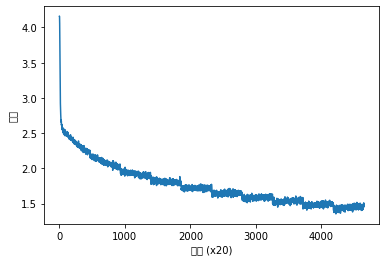

In [22]:
trainer.plot()

In [26]:
# 나중에 사용할 수 있도록 필요한 데이터 저장
word_vecs = model.word_vecs
if GPU:#config.GPU:
    word_vecs = to_cpu(word_vecs)
word_vecs.shape # (10000, 100)

(10000, 100)

In [27]:
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

# eval.py

In [4]:
# coding: utf-8
import sys
sys.path.append('..')
#from common.util import most_similar, analogy
import pickle

In [5]:
pkl_file = 'cbow_params.pkl'
# pkl_file = 'skipgram_params.pkl'

In [12]:
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
print("word_vecs:", word_vecs)
print("word_vecs:", word_vecs.shape)

word_vecs: [[-1.479e-01 -2.327e-01 -9.528e-02 ...  4.819e-01  9.165e-01 -1.403e-01]
 [-7.485e-01 -5.996e-01 -4.187e-02 ...  1.121e+00  4.211e-01 -7.393e-01]
 [ 8.734e-02 -1.156e-01  1.255e+00 ...  3.486e-01  3.064e-01  1.240e-03]
 ...
 [ 3.262e-01 -7.812e-01  1.114e+00 ...  6.831e-01  8.730e-01 -1.004e+00]
 [ 3.706e-01  1.044e+00  8.698e-02 ... -1.729e-01  1.147e+00 -4.189e-01]
 [ 6.610e-02 -1.728e+00  1.078e+00 ...  1.025e+00 -6.377e-01 -1.975e-01]]
word_vecs: (10000, 100)


In [13]:
print("word_to_id:", len(word_to_id))
print("word_to_id keys:", word_to_id.keys())
print("id_to_word:", len(id_to_word))

word_to_id: 10000
word_to_id keys: dict_keys(['atlantic', 'cineplex', 'experience', 'governing', 'believe', 'ill.', 'tactics', 'enable', 'kong', 'presents', 'weekly', '13th', 'dip', 'invitation', 'pulled', 'thrust', 'picket', 'mississippi', 'regain', 'institution', 'league', 'declining', 'buy-out', 'child', 'merchants', 'miners', 'engines', 'olympic', 'profits', 'places', 'rebels', 'expires', 'successor', 'measured', 'son', 'applicants', 'to', 'consolidation', 'combat', 'vested', 'contract', 'investigation', 'store', 'fidelity', 'confidential', 'ballot', 'responded', 'free', 'metropolitan', 'renewing', 'congressional', 'operational', 'levels', 'homer', 'n.y.', 'financiers', 'selling', 'add', 'reckless', 'dangerous', 'recovering', 'transit', 'wider', 'japan', 'usa', 'market-makers', 'ranked', 'prolonged', 'buyer', 'either', 'learn', 'receipts', 'superfund', 'carry-forward', 'called', 'revolving', 'flat', 'weeks', 'fat', 'somehow', 'ten', 'trader', 'monetary', 'word', 'repayment', 'accep

In [14]:
# 가장 비슷한(most similar) 단어 뽑기
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.6103515625
 someone: 0.59130859375
 i: 0.55419921875
 something: 0.48974609375
 anyone: 0.47314453125

[query] year
 month: 0.71875
 week: 0.65234375
 spring: 0.62744140625
 summer: 0.6259765625
 decade: 0.603515625

[query] car
 luxury: 0.497314453125
 arabia: 0.47802734375
 auto: 0.47119140625
 disk-drive: 0.450927734375
 travel: 0.4091796875

[query] toyota
 ford: 0.55078125
 instrumentation: 0.509765625
 mazda: 0.49365234375
 bethlehem: 0.47509765625
 nissan: 0.474853515625


In [15]:
# 유추(analogy) 작업
print('-'*50)
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)

--------------------------------------------------

[analogy] king:man = queen:?
 woman: 5.16015625
 veto: 4.9296875
 ounce: 4.69140625
 earthquake: 4.6328125
 successor: 4.609375

[analogy] take:took = go:?
 went: 4.55078125
 points: 4.25
 began: 4.09375
 comes: 3.98046875
 oct.: 3.90625

[analogy] car:cars = child:?
 children: 5.21875
 average: 4.7265625
 yield: 4.20703125
 cattle: 4.1875
 priced: 4.1796875

[analogy] good:better = bad:?
 more: 6.6484375
 less: 6.0625
 rather: 5.21875
 slower: 4.734375
 greater: 4.671875


# common_all

In [9]:
#================================================================================#
#base_model.py
#================================================================================#

# coding: utf-8
import sys
sys.path.append('..')
import os
import pickle
#from common.np import *
#from common.util import to_gpu, to_cpu


class BaseModel:
    def __init__(self):
        self.params, self.grads = None, None

    def forward(self, *args):
        raise NotImplementedError

    def backward(self, *args):
        raise NotImplementedError

    def save_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        params = [p.astype(np.float16) for p in self.params]
        if GPU:
            params = [to_cpu(p) for p in params]

        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name=None):
        if file_name is None:
            file_name = self.__class__.__name__ + '.pkl'

        if '/' in file_name:
            file_name = file_name.replace('/', os.sep)

        if not os.path.exists(file_name):
            raise IOError('No file: ' + file_name)

        with open(file_name, 'rb') as f:
            params = pickle.load(f)

        params = [p.astype('f') for p in params]
        if GPU:
            params = [to_gpu(p) for p in params]

        for i, param in enumerate(self.params):
            param[...] = params[i]


#================================================================================#
#config.py
#================================================================================#
# coding: utf-8

GPU = False

#================================================================================#
#functions.py
#================================================================================#
# coding: utf-8
#from common.np import *


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def relu(x):
    return np.maximum(0, x)


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


#================================================================================#
#layers.py
#================================================================================#

# coding: utf-8
#from common.np import *  # import numpy as np
#from common.config import GPU
#from common.functions import softmax, cross_entropy_error


class MatMul:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.x = None

    def forward(self, x):
        W, = self.params
        out = np.dot(x, W)
        self.x = x
        return out

    def backward(self, dout):
        W, = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        self.grads[0][...] = dW
        return dx


class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx


class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx


class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

#================================================================================#
#layers.py
#================================================================================#

class SigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.loss = None
        self.y = None  # sigmoid의 출력
        self.t = None  # 정답 데이터

    def forward(self, x, t):
        self.t = t
        self.y = 1 / (1 + np.exp(-x))

        self.loss = cross_entropy_error(np.c_[1 - self.y, self.y], self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = (self.y - self.t) * dout / batch_size
        return dx


class Dropout:
    '''
    http://arxiv.org/abs/1207.0580
    '''
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask


class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None


#================================================================================#
#np.py
#================================================================================#

# coding: utf-8
#from common.config import GPU


if GPU:
    import cupy as np
    np.cuda.set_allocator(np.cuda.MemoryPool().malloc)
    np.add.at = np.scatter_add

    print('\033[92m' + '-' * 60 + '\033[0m')
    print(' ' * 23 + '\033[92mGPU Mode (cupy)\033[0m')
    print('\033[92m' + '-' * 60 + '\033[0m\n')
else:
    import numpy as np


#================================================================================#
#optimizer.py
#================================================================================#
# coding: utf-8
import sys
sys.path.append('..')
#from common.np import *


class SGD:
    '''
    확률적 경사하강법(Stochastic Gradient Descent)
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]


class Momentum:
    '''
    모멘텀 SGG(Momentum SGD)
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] = self.momentum * self.v[i] - self.lr * grads[i]
            params[i] += self.v[i]


class Nesterov:
    '''
    네스테로프 가속 경사(NAG; Nesterov's Accelerated Gradient) (http://arxiv.org/abs/1212.0901)
    '네스테로프 모멘텀 최적화'라고도 한다.
    '''
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = []
            for param in params:
                self.v.append(np.zeros_like(param))

        for i in range(len(params)):
            self.v[i] *= self.momentum
            self.v[i] -= self.lr * grads[i]
            params[i] += self.momentum * self.momentum * self.v[i]
            params[i] -= (1 + self.momentum) * self.lr * grads[i]


class AdaGrad:
    '''
    AdaGrad
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] += grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class RMSprop:
    '''
    RMSprop
    '''
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = []
            for param in params:
                self.h.append(np.zeros_like(param))

        for i in range(len(params)):
            self.h[i] *= self.decay_rate
            self.h[i] += (1 - self.decay_rate) * grads[i] * grads[i]
            params[i] -= self.lr * grads[i] / (np.sqrt(self.h[i]) + 1e-7)


class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(np.zeros_like(param))
                self.v.append(np.zeros_like(param))
        
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i] += (1 - self.beta1) * (grads[i] - self.m[i])
            self.v[i] += (1 - self.beta2) * (grads[i]**2 - self.v[i])
            
            params[i] -= lr_t * self.m[i] / (np.sqrt(self.v[i]) + 1e-7)

#================================================================================#
#time_layers.py
#================================================================================#
# coding: utf-8
#from common.np import *  # import numpy as np (or import cupy as np)
#from common.layers import *
#from common.functions import sigmoid


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev


class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class LSTM:
    def __init__(self, Wx, Wh, b):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가장추 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None


class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelㅇㅔ 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx


class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask


class TimeBiLSTM:
    def __init__(self, Wx1, Wh1, b1,
                 Wx2, Wh2, b2, stateful=False):
        self.forward_lstm = TimeLSTM(Wx1, Wh1, b1, stateful)
        self.backward_lstm = TimeLSTM(Wx2, Wh2, b2, stateful)
        self.params = self.forward_lstm.params + self.backward_lstm.params
        self.grads = self.forward_lstm.grads + self.backward_lstm.grads

    def forward(self, xs):
        o1 = self.forward_lstm.forward(xs)
        o2 = self.backward_lstm.forward(xs[:, ::-1])
        o2 = o2[:, ::-1]

        out = np.concatenate((o1, o2), axis=2)
        return out

    def backward(self, dhs):
        H = dhs.shape[2] // 2
        do1 = dhs[:, :, :H]
        do2 = dhs[:, :, H:]

        dxs1 = self.forward_lstm.backward(do1)
        do2 = do2[:, ::-1]
        dxs2 = self.backward_lstm.backward(do2)
        dxs2 = dxs2[:, ::-1]
        dxs = dxs1 + dxs2
        return dxs

# ====================================================================== #
# 이 아래의 계층들은 책에서 설명하지 않았거나
# 처리 속도보다는 쉽게 이해할 수 있도록 구현했습니다.
#
# TimeSigmoidWithLoss: 시계열 데이터용 시그모이드 + 손실 계층
# GRU: GRU 계층
# TimeGRU: 시계열 데이터용 GRU 계층
# BiTimeLSTM: 양방향 LSTM 계층
# Simple_TimeSoftmaxWithLoss：간단한 TimeSoftmaxWithLoss 계층의 구현
# Simple_TimeAffine: 간단한 TimeAffine 계층의 구현
# ====================================================================== #


class TimeSigmoidWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.xs_shape = None
        self.layers = None

    def forward(self, xs, ts):
        N, T = xs.shape
        self.xs_shape = xs.shape

        self.layers = []
        loss = 0

        for t in range(T):
            layer = SigmoidWithLoss()
            loss += layer.forward(xs[:, t], ts[:, t])
            self.layers.append(layer)

        return loss / T

    def backward(self, dout=1):
        N, T = self.xs_shape
        dxs = np.empty(self.xs_shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t] = layer.backward(dout)

        return dxs


class GRU:
    def __init__(self, Wx, Wh):
        '''

        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가중치 매개변수(3개 분의 가중치가 담겨 있음)
        '''
        self.Wx, self.Wh = Wx, Wh
        self.dWx, self.dWh = None, None
        self.cache = None

    def forward(self, x, h_prev):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]

        z = sigmoid(np.dot(x, Wxz) + np.dot(h_prev, Whz))
        r = sigmoid(np.dot(x, Wxr) + np.dot(h_prev, Whr))
        h_hat = np.tanh(np.dot(x, Wx) + np.dot(r*h_prev, Wh))
        h_next = (1-z) * h_prev + z * h_hat

        self.cache = (x, h_prev, z, r, h_hat)

        return h_next

    def backward(self, dh_next):
        H, H3 = self.Wh.shape
        Wxz, Wxr, Wx = self.Wx[:, :H], self.Wx[:, H:2 * H], self.Wx[:, 2 * H:]
        Whz, Whr, Wh = self.Wh[:, :H], self.Wh[:, H:2 * H], self.Wh[:, 2 * H:]
        x, h_prev, z, r, h_hat = self.cache

        dh_hat =dh_next * z
        dh_prev = dh_next * (1-z)

        # tanh
        dt = dh_hat * (1 - h_hat ** 2)
        dWh = np.dot((r * h_prev).T, dt)
        dhr = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)
        dh_prev += r * dhr

        # update gate(z)
        dz = dh_next * h_hat - dh_next * h_prev
        dt = dz * z * (1-z)
        dWhz = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whz.T)
        dWxz = np.dot(x.T, dt)
        dx += np.dot(dt, Wxz.T)

        # rest gate(r)
        dr = dhr * h_prev
        dt = dr * r * (1-r)
        dWhr = np.dot(h_prev.T, dt)
        dh_prev += np.dot(dt, Whr.T)
        dWxr = np.dot(x.T, dt)
        dx += np.dot(dt, Wxr.T)

        self.dWx = np.hstack((dWxz, dWxr, dWx))
        self.dWh = np.hstack((dWhz, dWhr, dWh))

        return dx, dh_prev


class TimeGRU:
    def __init__(self, Wx, Wh, stateful=False):
        self.Wx, self.Wh = Wx, Wh
        selfdWx, self.dWh = None, None
        self.layers = None
        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        N, T, D = xs.shape
        H, H3 = self.Wh.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = GRU(self.Wx, self.Wh)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        N, T, H = dhs.shape
        D = self.Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        self.dWx, self.dWh = 0, 0

        dh = 0
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)

            dxs[:, t, :] = dx
            self.dWx += layer.dWx
            self.dWh += layer.dWh

        self.dh = dh
        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None


class Simple_TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, xs, ts):
        N, T, V = xs.shape
        layers = []
        loss = 0

        for t in range(T):
            layer = SoftmaxWithLoss()
            loss += layer.forward(xs[:, t, :], ts[:, t])
            layers.append(layer)
        loss /= T

        self.cache = (layers, xs)
        return loss

    def backward(self, dout=1):
        layers, xs = self.cache
        N, T, V = xs.shape
        dxs = np.empty(xs.shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = layers[t]
            dxs[:, t, :] = layer.backward(dout)

        return dxs


class Simple_TimeAffine:
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.dW, self.db = None, None
        self.layers = None

    def forward(self, xs):
        N, T, D = xs.shape
        D, M = self.W.shape

        self.layers = []
        out = np.empty((N, T, M), dtype='f')
        for t in range(T):
            layer = Affine(self.W, self.b)
            out[:, t, :] = layer.forward(xs[:, t, :])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, M = dout.shape
        D, M = self.W.shape

        dxs = np.empty((N, T, D), dtype='f')
        self.dW, self.db = 0, 0
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t, :] = layer.backward(dout[:, t, :])

            self.dW += layer.dW
            self.db += layer.db

        return dxs

#================================================================================#
#trainer.py
#================================================================================#
# coding: utf-8
import sys
sys.path.append('..')
import numpy
import time
import matplotlib.pyplot as plt
#from common.np import *  # import numpy as np
#from common.util import clip_grads


class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # 뒤섞기
            idx = numpy.random.permutation(numpy.arange(data_size))
            x = x[idx]
            t = t[idx]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 기울기 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 손실 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('손실')
        plt.show()


class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # 배치에서 각 샘플을 읽기 시작하는 위치

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35,
            max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 기울기를 구해 매개변수 갱신
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 공유된 가중치를 하나로 모음
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 퍼플렉서티 평가
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| 에폭 %d |  반복 %d / %d | 시간 %d[s] | 퍼플렉서티 %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('반복 (x' + str(self.eval_interval) + ')')
        plt.ylabel('퍼플렉서티')
        plt.show()


def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


#================================================================================#
#util.py
#================================================================================#

# coding: utf-8
import sys
sys.path.append('..')
import os
#from common.np import *


def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word


def cos_similarity(x, y, eps=1e-8):
    '''코사인 유사도 산출

    :param x: 벡터
    :param y: 벡터
    :param eps: '0으로 나누기'를 방지하기 위한 작은 값
    :return:
    '''
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps)
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps)
    return np.dot(nx, ny)


def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    '''유사 단어 검색

    :param query: 쿼리(텍스트)
    :param word_to_id: 단어에서 단어 ID로 변환하는 딕셔너리
    :param id_to_word: 단어 ID에서 단어로 변환하는 딕셔너리
    :param word_matrix: 단어 벡터를 정리한 행렬. 각 행에 해당 단어 벡터가 저장되어 있다고 가정한다.
    :param top: 상위 몇 개까지 출력할 지 지정
    '''
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot


def create_co_matrix(corpus, vocab_size, window_size=1):
    '''동시발생 행렬 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param vocab_size: 어휘 수
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return: 동시발생 행렬
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


def ppmi(C, verbose=False, eps = 1e-8):
    '''PPMI(점별 상호정보량) 생성

    :param C: 동시발생 행렬
    :param verbose: 진행 상황을 출력할지 여부
    :return:
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M


def create_contexts_target(corpus, window_size=1):
    '''맥락과 타깃 생성

    :param corpus: 말뭉치(단어 ID 목록)
    :param window_size: 윈도우 크기(윈도우 크기가 1이면 타깃 단어 좌우 한 단어씩이 맥락에 포함)
    :return:
    '''
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)


def to_cpu(x):
    import numpy
    if type(x) == numpy.ndarray:
        return x
    return np.asnumpy(x)


def to_gpu(x):
    import cupy
    if type(x) == cupy.ndarray:
        return x
    return cupy.asarray(x)


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


def eval_perplexity(model, corpus, batch_size=10, time_size=35):
    print('퍼플렉서티 평가 중 ...')
    corpus_size = len(corpus)
    total_loss, loss_cnt = 0, 0
    max_iters = (corpus_size - 1) // (batch_size * time_size)
    jump = (corpus_size - 1) // batch_size

    for iters in range(max_iters):
        xs = np.zeros((batch_size, time_size), dtype=np.int32)
        ts = np.zeros((batch_size, time_size), dtype=np.int32)
        time_offset = iters * time_size
        offsets = [time_offset + (i * jump) for i in range(batch_size)]
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                xs[i, t] = corpus[(offset + t) % corpus_size]
                ts[i, t] = corpus[(offset + t + 1) % corpus_size]

        try:
            loss = model.forward(xs, ts, train_flg=False)
        except TypeError:
            loss = model.forward(xs, ts)
        total_loss += loss

        sys.stdout.write('\r%d / %d' % (iters, max_iters))
        sys.stdout.flush()

    print('')
    ppl = np.exp(total_loss / max_iters)
    return ppl


def eval_seq2seq(model, question, correct, id_to_char,
                 verbos=False, is_reverse=False):
    correct = correct.flatten()
    # 머릿글자
    start_id = correct[0]
    correct = correct[1:]
    guess = model.generate(question, start_id, len(correct))

    # 문자열로 변환
    question = ''.join([id_to_char[int(c)] for c in question.flatten()])
    correct = ''.join([id_to_char[int(c)] for c in correct])
    guess = ''.join([id_to_char[int(c)] for c in guess])

    if verbos:
        if is_reverse:
            question = question[::-1]

        colors = {'ok': '\033[92m', 'fail': '\033[91m', 'close': '\033[0m'}
        print('Q', question)
        print('T', correct)

        is_windows = os.name == 'nt'

        if correct == guess:
            mark = colors['ok'] + '☑' + colors['close']
            if is_windows:
                mark = 'O'
            print(mark + ' ' + guess)
        else:
            mark = colors['fail'] + '☒' + colors['close']
            if is_windows:
                mark = 'X'
            print(mark + ' ' + guess)
        print('---')

    return 1 if guess == correct else 0


def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s(을)를 찾을 수 없습니다.' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x